# Expore data : strat 2 fixed

## Import & definitions

In [1]:
import os
import hashlib
import sys
from pathlib import Path
import re
import random
import time
import math
import itertools
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats.mstats import mquantiles
# from helpers.ocean_helpers import save_list
'''import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2'''
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()
#sns.set_theme("notebook")
#mpl.style.use('seaborn-v0_8-ticks')
# definitions
DT_PAST = 5 # 5 min
PAST_HISTORY = int(6*60 / DT_PAST) #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15 : 1h15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.995 #0.8 #0.9891 # 1-(60/5*24)/50977
TARGET_NAME = "Close_ETH"
MODE_TRAIN_AE = True 
'''
#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = True # False

EPOCHS_AE = 1#30
PATIENCE_AE = 0#10
LIST_UNITS_ENC_AE = [64]
LIST_UNITS_AE = [16]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 100#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [128]
LIST_DROPOUT_PRED = [0.2]

MODE_TRAIN_LSTM = False
'''
# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = os.path.join(path_data, "pred_vals.csv")
path_save_auto_select = os.path.join(path_data, "list_auto_select.csv")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
path_save_df_feat_std = os.path.join(path_data, "df_features_05m_std.csv")
path_X_train = os.path.join(path_data, 'X_train.dat')
path_X_train_sca = os.path.join(path_data, 'X_train_sca.dat')
path_df_prob_comb = os.path.join(path_data, 'df_prob_comb.csv')
path_arr_corr_matrix_targets = os.path.join(
    path_data, 'arr_corr_matrix_targets.npy'
)
path_pca = os.path.join(path_data,"pca_model.pkl")
path_hash_pca = os.path.join(path_data, 'pca_hash.txt')

'''
path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")
'''

'\npath_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")\npath_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")\npath_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")\npath_mdl_predict_autoenc_lstm  =  os.path.join(\n    path_data, "mdl_predict_autoenc_lstm")\n'

In [2]:
PAST_HISTORY

72

In [3]:
21+9-24

6

In [4]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [5]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [6]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

<>:19: SyntaxWarning: invalid escape sequence '\.'
<>:19: SyntaxWarning: invalid escape sequence '\.'
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_78415/2761487227.py:19: SyntaxWarning: invalid escape sequence '\.'
  title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)


In [7]:
# Helpers check update
def get_data_hash(data):
    data = str(data).encode('utf-8')
    return hashlib.sha256(data).hexdigest()

def load_hash(file_path):
    if not os.path.exists(file_path):
        return None
    with open(file_path, 'r') as file:
        data = file.read()
    return data

def check_hash_inputs(tuple_inputs, path_hash):
    hash_inputs = ""
    for curr_var in tuple_inputs:
        hash_inputs += get_data_hash(curr_var)

    # load old file hash
    hash_inputs_old = load_hash(path_hash)

    # compare hash
    if hash_inputs == hash_inputs_old:
        print("hash match: mode LOAD")
        return False, hash_inputs
    else:
        print("hash not match : mode REDO")
        return True, hash_inputs
    
def save_hash(path_hash, hash_inputs):
    with open(path_hash, 'w') as file:
            file.write(hash_inputs)


## Load raw features

In [8]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
# keep target untouched
df_feat_raw[f"{TARGET_NAME}_raw"] = df_feat_raw[TARGET_NAME]
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_78415/2738736025.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0                  NaN  ...         NaN            NaN           NaN   
1                  NaN  ...         NaN            NaN           NaN   
2                  NaN  ...         NaN            NaN           NaN   
3                  NaN  ...         NaN            NaN           NaN   
4                  NaN  ...         NaN            NaN           NaN   
...                ...  ...         ...            ...           ...   
255033        2630.360  ...         NaN            NaN           NaN   
255034        2630.360  ...         NaN            NaN           NaN   
255035        2630.360  ...         NaN            NaN           NaN   
255036        2629.695  ...         NaN            NaN           NaN   
255037        2628.670  ...         NaN            NaN           NaN   

        delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                    NaN         0.0               NaN         0.0      0.0   
1                    NaN         0.0               NaN         0.0      0.0   
2                    NaN         0.0               NaN         0.0      0.0   
3                    NaN         0.0               NaN         0.0      0.0   
4                    NaN         0.0               NaN         0.0      0.0   
...                  ...         ...               ...         ...      ...   
255033               NaN         0.0               NaN         0.0      0.0   
255034               NaN         0.0               NaN         0.0      0.0   
255035               NaN         0.0               NaN         0.0      0.0   
255036               NaN         0.0               NaN         0.0      0.0   
255037               NaN         0.0               NaN         0.0      0.0   

        date  Close_ETH_raw  
0        NaN        1196.32  
1        NaN        1195.38  
2        NaN        1194.55  
3        NaN        1195.98  
4        NaN        1196.06  
...      ...            ...  
255033   NaN        2624.51  
255034   NaN        2624.26  
255035   NaN        2620.24  
255036   NaN        2616.73  
255037   NaN        2614.27  

[255038 rows x 136 columns]

### drop nan

In [9]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH             1
vwap_z_score_BTC             1
ichi_tenkan_ETH              8
ichi_tenkan_BTC              8
rsi_h_ETH                   13
max_high_h_ETH              13
min_low_h_BTC               13
max_high_h_BTC              13
min_low_h_ETH               13
rsi_h_BTC                   13
chop_h_BTC                  14
chop_h_ETH                  14
ichi_kijun_ETH              25
ichi_cloud_a_ETH            25
ichi_kijun_BTC              25
ichi_cloud_a_BTC            25
ichi_tenkan_day_BTC        215
ichi_tenkan_day_ETH        215
dxy                        264
min_low_d_BTC              335
max_high_d_ETH             335
rsi_d_BTC                  335
max_high_d_BTC             335
rsi_d_ETH                  335
chop_d_ETH                 335
chop_d_BTC                 335
min_low_d_ETH              335
ichi_kijun_day_ETH         623
ichi_cloud_a_day_BTC       623
ichi_cloud_a_day_ETH       623
ichi_kijun_day_BTC         623
fvx                    

#### Cheat Backward Filling

In [10]:
df_feat = df_feat_raw.copy()

In [11]:
df_feat = df_feat.bfill(axis ='rows')

In [12]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.710  ...         0.0            0.0           0.0   
1             1194.710  ...         0.0            0.0           0.0   
2             1194.710  ...         0.0            0.0           0.0   
3             1194.710  ...         0.0            0.0           0.0   
4             1194.710  ...         0.0            0.0           0.0   
...                ...  ...         ...            ...           ...   
255033        2630.360  ...         NaN            NaN           NaN   
255034        2630.360  ...         NaN            NaN           NaN   
255035        2630.360  ...         NaN            NaN           NaN   
255036        2629.695  ...         NaN            NaN           NaN   
255037        2628.670  ...         NaN            NaN           NaN   

        delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                    0.0         0.0               0.0         0.0      0.0   
1                    0.0         0.0               0.0         0.0      0.0   
2                    0.0         0.0               0.0         0.0      0.0   
3                    0.0         0.0               0.0         0.0      0.0   
4                    0.0         0.0               0.0         0.0      0.0   
...                  ...         ...               ...         ...      ...   
255033               NaN         0.0               NaN         0.0      0.0   
255034               NaN         0.0               NaN         0.0      0.0   
255035               NaN         0.0               NaN         0.0      0.0   
255036               NaN         0.0               NaN         0.0      0.0   
255037               NaN         0.0               NaN         0.0      0.0   

                       date  Close_ETH_raw  
0       2023-01-02 05:00:00        1196.32  
1       2023-01-02 05:00:00        1195.38  
2       2023-01-02 05:00:00        1194.55  
3       2023-01-02 05:00:00        1195.98  
4       2023-01-02 05:00:00        1196.06  
...                     ...            ...  
255033                  NaN        2624.51  
255034                  NaN        2624.26  
255035                  NaN        2620.24  
255036                 

In [13]:
nb_missing = get_missing(df_feat)

missing data : 
date                2688
delta_event_real    2688
delta_event_pred    2688
Previous_num        2688
Consensus_num       2688
keep                2688
Date                2688
Previous            2688
Consensus           2688
Event               2688
Country             2688
Time (ET)           2688
Actual_num          2688
Actual              2688
dtype: int64

on 255038 samples


In [14]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [15]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [16]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'Close_ETH_raw']

In [17]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0        1196.13   1196.32  1195.65    1196.32    334.5592   
1        1196.31   1196.69  1194.90    1195.38    682.3876   
2        1195.38   1195.81  1194.55    1194.55    228.9387   
3        1194.55   1195.98  1194.31    1195.98    601.8903   
4        1195.98   1196.37  1195.97    1196.06    144.8048   
...          ...       ...      ...        ...         ...   
255033   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034   2624.50   2626.90  2623.30    2624.26    977.3830   
255035   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ichi_tenkan_ETH  ...  vwap_3m_ETH  vwap_6m_ETH  \
0             1194.710         1194.710  ...  1196.096667  1196.096667   
1             1194.710         1194.710  ...  1195.801420  1195.801420   
2             1194.710         1194.710  ...  1195.648641  1195.648641   
3             1194.710         1194.710  ...  1195.575250  1195.575250   
4             1194.710         1194.710  ...  1195.615807  1195.615807   
...                ...              ...  ...          ...          ...   
255033        2630.360         2627.260  ...  2215.946820  2112.080395   
255034        2630.360         2627.260  ...  2215.970478  2112.079173   
255035        2630.360         2627.260  ...  2216.016378  2112.083189   
255036        2629.695         2624.810  ...  2216.072494  2112.088060   
255037        2628.670         2620.525  ...  2216.123423  2112.097985   

         vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH    supply_ETH  \
0       1196.096667   1196.096667         -0.634018  0.000187  1.205290e+08   
1       1195.801420   1195.801420         -0.634018 -0.000353  1.205290e+08   
2       1195.648641   1195.648641         -1.240604 -0.000920  1.205290e+08   
3       1195.575250   1195.575250          0.521593  0.000338  1.205290e+08   
4       1195.615807   1195.615807          0.626856  0.000371  1.205290e+08   
...             ...           ...               ...       ...           ...   
255033  2465.963959   2449.429165          0.244601  0.066710  1.207159e+08   
255034  2465.992103   2449.429616          0.244251  0.066621  1.207159e+08   
255035  2466.034614   2449.430717          0.238634  0.065188  1.207159e+08   
255036  2466.071410   2449.431688          0.233729  0.063934  1.207159e+08   
255037  2466.111540   2449.432810          0.230291  0.063053  1.207159e+08   

        act_addr_ETH  market_dom_ETH  Close_ETH_raw  
0             522460       17.409118        1196.32  
1             522460       17.409118        1195.38  
2             522460       17.409118        1194.55  
3             522460       17.409118        1195.98  
4             522460       17.409118        1196.06  
...              ...             ...            ...  
255033        587140        9.110644        2624.51  
255034        587140        9.110644        2624.26  
255035        587140        9.110644        2620.24  
255036        587140        9.110644        2616.73  
255037        587140      

In [18]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
    'atr_h_ETH',
    'atr_d_ETH',
    'atr_w_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [19]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [20]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'atr_h_BTC',
    'atr_d_BTC',
    'atr_w_BTC',
]

In [21]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [22]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [23]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0       3.910  3823.179932  103.494003
1       3.910  3823.179932  103.494003
2       3.910  3823.179932  103.494003
3       3.910  3823.179932  103.494003
4       3.910  3823.179932  103.494003
...       ...          ...         ...
255033  3.979  5970.529785   98.964996
255034  3.979  5970.529785   98.964996
255035  3.979  5970.529785   98.964996
255036  3.979  5970.529785   98.964996
255037  3.979  5970.529785   98.956001

[255038 rows x 3 columns]

In [24]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [25]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Close_ETH_raw',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_BTC',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [26]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    'vwap_z_score_BTC',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [27]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other +
    [f"{TARGET_NAME}_raw"]
)

# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  109


In [28]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'atr_h_ETH',
 'atr_d_ETH',
 'atr_w_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min

In [29]:
get_missing(df_feat.filter(list_col_select))

missing data : 
Series([], dtype: int64)

on 255038 samples


Series([], dtype: int64)

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [30]:
df_feat.shape[0]

255038

In [31]:
TRAIN_SPLIT_RATIO

0.995

In [32]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

253763

In [33]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ...  Consensus_num  Previous_num  delta_event_pred  \
0             1194.710  ...            0.0           0.0               0.0   
1             1194.710  ...            0.0           0.0               0.0   
2             1194.710  ...            0.0           0.0               0.0   
3             1194.710  ...            0.0           0.0               0.0   
4             1194.710  ...            0.0           0.0               0.0   
...                ...  ...            ...           ...               ...   
255033        2630.360  ...            NaN           NaN               NaN   
255034        2630.360  ...            NaN           NaN               NaN   
255035        2630.360  ...            NaN           NaN               NaN   
255036        2629.695  ...            NaN           NaN               NaN   
255037        2628.670  ...            NaN           NaN               NaN   

        event_pred  delta_event_real  event_real  day_off  \
0              0.0               0.0         0.0      0.0   
1              0.0               0.0         0.0      0.0   
2              0.0               0.0         0.0      0.0   
3              0.0               0.0         0.0      0.0   
4              0.0               0.0         0.0      0.0   
...            ...               ...         ...      ...   
255033         0.0               NaN         0.0      0.0   
255034         0.0               NaN         0.0      0.0   
255035         0.0               NaN         0.0      0.0   
255036         0.0               NaN         0.0      0.0   
255037         0.0               NaN         0.0      0.0   

                       date  Close_ETH_raw  train  
0       2023-01-02 05:00:00        1196.32   True  
1       2023-01-02 05:00:00        1195.38   True  
2       2023-01-02 05:00:00        1194.55   True  
3       2023-01-02 05:00:00        1195.98   True  
4       2023-01-02 05:00:00        1196.06   True  
...                     ...            ...    ...  
255033                  NaN        2624.51  False  
255034                  NaN        2624.26  False  
255035                  NaN        2620.24  False  
255036                  NaN        2616.73  False  
255037                  NaN        2614.27  F

In [34]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
253759  1748658600000   2504.91   2505.00  2492.22    2495.20   4235.1902   
253760  1748658900000   2495.21   2503.27  2494.44    2502.12   2576.0733   
253761  1748659200000   2502.11   2502.60  2498.13    2498.60   1382.7143   
253762  1748659500000   2498.60   2500.40  2496.37    2498.75   1450.5001   
253763  1748659800000   2498.75   2502.00  2485.40    2492.50   3607.3172   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
253759  2025-05-31 02:30:00       2528.067500       2546.470000   
253760  2025-05-31 02:35:00       2526.930000       2546.470000   
253761  2025-05-31 02:40:00       2525.150000       2546.470000   
253762  2025-05-31 02:45:00       2525.150000       2546.470000   
253763  2025-05-31 02:50:00       2524.310000       2546.470000   

        ichi_kijun_ETH  ...  Consensus_num  Previous_num  delta_event_pred  \
0              1194.71  ...            0.0           0.0               0.0   
1              1194.71  ...            0.0           0.0               0.0   
2              1194.71  ...            0.0           0.0               0.0   
3              1194.71  ...            0.0           0.0               0.0   
4              1194.71  ...            0.0           0.0               0.0   
...                ...  ...            ...           ...               ...   
253759         2505.22  ...            NaN           NaN               NaN   
253760         2505.22  ...            NaN           NaN               NaN   
253761         2505.22  ...            NaN           NaN               NaN   
253762         2505.22  ...            NaN           NaN               NaN   
253763         2505.22  ...            NaN           NaN               NaN   

        event_pred  delta_event_real  event_real  day_off  \
0              0.0               0.0         0.0      0.0   
1              0.0               0.0         0.0      0.0   
2              0.0               0.0         0.0      0.0   
3              0.0               0.0         0.0      0.0   
4              0.0               0.0         0.0      0.0   
...            ...               ...         ...      ...   
253759         0.0               NaN         0.0      0.0   
253760         0.0               NaN         0.0      0.0   
253761         0.0               NaN         0.0      0.0   
253762         0.0               NaN         0.0      0.0   
253763         0.0               NaN         0.0      0.0   

                       date  Close_ETH_raw  train  
0       2023-01-02 05:00:00        1196.32   True  
1       2023-01-02 05:00:00        1195.38   True  
2       2023-01-02 05:00:00        1194.55   True  
3       2023-01-02 05:00:00        1195.98   True  
4       2023-01-02 05:00:00        1196.06   True  
...                     ...            ...    ...  
253759                  NaN        2495.20   True  
253760                  NaN        2502.12   True  
253761                  NaN        2498.60   True  
253762                  NaN        2498.75   True  
253763                  NaN        2492.50   

In [35]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
253764  1748660100000   2492.49   2493.17  2487.12    2490.22   2272.6386   
253765  1748660400000   2490.21   2496.84  2489.04    2491.71   1715.3111   
253766  1748660700000   2491.71   2496.80  2485.23    2490.01   1743.7758   
253767  1748661000000   2490.00   2496.59  2488.06    2496.04   1652.4027   
253768  1748661300000   2496.04   2499.85  2486.99    2490.40   2457.9952   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
253764  2025-05-31 02:55:00         2523.4350          2546.470   
253765  2025-05-31 03:00:00         2521.7675          2546.470   
253766  2025-05-31 03:05:00         2521.5525          2546.470   
253767  2025-05-31 03:10:00         2521.3800          2546.470   
253768  2025-05-31 03:15:00         2521.8325          2544.585   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00         2641.5250          2635.690   
255034  2025-06-04 12:45:00         2641.5250          2635.690   
255035  2025-06-04 12:50:00         2641.3500          2636.225   
255036  2025-06-04 12:55:00         2641.3500          2636.225   
255037  2025-06-04 13:00:00         2641.3500          2636.225   

        ichi_kijun_ETH  ...  Consensus_num  Previous_num  delta_event_pred  \
253764        2501.755  ...            NaN           NaN               NaN   
253765        2501.600  ...            NaN           NaN               NaN   
253766        2501.600  ...            NaN           NaN               NaN   
253767        2501.600  ...            NaN           NaN               NaN   
253768        2501.600  ...            NaN           NaN               NaN   
...                ...  ...            ...           ...               ...   
255033        2630.360  ...            NaN           NaN               NaN   
255034        2630.360  ...            NaN           NaN               NaN   
255035        2630.360  ...            NaN           NaN               NaN   
255036        2629.695  ...            NaN           NaN               NaN   
255037        2628.670  ...            NaN           NaN               NaN   

        event_pred  delta_event_real  event_real  day_off  date  \
253764         0.0               NaN         0.0      0.0   NaN   
253765         0.0               NaN         0.0      0.0   NaN   
253766         0.0               NaN         0.0      0.0   NaN   
253767         0.0               NaN         0.0      0.0   NaN   
253768         0.0               NaN         0.0      0.0   NaN   
...            ...               ...         ...      ...   ...   
255033         0.0               NaN         0.0      0.0   NaN   
255034         0.0               NaN         0.0      0.0   NaN   
255035         0.0               NaN         0.0      0.0   NaN   
255036         0.0               NaN         0.0      0.0   NaN   
255037         0.0               NaN         0.0      0.0   NaN   

        Close_ETH_raw  train  
253764        2490.22  False  
253765        2491.71  False  
253766        2490.01  False  
253767        2496.04  False  
253768        2490.40  False  
...               ...    ...  
255033        2624.51  False  
255034        2624.26  False  
255035        2620.24  False  
255036        2616.73  False  
255037        2614.27  False  

[1274 rows x 137 columns]

In [36]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):
    # Close ETH need to be in first place
    # we divide by close ETH price all price dependent features except the first Close ETH
    # in a matrix
    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                p_close = out_matrix[-1, 0] # last past history lag, first feature = Close ETH
                # scaling : price dependent features divide by Close ETH 
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / p_close
                )
                # keep Price Close with no scaling
                #out_matrix[-1, 0] = p_close
                
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False, price_label=None):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    if price_label:
        price_matrix = id_df[price_label].values

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            if price_label:
                out_matrix = out_matrix / price_matrix[start-1, 0]
            else:
                out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [37]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [38]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [39]:
df_feat[df_feat["train"] == True].shape[0]

253764

In [40]:
df_feat[df_feat["train"] == True].shape[0] - PAST_HISTORY - FUTURE_TARGET

253677

In [41]:
n_feat = df_feat.loc[df_feat["train"] == True, list_col_select].shape[1]
n_feat

109

In [42]:
# create X_train on disk
#filename = os.path.join(path_data, 'X_train.dat')
#print(filename)
X_train_dat = np.memmap(
    path_X_train, 
    dtype='float32', 
    mode='w+', 
    shape=(
        df_feat[df_feat["train"] == True].shape[0] - PAST_HISTORY - FUTURE_TARGET, 
        PAST_HISTORY, 
        n_feat,
    )
)

In [43]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'atr_h_ETH',
 'atr_d_ETH',
 'atr_w_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min

In [44]:
X_test = []
y_train, y_test = [], []
y_high_train, y_high_test = [], []
y_low_train, y_low_test = [], []


for is_train, _df in df_feat.groupby("train"):

    for index, seq in enumerate(gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        )):
        if is_train:
            # don't use append here but assign to X_train_dat
            X_train_dat[index] = seq # PAST_HISTORY * n_feat
            #X_train.append(seq)
        else:
            X_test.append(seq)
        
        #index += 1
    if is_train:
        X_train_dat.flush()

    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['High_ETH'], divide_price=True, 
                            price_label=['Close_ETH']):

        if is_train:
            y_high_train.append(seq_y)
        else:
            y_high_test.append(seq_y) 

    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Low_ETH'], divide_price=True, 
                            price_label=['Close_ETH']):

        if is_train:
            y_low_train.append(seq_y)
        else:
            y_low_test.append(seq_y) 

#X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

y_high_train = np.array(y_high_train)
y_high_test = np.array(y_high_test)

y_low_train = np.array(y_low_train)
y_low_test = np.array(y_low_test)

#print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1187, 72, 109) (1187, 15)


In [45]:
y_high_train


array([[1.0004688 , 1.00057763, 1.00039346, ..., 1.00053577, 1.00031811,
        1.00015069],
       [1.00011715, 0.99993306, 0.99985775, ..., 0.99985775, 0.9996904 ,
        0.99939753],
       [1.00000837, 0.99993305, 0.99990795, ..., 0.99976569, 0.9994728 ,
        0.99888703],
       ...,
       [1.00032244, 1.00085587, 0.99619436, ..., 0.99997612, 0.99718956,
        0.99650088],
       [1.00202461, 0.99735765, 0.99579137, ..., 0.99835401, 0.99766453,
        0.9973975 ],
       [1.00944705, 1.00786179, 1.00779321, ..., 1.00975765, 1.00948739,
        1.00859996]], shape=(253677, 15))

In [46]:
assert df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]


In [47]:
assert df_feat["High_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_high_train[0,0]


In [48]:
assert df_feat["Low_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_low_train[0,0]


In [49]:
X_train_dat.shape

(253677, 72, 109)

In [50]:
X_train_dat[0,:,:].shape

(72, 109)

Close_ETH normalized by Close_ETH at last lag of the past history

In [51]:
X_train_dat[0,:,0]

memmap([1.0014901 , 1.0007032 , 1.0000083 , 1.0012054 , 1.0012724 ,
        1.0017328 , 0.9998493 , 0.99973214, 0.9992466 , 1.0000837 ,
        1.0002344 , 0.9996233 , 0.99963164, 1.0009627 , 1.0007032 ,
        1.0007032 , 1.0008874 , 1.0007617 , 1.0005022 , 1.000159  ,
        1.0003182 , 1.0008287 , 1.0006781 , 1.001239  , 0.99972373,
        0.99985766, 1.0005692 , 1.0006614 , 1.0007032 , 1.0013226 ,
        1.0018417 , 1.0011386 , 1.0006111 , 1.0009376 , 1.0007617 ,
        1.0007199 , 0.99878615, 0.99918795, 0.99887824, 0.9978318 ,
        0.99903727, 0.9990289 , 0.999054  , 0.9994307 , 0.99954796,
        0.99958146, 0.9998744 , 0.99958146, 0.9993721 , 0.9985434 ,
        0.99840945, 0.9983006 , 0.99802434, 0.99802434, 0.99808294,
        0.998602  , 0.99790716, 0.99809134, 0.998242  , 0.9986438 ,
        0.9990038 , 0.9988364 , 0.9989536 , 0.9989201 , 0.99918795,
        0.99969864, 0.99951446, 0.99922144, 0.99963164, 0.9998326 ,
        0.999774  , 1.        ], dtype=float32)

In [52]:
list_col_select[1]

'Open_ETH'

In [53]:
X_train_dat[0,:,1]

memmap([1.0013311 , 1.0014818 , 1.0007032 , 1.0000083 , 1.0012054 ,
        1.0012724 , 1.0017413 , 0.99985766, 0.99973214, 0.9992466 ,
        1.000092  , 1.0002344 , 0.9996233 , 0.99964005, 1.0009711 ,
        1.0007032 , 1.0006949 , 1.0008874 , 1.0007617 , 1.0005022 ,
        1.000159  , 1.0003182 , 1.0008371 , 1.0006781 , 1.0012306 ,
        0.99972373, 0.9998493 , 1.0005609 , 1.0006614 , 1.0007032 ,
        1.0013311 , 1.0018417 , 1.0011386 , 1.0006195 , 1.0009376 ,
        1.0007617 , 1.0007284 , 0.99878615, 0.99918795, 0.99886984,
        0.9978318 , 0.99904567, 0.99903727, 0.99904567, 0.9994391 ,
        0.99954796, 0.99957305, 0.99986607, 0.9995898 , 0.9993721 ,
        0.998535  , 0.99840105, 0.9983006 , 0.99802434, 0.99802434,
        0.9980746 , 0.998602  , 0.99789876, 0.9980997 , 0.99825037,
        0.9986438 , 0.9990038 , 0.9988364 , 0.9989536 , 0.99891174,
        0.9991796 , 0.999707  , 0.9995228 , 0.99922985, 0.9996233 ,
        0.9998409 , 0.9997823 ], dtype=float32)

Close_ETH_raw

In [54]:
list_col_select[-1]

'Close_ETH_raw'

In [55]:
X_train_dat[0,:,-1]

memmap([1196.32, 1195.38, 1194.55, 1195.98, 1196.06, 1196.61, 1194.36,
        1194.22, 1193.64, 1194.64, 1194.82, 1194.09, 1194.1 , 1195.69,
        1195.38, 1195.38, 1195.6 , 1195.45, 1195.14, 1194.73, 1194.92,
        1195.53, 1195.35, 1196.02, 1194.21, 1194.37, 1195.22, 1195.33,
        1195.38, 1196.12, 1196.74, 1195.9 , 1195.27, 1195.66, 1195.45,
        1195.4 , 1193.09, 1193.57, 1193.2 , 1191.95, 1193.39, 1193.38,
        1193.41, 1193.86, 1194.  , 1194.04, 1194.39, 1194.04, 1193.79,
        1192.8 , 1192.64, 1192.51, 1192.18, 1192.18, 1192.25, 1192.87,
        1192.04, 1192.26, 1192.44, 1192.92, 1193.35, 1193.15, 1193.29,
        1193.25, 1193.57, 1194.18, 1193.96, 1193.61, 1194.1 , 1194.34,
        1194.27, 1194.54], dtype=float32)

## Standardization

In [56]:
# check if new  data in df_feat
# hash input
hash_df_feat = get_data_hash(df_feat)
# load df_prob file hash
path_feat_hash = os.path.join(path_data, 'df_feat_hash.txt')
# hash df_prob data
hash_df_feat_old = load_hash(path_feat_hash)

# compare hash
if hash_df_feat == hash_df_feat_old:
    print("hash match: mode NO REDO rescaling")
    mode_rescale = False
else:
    print("hash not match : mode REDO rescaling")
    mode_rescale = True


hash match: mode NO REDO rescaling


In [57]:
#mode_rescale = True

In [58]:
path_scaler

'data/scaler.bin'

In [59]:
X_train_sca_dat = np.memmap(
    path_X_train_sca, 
    dtype='float32', 
    mode='w+', 
    shape=(
        df_feat[df_feat["train"] == True].shape[0] - PAST_HISTORY - FUTURE_TARGET, 
        PAST_HISTORY, 
        n_feat,
    )
)

In [60]:
list_col_select_global

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'atr_h_ETH',
 'atr_d_ETH',
 'atr_w_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min

In [61]:
# Peak memory : 17Gb !
# need to rescale minmax for some entries
list_min_max = ['day_off',
 'event_pred',
 'event_real']

if mode_rescale:
    scaler = StandardScaler()
    scaler.fit(X_train_dat.reshape(-1,X_train_dat.shape[-1]))
    for col in list_min_max:
        i_col = list_col_select.index(col)
        scaler.scale_[i_col] = 1
        scaler.mean_[i_col] = 0
    #X_train_sca_dat[:] = scaler.fit_transform(X_train_dat.reshape(-1,X_train_dat.shape[-1])).reshape(X_train_dat.shape)
    X_train_sca_dat[:] = scaler.transform(X_train_dat.reshape(-1,X_train_dat.shape[-1])).reshape(X_train_dat.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)

    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
    # save hash
    with open(path_feat_hash, 'w') as file:
        file.write(hash_df_feat)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca_dat[:] = scaler.transform(X_train_dat.reshape(-1,X_train_dat.shape[-1])).reshape(X_train_dat.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

Load standardization from disk...


In [62]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99883363, 0.98687133, 0.99429154, ..., 0.99716965, 0.99328838,
        0.99604309],
       [0.98802374, 0.99545261, 0.99552833, ..., 0.99444827, 0.9972062 ,
        0.99580333],
       [1.00751892, 1.00759556, 1.00489698, ..., 1.00929377, 1.00787389,
        1.0079344 ]], shape=(253677, 15))

In [63]:
np.mean(y_train_sca)

np.float64(-6.796516874623723e-14)

In [64]:
np.std(y_train_sca)

np.float64(1.0)

In [65]:
np.mean(y_test_sca)

np.float64(0.04559068417215605)

In [66]:
np.std(y_test_sca)

np.float64(0.7247543709407388)

In [67]:
scaler.scale_

array([1.11758415e-02, 1.13341565e-02, 1.12647813e-02, 1.12758084e-02,
       1.58659704e-02, 1.69234305e-02, 1.21560721e-02, 1.15278091e-02,
       7.03027864e-02, 7.55225456e-02, 2.51978066e-02, 1.78609548e-02,
       1.79899755e-01, 1.86481614e-01, 6.00531676e-02, 3.71399331e-02,
       1.23344466e-02, 1.24286029e-02, 2.63323536e-02, 2.63300194e-02,
       6.16530272e-02, 5.58715498e-02, 1.16466161e-02, 1.19718808e-02,
       1.62849751e-02, 6.55955514e-02, 1.22452620e-01, 1.82853823e-01,
       8.65035270e-02, 1.98142910e-01, 2.17634523e-03, 1.35787848e-03,
       1.07704011e-03, 9.58206494e+00, 9.59168327e+00, 9.57255368e+00,
       9.58205875e+00, 9.58213332e+00, 9.58036073e+00, 9.58100748e+00,
       9.58197494e+00, 9.62146355e+00, 9.59714636e+00, 9.55135518e+00,
       9.57274515e+00, 9.94294768e+00, 1.00965276e+01, 9.41614582e+00,
       9.52746475e+00, 9.62102516e+00, 9.54307203e+00, 9.77353007e+00,
       9.36669447e+00, 1.00480262e+01, 8.98767280e+00, 9.58182442e+00,
      

In [68]:
scaler.scale_.shape

(109,)

In [69]:
scaler.scale_[-4:]

array([  1.        ,   1.        ,   1.        , 717.47630208])

In [70]:
scaler.mean_[-4:]

array([   0.        ,    0.        ,    0.        , 2419.09062826])

In [71]:
X_train_dat[0,:,0]

memmap([1.0014901 , 1.0007032 , 1.0000083 , 1.0012054 , 1.0012724 ,
        1.0017328 , 0.9998493 , 0.99973214, 0.9992466 , 1.0000837 ,
        1.0002344 , 0.9996233 , 0.99963164, 1.0009627 , 1.0007032 ,
        1.0007032 , 1.0008874 , 1.0007617 , 1.0005022 , 1.000159  ,
        1.0003182 , 1.0008287 , 1.0006781 , 1.001239  , 0.99972373,
        0.99985766, 1.0005692 , 1.0006614 , 1.0007032 , 1.0013226 ,
        1.0018417 , 1.0011386 , 1.0006111 , 1.0009376 , 1.0007617 ,
        1.0007199 , 0.99878615, 0.99918795, 0.99887824, 0.9978318 ,
        0.99903727, 0.9990289 , 0.999054  , 0.9994307 , 0.99954796,
        0.99958146, 0.9998744 , 0.99958146, 0.9993721 , 0.9985434 ,
        0.99840945, 0.9983006 , 0.99802434, 0.99802434, 0.99808294,
        0.998602  , 0.99790716, 0.99809134, 0.998242  , 0.9986438 ,
        0.9990038 , 0.9988364 , 0.9989536 , 0.9989201 , 0.99918795,
        0.99969864, 0.99951446, 0.99922144, 0.99963164, 0.9998326 ,
        0.999774  , 1.        ], dtype=float32)

### Check unscaling

In [72]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       2419.198618       2418.400385   
1    1195.38   1196.31   1196.69  1194.90       2419.198618       2418.400385   
2    1194.55   1195.38   1195.81  1194.55       2419.198618       2418.400385   
3    1195.98   1194.55   1195.98  1194.31       2419.198618       2418.400385   
4    1196.06   1195.98   1196.37  1195.97       2419.198618       2418.400385   
5    1196.61   1196.06   1196.70  1196.06       2419.198618       2418.400385   
6    1194.36   1196.62   1196.62  1193.72       2419.198618       2418.400385   
7    1194.22   1194.37   1194.43  1192.72       2419.198618       2418.400385   
8    1193.64   1194.22   1194.22  1193.02       2419.198618       2418.400385   
9    1194.64   1193.64   1195.06  1193.63       2419.198618       2418.400385   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           2418.060398   
1         1194.71          1194.71           2418.060398   
2         1194.71          1194.71           2418.060398   
3         1194.71          1194.71           2418.060398   
4         1194.71          1194.71           2418.060398   
5         1194.71          1194.71           2418.060398   
6         1194.71          1194.71           2418.060398   
7         1194.71          1194.71           2418.060398   
8         1194.71          1194.71           2418.060398   
9         1194.71          1194.71           2418.060398   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
1           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
2           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
3           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
4           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
5           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
6           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
7           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
8           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
9           2410.350542  ...       1.0       0.0      0.62349    -0.781831   

   day_in_month_cos  day_in_month_sin  day_off  event_pred  event_real  \
0           0.97953          0.201299      0.0         0.0         0.0   
1           0.97953          0.201299      0.0         0.0         0.0   
2           0.97953          0.201299      0.0         0.0         0.0   
3           0.97953          0.201299      0.0         0.0         0.0   
4           0.97953          0.201299      0.0         0.0         0.0   
5           0.97953          0.201299      0.0         0.0         0.0   
6           0.97953          0.201299      0.0         0.0         0.0   
7           0.97953          0.201299      0.0         0.0         0.0   
8           0.97953          0.201299      0.0         0.0         0.0   
9           0.97953          0.201299      0.0         0.0         0.0   

   Close_ETH_raw  
0        1196.32  
1        1195.38  
2        1194.55  
3        1195.98  
4        1196.06  
5        1196.61  
6        1194.36  
7        1194.22  
8        1193.64  
9        1194.64  

[10 rows x 109 columns]

In [73]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [74]:
X_train_sca_dat.shape

(253677, 72, 109)

In [75]:
np.testing.assert_array_almost_equal(
    scaler.inverse_transform(X_train_sca_dat[-1,-1,:].reshape(1,-1)).squeeze(),
    X_train_dat[-1,-1,:],
    decimal=5)

## Check Inputs TRAIN/TEST 

In [76]:
X_train_sca_dat[:,-1,:].shape

(253677, 109)

In [77]:
X_test[:,-1,:].shape

(1187, 109)

In [78]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca_dat[:,-1,:], np.ones((X_train_sca_dat.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0        0.003863 -0.015292 -0.082240  0.083241         -0.036673   
1        0.003863 -0.035954 -0.091161  0.062472         -0.061043   
2        0.003863  0.011297 -0.074811  0.089183         -0.056302   
3        0.003863  0.071889 -0.023508  0.094373         -0.005289   
4        0.003863 -0.055159 -0.089669  0.043907         -0.036263   
...           ...       ...       ...       ...               ...   
254859   0.003863  0.092026  0.079341  0.068936          0.105432   
254860   0.003863  0.026366 -0.069311 -0.016969          0.103060   
254861   0.003863  0.165733  0.070914  0.052666          0.199633   
254862   0.003863 -0.100039 -0.052764 -0.069291          0.124916   
254863   0.003863  0.066329  0.012765  0.091143          0.173177   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0               0.012806       -0.107057        -0.032204   
1              -0.014380       -0.130058        -0.056495   
2              -0.009936       -0.119399        -0.031097   
3               0.035065       -0.056818         0.034977   
4              -0.004498       -0.111838        -0.023114   
...                  ...             ...              ...   
254859          0.010549        0.232271         0.185398   
254860          0.025358        0.237947         0.154305   
254861          0.133503        0.346017         0.268111   
254862          0.063534        0.240429         0.156868   
254863          0.105586        0.299091         0.218666   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_sin  \
0                  14.569584             13.496038  ...  1.365978   
1                  14.556331             13.483742  ...  1.414164   
2                  14.558501             13.485753  ...  1.414164   
3                  14.580433             13.506105  ...  1.414164   
4                  14.561150             13.488213  ...  1.414164   
...                      ...                   ...  ...       ...   
254859             -0.653008             -0.006914  ...  0.366028   
254860             -0.649606             -0.003601  ...  0.366028   
254861             -0.624761              0.020592  ...  0.366028   
254862             -0.640835              0.004939  ...  0.366028   
254863             -0.631175              0.014347  ...  0.366028   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
0          0.880986    -1.107987          1.388078          0.284506      0.0   
1          0.880986    -1.107987          1.388078          0.284506      0.0   
2          0.880986    -1.107987          1.388078          0.284506      0.0   
3          0.880986    -1.107987          1.388078          0.284506      0.0   
4          0.880986    -1.107987          1.388078          0.284506      0.0   
...             ...          ...               ...               ...      ...   
254859    -0.314856     1.377693          0.948816          1.050286      0.0   
254860    -0.314856     1.377693          0.948816          1.050286      0.0   
254861    -0.314856     1.377693          0.948816          1.050286      0.0   
254862    -0.314856     1.377693          0.948816          1.050286      0.0   
254863    -0.314856     1.377693          0.948816          1.050286      0.0   

        event_pred  event_real  Close_ETH_raw  TRAIN  
0              0.0         0.0      -1.706747    1.0  
1              0.0         0.0      -1.705981    1.0  
2              0.0         0.0      -1.706106    1.0  
3              0.0         0.0      -1.707374    1.0  
4              0.0         0.0      -1.706259    1.0  
...            ...         ...            ...    ...  
254859         0.0         0.0       0.298796    0.0  
254860         0.0         0.0       0.297877    0.0  
254861         0.0         0.0       0.291173    0.0  
254862         0.0         0.0       0.295507    0.0  
254863         0.0         0.0       0.

In [79]:
df["event_real"].mean()

np.float64(1.9618306233912988e-05)

In [80]:
df["event_real"].std()

np.float64(0.0138657769553898)

#### SAve

In [81]:
df.to_csv(path_save_df_feat_std, index=False)

In [82]:
df[df["TRAIN"] == 1].describe()

Close_ETH       Open_ETH       High_ETH        Low_ETH  \
count  253677.000000  253677.000000  253677.000000  253677.000000   
mean        0.003863       0.003819       0.003891       0.003781   
std         0.000000       0.166514       0.128898       0.131373   
min         0.003863      -5.116099      -0.091902      -7.984509   
25%         0.003863      -0.063221      -0.071034      -0.026482   
50%         0.003863       0.003550      -0.031963       0.040080   
75%         0.003863       0.069218       0.033532       0.080344   
max         0.003863       8.303201       8.434505       0.103286   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count     253677.000000     253677.000000   253677.000000    253677.000000   
mean           0.001458          0.001317        0.003542         0.003754   
std            0.638363          0.688512        0.380625         0.242701   
min           -7.300909         -6.986154       -6.596560        -5.580196   
25%           -0.247243         -0.277757       -0.161263        -0.101731   
50%           -0.001877          0.003434        0.009087         0.006637   
75%            0.237180          0.268948        0.172205         0.112400   
max           13.391198         13.445843        6.113667         5.187875   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...       hour_sin  \
count         253677.000000         253677.000000  ...  253677.000000   
mean              -0.001363             -0.001268  ...      -0.000186   
std                0.972563              0.976705  ...       0.999941   
min               -3.855338             -3.569981  ...      -1.414124   
25%               -0.399892             -0.440495  ...      -0.999931   
50%               -0.040914             -0.036834  ...       0.000020   
75%                0.285727              0.346492  ...       0.999971   
max               14.599020             13.523352  ...       1.414164   

         weekday_cos    weekday_sin  day_in_month_cos  day_in_month_sin  \
count  253677.000000  253677.000000     253677.000000     253677.000000   
mean       -0.000240       0.000020          0.000002         -0.000061   
std         1.000012       0.999992          1.000005          0.999999   
min        -1.273847      -1.381204         -1.413257         -1.413265   
25%        -1.273847      -1.107987         -1.025499         -1.024320   
50%        -0.314856      -0.001755         -0.069782          0.000015   
75%         0.880986       1.104476          0.976888          1.024350   
max         1.413185       1.377693          1.417047          1.413294   

             day_off     event_pred     event_real  Close_ETH_raw     TRAIN  
count  253677.000000  253677.000000  253677.000000  253677.000000  253677.0  
mean        0.002957       0.000004       0.000020       0.000261       1.0  
std         0.054294       0.013898       0.013898       0.999800       0.0  
min         0.000000      -1.000000      -1.000000      -1.708448       1.0  
25%         0.000000       0.000000       0.000000      -0.839764       1.0  
50%         0.000000       0.000000       0.000000      -0.179366       1.0  
75%         0.000000       0.000000       0.000000       0.904907       1.0  
max         1.000000       1.000000       1.000000       2.331393       1.0  

[8 rows x 110 columns]

In [83]:
df[df["TRAIN"] == 0].describe()

Close_ETH     Open_ETH     High_ETH      Low_ETH  ichi_cloud_a_ETH  \
count  1187.000000  1187.000000  1187.000000  1187.000000       1187.000000   
mean      0.003863     0.001164    -0.001267     0.007113         -0.071876   
std       0.000000     0.125820     0.084316     0.087111          0.494191   
min       0.003863    -0.440208    -0.091902    -0.398262         -1.694651   
25%       0.003863    -0.073301    -0.063258    -0.035729         -0.341493   
50%       0.003863     0.005585    -0.022363     0.030180         -0.019822   
75%       0.003863     0.078452     0.037270     0.072182          0.253608   
max       0.003863     0.741728     0.656495     0.103286          1.168894   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count       1187.000000     1187.000000      1187.000000   
mean          -0.098014       -0.024533        -0.003600   
std            0.498285        0.310941         0.186444   
min           -1.789058       -1.006730        -0.536961   
25%           -0.338601       -0.237893        -0.132364   
50%           -0.047284       -0.010749        -0.000158   
75%            0.229717        0.181375         0.123016   
max            1.131432        0.972224         0.647162   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...     hour_sin  \
count           1187.000000           1187.000000  ...  1187.000000   
mean               0.244220              0.428947  ...     0.022116   
std                0.599465              0.290705  ...     0.994721   
min               -0.751890             -0.083843  ...    -1.414124   
25%               -0.398918              0.124060  ...    -0.999931   
50%                0.489683              0.491148  ...     0.000020   
75%                0.838479              0.686164  ...     0.999971   
max                1.137881              0.927415  ...     1.414164   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
count  1187.000000  1187.000000       1187.000000       1187.000000   1187.0   
mean      0.684706    -0.049403          1.258664          0.537090      0.0   
std       0.647830     1.053707          0.150212          0.333506      0.0   
min      -0.314856    -1.381204          0.948816          0.000015      0.0   
25%      -0.314856    -1.107987          1.146777          0.293852      0.0   
50%       0.880986    -0.001755          1.294700          0.574847      0.0   
75%       0.880986     1.104476          1.386122          0.830720      0.0   
max       1.413185     1.377693          1.417047          1.050286      0.0   

       event_pred  event_real  Close_ETH_raw   TRAIN  
count      1187.0      1187.0    1187.000000  1187.0  
mean          0.0         0.0       0.191746     0.0  
std           0.0         0.0       0.070069     0.0  
min           0.0         0.0       0.082385     0.0  
25%           0.0         0.0       0.136408     0.0  
50%           0.0         0.0       0.168074     0.0  
75%           0.0         0.0       0.266677     0.0  
max           0.0         0.0       0.320288     0.0  

[8 rows x 110 columns]

#### check out of range

In [84]:
df_min = df.groupby(df["TRAIN"]).min().transpose()
df_min

TRAIN                  0.0       1.0
Close_ETH         0.003863  0.003863
Open_ETH         -0.440208 -5.116099
High_ETH         -0.091902 -0.091902
Low_ETH          -0.398262 -7.984509
ichi_cloud_a_ETH -1.694651 -7.300909
...                    ...       ...
day_in_month_sin  0.000015 -1.413265
day_off           0.000000  0.000000
event_pred        0.000000 -1.000000
event_real        0.000000 -1.000000
Close_ETH_raw     0.082385 -1.708448

[109 rows x 2 columns]

In [85]:
df_min["out_min"] = df_min[0] < (df_min[1] - 1e-6)
df_min


TRAIN                  0.0       1.0  out_min
Close_ETH         0.003863  0.003863    False
Open_ETH         -0.440208 -5.116099    False
High_ETH         -0.091902 -0.091902    False
Low_ETH          -0.398262 -7.984509    False
ichi_cloud_a_ETH -1.694651 -7.300909    False
...                    ...       ...      ...
day_in_month_sin  0.000015 -1.413265    False
day_off           0.000000  0.000000    False
event_pred        0.000000 -1.000000    False
event_real        0.000000 -1.000000    False
Close_ETH_raw     0.082385 -1.708448    False

[109 rows x 3 columns]

In [86]:
sum(df_min["out_min"].values)

np.int64(0)

In [87]:
df_max = df.groupby(df["TRAIN"]).max().transpose()
df_max

TRAIN                  0.0        1.0
Close_ETH         0.003863   0.003863
Open_ETH          0.741728   8.303201
High_ETH          0.656495   8.434505
Low_ETH           0.103286   0.103286
ichi_cloud_a_ETH  1.168894  13.391198
...                    ...        ...
day_in_month_sin  1.050286   1.413294
day_off           0.000000   1.000000
event_pred        0.000000   1.000000
event_real        0.000000   1.000000
Close_ETH_raw     0.320288   2.331393

[109 rows x 2 columns]

In [88]:
df_max[0]

Close_ETH           0.003863
Open_ETH            0.741728
High_ETH            0.656495
Low_ETH             0.103286
ichi_cloud_a_ETH    1.168894
                      ...   
day_in_month_sin    1.050286
day_off             0.000000
event_pred          0.000000
event_real          0.000000
Close_ETH_raw       0.320288
Name: 0.0, Length: 109, dtype: float64

In [89]:
df_max[1]

Close_ETH            0.003863
Open_ETH             8.303201
High_ETH             8.434505
Low_ETH              0.103286
ichi_cloud_a_ETH    13.391198
                      ...    
day_in_month_sin     1.413294
day_off              1.000000
event_pred           1.000000
event_real           1.000000
Close_ETH_raw        2.331393
Name: 1.0, Length: 109, dtype: float64

In [90]:
df_max["out_max"] = df_max[0] > (df_max[1] + 1e-6)
df_max

TRAIN                  0.0        1.0  out_max
Close_ETH         0.003863   0.003863    False
Open_ETH          0.741728   8.303201    False
High_ETH          0.656495   8.434505    False
Low_ETH           0.103286   0.103286    False
ichi_cloud_a_ETH  1.168894  13.391198    False
...                    ...        ...      ...
day_in_month_sin  1.050286   1.413294    False
day_off           0.000000   1.000000    False
event_pred        0.000000   1.000000    False
event_real        0.000000   1.000000    False
Close_ETH_raw     0.320288   2.331393    False

[109 rows x 3 columns]

In [91]:
sum(df_max["out_max"].values)

np.int64(1)

In [92]:
df_max[df_max["out_max"] == True]

TRAIN            0.0       1.0  out_max
supply_BTC  1.422489  1.415529     True

In [93]:
nb_sample_test = df[df["TRAIN"] == False].shape[0]
print(nb_sample_test)
# min
def fun_min(value, col):
    return value < (df_min.at[col, 1] - 1e-6)
list_ser_col_min = []
for col in list_col_select:
    list_ser_col_min.append(df[df["TRAIN"] == False][col].apply(fun_min, args=(col,)))
df_count_min = pd.DataFrame(data=list_ser_col_min).transpose()


#pc_out_max = 100 * nb_out / nb_sample_test
#print(pc_out_max)
df_count_min

1187


Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  \
253677      False     False     False    False             False   
253678      False     False     False    False             False   
253679      False     False     False    False             False   
253680      False     False     False    False             False   
253681      False     False     False    False             False   
...           ...       ...       ...      ...               ...   
254859      False     False     False    False             False   
254860      False     False     False    False             False   
254861      False     False     False    False             False   
254862      False     False     False    False             False   
254863      False     False     False    False             False   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
253677             False           False            False   
253678             False           False            False   
253679             False           False            False   
253680             False           False            False   
253681             False           False            False   
...                  ...             ...              ...   
254859             False           False            False   
254860             False           False            False   
254861             False           False            False   
254862             False           False            False   
254863             False           False            False   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
253677                 False                 False  ...     False     False   
253678                 False                 False  ...     False     False   
253679                 False                 False  ...     False     False   
253680                 False                 False  ...     False     False   
253681                 False                 False  ...     False     False   
...                      ...                   ...  ...       ...       ...   
254859                 False                 False  ...     False     False   
254860                 False                 False  ...     False     False   
254861                 False                 False  ...     False     False   
254862                 False                 False  ...     False     False   
254863                 False                 False  ...     False     False   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
253677        False        False             False             False    False   
253678        False        False             False             False    False   
253679        False        False             False             False    False   
253680        False        False             False             False    False   
253681        False        False             False             False    False   
...             ...          ...               ...               ...      ...   
254859        False        False             False             False    False   
254860        False        False             False             False    False   
254861        False        False             False             False    False   
254862        False        False             False             False    False   
254863        False        False             False             False    False   

        event_pred  event_real  Close_ETH_raw  
253677       False       False          False  
253678       False       False          False  
253679       False       False          False  
253680       False       False          False  
253681       False       False          False  
...            ...         ...            ...  
254859       False       False          False  
254860       False       False          False  
254861       False       False          False  
254862       False       False          False  
254863  

In [94]:
# max
def fun_max(value, col):
    return value > (df_max.at[col, 1] + 1e-6)
#nb_out = sum(df[df["TRAIN"] == False]["supply_BTC"].apply(fun_max, args=("supply_BTC",)))
list_ser_col_max = []
for col in list_col_select:
    list_ser_col_max.append(df[df["TRAIN"] == False][col].apply(fun_max, args=(col,)))
df_count_max = pd.DataFrame(data=list_ser_col_max).transpose()
df_count_max

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  \
253677      False     False     False    False             False   
253678      False     False     False    False             False   
253679      False     False     False    False             False   
253680      False     False     False    False             False   
253681      False     False     False    False             False   
...           ...       ...       ...      ...               ...   
254859      False     False     False    False             False   
254860      False     False     False    False             False   
254861      False     False     False    False             False   
254862      False     False     False    False             False   
254863      False     False     False    False             False   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
253677             False           False            False   
253678             False           False            False   
253679             False           False            False   
253680             False           False            False   
253681             False           False            False   
...                  ...             ...              ...   
254859             False           False            False   
254860             False           False            False   
254861             False           False            False   
254862             False           False            False   
254863             False           False            False   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
253677                 False                 False  ...     False     False   
253678                 False                 False  ...     False     False   
253679                 False                 False  ...     False     False   
253680                 False                 False  ...     False     False   
253681                 False                 False  ...     False     False   
...                      ...                   ...  ...       ...       ...   
254859                 False                 False  ...     False     False   
254860                 False                 False  ...     False     False   
254861                 False                 False  ...     False     False   
254862                 False                 False  ...     False     False   
254863                 False                 False  ...     False     False   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
253677        False        False             False             False    False   
253678        False        False             False             False    False   
253679        False        False             False             False    False   
253680        False        False             False             False    False   
253681        False        False             False             False    False   
...             ...          ...               ...               ...      ...   
254859        False        False             False             False    False   
254860        False        False             False             False    False   
254861        False        False             False             False    False   
254862        False        False             False             False    False   
254863        False        False             False             False    False   

        event_pred  event_real  Close_ETH_raw  
253677       False       False          False  
253678       False       False          False  
253679       False       False          False  
253680       False       False          False  
253681       False       False          False  
...            ...         ...            ...  
254859       False       False          False  
254860       False       False          False  
254861       False       False          False  
254862       False       False          False  
254863  

In [95]:
ser_min = df_count_min.apply(lambda x: 100*x.sum()/ x.shape[0])
ser_max = df_count_max.apply(lambda x: 100*x.sum()/ x.shape[0])
df_count = pd.DataFrame(data=[ser_min, ser_max], index=["pc_out_min", "pc_out_max"]).transpose()
df_count_out = df_count.loc[df_count["pc_out_min"] !=0 |(df_count["pc_out_max"] !=0) , :].transpose()
df_count_out

supply_BTC
pc_out_min    0.000000
pc_out_max   84.667228

Text(0.5, 1.0, 'Percentage of TEST Out of range')

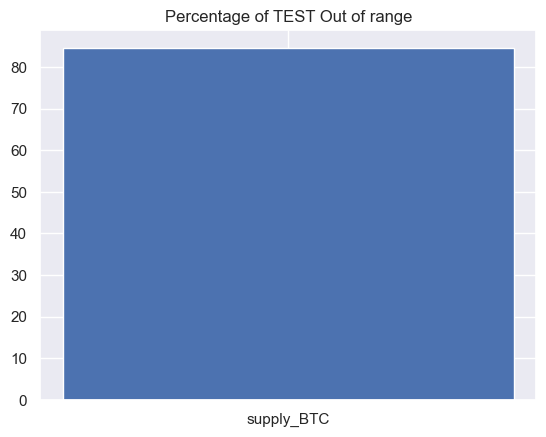

In [96]:
fig, ax = plt.subplots()
ax.bar(df_count_out.xs("pc_out_max").index.tolist(), df_count_out.xs("pc_out_max").values)
ax.bar(df_count_out.xs("pc_out_min").index.tolist(), -df_count_out.xs("pc_out_min").values)
ax.set_title("Percentage of TEST Out of range")

Text(0.5, 1.0, 'Features scaled boxplot')

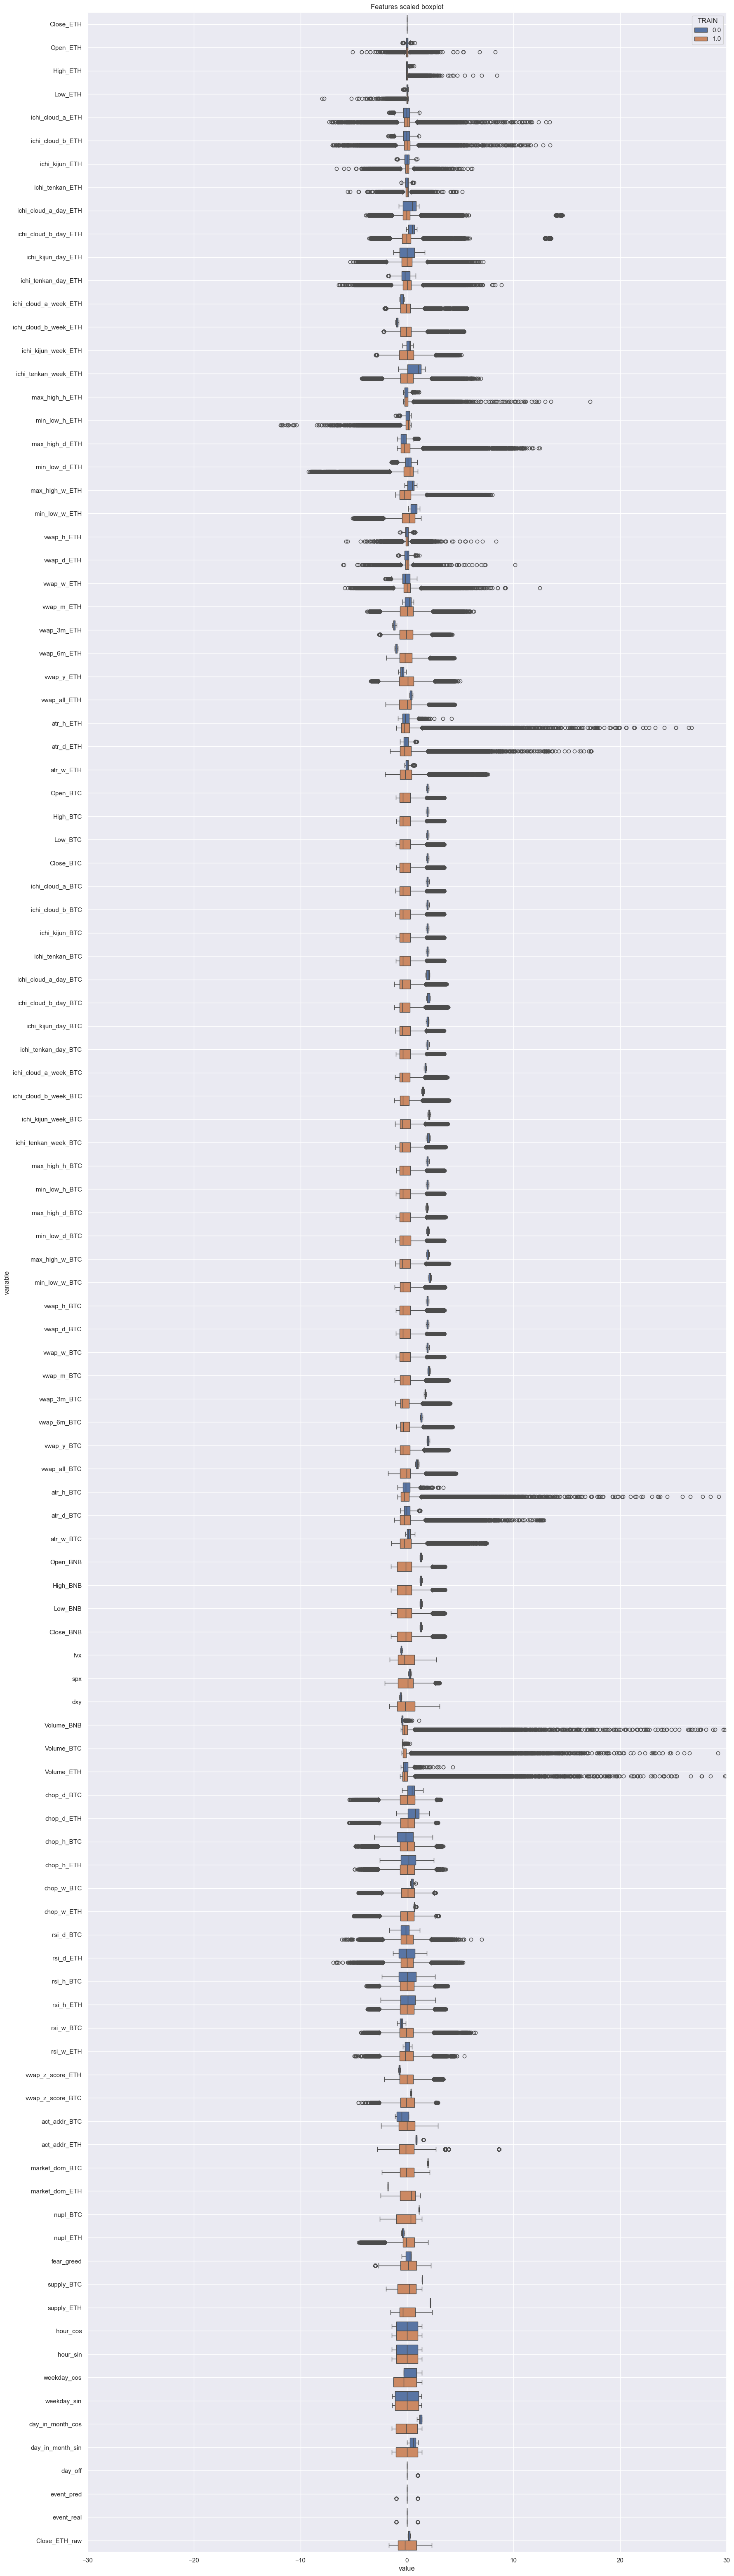

In [97]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

In [98]:
df_comp[(df_comp["TRAIN"] == True) & (df_comp["variable"] == "day_off")]["value"].unique()

array([0., 1.])

In [99]:
df_comp[(df_comp["TRAIN"] == True) & (df_comp["variable"] == "day_off")]["value"].unique()


array([0., 1.])

In [100]:
df_comp[(df_comp["TRAIN"] == False) & (df_comp["variable"] == "day_off")]["value"].unique()

array([0.])

<Axes: >

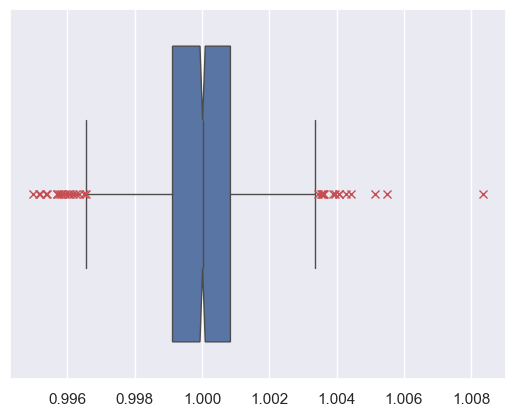

In [101]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_78415/4208190987.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


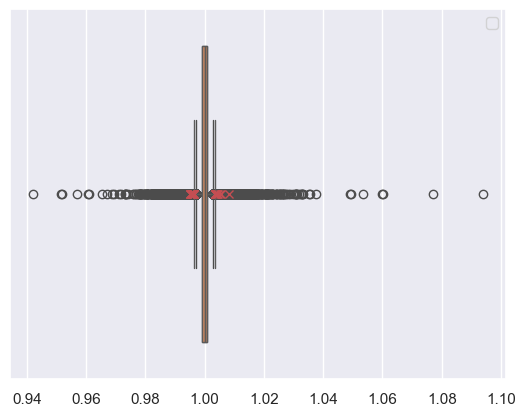

In [102]:
ax = sns.boxplot(
    x=X_train_dat[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

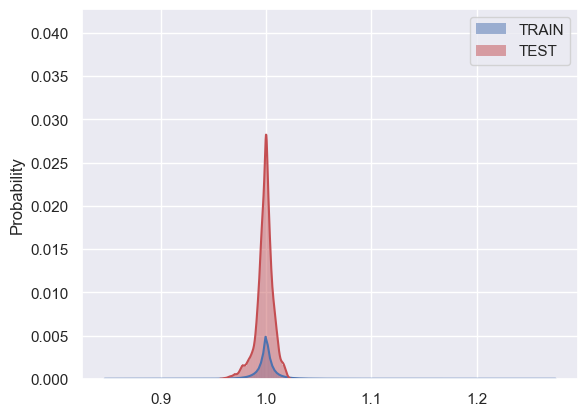

In [103]:

ax = sns.histplot(x=X_train_dat.reshape(-1, X_train_dat.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [104]:
def plot_hist_cat(x, data, title):
    '''
    Plot histogram count of categorical data 
    Add proportional information
    '''
    ser_val = data[x].value_counts(dropna=False)
    pc_val = ser_val.values / data[x].shape[0]

    sns.catplot(x=x, kind="count", palette="ch:.25", data=data, 
                height=5, 
                aspect=1.7,
                order=ser_val.index)
    fig = plt.gcf()
    ax = fig.gca()

    for K, y_val in enumerate(ser_val.values):
        ax.text(K, y_val, '{:.2f}'.format(pc_val[K]))
    
    ax.set_title(title)
    
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    return ser_val

def contingency_table(X, Y, data):
    '''
    Calculate Chi-2 heatmap into contingency table for 
    X event and Y event
    and p value of independance
    '''
    c = data[[X,Y]].pivot_table(index=X, columns=Y, aggfunc=len)

    c = c.fillna(0) # on remplace les valeurs nulles par des 0

    chi2, p, dof, expected = stats.chi2_contingency(c)

    return c, chi2, p, dof, expected



def plot_cont(X, Y, data, liste_cat=None):
    '''
    Calculate Chi-2 heatmap into contingency table for 
    X event and Y event
    '''
    c, chi2, p, dof, expected = contingency_table(X, Y, data)
    print("expected: ", expected)
    
    tx = data[X].value_counts()
    ty = data[Y].value_counts()
    
    cont = c.copy()
    cont.loc[:,"Total"] = tx
    cont.loc["total",:] = ty
    cont.loc["total","Total"] = len(data)
    
    print(cont)

    tx = pd.DataFrame(tx)
    ty = pd.DataFrame(ty)
    tx.columns = ["foo"]
    ty.columns = ["foo"]
    n = len(data)
    indep = tx.dot(ty.T) / n
    
    # calcul du signe (add-on)
    d_sign = (c-indep) / np.fabs(c-indep)
    
    mesure = d_sign * (c-indep)**2 / indep
    
    # patch sign
    xi_n = np.fabs(mesure).sum().sum()
    print("xi_n = ", xi_n)
    
    print("chi2: ", chi2)
    print("dof: ", dof)
    print("p: ", p)
    print(f"We have we have a {100*p:.4f}% chance for H0 to be true.")
    print("H0 : independance of distributions")
    print("H1 : distribution are not independant : we reject H0")
    # plot
    #print(c.shape)
    fig = plt.figure(figsize = (7/5*c.shape[1], 6/4*c.shape[0]))
    sns.heatmap(mesure/xi_n, annot=c, fmt=".0f", center=0)
    ax = fig.gca()
    ax.set_title(Y + "= f( " + X + ")")
    plt.show()
    
    return c

In [105]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None, size=25):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (size, size*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

### Linear Corr

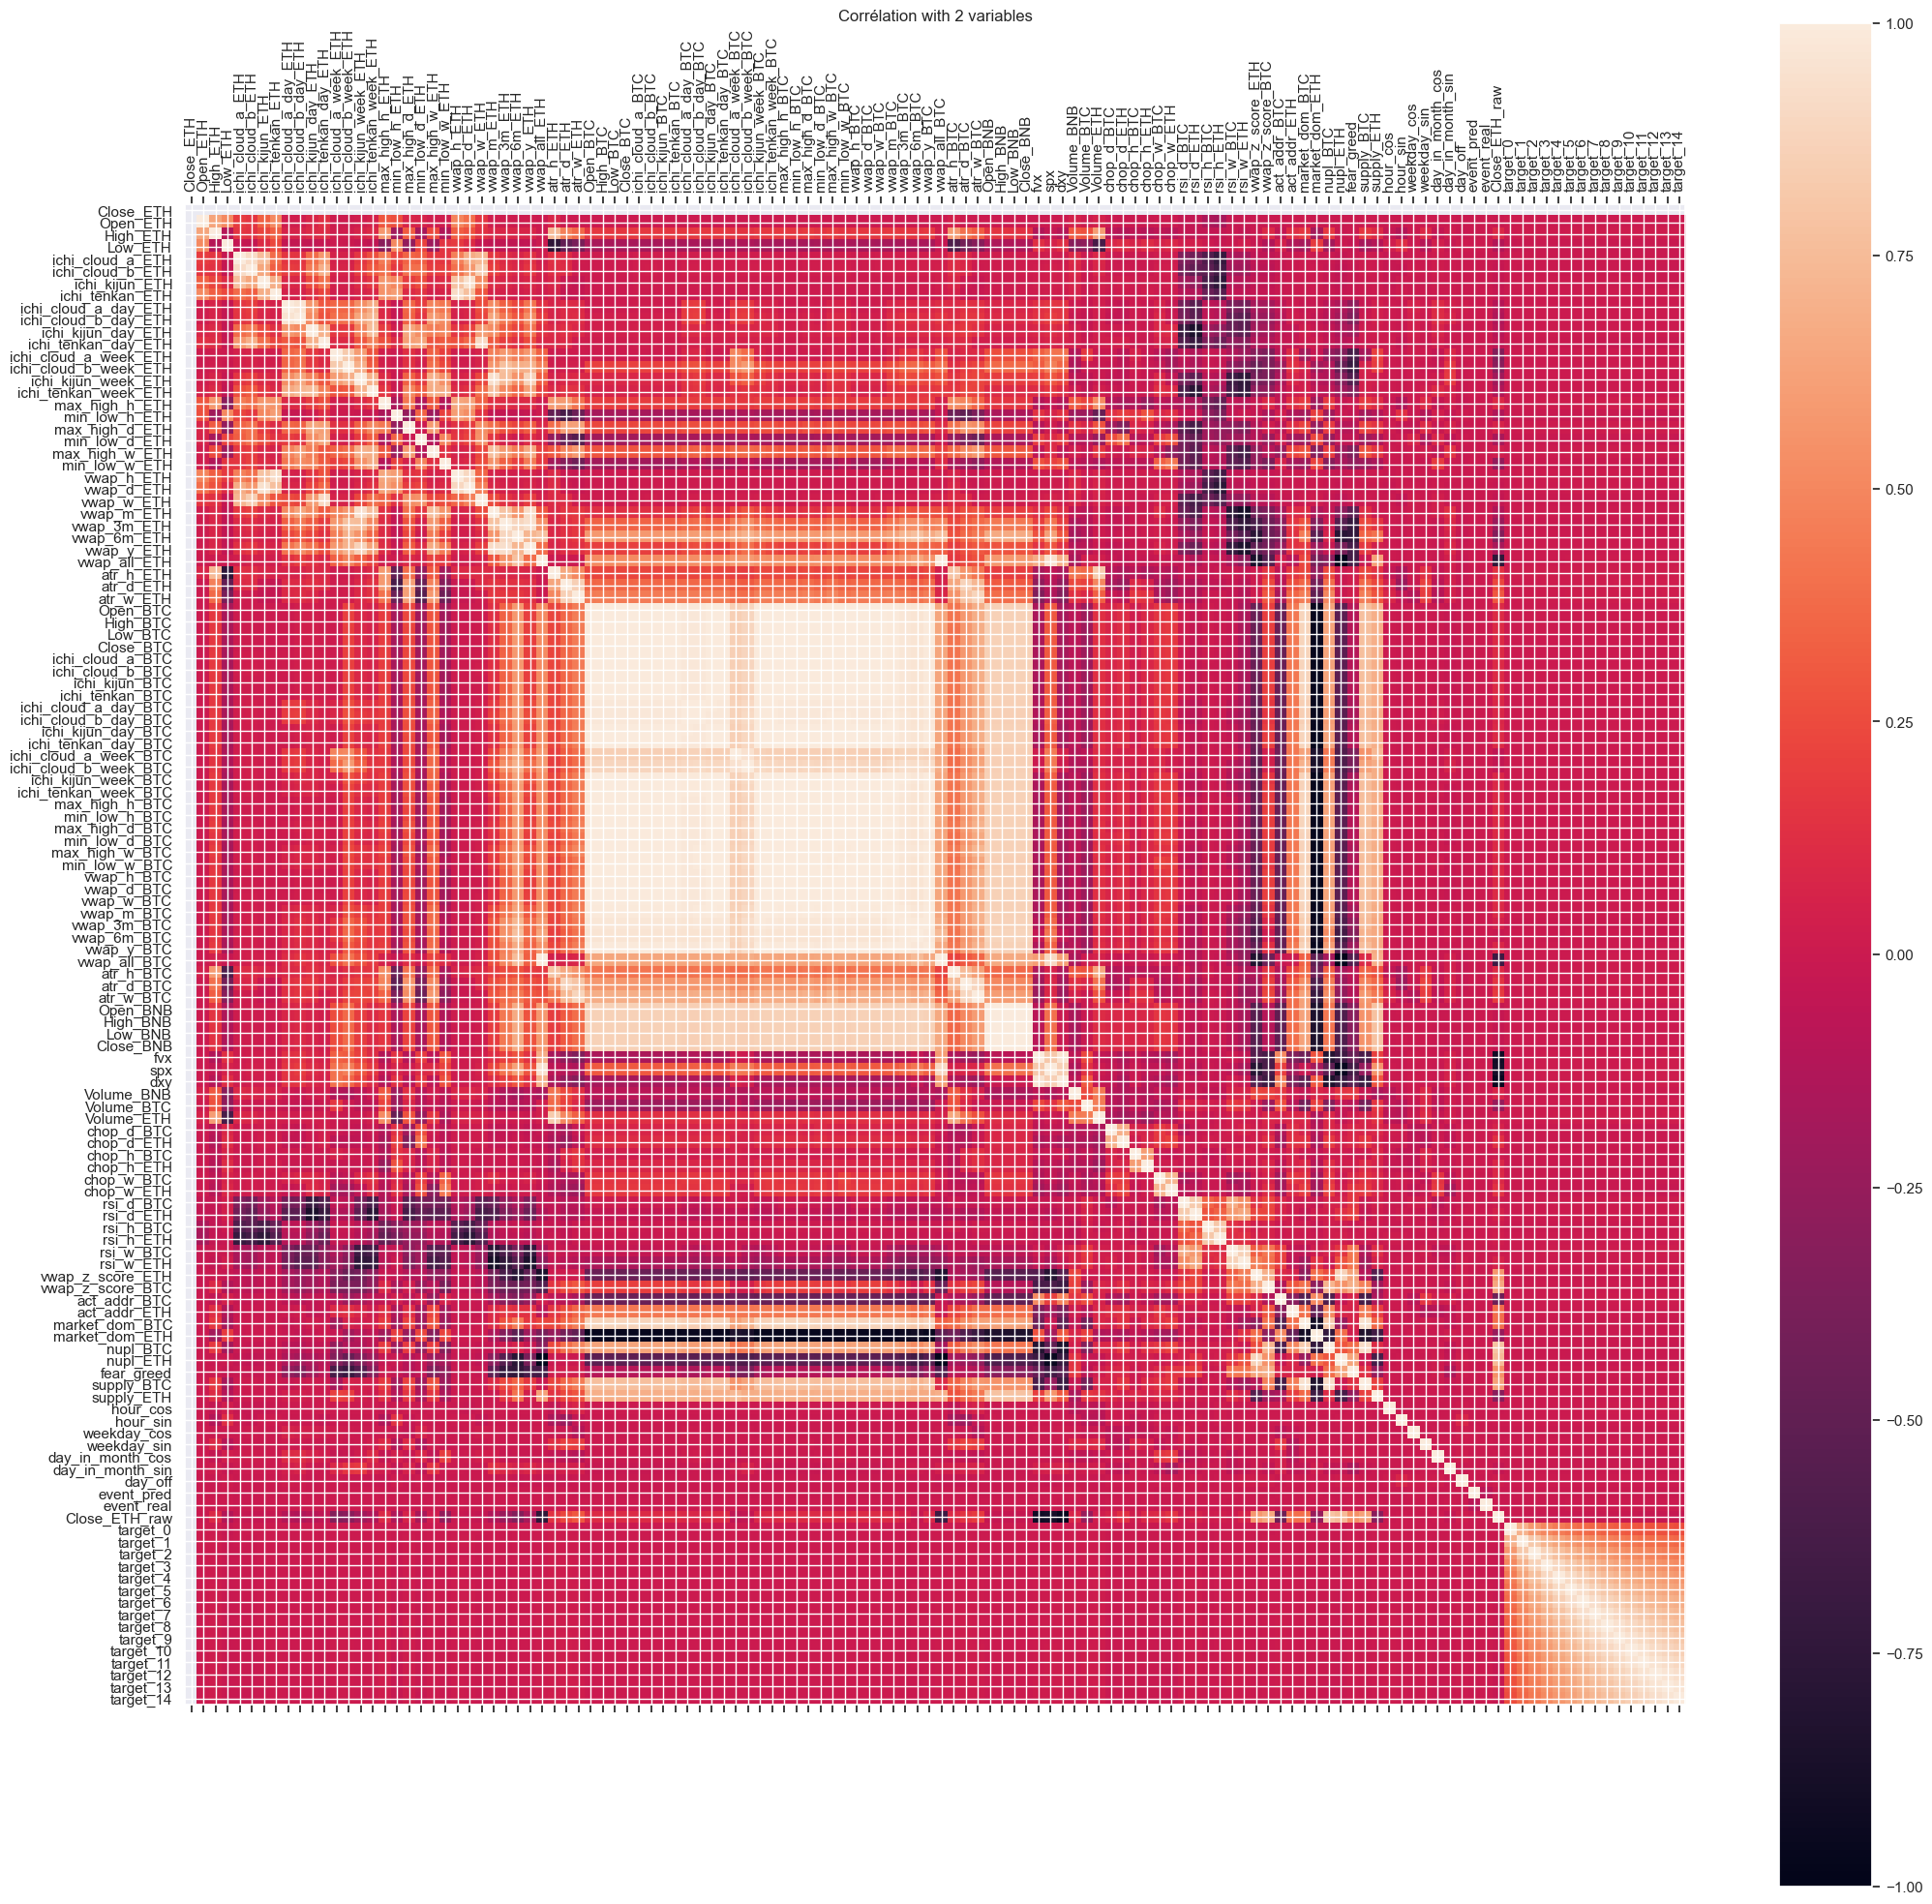

In [106]:
nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_dat[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


In [107]:
y_train.shape

(253677, 15)

In [108]:
list_col_corr

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'atr_h_ETH',
 'atr_d_ETH',
 'atr_w_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min

In [109]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'atr_h_ETH',
 'atr_d_ETH',
 'atr_w_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min

In [110]:
df.filter(list_col_select)

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0             1.0  0.999782  1.000109  0.999774          0.999171   
1             1.0  0.999548  1.000008  0.999540          0.998785   
2             1.0  1.000084  1.000193  0.999841          0.998860   
3             1.0  1.000770  1.000770  0.999900          0.999669   
4             1.0  0.999330  1.000025  0.999330          0.999178   
...           ...       ...       ...       ...               ...   
253672        1.0  0.998258  1.001698  0.997009          1.009059   
253673        1.0  0.998554  1.001387  0.998451          1.006895   
253674        1.0  1.004900  1.005056  0.999299          1.011829   
253675        1.0  1.001168  1.001491  0.997621          1.011492   
253676        1.0  1.012121  1.014171  0.998487          1.023400   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0               0.999736        0.998393         0.999464   
1               0.999276        0.998113         0.999184   
2               0.999351        0.998243         0.999477   
3               1.000113        0.999003         1.000239   
4               0.999443        0.998335         0.999569   
...                  ...             ...              ...   
253672          1.012239        1.000323         1.000559   
253673          1.010775        0.998877         0.999113   
253674          1.015728        1.003772         1.004009   
253675          1.015731        1.004944         1.003987   
253676          1.028043        1.011526         1.009147   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
0                   2.024261              2.017807  ...  2.588190e-01   
1                   2.023329              2.016878  ...  6.123234e-17   
2                   2.023482              2.017030  ...  6.123234e-17   
3                   2.025023              2.018567  ...  6.123234e-17   
4                   2.023668              2.017215  ...  6.123234e-17   
...                      ...                   ...  ...           ...   
253672              1.043299              1.026564  ...  9.659258e-01   
253673              1.041791              1.025079  ...  9.659258e-01   
253674              1.046896              1.030103  ...  9.659258e-01   
253675              1.048118              1.031306  ...  9.659258e-01   
253676              1.060823              1.043807  ...  9.659258e-01   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
0       0.965926     0.623490    -0.781832           0.97953   
1       1.000000     0.623490    -0.781832           0.97953   
2       1.000000     0.623490    -0.781832           0.97953   
3       1.000000     0.623490    -0.781832           0.97953   
4       1.000000     0.623490    -0.781832           0.97953   
...          ...          ...          ...               ...   
253672  0.258819    -0.222521    -0.974928           1.00000   
253673  0.258819    -0.222521    -0.974928           1.00000   
253674  0.258819    -0.222521    -0.974928           1.00000   
253675  0.258819    -0.222521    -0.974928           1.00000   
253676  0.258819    -0.222521    -0.974928           1.00000   

        day_in_month_sin  day_off  event_pred  event_real  Close_ETH_raw  
0           2.012985e-01      0.0         0.0         0.0    1194.540039  
1           2.012985e-01      0.0         0.0         0.0    1195.089966  
2           2.012985e-01      0.0         0.0         0.0    1195.000000  
3           2.012985e-01      0.0         0.0         0.0    1194.089966  
4           2.012985e-01      0.0         0.0         0.0    1194.890015  
...                  ...      ...         ...         ...            ...  
253672     -2.449294e-16      0.0         0.0         0.0    2520.719971  
253673     -2.449294e-16      0.0         0.0         0.0    2524.370117  
253674     -2.449294e-16      0.0         0.0         0.0    2512.060059  
253675     -2.449294e-16      0.0         0.0     

In [111]:
df.filter(list_col_targets)

target_0  target_1  target_2  target_3  target_4  target_5  target_6  \
0       1.000460  1.000385  0.999623  1.000293  0.999816  1.000050  0.999498   
1       0.999925  0.999163  0.999833  0.999356  0.999590  0.999038  0.999046   
2       0.999238  0.999908  0.999431  0.999665  0.999113  0.999121  0.999473   
3       1.000670  1.000193  1.000427  0.999874  0.999883  1.000234  1.000301   
4       0.999523  0.999757  0.999205  0.999213  0.999565  0.999632  0.999565   
...          ...       ...       ...       ...       ...       ...       ...   
253672  1.001448  0.996564  0.995402  0.983481  0.990876  0.990951  0.988297   
253673  0.995124  0.993963  0.982059  0.989443  0.989518  0.986868  0.986836   
253674  0.998834  0.986871  0.994292  0.994367  0.991704  0.991672  0.992440   
253675  0.988024  0.995453  0.995528  0.992862  0.992830  0.993599  0.991049   
253676  1.007519  1.007596  1.004897  1.004865  1.005643  1.003062  1.010629   

        target_7  target_8  target_9  target_10  target_11  target_12  \
0       0.999506  0.999858  0.999925   0.999858   1.000226   0.999891   
1       0.999398  0.999464  0.999398   0.999766   0.999431   0.999690   
2       0.999540  0.999473  0.999841   0.999506   0.999766   0.999473   
3       1.000234  1.000603  1.000268   1.000528   1.000234   0.999640   
4       0.999933  0.999598  0.999858   0.999565   0.998971   0.998686   
...          ...       ...       ...        ...        ...        ...   
253672  0.988265  0.989031  0.986492   0.993934   0.995977   0.997667   
253673  0.987601  0.985066  0.992497   0.994537   0.996225   0.993384   
253674  0.989893  0.997361  0.999411   1.001107   0.998252   0.997170   
253675  0.998525  1.000578  1.002276   0.999418   0.998334   0.994448   
253676  1.012706  1.014425  1.011533   1.010435   1.006502   1.009294   

        target_13  target_14  
0        1.000151   0.999858  
1        0.999398   0.998803  
2        0.998879   0.998594  
3        0.999355   1.000427  
4        0.999757   0.999732  
...           ...        ...  
253672   0.994823   0.993744  
253673   0.992307   0.988445  
253674   0.993288   0.996043  
253675   0.997206   0.995803  
253676   1.007874   1.007934  

[253677 rows x 15 columns]

In [112]:
df["Close_ETH_raw"].corr(df["target_14"])

np.float64(-0.01767952024837609)

In [113]:
df.filter(list_col_select).corrwith(df["target_14"])

/Users/gregory/miniforge3/envs/openbb_01/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/gregory/miniforge3/envs/openbb_01/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Close_ETH                NaN
Open_ETH            0.006258
High_ETH            0.021161
Low_ETH            -0.014519
ichi_cloud_a_ETH   -0.008137
                      ...   
day_in_month_sin   -0.001319
day_off             0.000980
event_pred         -0.002843
event_real          0.000742
Close_ETH_raw      -0.017680
Length: 109, dtype: float64

In [114]:
df.filter(list_col_select).corrwith(df.filter(list_col_targets))

Close_BNB          NaN
Close_BTC          NaN
Close_ETH          NaN
Close_ETH_raw      NaN
High_BNB           NaN
                    ..
vwap_y_ETH         NaN
vwap_z_score_BTC   NaN
vwap_z_score_ETH   NaN
weekday_cos        NaN
weekday_sin        NaN
Length: 124, dtype: float64

In [115]:
len(list_col_select)

109

In [116]:
nb_plot

109

In [117]:
# check if new  data in df_feat
# hash inputs
hash_correl_inputs = (
    get_data_hash(df_feat) + 
    get_data_hash(PAST_HISTORY) + 
    get_data_hash(FUTURE_TARGET) +
    get_data_hash(X_train_dat[:, 0, :nb_plot])
)
# load old file hash
path_correl_hash = os.path.join(path_data, 'correl_inputs_hash.txt')
hash_correl_inputs_old = load_hash(path_correl_hash)

# compare hash
if hash_correl_inputs == hash_correl_inputs_old:
    print("hash match: mode LOAD correl ")
    # load data output
    arr_corr_matrix_targets = np.load(path_arr_corr_matrix_targets)
    mode_correl = False
else:
    print("hash not match : mode REDO correl")
    mode_correl = True

hash match: mode LOAD correl 


In [118]:
hash_correl_inputs

'3b10ee1c51bb8a7c8da122d06d67d22cc039b3b478eede79fa9b63e7368c86798722616204217eddb39e7df969e0698aed8e599ba62ed2de1ce49b03ade0fedee629fa6598d732768f7c726b4b621285f9c3b85303900aa912017db7617d8bdb196cfe7a444bd4ac4a4adfd6d66eb71081fcf5cd3d99cb76fcc285a4dbd18c9e'

In [119]:
#mode_correl = True

In [120]:
# Assuming the following variables are pre-defined from your environment:
# PAST_HISTORY: int
# X_train_dat: np.ndarray (e.g., shape: num_samples, total_past_steps, num_total_features)
# y_train: np.ndarray (e.g., shape: num_samples, num_targets or num_samples for single target)
# list_col_select: list of strings (names of all features)
# nb_plot: int (number of features to use from X_train_dat, e.g., list_col_select[:nb_plot])
# list_col_targets: list of strings (names of target columns)
# list_col_corr: list of strings (from original code, not strictly needed for optimized version but was used for column naming in the old approach)
# These are the names of the feature columns we'll be selecting from X_train_dat.
# These will form the row index of our correlation matrix for each I_past.
feature_names_to_correlate = list_col_select[:nb_plot]

if mode_correl:
    # Optimized code for calculating correlations:
    list_corr_optimized = []
    # Create a DataFrame for the target(s) once, as it's constant across I_past iterations.
    # This assumes y_train has columns corresponding to list_col_targets.
    # If y_train is 1D (num_samples,), list_col_targets should contain one target name.
    y_train_df = pd.DataFrame(y_train, columns=list_col_targets)

    for I_past in range(PAST_HISTORY):
        # Extract the relevant feature data for the current I_past step
        # Shape: (num_samples, nb_plot)
        current_X_data = X_train_dat[:, I_past, :nb_plot]
        
        # Create a DataFrame for the features of the current I_past step
        df_features = pd.DataFrame(current_X_data, columns=feature_names_to_correlate)
        
        # Initialize a DataFrame to store correlations for this I_past step
        # Rows: features (feature_names_to_correlate)
        # Columns: targets (list_col_targets)
        # This ensures consistent shape and ordering.
        corr_matrix_for_this_past_step = pd.DataFrame(
            index=feature_names_to_correlate,
            columns=list_col_targets,
            dtype=float  # Ensure float type for correlations
        )
        
        # Calculate correlation of all features with each target column
        for target_col_name in list_col_targets:
            # df_features.corrwith() computes the correlation of each column in df_features
            # with the provided Series (y_train_df[target_col_name]).
            # The result is a Series indexed by feature_names_to_correlate.
            corrs_with_target = df_features.corrwith(y_train_df[target_col_name])
            corr_matrix_for_this_past_step[target_col_name] = corrs_with_target
                
        list_corr_optimized.append(corr_matrix_for_this_past_step)

    # Convert the list of DataFrames to a 3D NumPy array
    # Each DataFrame in list_corr_optimized has shape (len_feat, len_targets)
    # So, arr_corr_matrix_targets will have shape (PAST_HISTORY, len_feat, len_targets)
    # The final variable name 'arr_corr_matrix_targets' matches the original script's output.
    arr_corr_matrix_targets = np.array([df.values for df in list_corr_optimized])
    np.save(path_arr_corr_matrix_targets, arr_corr_matrix_targets)
    # save hash
    with open(path_correl_hash, 'w') as file:
        file.write(hash_correl_inputs)
        
# To check the shape (optional, similar to original script's last line intent):
print(arr_corr_matrix_targets.shape)

(72, 109, 15)


In [121]:
min_corr = np.min(arr_corr_matrix_targets, axis=0)
# create a same col/row than corr_matrix_targets  dataframe using the array max_corr 
min_corr_matrix_targets = pd.DataFrame(min_corr, columns=list_col_targets, index=feature_names_to_correlate)
min_corr_matrix_targets

target_0  target_1  target_2  target_3  target_4  target_5  \
Close_ETH              NaN       NaN       NaN       NaN       NaN       NaN   
Open_ETH         -0.001701 -0.002949 -0.004338 -0.004786 -0.005536 -0.006069   
High_ETH         -0.000797 -0.002178 -0.003831 -0.004392 -0.004896 -0.005219   
Low_ETH          -0.016817 -0.009355 -0.013130 -0.010434 -0.012921 -0.014196   
ichi_cloud_a_ETH -0.001333 -0.002698 -0.004206 -0.004785 -0.005420 -0.005741   
...                    ...       ...       ...       ...       ...       ...   
day_in_month_sin -0.000398 -0.000557 -0.000692 -0.000797 -0.000877 -0.000949   
day_off          -0.001658 -0.001925 -0.002138 -0.002449 -0.002720 -0.002928   
event_pred       -0.007535 -0.007502 -0.007099 -0.006575 -0.007400 -0.007414   
event_real       -0.006934 -0.005017 -0.006066 -0.006793 -0.007159 -0.006455   
Close_ETH_raw    -0.004679 -0.006619 -0.008133 -0.009389 -0.010496 -0.011500   

                  target_6  target_7  target_8  target_9  target_10  \
Close_ETH              NaN       NaN       NaN       NaN        NaN   
Open_ETH         -0.006341 -0.006946 -0.007559 -0.008070  -0.008769   
High_ETH         -0.005530 -0.006099 -0.006690 -0.007125  -0.007764   
Low_ETH          -0.012469 -0.012652 -0.013120 -0.012089  -0.012053   
ichi_cloud_a_ETH -0.006049 -0.006704 -0.007392 -0.007962  -0.008725   
...                    ...       ...       ...       ...        ...   
day_in_month_sin -0.001011 -0.001072 -0.001131 -0.001170  -0.001207   
day_off          -0.002984 -0.003063 -0.003417 -0.003756  -0.004137   
event_pred       -0.008150 -0.008197 -0.007157 -0.007306  -0.006725   
event_real       -0.006324 -0.005582 -0.005122 -0.005386  -0.005777   
Close_ETH_raw    -0.012413 -0.013273 -0.014083 -0.014851  -0.015591   

                  target_11  target_12  target_13  target_14  
Close_ETH               NaN        NaN        NaN        NaN  
Open_ETH          -0.009670  -0.010539  -0.011152  -0.011719  
High_ETH          -0.008598  -0.009396  -0.010045  -0.010533  
Low_ETH           -0.012555  -0.013287  -0.014501  -0.014519  
ichi_cloud_a_ETH  -0.009675  -0.010512  -0.011161  -0.011769  
...                     ...        ...        ...        ...  
day_in_month_sin  -0.001238  -0.001268  -0.001295  -0.001330  
day_off           -0.004513  -0.004813  -0.004936  -0.004976  
event_pred        -0.006705  -0.006893  -0.006448  -0.006236  
event_real        -0.005484  -0.005540  -0.005085  -0.005007  
Close_ETH_raw     -0.016306  -0.016993  -0.017642  -0.018262  

[109 rows x 15 columns]

In [122]:
max_corr = np.max(arr_corr_matrix_targets, axis=0)
# create a same col/row thatn corr_matrix_targets  dataframe using the array max_corr 
max_corr_matrix_targets = pd.DataFrame(max_corr, columns=list_col_targets, index=feature_names_to_correlate)
max_corr_matrix_targets

target_0  target_1  target_2  target_3  target_4  target_5  \
Close_ETH              NaN       NaN       NaN       NaN       NaN       NaN   
Open_ETH          0.012652  0.012706  0.007384  0.008588  0.009448  0.010770   
High_ETH          0.014405  0.018180  0.013382  0.014009  0.015279  0.018274   
Low_ETH           0.009441  0.007320  0.005701  0.006453  0.007151  0.007921   
ichi_cloud_a_ETH  0.001506  0.000691 -0.000851 -0.001260 -0.001769 -0.002025   
...                    ...       ...       ...       ...       ...       ...   
day_in_month_sin -0.000037 -0.000059 -0.000090 -0.000110 -0.000128 -0.000139   
day_off           0.004958  0.006637  0.008144  0.009304  0.010308  0.011129   
event_pred        0.006938  0.005788  0.004485  0.004810  0.004764  0.005232   
event_real        0.011923  0.007592  0.006667  0.005395  0.004392  0.004200   
Close_ETH_raw    -0.004416 -0.006272 -0.007722 -0.008909 -0.009972 -0.010923   

                  target_6  target_7  target_8  target_9  target_10  \
Close_ETH              NaN       NaN       NaN       NaN        NaN   
Open_ETH          0.011687  0.012110  0.012257  0.012759   0.012753   
High_ETH          0.017810  0.018056  0.017313  0.018760   0.019101   
Low_ETH           0.008671  0.008909  0.008904  0.009035   0.008812   
ichi_cloud_a_ETH -0.002226 -0.003052 -0.003963 -0.004472  -0.005133   
...                    ...       ...       ...       ...        ...   
day_in_month_sin -0.000152 -0.000167 -0.000178 -0.000191  -0.000202   
day_off           0.011804  0.012297  0.012856  0.013461   0.014119   
event_pred        0.005445  0.004738  0.004550  0.004258   0.003870   
event_real        0.003522  0.003433  0.003092  0.002819   0.003152   
Close_ETH_raw    -0.011811 -0.012650 -0.013433 -0.014165  -0.014874   

                  target_11  target_12  target_13  target_14  
Close_ETH               NaN        NaN        NaN        NaN  
Open_ETH           0.011976   0.011651   0.011450   0.011046  
High_ETH           0.019312   0.019143   0.019121   0.021161  
Low_ETH            0.007964   0.007265   0.006881   0.006597  
ichi_cloud_a_ETH  -0.006133  -0.006962  -0.007598  -0.008137  
...                     ...        ...        ...        ...  
day_in_month_sin  -0.000216  -0.000219  -0.000213  -0.000205  
day_off            0.014685   0.015103   0.015379   0.015643  
event_pred         0.003168   0.003361   0.003661   0.003109  
event_real         0.002568   0.003172   0.002769   0.002828  
Close_ETH_raw     -0.015564  -0.016217  -0.016848  -0.017458  

[109 rows x 15 columns]

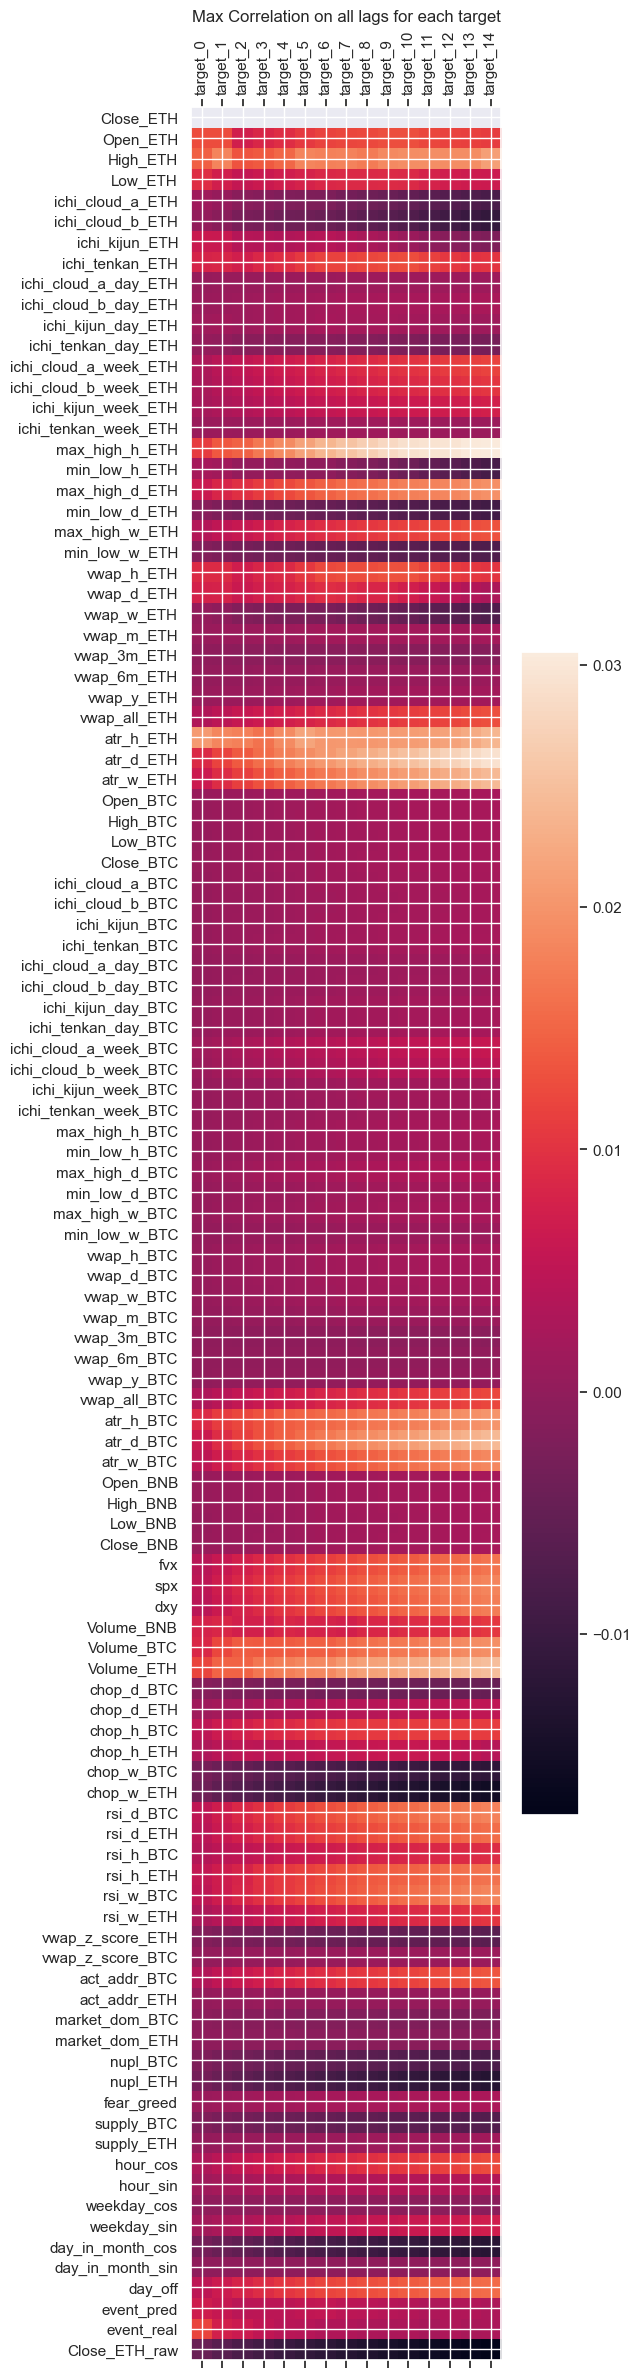

In [123]:
#corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(max_corr_matrix_targets, title = "Max Correlation on all lags for each target", size=5)

In [124]:
arr_corr_matrix_targets.shape

(72, 109, 15)

In [125]:

# create a same col/row thatn corr_matrix_targets  dataframe using the array max_corr 
corr_matrix_targets = pd.DataFrame(arr_corr_matrix_targets[-1,:,:], columns=list_col_targets, index=feature_names_to_correlate)
corr_matrix_targets

target_0  target_1  target_2  target_3  target_4  target_5  \
Close_ETH              NaN       NaN       NaN       NaN       NaN       NaN   
Open_ETH          0.009073  0.012706  0.005011  0.005306  0.003014  0.002964   
High_ETH          0.014071  0.018180  0.013382  0.014009  0.015279  0.018274   
Low_ETH          -0.016817 -0.009355 -0.013130 -0.010434 -0.012921 -0.014196   
ichi_cloud_a_ETH  0.001506  0.000691 -0.000851 -0.001260 -0.001769 -0.002025   
...                    ...       ...       ...       ...       ...       ...   
day_in_month_sin -0.000296 -0.000423 -0.000544 -0.000668 -0.000773 -0.000863   
day_off           0.001504  0.001980  0.002029  0.002108  0.002348  0.002265   
event_pred       -0.001765 -0.002056 -0.004927 -0.006495 -0.006435 -0.004693   
event_real       -0.000192 -0.000444 -0.000892 -0.000309 -0.000999  0.001766   
Close_ETH_raw    -0.004584 -0.006471 -0.007914 -0.009142 -0.010221 -0.011200   

                  target_6  target_7  target_8  target_9  target_10  \
Close_ETH              NaN       NaN       NaN       NaN        NaN   
Open_ETH          0.005411  0.006158  0.005031  0.005796   0.007312   
High_ETH          0.017810  0.018056  0.017313  0.018760   0.019101   
Low_ETH          -0.012469 -0.012652 -0.013120 -0.012089  -0.012053   
ichi_cloud_a_ETH -0.002226 -0.003052 -0.003963 -0.004472  -0.005133   
...                    ...       ...       ...       ...        ...   
day_in_month_sin -0.000939 -0.001006 -0.001069 -0.001122  -0.001173   
day_off           0.002448  0.002551  0.002508  0.002349   0.002198   
event_pred       -0.005406 -0.006106 -0.004600 -0.004791  -0.004072   
event_real        0.002126  0.000963  0.001933  0.001213   0.000671   
Close_ETH_raw    -0.012098 -0.012931 -0.013712 -0.014452  -0.015153   

                  target_11  target_12  target_13  target_14  
Close_ETH               NaN        NaN        NaN        NaN  
Open_ETH           0.006586   0.005397   0.005068   0.006258  
High_ETH           0.019312   0.019143   0.019121   0.021161  
Low_ETH           -0.012555  -0.013287  -0.014501  -0.014519  
ichi_cloud_a_ETH  -0.006133  -0.006962  -0.007598  -0.008137  
...                     ...        ...        ...        ...  
day_in_month_sin  -0.001227  -0.001266  -0.001291  -0.001319  
day_off            0.002044   0.001500   0.001213   0.000980  
event_pred        -0.003568  -0.003976  -0.004773  -0.002843  
event_real         0.000769   0.001015   0.000718   0.000742  
Close_ETH_raw     -0.015822  -0.016463  -0.017082  -0.017680  

[109 rows x 15 columns]

#### Best Max Corr Features

In [126]:
# (72, 103, 15)
ind = np.unravel_index(
    np.argsort(np.nan_to_num(arr_corr_matrix_targets, nan=0.0), axis=None), 
    arr_corr_matrix_targets.shape,
)
# 30th first features
nb_lag_corr_max = 50
# for lag_curr, feat_curr, target_curr in zip(ind[0][-nb_lag_corr_max:], ind[1][-nb_lag_corr_max:], ind[2][-nb_lag_corr_max:]): #ind[0][-30:]
    
#     corr_curr = arr_corr_matrix_targets[lag_curr, feat_curr, target_curr]
#     print(f"{feature_names_to_correlate[feat_curr]}, lag: {lag_curr}, target: {target_curr}, corr: {corr_curr}")

# 1. Get the slices of your indices
lags = ind[0][-nb_lag_corr_max:]
feature_indices = ind[1][-nb_lag_corr_max:]
target_indices = ind[2][-nb_lag_corr_max:]

# 2. Create the DataFrame from a dictionary of lists
corr_max_df_efficient = pd.DataFrame({
    'Feature': [feature_names_to_correlate[i] for i in feature_indices],
    'Lag': lags,
    'Target': target_indices,
    'Correlation': [arr_corr_matrix_targets[lag, feat, targ] for lag, feat, targ in zip(lags, feature_indices, target_indices)]
})

corr_max_df_efficient.sort_values(by='Correlation', ascending=False)


Feature  Lag  Target  Correlation
49  max_high_h_ETH   71      14     0.030522
48  max_high_h_ETH   71      13     0.030174
47  max_high_h_ETH   71      12     0.029767
46  max_high_h_ETH   71      11     0.029400
45  max_high_h_ETH   70      14     0.029298
44       atr_d_ETH   71      14     0.029270
43  max_high_h_ETH   70      13     0.029242
42  max_high_h_ETH   71      10     0.029076
41  max_high_h_ETH   70      11     0.028983
40  max_high_h_ETH   70      12     0.028974
39       atr_d_ETH   70      14     0.028877
38  max_high_h_ETH   70      10     0.028848
37       atr_d_ETH   69      14     0.028809
36       atr_d_ETH   68      14     0.028627
35       atr_d_ETH   67      14     0.028425
34       atr_d_ETH   71      13     0.028354
33  max_high_h_ETH   71       9     0.028178
32       atr_d_ETH   66      14     0.028178
31  max_high_h_ETH   69      10     0.028046
30       atr_d_ETH   70      13     0.028017
29  max_high_h_ETH   70       9     0.028008
28       atr_d_ETH   65      14     0.027985
27       atr_d_ETH   69      13     0.027905
26  max_high_h_ETH   69      11     0.027851
25       atr_d_ETH   64      14     0.027847
24       atr_d_ETH   68      13     0.027834
23  max_high_h_ETH   69      13     0.027758
22  max_high_h_ETH   69      12     0.027752
21       atr_d_ETH   63      14     0.027664
20       atr_d_ETH   67      13     0.027648
19  max_high_h_ETH   69      14     0.027621
18       atr_d_ETH   62      14     0.027490
17  max_high_h_ETH   69       9     0.027400
16       atr_d_ETH   66      13     0.027376
15       atr_d_ETH   71      12     0.027351
14       atr_d_ETH   61      14     0.027328
13       atr_d_ETH   65      13     0.027217
12       atr_d_ETH   60      14     0.027176
11       atr_d_ETH   64      13     0.027143
10       atr_d_ETH   70      12     0.027027
9   max_high_h_ETH   68      10     0.027013
8        atr_d_ETH   69      12     0.026983
7        atr_d_ETH   59      14     0.026956
6        atr_d_ETH   63      13     0.026919
5        atr_d_ETH   68      12     0.026868
4   max_high_h_ETH   70       8     0.026849
3        atr_d_ETH   67      12     0.026799
2        atr_d_ETH   47      14     0.026759
1        atr_d_ETH   46      14     0.026746
0   max_high_h_ETH   68      11     0.026744

max_high_h_ETH & Volume_ETH are the best positive impact on price.  
Explanation : 
- have a high higher in the last hour lead to have more chance to have a higher value in the next hour
- volume also  

Direction is kept 


#### Best Min Corr Features

In [127]:
# 1. Get the slices of your indices
lags = ind[0][0:nb_lag_corr_max]
feature_indices = ind[1][0:nb_lag_corr_max]
target_indices = ind[2][0:nb_lag_corr_max]

# 2. Create the DataFrame from a dictionary of lists
corr_min_df_efficient = pd.DataFrame({
    'Feature': [feature_names_to_correlate[i] for i in feature_indices],
    'Lag': lags,
    'Target': target_indices,
    'Correlation': [arr_corr_matrix_targets[lag, feat, targ] for lag, feat, targ in zip(lags, feature_indices, target_indices)]
})

corr_min_df_efficient.sort_values(by='Correlation', ascending=True)

Feature  Lag  Target  Correlation
0   min_low_h_ETH   71      14    -0.021244
1   min_low_h_ETH   71      13    -0.020220
2   min_low_h_ETH   71      12    -0.018750
3   Close_ETH_raw    3      14    -0.018262
4   Close_ETH_raw    2      14    -0.018259
5   Close_ETH_raw    4      14    -0.018252
6   Close_ETH_raw    1      14    -0.018243
7   Close_ETH_raw    5      14    -0.018236
8   Close_ETH_raw    0      14    -0.018228
9   Close_ETH_raw    6      14    -0.018221
10  Close_ETH_raw    7      14    -0.018218
11  Close_ETH_raw    8      14    -0.018209
12  Close_ETH_raw    9      14    -0.018192
13  Close_ETH_raw   10      14    -0.018182
14  Close_ETH_raw   11      14    -0.018169
15  Close_ETH_raw   12      14    -0.018147
16  Close_ETH_raw   13      14    -0.018131
17  Close_ETH_raw   14      14    -0.018124
18  Close_ETH_raw   15      14    -0.018117
19  Close_ETH_raw   16      14    -0.018103
20  Close_ETH_raw   21      14    -0.018085
21  Close_ETH_raw   20      14    -0.018081
22  Close_ETH_raw   19      14    -0.018079
23  Close_ETH_raw   17      14    -0.018078
24  Close_ETH_raw   18      14    -0.018077
25  Close_ETH_raw   22      14    -0.018069
26  Close_ETH_raw   23      14    -0.018063
27  Close_ETH_raw   24      14    -0.018063
28  Close_ETH_raw   25      14    -0.018049
29  Close_ETH_raw   26      14    -0.018040
30  Close_ETH_raw   27      14    -0.018031
31  Close_ETH_raw   28      14    -0.018014
32  Close_ETH_raw   29      14    -0.018000
33  Close_ETH_raw   30      14    -0.017974
34  min_low_h_ETH   70      14    -0.017965
35  Close_ETH_raw   31      14    -0.017955
36  Close_ETH_raw   32      14    -0.017949
37  Close_ETH_raw   33      14    -0.017933
38  Close_ETH_raw   34      14    -0.017925
39  Close_ETH_raw   35      14    -0.017909
40  Close_ETH_raw   37      14    -0.017894
41  Close_ETH_raw   40      14    -0.017894
42  Close_ETH_raw   36      14    -0.017894
43  Close_ETH_raw   39      14    -0.017890
44  Close_ETH_raw   41      14    -0.017889
45  Close_ETH_raw   38      14    -0.017889
46  Close_ETH_raw   42      14    -0.017888
47  Close_ETH_raw   43      14    -0.017883
48  Close_ETH_raw   46      14    -0.017879
49  Close_ETH_raw   45      14    -0.017877

In [128]:
np.nanmin(arr_corr_matrix_targets)

np.float64(-0.02124448282696438)

min_low_h_ETH & Close_ETH_raw are the best negative impact on price.  
Explanation : 
- have a min low higher in the last hour lead to have more chance to have a lower value in the next hour : direction kept
- have a price higher, so return to mean value


#### Last Lag Max Correlation

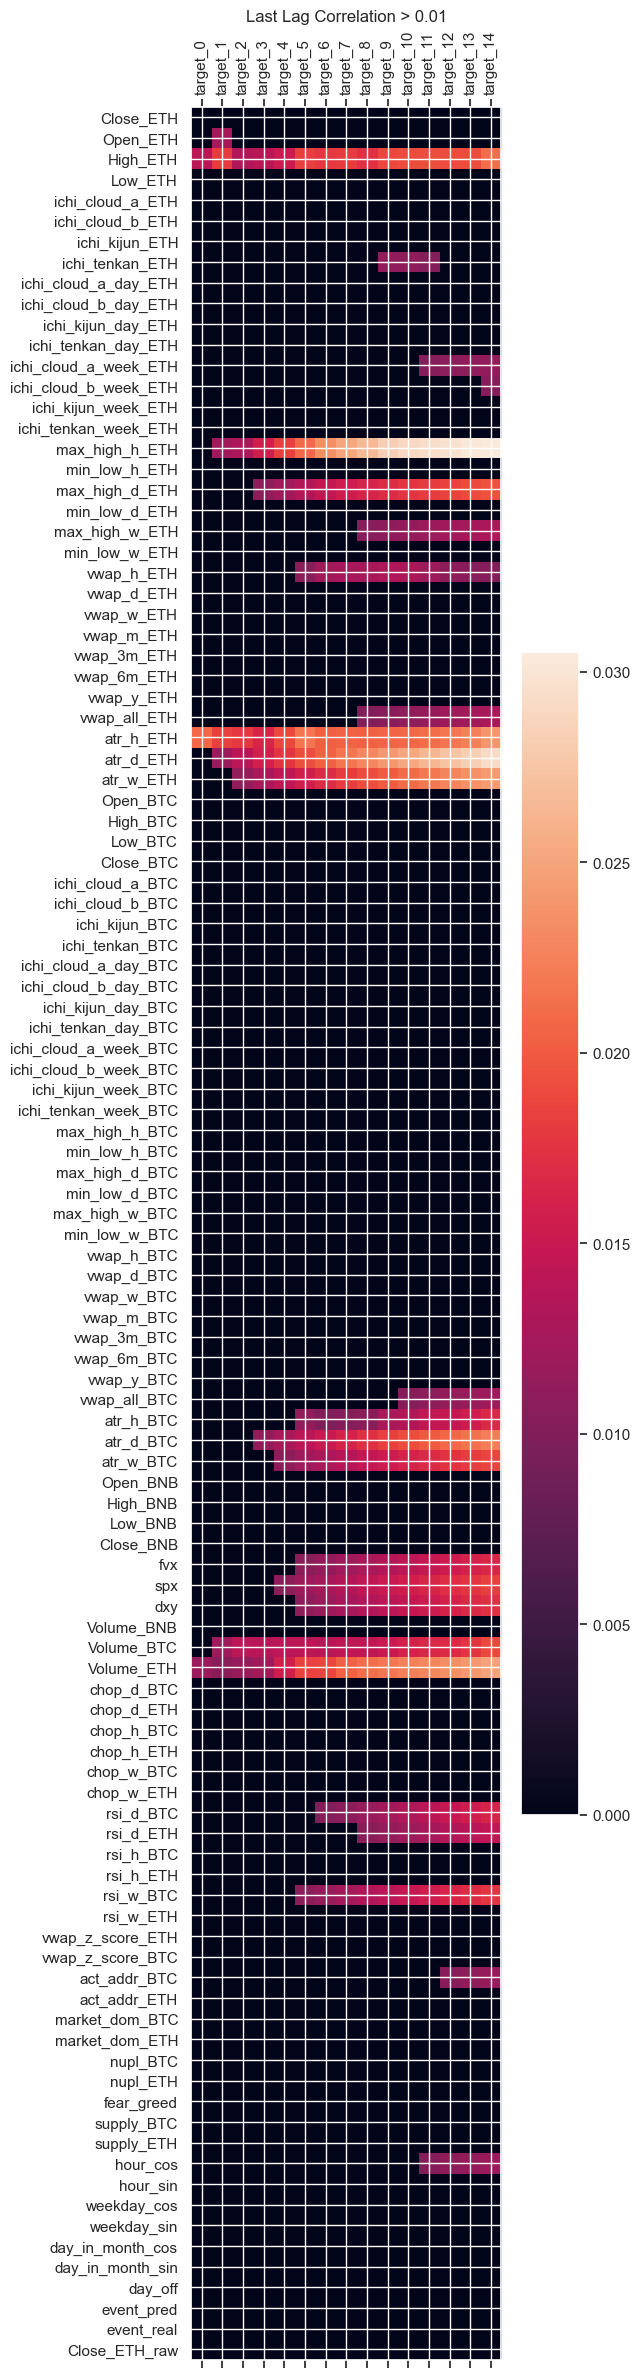

In [129]:
fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets>0.01, 0), 
    title = "Last Lag Correlation > 0.01", 
    size=5)

#### Max Correlation on all lags

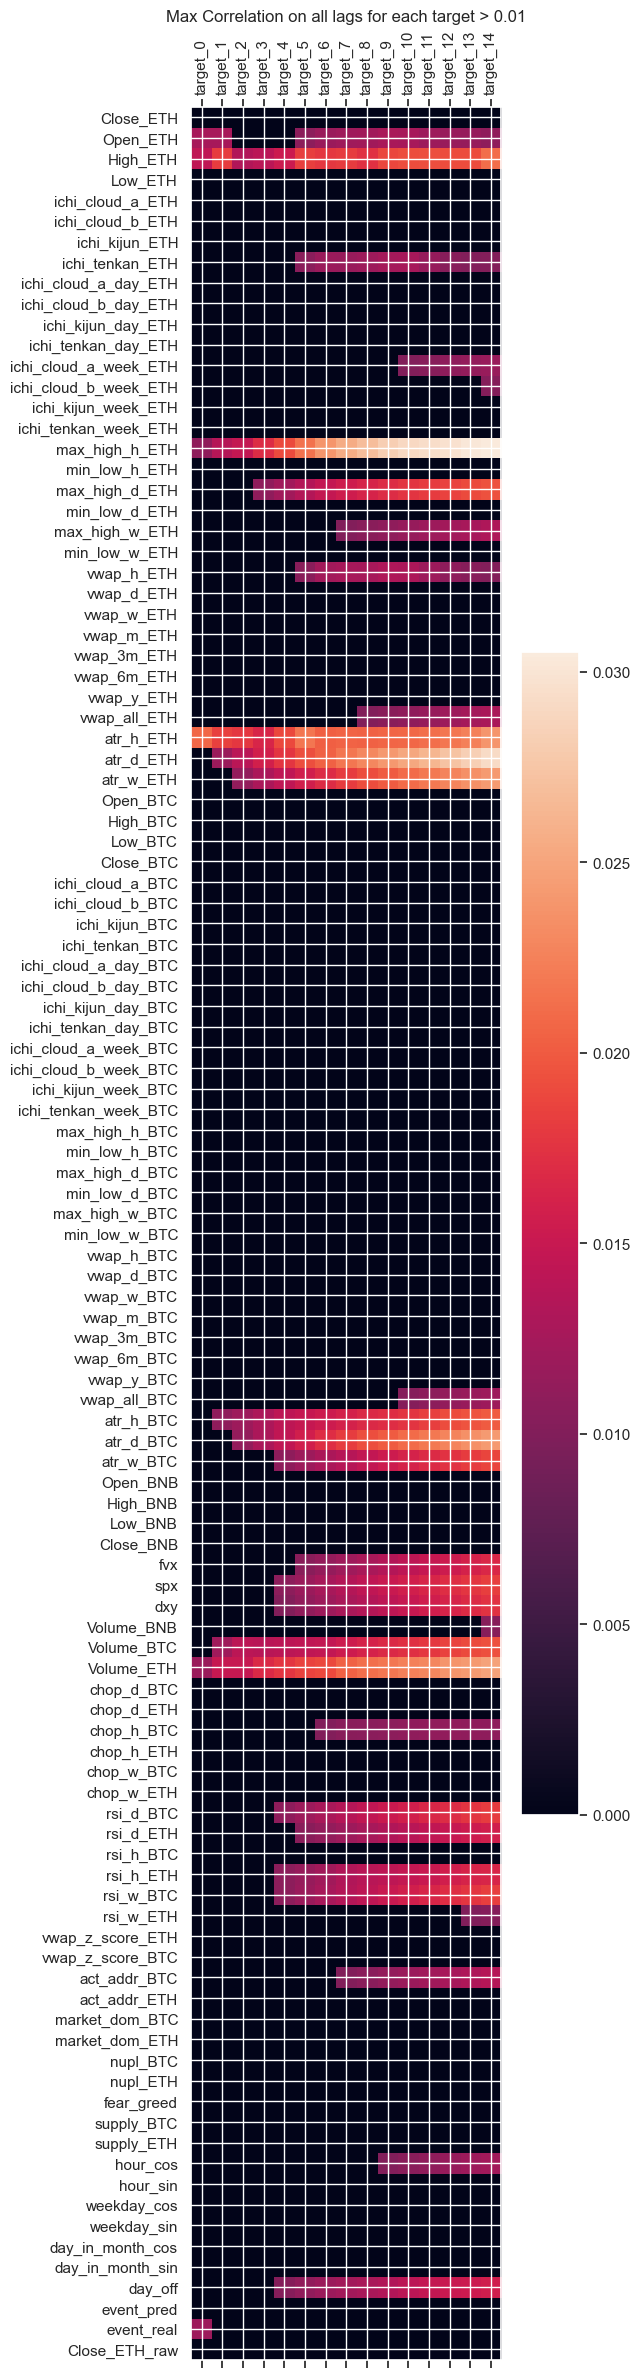

In [130]:
fig = plot_corr(
    max_corr_matrix_targets.where(max_corr_matrix_targets>0.01, 0),
    title="Max Correlation on all lags for each target > 0.01",
    size=5)

<Axes: >

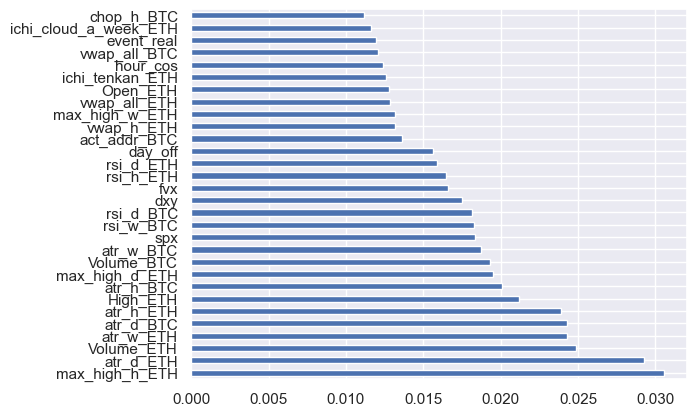

In [131]:
max_max_corr = max_corr_matrix_targets.max(axis=1).sort_values(ascending=False)
max_max_corr[max_max_corr.values>0.011].plot.barh()

#### Test on the highest corr


In [132]:
df = pd.DataFrame(np.hstack((X_train_dat[:, -1, :nb_plot], y_train)), 
        columns=list_col_corr)

In [133]:
df["target_cat"] = "neutral"
df.loc[df["target_14"] >= 1 + 0.5/100, "target_cat"] = "up"
df.loc[df["target_14"] <= 1 - 0.5/100, "target_cat"] = "down"
df["target_cat"].value_counts()

target_cat
neutral    181927
up          36606
down        35144
Name: count, dtype: int64

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_78415/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


target_cat
neutral    181927
up          36606
down        35144
Name: count, dtype: int64

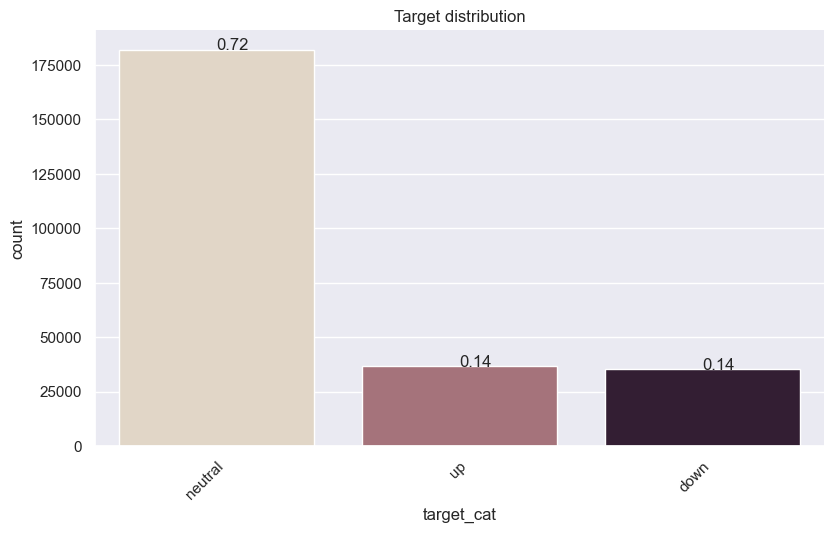

In [134]:
plot_hist_cat("target_cat", df, "Target distribution")

In [135]:
list_level=["neutral", "higher", "very-higher"]
df["max_high_h_ETH_cat"] = "very-higher"
df.loc[df["max_high_h_ETH"] <= 1.01, "max_high_h_ETH_cat"] = "higher"
df.loc[df["max_high_h_ETH"] <= 1.005, "max_high_h_ETH_cat"] = "neutral"

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_78415/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


max_high_h_ETH_cat
neutral        179399
higher          50855
very-higher     23423
Name: count, dtype: int64

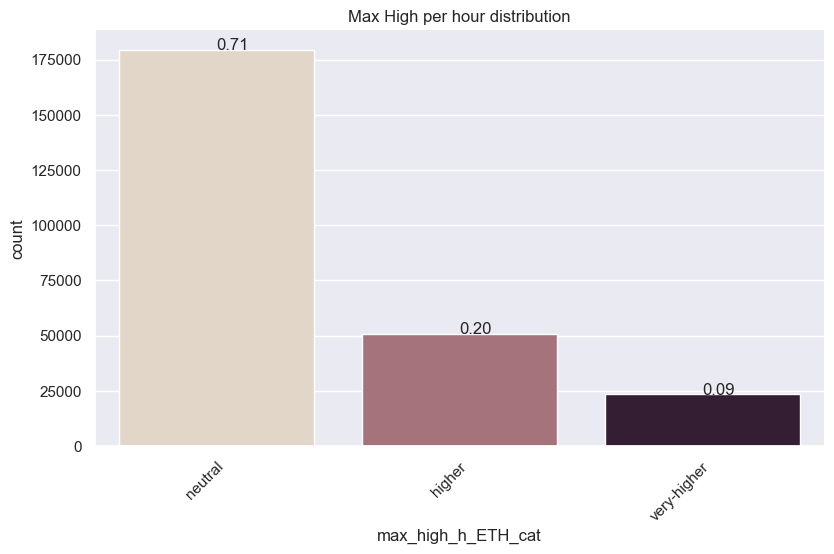

In [136]:
plot_hist_cat("max_high_h_ETH_cat", df, "Max High per hour distribution")

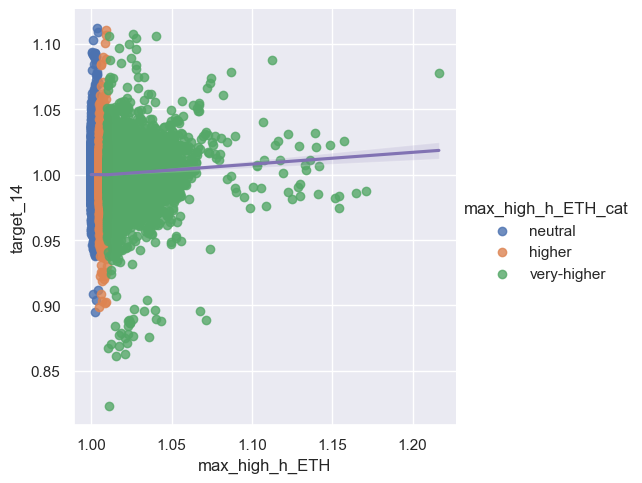

In [137]:
sns.lmplot(x="max_high_h_ETH", y="target_14",
            hue="max_high_h_ETH_cat", data=df,
           line_kws={"color": "C4"})

(0.98, 1.02)

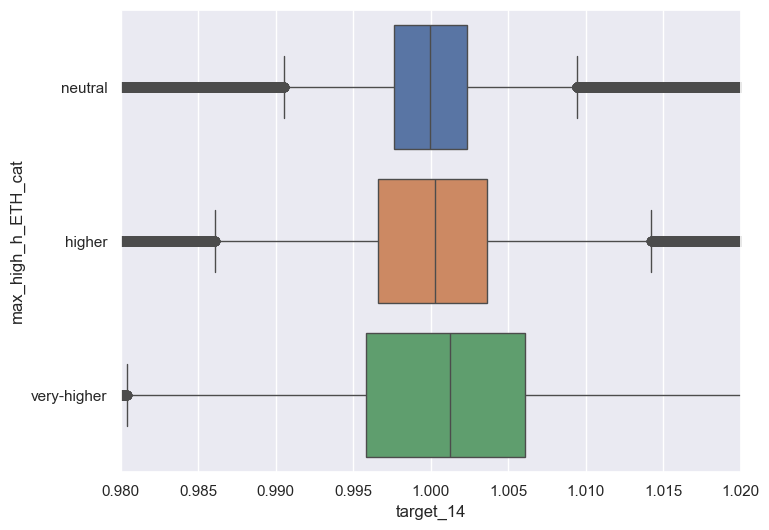

In [138]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="target_14", y="max_high_h_ETH_cat", 
    hue="max_high_h_ETH_cat", dodge=False, 
    order=list_level, hue_order=list_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])  

expected:  [[  7045.36918995  36471.17233726   7338.45847278]
 [ 24853.64639285 128657.78873528  25887.56487186]
 [  3244.98441719  16798.03892745   3379.97665535]]
target_cat             down   neutral       up     Total
max_high_h_ETH_cat                                      
higher               9130.0   32532.0   9193.0   50855.0
neutral             20774.0  138189.0  20436.0  179399.0
very-higher          5240.0   11206.0   6977.0   23423.0
total               35144.0  181927.0  36606.0  253677.0
xi_n =  10950.84585392982
chi2:  10950.84585392982
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


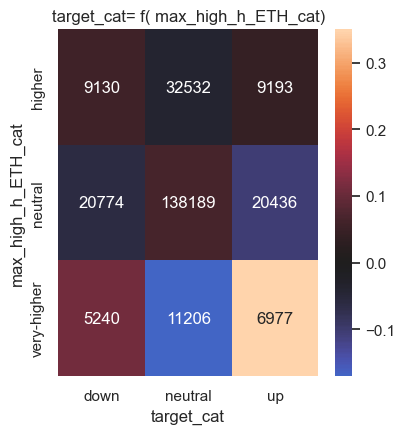

target_cat           down  neutral     up
max_high_h_ETH_cat                       
higher               9130    32532   9193
neutral             20774   138189  20436
very-higher          5240    11206   6977

In [139]:
plot_cont(X="max_high_h_ETH_cat", Y="target_cat", data=df)

expected:  [[  7045.36918995  36471.17233726   7338.45847278]
 [ 24853.64639285 128657.78873528  25887.56487186]
 [  3244.98441719  16798.03892745   3379.97665535]]
target_cat             down   neutral       up     Total
max_high_h_ETH_cat                                      
higher               9130.0   32532.0   9193.0   50855.0
neutral             20774.0  138189.0  20436.0  179399.0
very-higher          5240.0   11206.0   6977.0   23423.0
total               35144.0  181927.0  36606.0  253677.0
xi_n =  10950.84585392982
chi2:  10950.84585392982
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


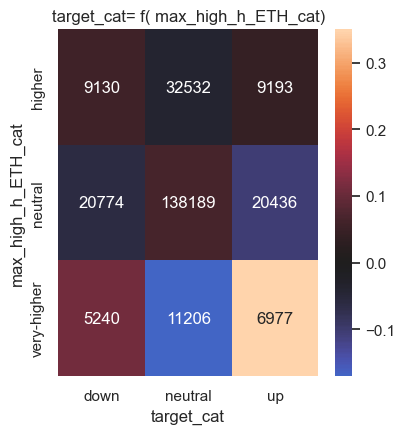

target_cat           down  neutral     up
max_high_h_ETH_cat                       
higher               9130    32532   9193
neutral             20774   138189  20436
very-higher          5240    11206   6977

In [140]:
plot_cont(X="max_high_h_ETH_cat", Y="target_cat", data=df)

In [141]:
df["nupl_ETH"].describe()

count    253677.000000
mean          0.118971
std           0.198094
min          -0.775319
25%           0.039797
50%           0.106898
75%           0.260524
max           0.513805
Name: nupl_ETH, dtype: float64

In [142]:

mquantiles(df["nupl_ETH"], prob=[0.10, 0.90])

array([-0.08284051,  0.36014272])

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_78415/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


nupl_ETH_cat
neutral    168456
higher      69777
lower       15444
Name: count, dtype: int64

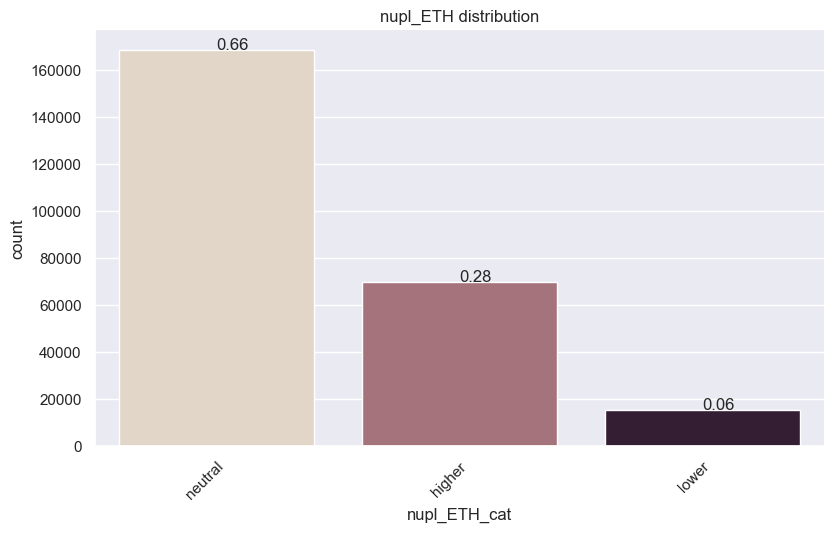

In [143]:

list_level=["lower", "neutral", "higher"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] >= 0.25, "nupl_ETH_cat"] = "higher"
df.loc[df["nupl_ETH"] <= -0.25, "nupl_ETH_cat"] = "lower"
plot_hist_cat("nupl_ETH_cat", df, "nupl_ETH distribution")

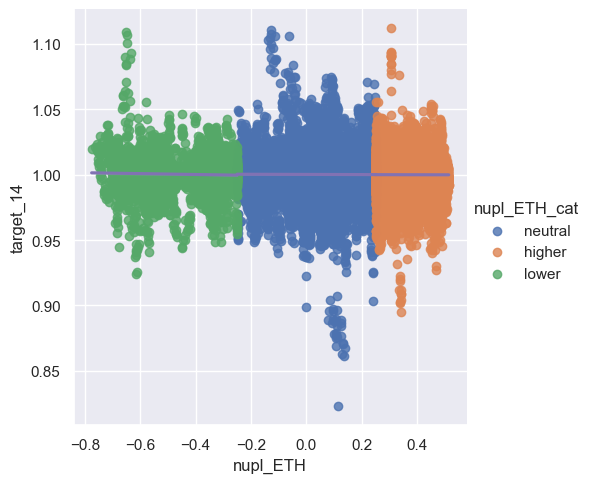

In [144]:
sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})

(0.98, 1.02)

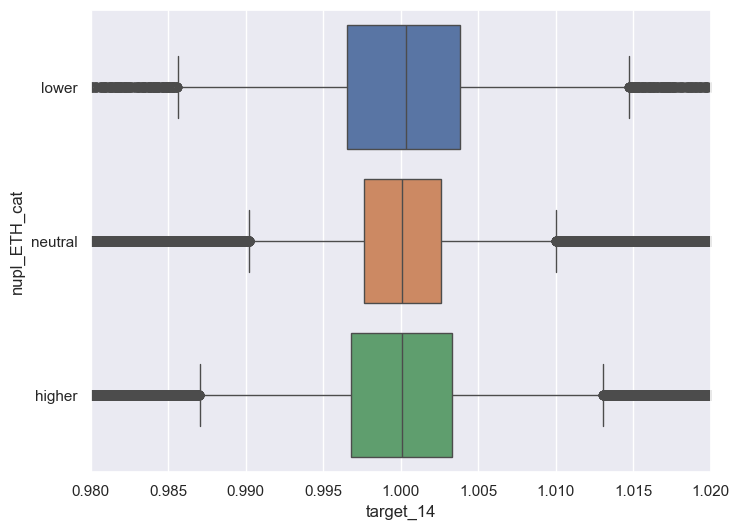

In [145]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_level, hue_order=list_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])  

expected:  [[  9666.79236982  50041.27405717  10068.93357301]
 [  2139.58670278  11075.81920316   2228.59409406]
 [ 23337.6209274  120809.90673967  24308.47233293]]
target_cat       down   neutral       up     Total
nupl_ETH_cat                                      
higher        11586.0   46564.0  11627.0   69777.0
lower          2817.0    9702.0   2925.0   15444.0
neutral       20741.0  125661.0  22054.0  168456.0
total         35144.0  181927.0  36606.0  253677.0
xi_n =  2159.047419759374
chi2:  2159.047419759374
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


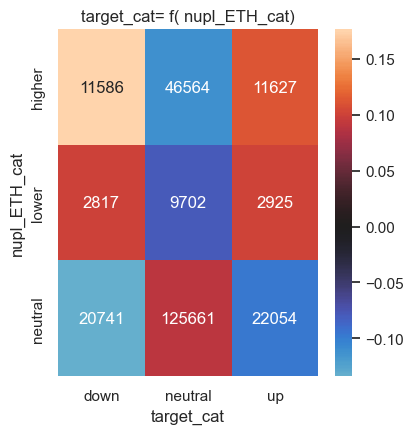

target_cat     down  neutral     up
nupl_ETH_cat                       
higher        11586    46564  11627
lower          2817     9702   2925
neutral       20741   125661  22054

In [146]:
plot_cont(X="nupl_ETH_cat", Y="target_cat", data=df)

In [147]:
chi2 = 2159
indep = 35144.0/253677.0*69777.0
c = 11586
print("chi2: ", chi2)
print("indep: ", indep)
print("c: ", c)
print("chi2 abs part : ", (c-indep)**2/indep)
print("chi2 sign part : ", (c-indep) / np.fabs(c-indep))
print("% of chi2 : ", 100*(c-indep)**2/indep / chi2)


chi2:  2159
indep:  9666.79236982462
c:  11586
chi2 abs part :  381.03207215054994
chi2 sign part :  1.0
% of chi2 :  17.64854433305002


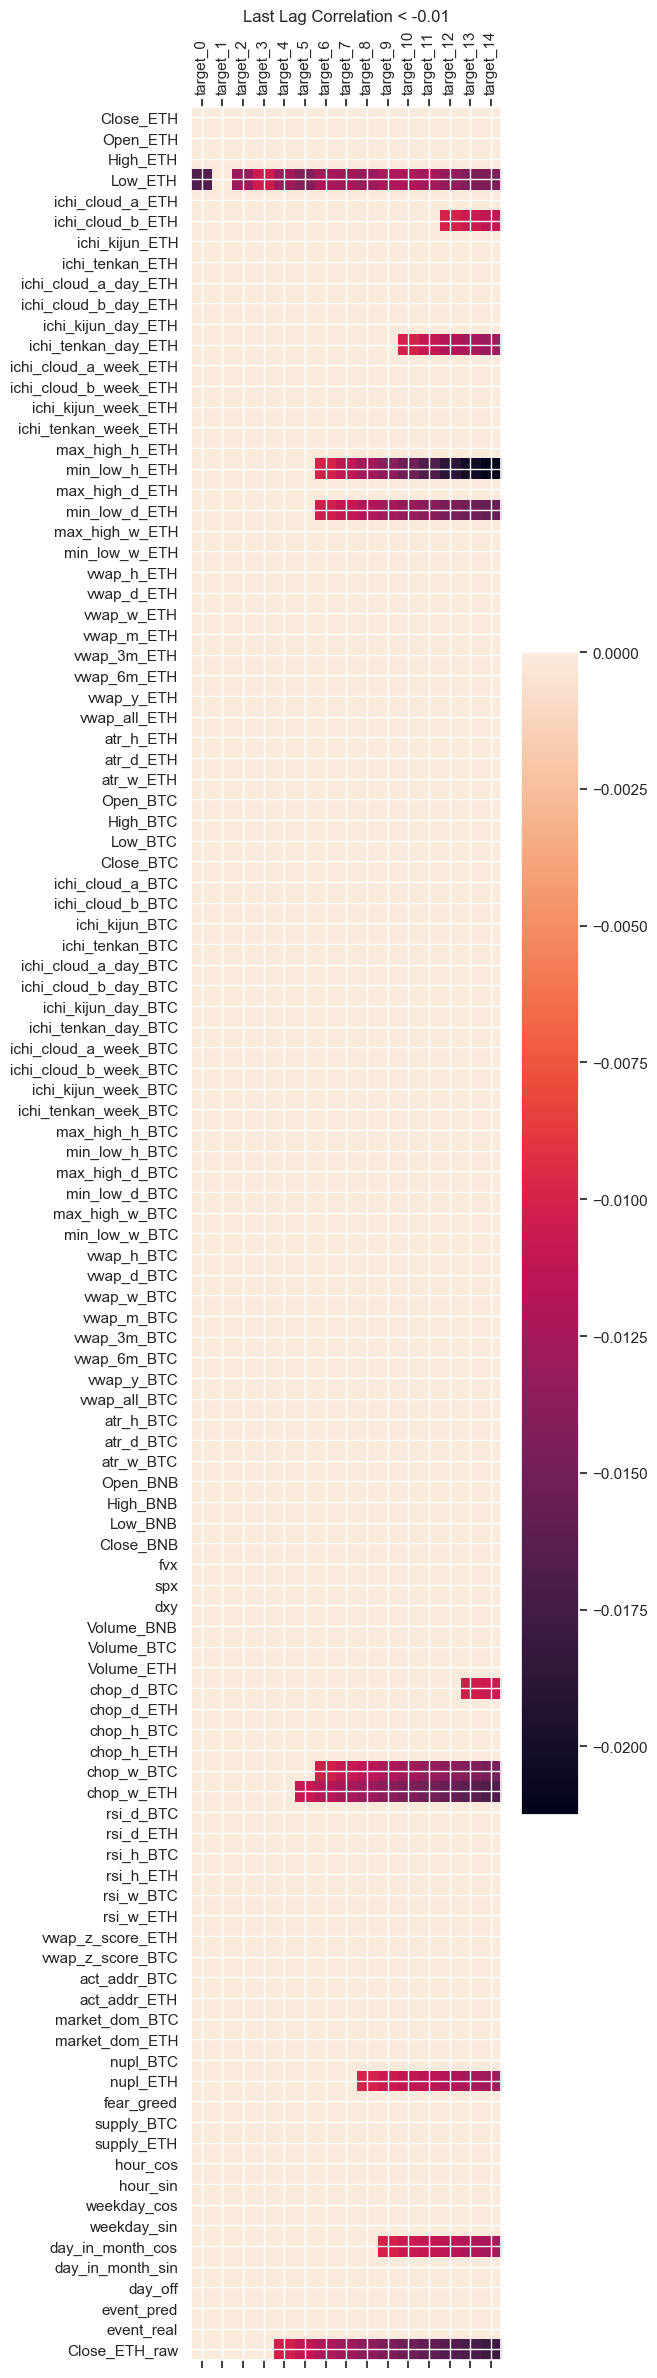

In [148]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.01, 0), 
          title="Last Lag Correlation < -0.01", 
          size=5)

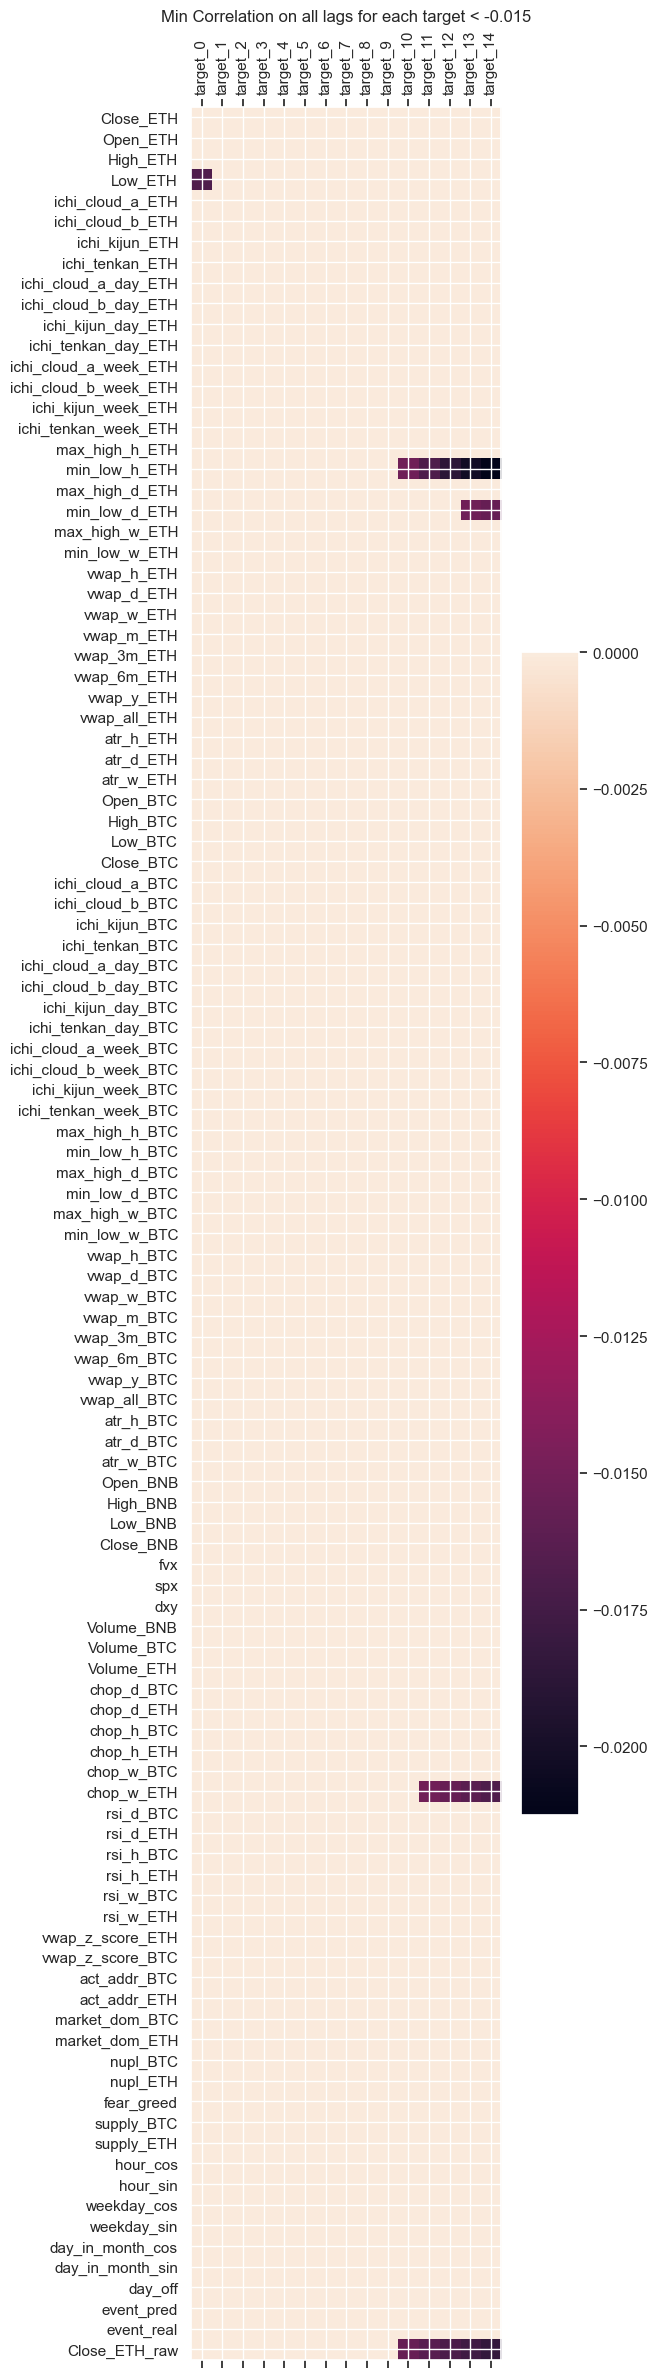

In [149]:
fig = plot_corr(min_corr_matrix_targets.where(min_corr_matrix_targets < -0.015, 0),
                title="Min Correlation on all lags for each target < -0.015",
                size=5)

Text(0, 0.5, 'Min Correlation on all lags for each target < -0.015')

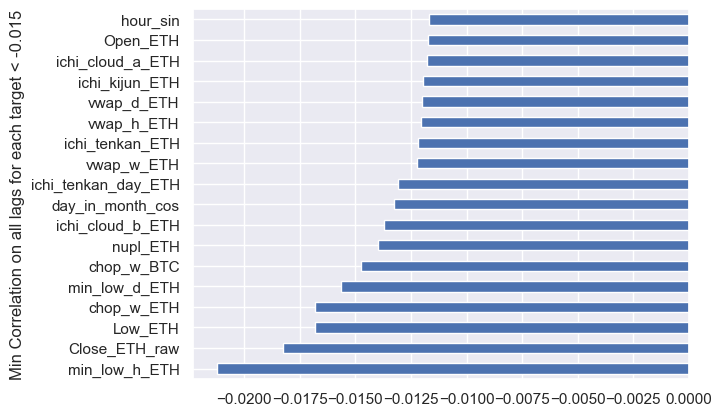

In [150]:
min_min_corr = min_corr_matrix_targets.min(axis=1).sort_values(ascending=True)
min_min_corr[min_min_corr.values<-0.011].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_ylabel("Min Correlation on all lags for each target < -0.015")

<Axes: >

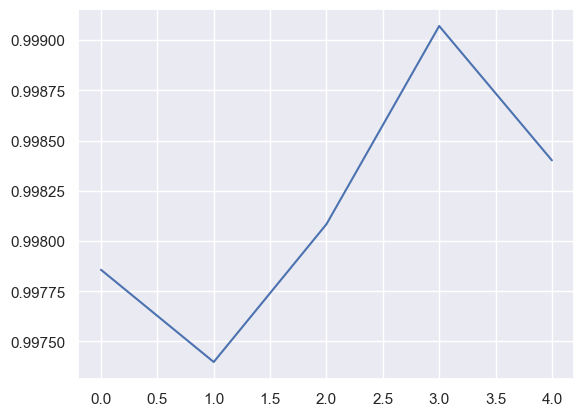

In [151]:
df["min_low_h_ETH"].head().plot()

In [152]:
df["min_low_h_ETH"].describe()

count    253677.000000
mean          0.995225
std           0.005330
min           0.847357
25%           0.993900
50%           0.996677
75%           0.998391
max           1.000000
Name: min_low_h_ETH, dtype: float64

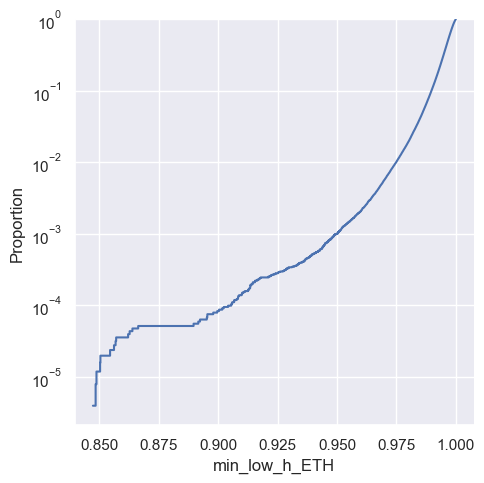

In [153]:
sns.displot(df, x="min_low_h_ETH", kind="ecdf", log_scale=(False, True))

In [154]:
list_level=["very_low", "low", "neutral"]
df["min_low_h_ETH_cat"] = "low"
df.loc[df["min_low_h_ETH"] < 0.995, "min_low_h_ETH_cat"] = "very_low"
df.loc[df["min_low_h_ETH"] > 0.998, "min_low_h_ETH_cat"] = "neutral"
df["min_low_h_ETH_cat"].value_counts()

min_low_h_ETH_cat
low         91014
very_low    83184
neutral     79479
Name: count, dtype: int64

Text(0.5, 1.0, 'Lower Low per hour impact : ETH price = f(min_low_h_ETH_cat)')

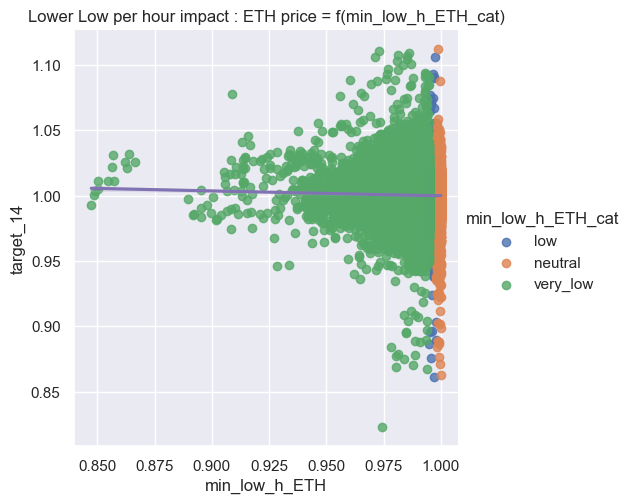

In [155]:
sns.lmplot(x="min_low_h_ETH", y="target_14", hue="min_low_h_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Lower Low per hour impact : ETH price = f(min_low_h_ETH_cat)")

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_78415/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


min_low_h_ETH_cat
low         91014
very_low    83184
neutral     79479
Name: count, dtype: int64

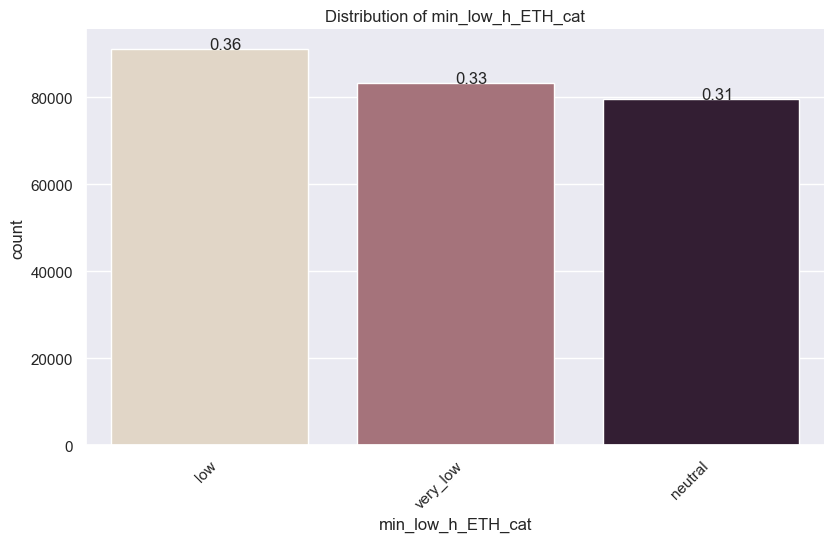

In [156]:

plot_hist_cat(x="min_low_h_ETH_cat", data=df, title="Distribution of min_low_h_ETH_cat")

expected:  [[12608.93189371 65271.60120153 13133.46690476]
 [11010.89170875 56999.16047967 11468.94781159]
 [11524.17639754 59656.23831881 12003.58528365]]
target_cat            down   neutral       up     Total
min_low_h_ETH_cat                                      
low                11509.0   67574.0  11931.0   91014.0
neutral             7582.0   63940.0   7957.0   79479.0
very_low           16053.0   50413.0  16718.0   83184.0
total              35144.0  181927.0  36606.0  253677.0
xi_n =  8339.15806994498
chi2:  8339.15806994498
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


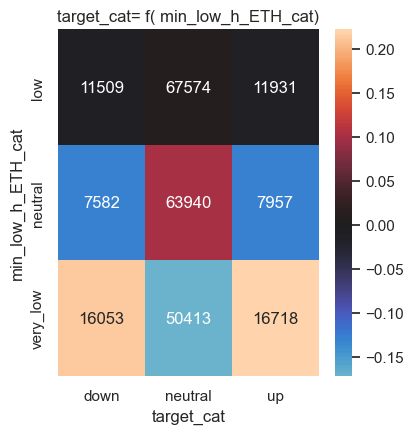

target_cat          down  neutral     up
min_low_h_ETH_cat                       
low                11509    67574  11931
neutral             7582    63940   7957
very_low           16053    50413  16718

In [157]:
plot_cont(X="min_low_h_ETH_cat", Y="target_cat", data=df)

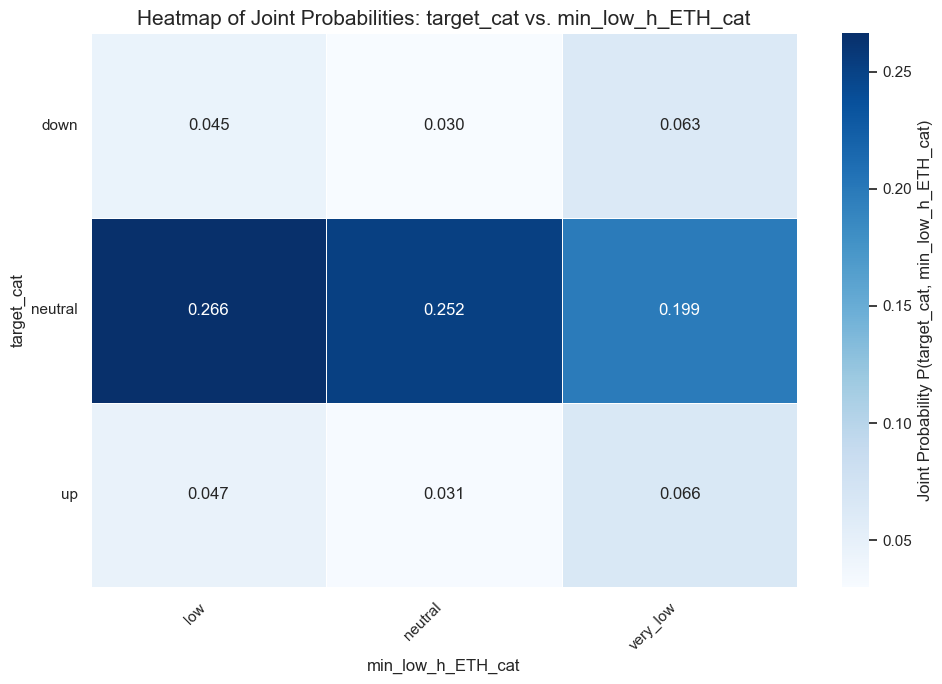

Joint Probability Table:
min_low_h_ETH_cat       low   neutral  very_low
target_cat                                     
down               0.045369  0.029888  0.063281
neutral            0.266378  0.252053  0.198729
up                 0.047032  0.031367  0.065903


In [158]:
probability_table = pd.crosstab(df['target_cat'], df['min_low_h_ETH_cat'], normalize=True)
# 2. Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    probability_table,
    annot=True,        # Show the probability values on the heatmap cells
    fmt=".3f",         # Format annotations to 3 decimal places
    cmap="Blues",      # Colormap (e.g., "Blues", "YlGnBu", "viridis")
    linewidths=.5,     # Add lines between cells for better separation
    cbar_kws={'label': 'Joint Probability P(target_cat, min_low_h_ETH_cat)'} # Label for the color bar
)

plt.title('Heatmap of Joint Probabilities: target_cat vs. min_low_h_ETH_cat', fontsize=15)
plt.ylabel('target_cat', fontsize=12)
plt.xlabel('min_low_h_ETH_cat', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability if long
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Display the probability table (optional)
print("Joint Probability Table:")
print(probability_table)

In [159]:
probability_table.sum().sum()

np.float64(1.0)

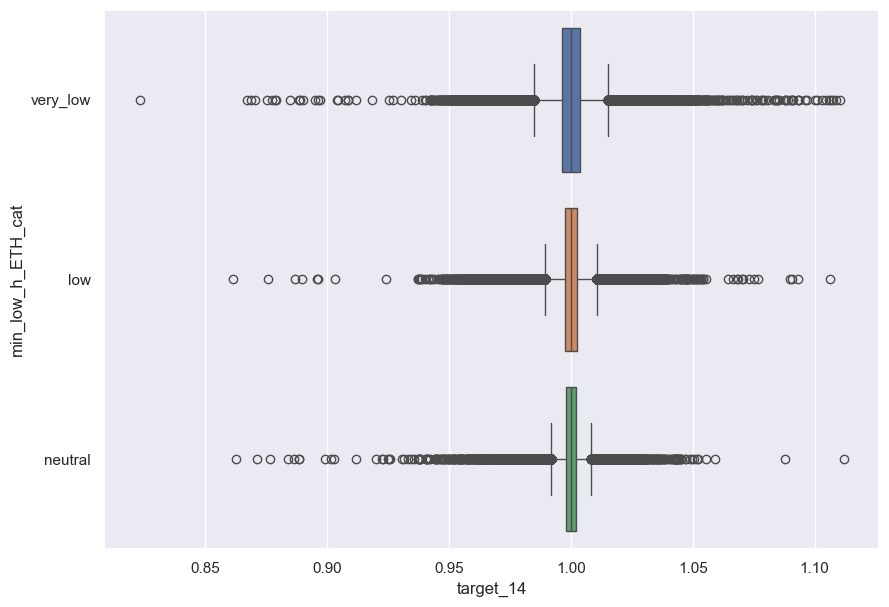

In [160]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="min_low_h_ETH_cat", 
    hue="min_low_h_ETH_cat", dodge=False, 
    order=list_level, hue_order=list_level)
ax = fig.gca()
#ax.set_xlim([0.98,1.02])

In [161]:
df["target_14"].describe()

count    253677.000000
mean          1.000070
std           0.007196
min           0.823072
25%           0.997361
50%           1.000089
75%           1.002851
max           1.112129
Name: target_14, dtype: float64

In [162]:
df["target_1"].describe()

count    253677.000000
mean          1.000009
std           0.002652
min           0.907143
25%           0.998967
50%           1.000013
75%           1.001066
max           1.081058
Name: target_1, dtype: float64

<Axes: xlabel='target_14'>

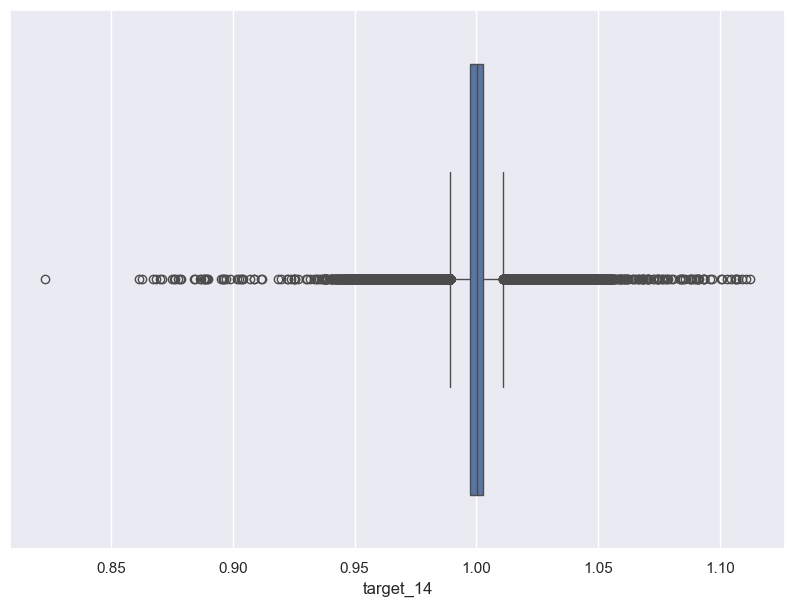

In [163]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

(0.98, 1.02)

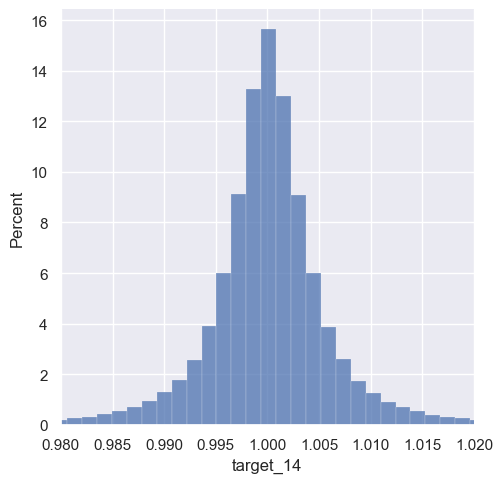

In [164]:
sns.displot(df, x="target_14", kind="hist", stat="percent", bins=200)
ax = plt.gca()
ax.set_xlim([0.98,1.02])

### Chi-2
Distrib are independent between inputs and target (target_14) ?  
Chi-2 must be low  
if not then we can use them as features  
To classify Targets we can say that : if we have : 
- a capital 10000$  
- leverage x10 maxi
- SL = -50$ / TP = 100$ / R = 2
- and we want to have 100$ of profit per days
- so:  0.1% up or down can be enough for target

Or find a threshold that can occurs on FUTURE_TARGET points  at a minimum prob to have > 80% chance to touch min or max target  
For example : 
- 40% touch Target max
- 40% touch Target min
- 20% neutral
- Total Targets: 80%


In [385]:
df = pd.DataFrame(np.hstack((X_train_dat[:, -1, :nb_plot], y_train)), 
        columns=list_col_corr)

In [386]:
last_target = list_col_targets[-1]

In [387]:
df.filter(list_col_select)

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0             1.0  0.999782  1.000109  0.999774          0.999171   
1             1.0  0.999548  1.000008  0.999540          0.998785   
2             1.0  1.000084  1.000193  0.999841          0.998860   
3             1.0  1.000770  1.000770  0.999900          0.999669   
4             1.0  0.999330  1.000025  0.999330          0.999178   
...           ...       ...       ...       ...               ...   
253672        1.0  0.998258  1.001698  0.997009          1.009059   
253673        1.0  0.998554  1.001387  0.998451          1.006895   
253674        1.0  1.004900  1.005056  0.999299          1.011829   
253675        1.0  1.001168  1.001491  0.997621          1.011492   
253676        1.0  1.012121  1.014171  0.998487          1.023400   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0               0.999736        0.998393         0.999464   
1               0.999276        0.998113         0.999184   
2               0.999351        0.998243         0.999477   
3               1.000113        0.999003         1.000239   
4               0.999443        0.998335         0.999569   
...                  ...             ...              ...   
253672          1.012239        1.000323         1.000559   
253673          1.010775        0.998877         0.999113   
253674          1.015728        1.003772         1.004009   
253675          1.015731        1.004944         1.003987   
253676          1.028043        1.011526         1.009147   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
0                   2.024261              2.017807  ...  2.588190e-01   
1                   2.023329              2.016878  ...  6.123234e-17   
2                   2.023482              2.017030  ...  6.123234e-17   
3                   2.025023              2.018567  ...  6.123234e-17   
4                   2.023668              2.017215  ...  6.123234e-17   
...                      ...                   ...  ...           ...   
253672              1.043299              1.026564  ...  9.659258e-01   
253673              1.041791              1.025079  ...  9.659258e-01   
253674              1.046896              1.030103  ...  9.659258e-01   
253675              1.048118              1.031306  ...  9.659258e-01   
253676              1.060823              1.043807  ...  9.659258e-01   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
0       0.965926     0.623490    -0.781832           0.97953   
1       1.000000     0.623490    -0.781832           0.97953   
2       1.000000     0.623490    -0.781832           0.97953   
3       1.000000     0.623490    -0.781832           0.97953   
4       1.000000     0.623490    -0.781832           0.97953   
...          ...          ...          ...               ...   
253672  0.258819    -0.222521    -0.974928           1.00000   
253673  0.258819    -0.222521    -0.974928           1.00000   
253674  0.258819    -0.222521    -0.974928           1.00000   
253675  0.258819    -0.222521    -0.974928           1.00000   
253676  0.258819    -0.222521    -0.974928           1.00000   

        day_in_month_sin  day_off  event_pred  event_real  Close_ETH_raw  
0           2.012985e-01      0.0         0.0         0.0    1194.540039  
1           2.012985e-01      0.0         0.0         0.0    1195.089966  
2           2.012985e-01      0.0         0.0         0.0    1195.000000  
3           2.012985e-01      0.0         0.0         0.0    1194.089966  
4           2.012985e-01      0.0         0.0         0.0    1194.890015  
...                  ...      ...         ...         ...            ...  
253672     -2.449294e-16      0.0         0.0         0.0    2520.719971  
253673     -2.449294e-16      0.0         0.0         0.0    2524.370117  
253674     -2.449294e-16      0.0         0.0         0.0    2512.060059  
253675     -2.449294e-16      0.0         0.0     

In [388]:
# find for all features the quantiles
quantile_min = 0.05
quantile_max = 0.95
# transpose the dataframe to have the features as columns
df_cont = df.filter(list_col_select + [last_target]).quantile([quantile_min, quantile_max], axis=0)
df_cont = df_cont.T
# rename the columns
df_cont.columns = ["q10", "q90"]
# store nunique() in a new column
df_cont["nunique"] = df.filter(list_col_select + [last_target]).nunique()

df_cont

q10          q90  nunique
Close_ETH            1.000000     1.000000        1
Open_ETH             0.997444     1.002571    76413
High_ETH             1.000003     1.003477    37382
Low_ETH              0.996417     0.999997    60295
ichi_cloud_a_ETH     0.985258     1.014277   171844
...                       ...          ...      ...
day_off              0.000000     0.000000        2
event_pred           0.000000     0.000000        3
event_real           0.000000     0.000000        3
Close_ETH_raw     1568.739990  3690.719971   135314
target_14            0.989921     1.010088   253286

[110 rows x 3 columns]

#### Target levels
Here we can see the 10% lowest is under -0.64%, the 10% highest are over 0.65% : 

In [171]:
print(f"target level min : {100*(df_cont.at["target_14","q10"]-1)} %")

target level min : -1.0079367829221475 %


In [172]:
print(f"target level max : {100*(df_cont.at["target_14","q90"]-1)} %")

target level max : 1.0087737935070118 %


In [173]:
(1.006591 -1)/1 *100

0.6591000000000014

In [174]:
(0.993554 - 1) / 1 * 100

-0.6445999999999952

In [175]:
100*(0.038*2+0.0014)/0.1

77.39999999999999

We can use a level of >= 0.1% => "high" , <=-0.1% "low", otherwise "neutral"  

- BE CAREFUL : Hyperliquid for example can take 25% of trade if 0.1% is a trigger : 
  - maker fees : 0.015% (if trade out of orderbook (usually when limit order)
  - or taker fees : 0.038% (if market order)
  - funding 1h : 0.0014% ( funding rate will be positive, and the long position will pay the short position.)
  - TOTAL max 2 takers trades (open/close) + funding 1h max :  0.0774% => 77% of 0.1% !

In [176]:
target_level = 0.1/100

In [177]:
y_train.shape

(253677, 15)

In [178]:
y_train.max(axis=1) >= 1+target_level

array([False, False, False, ...,  True,  True,  True], shape=(253677,))

In [179]:
y_train.min(axis=1) <= 1-target_level

array([False,  True,  True, ...,  True,  True, False], shape=(253677,))

Not used anymore :  the last target value : 

In [180]:
Y = "target_last_cat"
df_targets = pd.DataFrame(y_train, columns=list_col_targets)
df_targets[Y] = "neutral"
df_targets.loc[y_train[:,-1] >= 1+target_level, Y] = "high"
df_targets.loc[y_train[:,-1] <= 1-target_level, Y] = "low"
df_targets[Y].value_counts()

target_last_cat
high       102187
low         97441
neutral     54049
Name: count, dtype: int64

In [181]:
df_targets["target_last_cat"].value_counts()/df_targets.shape[0]

target_last_cat
high       0.402823
low        0.384114
neutral    0.213062
Name: count, dtype: float64

In [182]:
df_targets["target_14"].describe()

count    253677.000000
mean          1.000070
std           0.007196
min           0.823072
25%           0.997361
50%           1.000089
75%           1.002851
max           1.112129
Name: target_14, dtype: float64

In [183]:
df_targets["max_target"] = y_train.max(axis=1)
df_targets["min_target"] = y_train.min(axis=1)
df_targets

target_0  target_1  target_2  target_3  target_4  target_5  target_6  \
0       1.000460  1.000385  0.999623  1.000293  0.999816  1.000050  0.999498   
1       0.999925  0.999163  0.999833  0.999356  0.999590  0.999038  0.999046   
2       0.999238  0.999908  0.999431  0.999665  0.999113  0.999121  0.999473   
3       1.000670  1.000193  1.000427  0.999874  0.999883  1.000234  1.000301   
4       0.999523  0.999757  0.999205  0.999213  0.999565  0.999632  0.999565   
...          ...       ...       ...       ...       ...       ...       ...   
253672  1.001448  0.996564  0.995402  0.983481  0.990876  0.990951  0.988297   
253673  0.995124  0.993963  0.982059  0.989443  0.989518  0.986868  0.986836   
253674  0.998834  0.986871  0.994292  0.994367  0.991704  0.991672  0.992440   
253675  0.988024  0.995453  0.995528  0.992862  0.992830  0.993599  0.991049   
253676  1.007519  1.007596  1.004897  1.004865  1.005643  1.003062  1.010629   

        target_7  target_8  target_9  target_10  target_11  target_12  \
0       0.999506  0.999858  0.999925   0.999858   1.000226   0.999891   
1       0.999398  0.999464  0.999398   0.999766   0.999431   0.999690   
2       0.999540  0.999473  0.999841   0.999506   0.999766   0.999473   
3       1.000234  1.000603  1.000268   1.000528   1.000234   0.999640   
4       0.999933  0.999598  0.999858   0.999565   0.998971   0.998686   
...          ...       ...       ...        ...        ...        ...   
253672  0.988265  0.989031  0.986492   0.993934   0.995977   0.997667   
253673  0.987601  0.985066  0.992497   0.994537   0.996225   0.993384   
253674  0.989893  0.997361  0.999411   1.001107   0.998252   0.997170   
253675  0.998525  1.000578  1.002276   0.999418   0.998334   0.994448   
253676  1.012706  1.014425  1.011533   1.010435   1.006502   1.009294   

        target_13  target_14 target_last_cat  max_target  min_target  
0        1.000151   0.999858         neutral    1.000460    0.999498  
1        0.999398   0.998803             low    0.999925    0.998803  
2        0.998879   0.998594             low    0.999908    0.998594  
3        0.999355   1.000427         neutral    1.000670    0.999355  
4        0.999757   0.999732         neutral    0.999933    0.998686  
...           ...        ...             ...         ...         ...  
253672   0.994823   0.993744             low    1.001448    0.983481  
253673   0.992307   0.988445             low    0.996225    0.982059  
253674   0.993288   0.996043             low    1.001107    0.986871  
253675   0.997206   0.995803             low    1.002276    0.988024  
253676   1.007874   1.007934            high    1.014425    1.003062  

[253677 rows x 18 columns]

Very important : we can see that the last target is not the best to use as a target,   
because it is not well distributed,   
so we will use the max and min, of all the targets, to create a new target   
But we take the first to appear above min/max threshold : +/-0.1%  
Example : 
- if the max is above 1.001 before min is below 0.999, then we will use the max as the target
- if the min is below 0.999 before max is above 1.001, then we will use the min as the target
- if none of them are above/below 1.001/0.999, then we will use the neutral target
  
##### First Strategy :  TP = SL

In [184]:
Y = "target_cat"
#df_targets = pd.DataFrame(y_train, columns=list_col_targets)
df_targets[Y] = "neutral"
# low cat : 
b_low = ((y_train.min(axis=1) <= 1-target_level) & (
    (y_train.argmin(axis=1) < y_train.argmax(axis=1)) |
    ((y_train.argmin(axis=1) > y_train.argmax(axis=1)) & (y_train.max(axis=1) < 1+target_level))
    )
)
df_targets.loc[b_low, Y] = "low"
# high cat
b_high = ((y_train.max(axis=1) >= 1+target_level)& (
    (y_train.argmax(axis=1) < y_train.argmin(axis=1)) |
    ((y_train.argmax(axis=1) > y_train.argmin(axis=1)) & (y_train.min(axis=1) > 1-target_level))
    )
)
df_targets.loc[b_high, Y] = "high"

df_targets[Y].value_counts()

target_cat
high       125295
low        123574
neutral      4808
Name: count, dtype: int64

In [185]:
df_targets[Y].value_counts()/df_targets.shape[0]

target_cat
high       0.493915
low        0.487131
neutral    0.018953
Name: count, dtype: float64

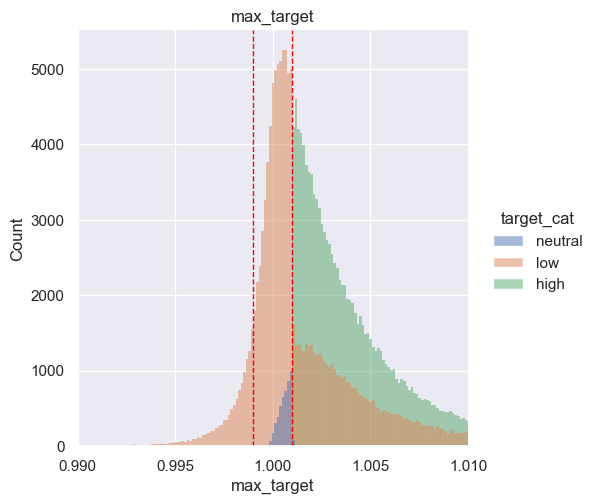

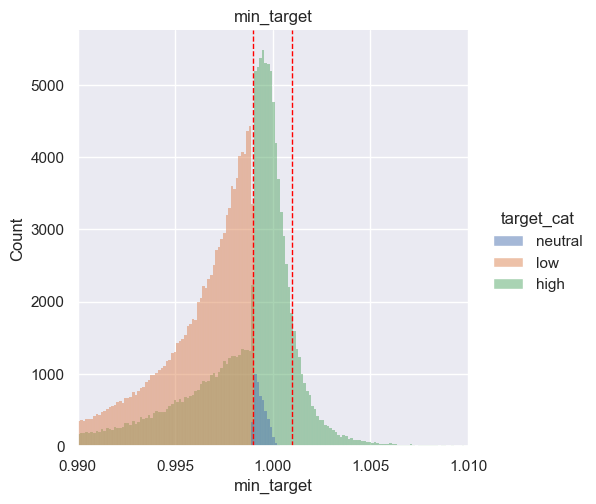

In [186]:
sns.displot(df_targets, x="max_target", hue="target_cat", kind="hist")
ax = plt.gca()
ax.set_xlim([0.99,1.01])
ax.set_title("max_target")
# add vertical lines at 1+target_level and 1-target_level
ax.axvline(1+target_level, color='red', linestyle='dashed', linewidth=1)
ax.axvline(1-target_level, color='red', linestyle='dashed', linewidth=1)

sns.displot(df_targets, x="min_target", hue="target_cat", kind="hist")
ax = plt.gca()
ax.set_xlim([0.99,1.01])
ax.set_title("min_target")
# add vertical lines at 1+target_level and 1-target_level
ax.axvline(1+target_level, color='red', linestyle='dashed', linewidth=1)
ax.axvline(1-target_level, color='red', linestyle='dashed', linewidth=1)

Here : complex graph : 
- If Neutral cat., min or max stay into thresholds.  
- if High cat., min value is around 1
- If Low cat., max value is 1.0005 (1-0.05%) (half the threshold 0.1%)


##### 2eme Strat : TP/SL = 2


In [ ]:
Y = "target_cat_2"
target_level =  0.1/100
R = 2
#df_targets = pd.DataFrame(y_train, columns=list_col_targets)
df_targets[Y] = "neutral"
# low cat : if :
#   - low SHORT TP touched AND high SHORT SL IS NOT  reached during timerange
#   - OR low SHORT TP touched AND high SHORT SL IS reached during timerange but AFTER TP
b_low =(
    ((y_train.min(axis=1) <= 1-target_level) & (y_train.max(axis=1) < 1+target_level/R)) |
    (
        (y_train.min(axis=1) <= 1-target_level) & (y_train.max(axis=1) >= 1+target_level/R) &
        (np.argmax((y_train <= 1-target_level), axis=1) < np.argmax(y_train >= 1+target_level/R, axis=1))
    ) 
)
df_targets.loc[b_low, Y] = "low"
# high cat : if 
#   - high LONG TP touched AND low LONG SL IS NOT reached during timerange
#   - OR high LONG TP touched AND low LONG SL IS reached during timerange but AFTER TP
b_high = (
    ((y_train.max(axis=1) >= 1+target_level) & (y_train.min(axis=1) > 1-target_level/R)) |
    (
        (y_train.max(axis=1) >= 1+target_level) & (y_train.min(axis=1) <= 1-target_level/R) &
        (np.argmax((y_train >= 1+target_level), axis=1) < np.argmax(y_train <= 1-target_level/R, axis=1))
    )
)

df_targets.loc[b_high, Y] = "high"

# check 
val_count = df_targets[Y].value_counts()
print(val_count)
assert val_count["high"] == np.sum(b_high)
assert val_count["low"] == np.sum(b_low)
#
print(f"trade high : {100*np.sum(b_high)/df_targets.shape[0]:.2f}%")
print(f"trade low : {100*np.sum(b_low)/df_targets.shape[0]:.2f}%")
print(f"trade neutral : {100*(df_targets.shape[0]-np.sum(b_high)-np.sum(b_low))/df_targets.shape[0]:.2f}%")


target_cat_2
high       107671
low        105473
neutral     40533
Name: count, dtype: int64
trade high : 42.44%
trade low : 41.58%
trade neutral : 15.98%


In [377]:
print(f"max nb trades high per day: {np.sum(b_high) / (df_targets.shape[0]) * (24*60/5):.2f}")
print(f"{100/target_level:.2f}$ trading size per trade")
print('with 10000$ as collateral, you need a leverage x{:.1f} to have 100$ per trade'.format(100/target_level/10000))

max nb trades high per day: 122.24
100000.00$ trading size per trade
with 10000$ as collateral, you need a leverage x10.0 to have 100$ per trade


target_cat
high       107671
low        105473
neutral     40533
Name: count, dtype: int64
trade high : 42.44%
trade low : 41.58%
trade neutral : 15.98%

##### 2nd Strat fixed TP/SL=2

In [382]:
Y = "target_cat"
target_level =  0.1/100
R = 2
df_targets[Y] = "neutral"
# low cat : if :
#   - low SHORT TP touched AND high SHORT SL IS NOT reached during timerange
#   - OR low SHORT TP touched AND high SHORT SL IS reached during timerange but AFTER TP
b_low =(
    ((y_low_train.min(axis=1) <= 1-target_level) & (y_high_train.max(axis=1) < 1+target_level/R)) |
    (
        (y_low_train.min(axis=1) <= 1-target_level) & (y_high_train.max(axis=1) >= 1+target_level/R) &
        (np.argmax((y_low_train <= 1-target_level), axis=1) < np.argmax(y_high_train >= 1+target_level/R, axis=1))
    ) 
)
df_targets.loc[b_low, Y] = "low"
# high cat : if 
#   - high LONG TP touched AND low LONG SL IS NOT reached during timerange
#   - OR high LONG TP touched AND low LONG SL IS reached during timerange but AFTER TP
b_high = (
    ((y_high_train.max(axis=1) >= 1+target_level) & (y_low_train.min(axis=1) > 1-target_level/R)) |
    (
        (y_high_train.max(axis=1) >= 1+target_level) & (y_low_train.min(axis=1) <= 1-target_level/R) &
        (np.argmax((y_high_train >= 1+target_level), axis=1) < np.argmax(y_low_train <= 1-target_level/R, axis=1))
    )
)
df_targets.loc[b_high, Y] = "high"

# if low and high at the same time, then it s neutral
nb_dual = np.sum(b_high & b_low)
if nb_dual > 0:
    print("nb cases high and low at same time: ", nb_dual)
    df_targets.loc[np.logical_not(b_high ^ b_low), Y] = "neutral"
else:
    print('highs and lows are distinct')
# check 
val_count = df_targets[Y].value_counts()
print(val_count)
assert val_count["high"] == np.sum(b_high)
assert val_count["low"] == np.sum(b_low)
#
print(f"trade high : {100*np.sum(b_high)/df_targets.shape[0]:.2f}%")
print(f"trade low : {100*np.sum(b_low)/df_targets.shape[0]:.2f}%")
print(f"trade neutral : {100*(df_targets.shape[0]-np.sum(b_high)-np.sum(b_low))/df_targets.shape[0]:.2f}%")

# target_cat_fixed : if high low not distinct
# neutral    102593
# low         75873
# high        75211


highs and lows are distinct
target_cat
neutral    102593
low         75873
high        75211
Name: count, dtype: int64
trade high : 29.65%
trade low : 29.91%
trade neutral : 40.44%


In [379]:
print(f"max nb trades high per day: {np.sum(b_high) / (df_targets.shape[0]) * (24*60/5):.2f}")
print(f"{100/target_level:.2f}$ trading size per trade")
print('with 10000$ as collateral, you need a leverage x{:.1f} to have 100$ per trade'.format(100/target_level/10000))

max nb trades high per day: 85.39
100000.00$ trading size per trade
with 10000$ as collateral, you need a leverage x10.0 to have 100$ per trade


##### 3rd Strat R=2, TP_r=0.45%

In [380]:
Y = "target_cat_3"
target_level = 0.0045
R = 2
#df_targets = pd.DataFrame(y_train, columns=list_col_targets)
df_targets[Y] = "neutral"
# low cat : if :
#   - low SHORT TP touched AND high SHORT SL IS NOT reached during timerange
#   - OR low SHORT TP touched AND high SHORT SL IS reached during timerange but AFTER TP
b_low =(
    ((y_low_train.min(axis=1) <= 1-target_level) & (y_high_train.max(axis=1) < 1+target_level/R)) |
    (
        (y_low_train.min(axis=1) <= 1-target_level) & (y_high_train.max(axis=1) >= 1+target_level/R) &
        (np.argmax((y_low_train <= 1-target_level), axis=1) < np.argmax(y_high_train >= 1+target_level/R, axis=1))
    ) 
)
df_targets.loc[b_low, Y] = "low"
# high cat : if 
#   - high LONG TP touched AND low LONG SL IS NOT reached during timerange
#   - OR high LONG TP touched AND low LONG SL IS reached during timerange but AFTER TP
b_high = (
    ((y_high_train.max(axis=1) >= 1+target_level) & (y_low_train.min(axis=1) > 1-target_level/R)) |
    (
        (y_high_train.max(axis=1) >= 1+target_level) & (y_low_train.min(axis=1) <= 1-target_level/R) &
        (np.argmax((y_high_train >= 1+target_level), axis=1) < np.argmax(y_low_train <= 1-target_level/R, axis=1))
    )
)
df_targets.loc[b_high, Y] = "high"

# if low and high at the same time, then it s neutral
nb_dual = np.sum(b_high & b_low)
if nb_dual > 0:
    print("nb cases high and low at same time: ", nb_dual)
    df_targets.loc[np.logical_not(b_high ^ b_low), Y] = "neutral"
else:
    print('highs and lows are distinct')
# check 
val_count = df_targets[Y].value_counts()
print(val_count)
assert val_count["high"] == np.sum(b_high)
assert val_count["low"] == np.sum(b_low)
#
print(f"trade high : {100*np.sum(b_high)/df_targets.shape[0]:.2f}%")
print(f"trade low : {100*np.sum(b_low)/df_targets.shape[0]:.2f}%")
print(f"trade neutral : {100*(df_targets.shape[0]-np.sum(b_high)-np.sum(b_low))/df_targets.shape[0]:.2f}%")

highs and lows are distinct
target_cat_3
neutral    128870
low         63200
high        61607
Name: count, dtype: int64
trade high : 24.29%
trade low : 24.91%
trade neutral : 50.80%


In [381]:
print(f"max nb trades high per day: {np.sum(b_high) / (df_targets.shape[0]) * (24*60/5):.2f}")
print(f"{100/target_level:.2f}$ trading size per trade")
print('with 10000$ as collateral, you need a leverage x{:.1f} to have 100$ per trade'.format(100/target_level/10000))

max nb trades high per day: 69.94
22222.22$ trading size per trade
with 10000$ as collateral, you need a leverage x2.2 to have 100$ per trade


##### 4th Strat R=2.5, TP_r=0.33%

In [200]:
Y = "target_cat_4"
target_level = 0.33/100
R = 2.5
#df_targets = pd.DataFrame(y_train, columns=list_col_targets)
df_targets[Y] = "neutral"
# low cat : if :
#   - low SHORT TP touched AND high SHORT SL IS NOT reached during timerange
#   - OR low SHORT TP touched AND high SHORT SL IS reached during timerange but AFTER TP
b_low =(
    ((y_low_train.min(axis=1) <= 1-target_level) & (y_high_train.max(axis=1) < 1+target_level/R)) |
    (
        (y_low_train.min(axis=1) <= 1-target_level) & (y_high_train.max(axis=1) >= 1+target_level/R) &
        (np.argmax((y_low_train <= 1-target_level), axis=1) < np.argmax(y_high_train >= 1+target_level/R, axis=1))
    ) 
)
df_targets.loc[b_low, Y] = "low"
# high cat : if 
#   - high LONG TP touched AND low LONG SL IS NOT reached during timerange
#   - OR high LONG TP touched AND low LONG SL IS reached during timerange but AFTER TP
b_high = (
    ((y_high_train.max(axis=1) >= 1+target_level) & (y_low_train.min(axis=1) > 1-target_level/R)) |
    (
        (y_high_train.max(axis=1) >= 1+target_level) & (y_low_train.min(axis=1) <= 1-target_level/R) &
        (np.argmax((y_high_train >= 1+target_level), axis=1) < np.argmax(y_low_train <= 1-target_level/R, axis=1))
    )
)
df_targets.loc[b_high, Y] = "high"

# if low and high at the same time, then it s neutral
nb_dual = np.sum(b_high & b_low)
if nb_dual > 0:
    print("nb cases high and low at same time: ", nb_dual)
    df_targets.loc[np.logical_not(b_high ^ b_low), Y] = "neutral"
else:
    print('highs and lows are distinct')
# check 
val_count = df_targets[Y].value_counts()
print(val_count)
assert val_count["high"] == np.sum(b_high)
assert val_count["low"] == np.sum(b_low)
#
print(f"trade high : {100*np.sum(b_high)/df_targets.shape[0]:.2f}%")
print(f"trade low : {100*np.sum(b_low)/df_targets.shape[0]:.2f}%")
print(f"trade neutral : {100*(df_targets.shape[0]-np.sum(b_high)-np.sum(b_low))/df_targets.shape[0]:.2f}%")

highs and lows are distinct
target_cat_4
neutral    124996
low         65064
high        63617
Name: count, dtype: int64
trade high : 25.08%
trade low : 25.65%
trade neutral : 49.27%


In [ ]:
print(f"max nb trades high per day: {np.sum(b_high) / (df_targets.shape[0]) * (24*60/5):.2f}")
print(f"{100/target_level:.2f}$ trading size per trade")
print('with 10000$ as collateral, you need a leverage x{:.1f} to have 100$ per trade'.format(100/target_level/10000))

##### Strat selection

In [375]:
Y = "target_cat"
target_level = 0.1/100

##### Past history choice

Caclulate for lags exponentially distributed  : e.g. : 
- 1st lag = 5min
- 2nd lag = 10min
- 3rd lag = 20min
- 4th lag = 40min
- 5th lag = 80min
- 6th lag = 160min

In [204]:

# find a maximum range as long as sum on i (from 1 to n) of DT_PAST*2**(i-1) is inferior to PAST_HISTORY 
k=0
list_past = []
for i in range(0, PAST_HISTORY):
    if 2**(i) - 1 > PAST_HISTORY:
        break
    else:
        k = PAST_HISTORY - 2**(i) 
        list_past.append(k)

print(list_past)

[71, 70, 68, 64, 56, 40, 8]


##### Prob & Contingency per event

In [205]:
def calc_prob(val):
    # calculate proba for classes of a value counts as input : val
    # calculate also the delta "power" proba between high and low : (nb_H - nb_L)^2 / mean(nb_h,nb_L)
    # to indicate important feature
    prob_high = val["high"] / (val.sum())
    prob_low = val["low"] / (val.sum())
    prob_delta = np.sign(prob_high - prob_low) * (val["high"] - val["low"] )**2 / ((val["high"] + val["low"]) / 2)
    return val["high"], val["low"], prob_high, prob_low, prob_delta


In [206]:
# Calculate classes, contigency chi2 and p value : for each feature and each past value
# - for all lags of target,  we have one categorical variable :
# - high mean we have touch high target level, 
# - low mean we have touch low target level,
# - neutral mean we have not touch target level
list_df = []
df_prob = pd.DataFrame()
for I_past in list_past: #range(PAST_HISTORY):
    # Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
    df_ = pd.DataFrame(X_train_dat[:, I_past, :nb_plot], columns=list_col_select[:nb_plot])
    df_ = pd.concat([df_, df_targets], axis=1)
    for col_name in list_col_select:
        X = col_name + "_cat"
        df_[X] = "neutral"
        if df_cont.at[col_name, "nunique"] > 3:
            df_.loc[df_[col_name] >= df_cont.at[col_name, "q90"], X] = "high"
            df_.loc[df_[col_name] <= df_cont.at[col_name, "q10"], X] = "low"
        elif df_cont.at[col_name, "nunique"] == 3:
            unique_values = df_[col_name].unique()
            # sort the unique values
            unique_values.sort()
            # assign the categories
            df_.loc[df_[col_name] == unique_values[2], X] = "high"
            df_.loc[df_[col_name] == unique_values[1], X] = "neutral"
            df_.loc[df_[col_name] == unique_values[0], X] = "low"
        elif df_cont.at[col_name, "nunique"] == 2:
            unique_values = df_[col_name].unique()
            # sort the unique values
            unique_values.sort()
            # assign the categories
            df_.loc[df_[col_name] == unique_values[1], X] = "high"
            df_.loc[df_[col_name] == unique_values[0], X] = "low"
        

        # create prob df : 
        for cat_feature in ["high", "low"]:
            ser_prob_curr = pd.Series()
            val = df_.loc[df_[X] == cat_feature, "target_cat"].value_counts()
            if len(val) > 0 :
                val_high, val_low, prob_high, prob_low, delta_prob = calc_prob(val)
            else:
                val_high = np.nan
                val_low = np.nan
                prob_high = np.nan
                prob_low = np.nan
                delta_prob = np.nan
            ser_prob_curr["feature"] = X
            ser_prob_curr["feature_cat"] = cat_feature
            ser_prob_curr["lag"] = I_past
            ser_prob_curr["nb_high"] = val_high
            ser_prob_curr["nb_low"] = val_low
            ser_prob_curr["prob_high"] = prob_high
            ser_prob_curr["prob_low"] = prob_low
            ser_prob_curr["delta_prob"] = delta_prob
            #df_prob = pd.concat([df_prob, df_prob_curr], axis=0)
            if df_prob.shape[0] == 0:
                df_prob = ser_prob_curr.to_frame().T
            else:
                df_prob = pd.concat([df_prob, ser_prob_curr.to_frame().T], ignore_index=True)
    list_df.append(df_)

    df_cont[f"chi2_{I_past}"] = np.nan
    df_cont[f"p-value_{I_past}"] = np.nan
    # calculate contingency table for each feature
    arr_chi2 = np.full(len(list_col_select), np.nan)
    arr_p = np.full(len(list_col_select), np.nan)
    arr_prob_high_high = np.full(len(list_col_select), np.nan)
    arr_prob_high_low = np.full(len(list_col_select), np.nan)
    arr_delta_prob_high = np.full(len(list_col_select), np.nan)
    arr_prob_low_high = np.full(len(list_col_select), np.nan)
    arr_prob_low_low = np.full(len(list_col_select), np.nan)
    arr_delta_prob_low = np.full(len(list_col_select), np.nan)
    for I, col_name in enumerate(list_col_select):
        X = col_name + "_cat"
        # calculate contingency table : find link between feature cat and target cat
        c, chi2, p, dof, expected = contingency_table(X, "target_cat", df_)
        arr_chi2[I] = chi2
        arr_p[I] = p
        # calculate delta prob of high target and low target for each feature cat
        # when feat is high : 
        val = df_.loc[df_[X] == "high", "target_cat"].value_counts()
        if len(val) > 0 :
            _, _, prob_high_high, prob_high_low, delta_prob_high = calc_prob(val)
        else:
            prob_high_high = np.nan
            prob_high_low = np.nan
            delta_prob_high = np.nan
        arr_prob_high_high[I] = prob_high_high
        arr_prob_high_low[I] = prob_high_low
        arr_delta_prob_high[I] = delta_prob_high
        # and when feat is low :
        val = df_.loc[df_[X] == "low", "target_cat"].value_counts()
        if len(val) > 0 :
            _, _, prob_low_high, prob_low_low, delta_prob_low = calc_prob(val)
        else:
            prob_low_high = np.nan
            prob_low_low = np.nan
            delta_prob_low = np.nan
        arr_prob_low_high[I] = prob_low_high
        arr_prob_low_low[I] = prob_low_low
        arr_delta_prob_low[I] = delta_prob_low

        
    df_cont.loc[list_col_select, f"prob_high_high_{I_past}"] = arr_prob_high_high
    df_cont.loc[list_col_select, f"prob_high_low_{I_past}"] = arr_prob_high_low
    df_cont.loc[list_col_select, f"delta_prob_high_{I_past}"] = arr_delta_prob_high
    df_cont.loc[list_col_select, f"prob_low_high_{I_past}"] = arr_prob_low_high
    df_cont.loc[list_col_select, f"prob_low_low_{I_past}"] = arr_prob_low_low
    df_cont.loc[list_col_select, f"delta_prob_low_{I_past}"] = arr_delta_prob_low  


    df_cont.loc[list_col_select, f"chi2_{I_past}"] = arr_chi2
    df_cont.loc[list_col_select, f"p-value_{I_past}"] = arr_p


df_cont

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_78415/3298450444.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_[X] = "neutral"
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_78415/3298450444.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_[X] = "neutral"
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_78415/3298450444.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

q10          q90  nunique      chi2_71  \
Close_ETH            1.000000     1.000000        1     0.000000   
Open_ETH             0.997444     1.002571    76413  5155.979784   
High_ETH             1.000003     1.003477    37382  3826.382270   
Low_ETH              0.996417     0.999997    60295  3390.487157   
ichi_cloud_a_ETH     0.985258     1.014277   171844  4111.385707   
...                       ...          ...      ...          ...   
day_off              0.000000     0.000000        2    10.330375   
event_pred           0.000000     0.000000        3     8.232159   
event_real           0.000000     0.000000        3     3.537279   
Close_ETH_raw     1568.739990  3690.719971   135314    65.326070   
target_14            0.989921     1.010088   253286          NaN   

                    p-value_71  prob_high_high_71  prob_high_low_71  \
Close_ETH         1.000000e+00                NaN               NaN   
Open_ETH          0.000000e+00           0.202601          0.168309   
High_ETH          0.000000e+00           0.187007          0.149874   
Low_ETH           0.000000e+00           0.313354          0.326551   
ichi_cloud_a_ETH  0.000000e+00           0.186455          0.196626   
...                        ...                ...               ...   
day_off           5.711992e-03           0.333333          0.318667   
event_pred        8.343468e-02           0.360000          0.360000   
event_real        4.722326e-01           0.222222          0.296296   
Close_ETH_raw     2.196733e-13           0.277787          0.300331   
target_14                  NaN                NaN               NaN   

                  delta_prob_high_71  prob_low_high_71  prob_low_low_71  ...  \
Close_ETH                        NaN               NaN              NaN  ...   
Open_ETH                   80.435707          0.184864         0.218762  ...   
High_ETH                  103.833840          0.314195         0.332453  ...   
Low_ETH                    -6.929536          0.161306         0.189688  ...   
ichi_cloud_a_ETH           -6.849558          0.225244         0.211763  ...   
...                              ...               ...              ...  ...   
day_off                     0.494888          0.296374         0.299035  ...   
event_pred                  0.000000          0.291667         0.083333  ...   
event_real                 -0.571429          0.454545         0.227273  ...   
Close_ETH_raw             -22.305972          0.322113         0.290974  ...   
target_14                        NaN               NaN              NaN  ...   

                  prob_low_low_40  delta_prob_low_40       chi2_8  \
Close_ETH                     NaN                NaN     0.000000   
Open_ETH                 0.290170          -3.691096  1003.794336   
High_ETH                 0.302720         -11.943084   837.728832   
Low_ETH                  0.286344          -1.426417   588.507192   
ichi_cloud_a_ETH         0.242520          31.246790  3035.761741   
...                           ...                ...          ...   
day_off                  0.299102          -6.322205     1.528332   
event_pred               0.291667          -0.153846     2.857693   
event_real               0.318182          -0.666667    11.238279   
Close_ETH_raw            0.293803          26.768185    70.110122   
target_14                     NaN                NaN          NaN   

                      p-value_8  prob_high_high_8  prob_high_low_8  \
Close_ETH          1.000000e+00               NaN              NaN   
Open_ETH          5.374135e-216          0.283238         0.283485   
High_ETH          5.159464e-180          0.282078         0.281603   
Low_ETH           4.758632e-126          0.290800         0.292259   
ichi_cloud_a_ETH   0.000000e+00          0.238988         0.248074   
...                         ...               ...              ...   
day_off            4.657221e-01          0.313333         0.302667   
event_

##### Check Prob

In [207]:
df_prob.shape

(1526, 8)

In [208]:
df_prob.sort_values(by=["prob_high"], ascending=False).head(30)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
215       event_real_cat         low  71      10      5  0.454545  0.227273   
1523      event_real_cat         low   8       9      8  0.409091  0.363636   
1087      event_real_cat         low  56       8      2  0.363636  0.090909   
212       event_pred_cat        high  71       9      9      0.36      0.36   
576              fvx_cat        high  68    4435   4105  0.349708  0.323687   
140              fvx_cat        high  71    4435   4106  0.349653  0.323715   
358              fvx_cat        high  70    4435   4107  0.349653  0.323794   
794              fvx_cat        high  64    4433   4107  0.349523  0.323819   
1230             fvx_cat        high  40    4424   4093  0.349419  0.323276   
1012             fvx_cat        high  56    4433   4105  0.349358  0.323509   
1448             fvx_cat        high   8    4433   4099  0.349193  0.322883   
34     min_low_h_ETH_cat        high  71    4249   3528  0.334963  0.278124   
1234             dxy_cat        high  40    4254   3806  0.334644  0.299402   
580              dxy_cat        high  68    4244   3812  0.334489  0.300441   
798              dxy_cat        high  64    4239   3814   0.33428  0.300765   
1452             dxy_cat        high   8    4224   3788   0.33423  0.299731   
362              dxy_cat        high  70    4237   3817  0.333964  0.300859   
144              dxy_cat        high  71    4235   3819  0.333885  0.301088   
1016             dxy_cat        high  56    4239   3818  0.333858  0.300701   
151       Volume_ETH_cat         low  71    4232   4270  0.333649  0.336645   
210          day_off_cat        high  71     250    239  0.333333  0.318667   
1300         day_off_cat        high  40     250    222  0.333333     0.296   
1085      event_pred_cat         low  56       8      6  0.333333      0.25   
1086      event_real_cat        high  56       9      9  0.333333  0.333333   
149       Volume_BTC_cat         low  71    4220   4177  0.332703  0.329313   
497        atr_h_ETH_cat         low  68    4221   4307  0.332677  0.339455   
369       Volume_ETH_cat         low  70    4219   4323  0.332598  0.340796   
127        atr_h_BTC_cat         low  71    4214   4277   0.33223  0.337196   
1494  market_dom_ETH_cat        high   8    4291   4374  0.331096    0.3375   
587       Volume_ETH_cat         low  68    4198   4281  0.330916  0.337459   

      delta_prob  
215     3.333333  
1523    0.117647  
1087         7.2  
212          0.0  
576    25.503513  
140    25.346212  
358    25.189417  
794    24.888993  
1230   25.727604  
1012   25.201218  
1448   26.150023  
34    133.686769  
1234   49.802481  
580    46.331678  
798    44.859059  
1452   47.452821  
362    43.804321  
144    42.973926  
1016   43.996773  
151    -0.339685  
210     0.494888  
1300    3.322034  
1085    0.571429  
1086         0.0  
149     0.440395  
497    -1.734522  
369    -2.532428  
127    -0.934872  
1494   -1.590075  
587    -1.624956

<Axes: xlabel='lag', ylabel='prob_high'>

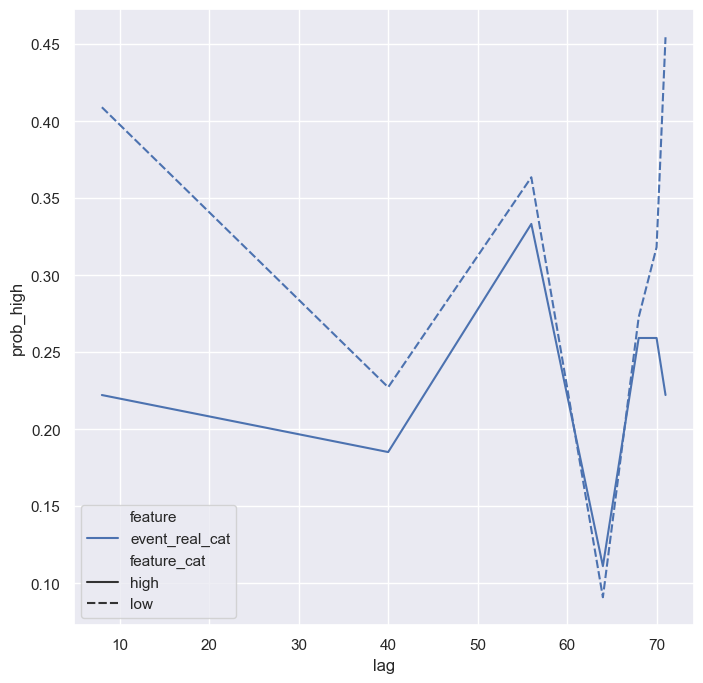

In [209]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
# plot through lag the prob high for each feature cat
sns.lineplot(
    data=df_prob[df_prob["feature"] == "event_real_cat"],
    x="lag",
    y="prob_high",
    hue="feature",
    style="feature_cat",
    ax=ax,
)

In [210]:
(72-8)*5 / 60

5.333333333333333

Here we can see that if the real event is positive around 5 hours before : 
- THEN the event target HIGH is 66% chance to happened 
- BE CAREFUL :  very low event number < 20

In [211]:
df_prob.sort_values(by=["delta_prob"], ascending=False).head(30)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
658          High_ETH_cat        high  64   13732  12136  0.263388  0.232776   
656          Open_ETH_cat        high  64   13747  12179  0.269681  0.238921   
440          High_ETH_cat        high  68    9229   7964  0.244782   0.21123   
450   ichi_tenkan_ETH_cat        high  68    5735   4763  0.235427  0.195525   
232   ichi_tenkan_ETH_cat        high  70    3749   3005   0.21799   0.17473   
438          Open_ETH_cat        high  68    9165   8008  0.252862  0.220941   
470     min_low_h_ETH_cat        high  68   10016   8807   0.29451  0.258961   
442           Low_ETH_cat        high  68   25480  23579  0.301456  0.278965   
14    ichi_tenkan_ETH_cat        high  71    2643   2059  0.208356  0.162318   
252     min_low_h_ETH_cat        high  70    6993   6033  0.299153  0.258085   
668   ichi_tenkan_ETH_cat        high  64    8674   7609  0.249612  0.218964   
220          Open_ETH_cat        high  70    5364   4540   0.23259  0.196861   
44         vwap_h_ETH_cat        high  71    2586   2028  0.203863  0.159874   
480        vwap_h_ETH_cat        high  68    4807   4036  0.225036  0.188942   
34      min_low_h_ETH_cat        high  71    4249   3528  0.334963  0.278124   
222          High_ETH_cat        high  70    5273   4480  0.216862  0.184248   
262        vwap_h_ETH_cat        high  70    3348   2736  0.210077  0.171676   
660           Low_ETH_cat        high  64   28603  26816  0.300051  0.281305   
698        vwap_h_ETH_cat        high  64    7133   6269  0.238969  0.210024   
224           Low_ETH_cat        high  70   19824  18404  0.300988  0.279429   
4            High_ETH_cat        high  71    2372   1901  0.187007  0.149874   
688     min_low_h_ETH_cat        high  64   13415  12380  0.289254  0.266937   
2            Open_ETH_cat        high  71    2570   2135  0.202601  0.168309   
876          High_ETH_cat        high  56   18005  16967  0.271798  0.256129   
46         vwap_d_ETH_cat        high  71    2481   2113  0.195585  0.166575   
886   ichi_tenkan_ETH_cat        high  56   12672  11840  0.261694  0.244512   
482        vwap_d_ETH_cat        high  68    3758   3316  0.208165  0.183681   
883  ichi_cloud_b_ETH_cat         low  56    4458   3988  0.252807  0.226154   
665  ichi_cloud_b_ETH_cat         low  64    3700   3279  0.245586  0.217642   
878           Low_ETH_cat        high  56   30615  29381  0.297811  0.285807   

     delta_prob  
658  196.939539  
656  189.664738  
440  186.148433  
450  179.993142  
232  163.913533  
438   155.90159  
470  155.307974  
442  147.324691  
14   145.068481  
252  141.501612  
668  139.314008  
220   137.11147  
44   134.964889  
480  134.443288  
34   133.686769  
222  128.954988  
262   123.12426  
660  115.244555  
698  111.400686  
224  105.493356  
4     103.83384  
688   83.056794  
2     80.435707  
876   61.617523  
46      58.9569  
886   56.480418  
482   55.234379  
883   52.308785  
665   50.792664  
878   50.761917

In [212]:
list_feat_high = list(df_prob.sort_values(by=["delta_prob"], ascending=False)["feature"].unique()[:10])

In [213]:
df_prob.sort_values(by=["delta_prob"]).head(30)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
251    max_high_h_ETH_cat         low  70    6308   7711  0.260909  0.318939   
223          High_ETH_cat         low  70   19281  21631  0.281425  0.315726   
441          High_ETH_cat         low  68   24757  27170   0.28343  0.311055   
659          High_ETH_cat         low  64   28456  30960  0.286145  0.311325   
439          Open_ETH_cat         low  68    8739  10149  0.232686  0.270229   
657          Open_ETH_cat         low  64   13407  15132  0.251699  0.284084   
469    max_high_h_ETH_cat         low  68    9535  10988  0.267709  0.308504   
661           Low_ETH_cat         low  64   12976  14656  0.245562  0.277355   
221          Open_ETH_cat         low  70    4842   5837  0.206976  0.249508   
33     max_high_h_ETH_cat         low  71    3587   4413  0.282775  0.347891   
687    max_high_h_ETH_cat         low  64   13326  14870  0.272979  0.304607   
443           Low_ETH_cat         low  68    8423   9648  0.222079  0.254377   
451   ichi_tenkan_ETH_cat         low  68    5105   5941  0.212673    0.2475   
233   ichi_tenkan_ETH_cat         low  70    3291   3911  0.193134  0.229519   
225           Low_ETH_cat         low  70    4704   5430  0.194164   0.22413   
481        vwap_h_ETH_cat         low  68    4476   5175  0.208302  0.240832   
669   ichi_tenkan_ETH_cat         low  64    8109   9032  0.234764  0.261486   
905    max_high_h_ETH_cat         low  56   18075  19392  0.282426  0.303005   
263        vwap_h_ETH_cat         low  70    3074   3625  0.193151  0.227773   
877          High_ETH_cat         low  56   31542  33217  0.291247  0.306713   
879           Low_ETH_cat         low  56   18295  19514  0.266501  0.284258   
875          Open_ETH_cat         low  56   19009  20218  0.271918  0.289213   
45         vwap_h_ETH_cat         low  71    2318   2750   0.18275  0.216809   
3            Open_ETH_cat         low  71    2345   2775  0.184864  0.218762   
1043        rsi_h_ETH_cat         low  56    3249   3739  0.256149  0.294781   
1242       chop_d_BTC_cat        high  40    3587   4098  0.282797  0.323084   
15    ichi_tenkan_ETH_cat         low  71    2321   2733  0.182986  0.215468   
699        vwap_h_ETH_cat         low  64    7000   7676  0.230551  0.252816   
7             Low_ETH_cat         low  71    2046   2406  0.161306  0.189688   
887   ichi_tenkan_ETH_cat         low  56   12591  13458  0.257222  0.274934   

      delta_prob  
251  -280.820173  
223  -269.969691  
441  -224.259788  
659    -211.0548  
439  -210.514612  
657  -208.530432  
469  -205.740779  
661  -204.284887  
221  -185.415301  
33      -170.569  
687  -169.097461  
443  -166.081014  
451  -126.542821  
233  -106.748126  
225  -104.021314  
481  -101.253963  
669   -99.402485  
905   -92.587557  
263   -90.640693  
877   -86.648188  
879    -78.60356  
875   -74.524231  
45    -73.647987  
3     -72.226562  
1043  -68.717802  
1242  -67.956018  
15    -67.172141  
699   -62.275279  
7     -58.221024  
887   -57.713463

In [214]:
list_feat_low = list(df_prob.sort_values(by=["delta_prob"])["feature"].unique()[:10])

In [215]:

list_feat_prob = list(set(list_feat_low + list_feat_high))
list_feat_prob

['ichi_cloud_b_ETH_cat',
 'max_high_h_ETH_cat',
 'Low_ETH_cat',
 'vwap_h_ETH_cat',
 'chop_d_BTC_cat',
 'ichi_tenkan_ETH_cat',
 'vwap_d_ETH_cat',
 'dxy_cat',
 'min_low_h_ETH_cat',
 'rsi_h_BTC_cat',
 'max_high_d_ETH_cat',
 'Open_ETH_cat',
 'High_ETH_cat',
 'rsi_h_ETH_cat']

<Axes: xlabel='lag', ylabel='delta_prob'>

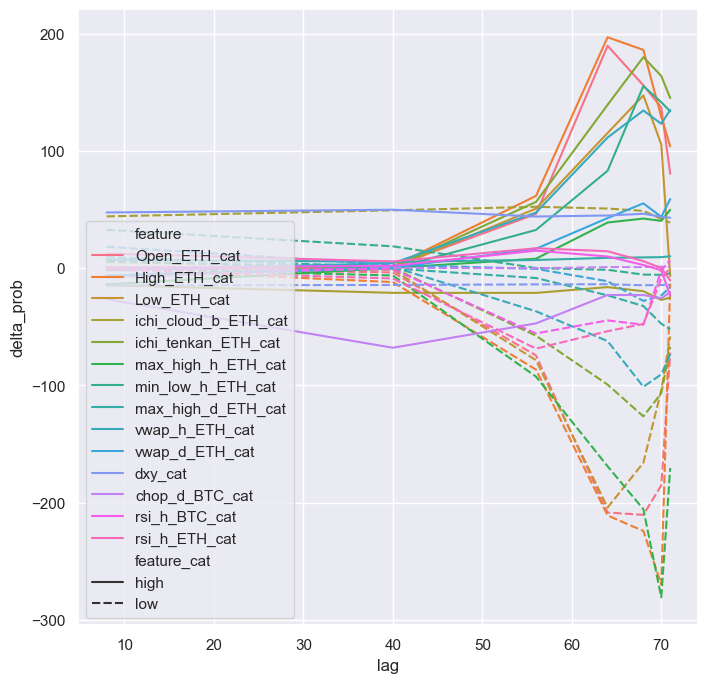

In [216]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
# plot through lag the prob high for each feature cat
sns.lineplot(
    data=df_prob[df_prob["feature"].isin(list_feat_prob)],
    x="lag",
    y="delta_prob",
    hue="feature",
    style="feature_cat",
    ax=ax,
)

<Axes: xlabel='lag', ylabel='prob_high'>

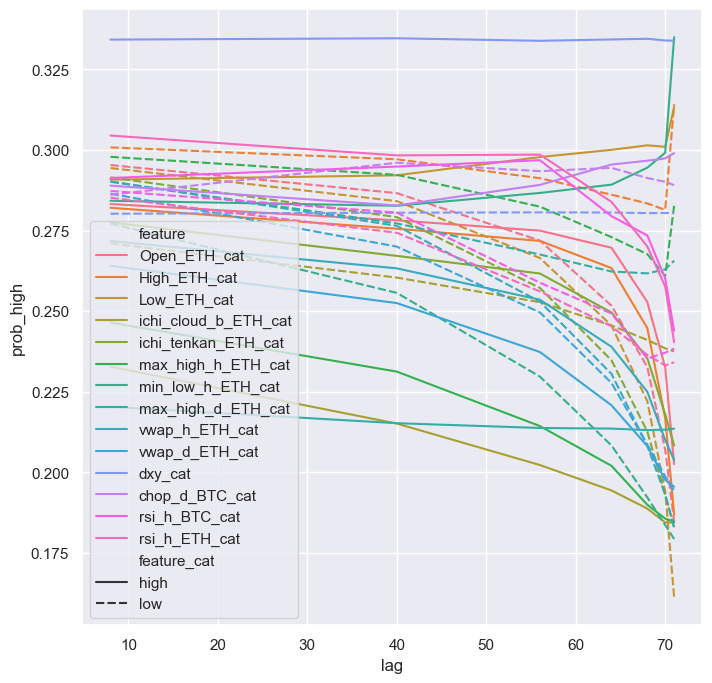

In [217]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
# plot through lag the prob high target for each feature cat
sns.lineplot(
    data=df_prob[df_prob["feature"].isin(list_feat_prob)],
    x="lag",
    y="prob_high",
    hue="feature",
    style="feature_cat",
    ax=ax,
)

In [218]:
df_prob[(df_prob["feature"] == "vwap_d_ETH_cat") & (df_prob["feature_cat"] == "high")].sort_values(by=["lag"])

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
1354  vwap_d_ETH_cat        high   8   16379  16700  0.264092  0.269268   
1136  vwap_d_ETH_cat        high  40   11731  11674  0.252529  0.251302   
918   vwap_d_ETH_cat        high  56    7898   7541  0.237348   0.22662   
700   vwap_d_ETH_cat        high  64    5280   4816  0.220819  0.201414   
482   vwap_d_ETH_cat        high  68    3758   3316  0.208165  0.183681   
264   vwap_d_ETH_cat        high  70    2898   2553  0.197681  0.174147   
46    vwap_d_ETH_cat        high  71    2481   2113  0.195585  0.166575   

     delta_prob  
1354  -6.229995  
1136   0.277633  
918   16.510007  
700   42.649762  
482   55.234379  
264   43.670886  
46      58.9569

<Axes: xlabel='lag', ylabel='prob_low'>

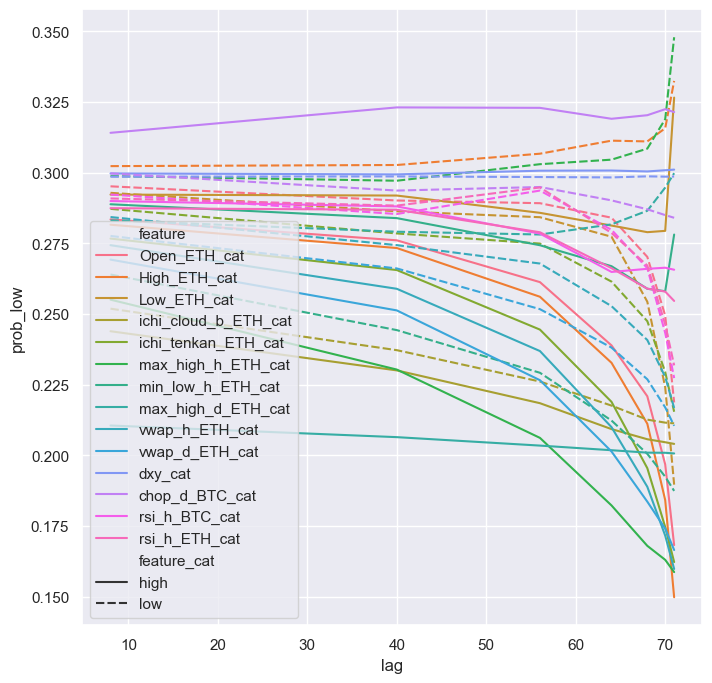

In [219]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
# plot through lag the prob low target for each feature cat
sns.lineplot(
    data=df_prob[df_prob["feature"].isin(list_feat_prob)],
    x="lag",
    y="prob_low",
    hue="feature",
    style="feature_cat",
    ax=ax,
)

In [220]:
df_['event_pred'].value_counts()

event_pred
 0.0    253628
 1.0        25
-1.0        24
Name: count, dtype: int64

In [221]:
len(list_df)

7

In [222]:
df = list_df[-1]

In [223]:
pd.crosstab(df['Volume_ETH_cat'], df['target_cat'], margins=True, normalize=True)

target_cat          high       low   neutral       All
Volume_ETH_cat                                        
high            0.012938  0.012390  0.024646  0.049973
low             0.016166  0.016596  0.017325  0.050087
neutral         0.267379  0.270107  0.362453  0.899940
All             0.296483  0.299093  0.404424  1.000000

##### With Best Positive Corr Features

max_high_h_ETH & Volume_ETH are the best positive impact on price. 

In [224]:
df_prob[
    (df_prob["feature"] == "max_high_h_ETH_cat") & (df_prob["feature_cat"] == "high")
    ].sort_values(by="prob_high", ascending=False)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
1340  max_high_h_ETH_cat        high   8   11629  12035  0.246497  0.255103   
1122  max_high_h_ETH_cat        high  40    8032   8001  0.231276  0.230384   
904   max_high_h_ETH_cat        high  56    5439   5232  0.214387  0.206228   
686   max_high_h_ETH_cat        high  64    3885   3506  0.202049  0.182338   
468   max_high_h_ETH_cat        high  68    2990   2645  0.189974  0.168054   
250   max_high_h_ETH_cat        high  70    2556   2245  0.185702  0.163107   
32    max_high_h_ETH_cat        high  71    2343   2014  0.184706   0.15877   

     delta_prob  
1340 -13.931373  
1122   0.119878  
904    8.030925  
686   38.869165  
468   42.244898  
250   40.292022  
32    49.686022

Correlation confirmed and good for strat 2

In [225]:
df_prob[
    (df_prob["feature"] == "Volume_ETH_cat") & (df_prob["feature_cat"] == "high")
    ].sort_values(by="prob_high", ascending=False)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
1458  Volume_ETH_cat        high   8    3282   3143  0.258894  0.247929   
1240  Volume_ETH_cat        high  40    3065   2994  0.241757  0.236157   
1022  Volume_ETH_cat        high  56    2788   2870  0.219822  0.226287   
804   Volume_ETH_cat        high  64    2690   2651  0.212095   0.20902   
586   Volume_ETH_cat        high  68    2452   2398   0.19333  0.189072   
368   Volume_ETH_cat        high  70    2280   2233  0.179768  0.176062   
150   Volume_ETH_cat        high  71    2144   2037  0.169032  0.160596   

     delta_prob  
1458   6.014319  
1240   1.663971  
1022  -2.376812  
804    0.569556  
586    1.202474  
368     0.97895  
150     5.47668

=> Correlation with less impact on strat 2

##### With Best Negative Corr Features
min_low_h_ETH & Close_ETH_raw are the best negative impact on price. 

In [226]:
##### On Best Negative Corr Features
df_prob[
    (df_prob["feature"] == "min_low_h_ETH_cat") & (df_prob["feature_cat"] == "high")
    ].sort_values(by="prob_low", ascending=False)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
1342  min_low_h_ETH_cat        high   8   24843  25243  0.284258  0.288835   
1124  min_low_h_ETH_cat        high  40   20919  21010  0.282704  0.283934   
34    min_low_h_ETH_cat        high  71    4249   3528  0.334963  0.278124   
906   min_low_h_ETH_cat        high  56   17193  16453  0.286684  0.274345   
688   min_low_h_ETH_cat        high  64   13415  12380  0.289254  0.266937   
470   min_low_h_ETH_cat        high  68   10016   8807   0.29451  0.258961   
252   min_low_h_ETH_cat        high  70    6993   6033  0.299153  0.258085   

      delta_prob  
1342   -6.389011  
1124   -0.395001  
34    133.686769  
906    32.550675  
688    83.056794  
470   155.307974  
252   141.501612

=> No clear conclusion

In [227]:
df_prob[
    (df_prob["feature"] == "Close_ETH_raw_cat") & (df_prob["feature_cat"] == "high")
    ].sort_values(by="prob_low", ascending=False)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
216   Close_ETH_raw_cat        high  71    3524   3810  0.277787  0.300331   
434   Close_ETH_raw_cat        high  70    3527   3801  0.278023  0.299622   
652   Close_ETH_raw_cat        high  68    3533   3785  0.278496   0.29836   
1306  Close_ETH_raw_cat        high  40    3515   3777  0.277077   0.29773   
1088  Close_ETH_raw_cat        high  56    3546   3762  0.279521  0.296547   
870   Close_ETH_raw_cat        high  64    3530   3754  0.278259  0.295917   
1524  Close_ETH_raw_cat        high   8    3535   3753  0.278654  0.295838   

     delta_prob  
216  -22.305972  
434  -20.490175  
652  -17.355562  
1306 -18.827208  
1088 -12.768473  
870  -13.777046  
1524 -13.041712

=> No clear conclusion

#### First LAG (oldest)
I_past closest to 0 is the oldest

In [228]:
len(list_df)

7

In [229]:
list_past

[71, 70, 68, 64, 56, 40, 8]

In [230]:
min_I_list_past = np.argmin(list_past)
min_I_list_past

np.int64(6)

In [231]:
df = list_df[min_I_list_past]

In [232]:
f"chi2_{list_past[min_I_list_past]}"

'chi2_8'

Text(0.5, 1.0, 'Min Chi2 between FIRST Lag and Target cat')

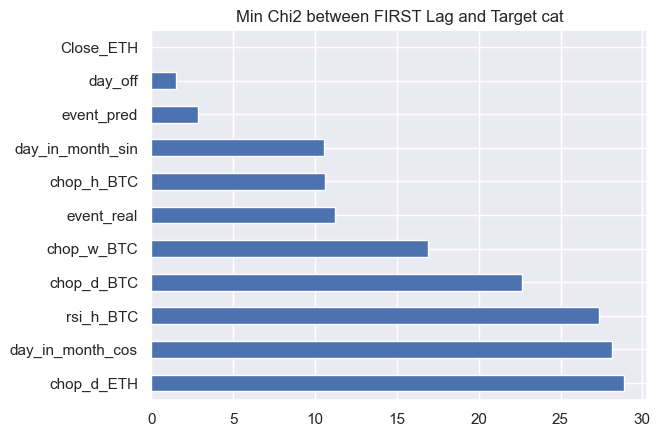

In [233]:
# find chi2_0 values in the 10% highest quantiles 
first_col_chi2 = f"chi2_{list_past[min_I_list_past]}"
min_quantile_chi2_10 = df_cont[first_col_chi2].quantile(0.10)
min_chi2_0 = df_cont[first_col_chi2].sort_values(ascending=False)
min_chi2_0[min_chi2_0.values<min_quantile_chi2_10].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Min Chi2 between FIRST Lag and Target cat")


Results : We can see that some features have less impact on distrib :
- we are not going to study them
- we are going to study the features with the highest chi2

Text(0.5, 1.0, 'Max Chi2 between FIRST Lag and Target cat')

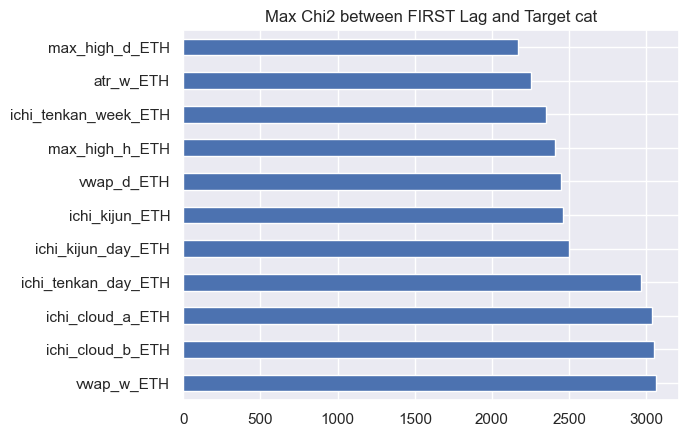

In [234]:
# find chi2_0 values in the 10% highest quantiles 
max_quantile_chi2_90 = df_cont[first_col_chi2].quantile(0.90)
max_chi2_0 = df_cont[first_col_chi2].sort_values(ascending=False)
max_chi2_0[max_chi2_0.values>max_quantile_chi2_90].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Max Chi2 between FIRST Lag and Target cat")

expected:  [[ 8229.48760432  8301.92276399 11225.5896317 ]
 [ 8802.58986822  8880.06941899 12007.3407128 ]
 [58178.92252747 58691.00781703 79360.06965551]]
target_cat         high      low   neutral     Total
vwap_w_ETH_cat                                      
high             6490.0   6719.0   14548.0   27757.0
low              7992.0   7420.0   14278.0   29690.0
neutral         60729.0  61734.0   73767.0  196230.0
total           75211.0  75873.0  102593.0  253677.0
xi_n =  3060.6547568932606
chi2:  3060.6547568932606
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


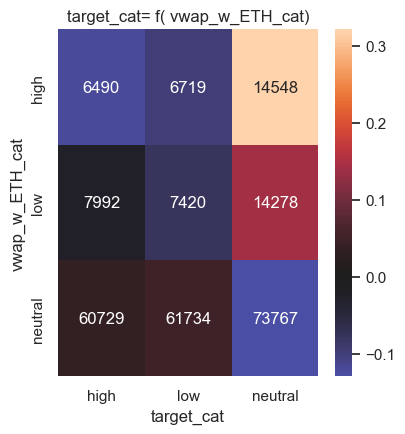

target_cat       high    low  neutral
vwap_w_ETH_cat                       
high             6490   6719    14548
low              7992   7420    14278
neutral         60729  61734    73767

In [235]:
feat_name_max = max_chi2_0.index[0]
# plot contingency table for the feature with the highest chi2
X = feat_name_max + "_cat"
Y = "target_cat"
I_past = 0
plot_cont(X=X, Y=Y, data=df)

In [236]:
Y

'target_cat'

In [237]:
len(list_col_select)

109

In [238]:
len(list_col_select)*(len(list_col_select)-1)*(len(list_col_select)-2)

1259604

In [239]:
3*3*3

27

In [240]:
# create contingency dataframe
col_name_0 = f"{max_chi2_0.index[0]}_cat"
col_name_1 = f"{max_chi2_0.index[1]}_cat"
col_name_2 = f"{max_chi2_0.index[2]}_cat"
df_cross = pd.crosstab([df[col_name_0], df[col_name_1], df[col_name_2]], df[Y], margins=False, dropna=False)
# get target names
target_cat_names = df_cross.columns.to_list()
print("target_cat_names: ", target_cat_names)
# get index lengths
nb_level_0 = len(df_cross.index.levels[0])
nb_level_1 = len(df_cross.index.levels[1])
nb_level_2 = len(df_cross.index.levels[2])  
nb_targets = df_cross.shape[1]
# create array contingency
arr_cont = np.empty((nb_level_0,nb_level_1,nb_level_2,nb_targets))
for I_0, level_0 in enumerate(df_cross.index.levels[0]):
    #print("#level_0: ", I_0)
    for I_1,level_1 in enumerate(df_cross.index.levels[1]):
        #print("#level_1: ", I_1)
        arr_cont[I_0, I_1] = df_cross.loc[(level_0, level_1)].values
print("arr_cont.shape : ", arr_cont.shape)
# add probs
df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
df_cross["chi2_delta_high"] = np.sign(df_cross["high"] - df_cross["low"]) * (df_cross["high"] - df_cross["low"])**2 / ((df_cross["low"] + df_cross["high"])/2)
# calc chi2, p-value, expected frequencies
res = stats.chi2_contingency(arr_cont)
print("chi2: ", res.statistic)
print("p-value: ", res.pvalue)
# add expected frequencies to df_cross
arr_exp = res.expected_freq.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"exp_{col}"] = arr_exp[:,I]
# get sign of difference between observed and expected frequencies
arr_sign = np.sign(arr_cont - res.expected_freq)
# calc chi2 ratio and add to df_cross
arr_chi2_ratio = arr_sign*((arr_cont - res.expected_freq)**2/res.expected_freq)/res.statistic
arr_chi2_ration_reshape = arr_chi2_ratio.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"chi2_pc_{col}"] = 100*arr_chi2_ration_reshape[:,I]
df_cross

target_cat_names:  ['high', 'low', 'neutral']
arr_cont.shape :  (3, 3, 3, 3)
chi2:  2328417.090625848
p-value:  0.0


target_cat                                                 high    low  \
vwap_w_ETH_cat ichi_cloud_b_ETH_cat ichi_cloud_a_ETH_cat                 
high           high                 high                   4717   4959   
                                    low                       0      0   
                                    neutral                 425    439   
               low                  high                      0      0   
                                    low                       6     10   
                                    neutral                   0      0   
               neutral              high                    343    377   
                                    low                      18     12   
                                    neutral                 981    922   
low            high                 high                      6     13   
                                    low                       0      0   
                                    neutral                   0      0   
               low                  high                      6      6   
                                    low                    6154   5615   
                                    neutral                 454    457   
               neutral              high                      5      3   
                                    low                     301    322   
                                    neutral                1066   1004   
neutral        high                 high                   1206   1230   
                                    low                       0      0   
                                    neutral                 186    211   
               low                  high                      0      0   
                                    low                    1620   1538   
                                    neutral                 335    345   
               neutral              high                   1503   1494   
                                    low                    1695   1638   
                                    neutral               54184  55278   

target_cat                                                neutral    p_high  \
vwap_w_ETH_cat ichi_cloud_b_ETH_cat ichi_cloud_a_ETH_cat                      
high           high                 high                    11463  0.223142   
                                    low                         0       NaN   
                                    neutral                   750  0.263321   
               low                  high                        0       NaN   
                                    low                        36  0.115385   
                                    neutral                     0       NaN   
               neutral              high                      652  0.250000   
                                    low                        19  0.367347   
                                    neutral                  1628  0.277825   
low            high                 high                       14  0.181818   
                                    low                         0       NaN   
                                    neutral                     0       NaN   
               low                  high                       25  0.162162   
                                    low                     11382  0.265820   
                                    neutral                   730  0.276661   
               neutral              high                       18  0.192308   
                                    low                       494  0.269472   
                                    neutral                  1615  0.289281   
neutral        high                 high                     2088  0.266578   
                                    low                         0       NaN   
                                    neutral                   382  0.238768   
               low                  

In [241]:
# Threshold of prob 40%  : to have 15% to 30% of gains with nb trades per months on average :
# - 30 trades (with 2.5% cap risk) => 15% gains
# - to 300 trades (0.5 % capital risk)  => 30% gains
prob_tot = df_cross[["high", "neutral","low"]].sum(axis=0) / df_cross[["high", "neutral","low"]].sum().sum()
print("prob_tot: ", prob_tot)
#prob_target = 0.33
nb_per_sub_cat = df_cross[["high","low","neutral"]].sum(axis=1)
nb_per_sub_cat
#df_cross["exp_trigger_high"] = nb_per_sub_cat * prob_target
#df_cross["exp_trigger_low"] = nb_per_sub_cat * prob_target
#df_cross["exp_trigger_neutral"] = nb_per_sub_cat * prob_target


#df_cross["chi2_trigger_low"] = np.sign(df_cross["low"] - df_cross["exp_trigger_low"]) * (df_cross["low"] - df_cross["exp_trigger_low"])**2 / df_cross["exp_trigger_low"]
#df_cross["chi2_trigger_neutral"] = np.sign(df_cross["neutral"] - df_cross["exp_trigger_neutral"]) *  (df_cross["neutral"] - df_cross["exp_trigger_neutral"])**2 / df_cross["exp_trigger_neutral"]

df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"])



prob_tot:  target_cat
high       0.296483
neutral    0.404424
low        0.299093
dtype: float64


high    low  \
vwap_w_ETH_cat ichi_cloud_b_ETH_cat ichi_cloud_a_ETH_cat                 
high           high                 high                   4717   4959   
                                    low                       0      0   
                                    neutral                 425    439   
               low                  high                      0      0   
                                    low                       6     10   
                                    neutral                   0      0   
               neutral              high                    343    377   
                                    low                      18     12   
                                    neutral                 981    922   
low            high                 high                      6     13   
                                    low                       0      0   
                                    neutral                   0      0   
               low                  high                      6      6   
                                    low                    6154   5615   
                                    neutral                 454    457   
               neutral              high                      5      3   
                                    low                     301    322   
                                    neutral                1066   1004   
neutral        high                 high                   1206   1230   
                                    low                       0      0   
                                    neutral                 186    211   
               low                  high                      0      0   
                                    low                    1620   1538   
                                    neutral                 335    345   
               neutral              high                   1503   1494   
                                    low                    1695   1638   
                                    neutral               54184  55278   

                                                          neutral    p_high  \
vwap_w_ETH_cat ichi_cloud_b_ETH_cat ichi_cloud_a_ETH_cat                      
high           high                 high                    11463  0.223142   
                                    low                         0       NaN   
                                    neutral                   750  0.263321   
               low                  high                        0       NaN   
                                    low                        36  0.115385   
                                    neutral                     0       NaN   
               neutral              high                      652  0.250000   
                                    low                        19  0.367347   
                                    neutral                  1628  0.277825   
low            high                 high                       14  0.181818   
                                    low                         0       NaN   
                                    neutral                     0       NaN   
               low                  high                       25  0.162162   
                                    low                     11382  0.265820   
                                    neutral                   730  0.276661   
               neutral              high                       18  0.192308   
                                    low                       494  0.269472   
                                    neutral                  1615  0.289281   
neutral        high                 high                     2088  0.266578   
                                    low                         0       NaN   
                                    neutral                   382  0.238768   
               low                  high                        0       NaN   
                

In [242]:
df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"]).loc[df_cross["chi2_delta_high"] > 10]

high   low  neutral  \
vwap_w_ETH_cat ichi_cloud_b_ETH_cat ichi_cloud_a_ETH_cat                        
low            low                  low                   6154  5615    11382   

                                                           p_high     p_low  \
vwap_w_ETH_cat ichi_cloud_b_ETH_cat ichi_cloud_a_ETH_cat                      
low            low                  low                   0.26582  0.242538   

                                                          p_neutral  \
vwap_w_ETH_cat ichi_cloud_b_ETH_cat ichi_cloud_a_ETH_cat              
low            low                  low                    0.491642   

                                                          chi2_delta_high  
vwap_w_ETH_cat ichi_cloud_b_ETH_cat ichi_cloud_a_ETH_cat                   
low            low                  low                          49.37055

In [243]:
df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"]).loc[df_cross["chi2_delta_high"] > 10].sum().sum() / df_cross.filter(["high","low","neutral"]).sum().sum()

np.float64(0.09146028433696922)

In [244]:
df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"]).loc[df_cross["chi2_delta_high"] < -10]

high    low  \
vwap_w_ETH_cat ichi_cloud_b_ETH_cat ichi_cloud_a_ETH_cat                 
high           high                 high                   4717   4959   
neutral        neutral              neutral               54184  55278   

                                                          neutral    p_high  \
vwap_w_ETH_cat ichi_cloud_b_ETH_cat ichi_cloud_a_ETH_cat                      
high           high                 high                    11463  0.223142   
neutral        neutral              neutral                 63475  0.313316   

                                                             p_low  p_neutral  \
vwap_w_ETH_cat ichi_cloud_b_ETH_cat ichi_cloud_a_ETH_cat                        
high           high                 high                  0.234590   0.542268   
neutral        neutral              neutral               0.319642   0.367041   

                                                          chi2_delta_high  
vwap_w_ETH_cat ichi_cloud_b_ETH_cat ichi_cloud_a_ETH_cat                   
high           high                 high                       -12.105002  
neutral        neutral              neutral                    -21.867607

In [245]:
df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"]).loc[df_cross["chi2_delta_high"] < -10].sum().sum() / df_cross.filter(["high","low","neutral"]).sum().sum()

np.float64(0.7649255840730913)

In [246]:
((2-1)**2) / 1


1.0

In [247]:
((2000-1000)**2) / 1000

1000.0

In [248]:
22000 / df.shape[0]

0.08672445669098894

In [249]:
100*5/60

8.333333333333334

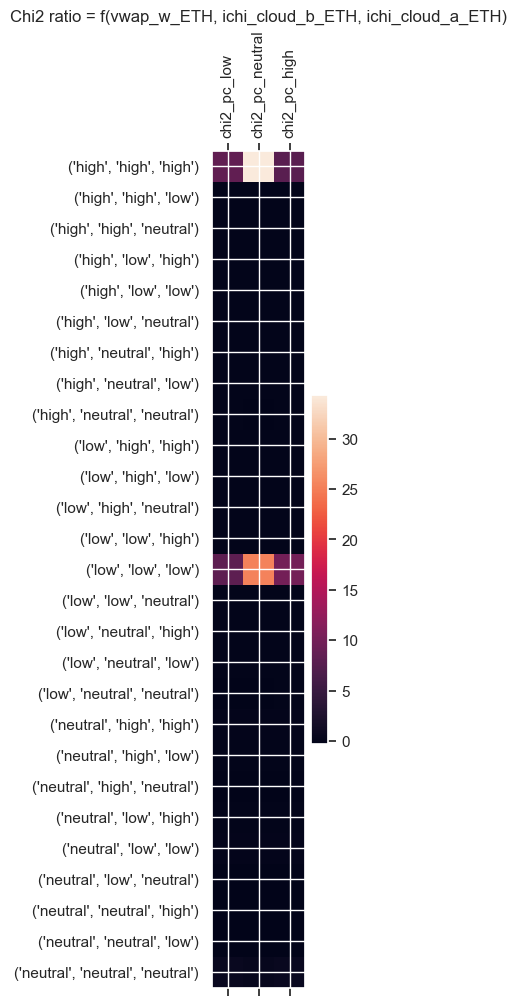

In [250]:
plot_corr(
    df_cross[["chi2_pc_low","chi2_pc_neutral","chi2_pc_high"]], 
    title = f"Chi2 ratio = f({max_chi2_0.index[0]}, {max_chi2_0.index[1]}, {max_chi2_0.index[2]})", 
    size=1.5,
)

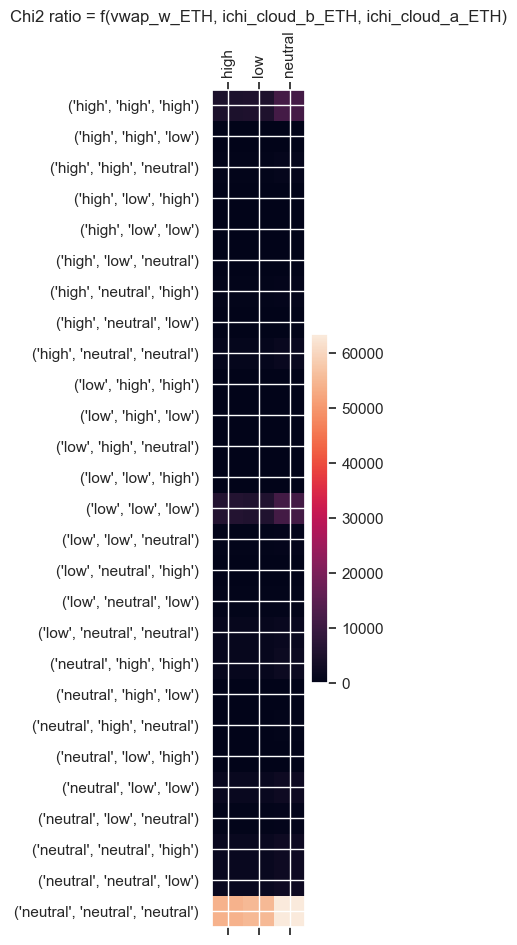

In [251]:
plot_corr(
    df_cross[["high","low","neutral"]], 
    title = f"Chi2 ratio = f({max_chi2_0.index[0]}, {max_chi2_0.index[1]}, {max_chi2_0.index[2]})", 
    size=1.5,
)

#### LAST Lag (newest)

In [252]:
list_past

[71, 70, 68, 64, 56, 40, 8]

In [253]:
df = list_df[0]

Text(0.5, 1.0, 'Min Chi2 between LAST Lag and LAST Target')

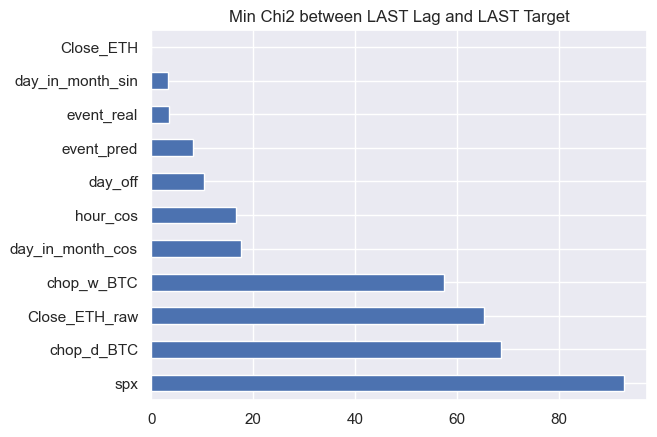

In [254]:
# find chi2_0 values in the 10% highest quantiles 
chi2_name = f"chi2_{list_past[0]}"
min_quantile_chi2_q10 = df_cont[chi2_name].quantile(0.10)
min_chi2_last = df_cont[chi2_name].sort_values(ascending=False)
min_chi2_last[min_chi2_last.values<min_quantile_chi2_q10].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Min Chi2 between LAST Lag and LAST Target")

Text(0.5, 1.0, 'Max Chi2 between LAST Lag and Target cat')

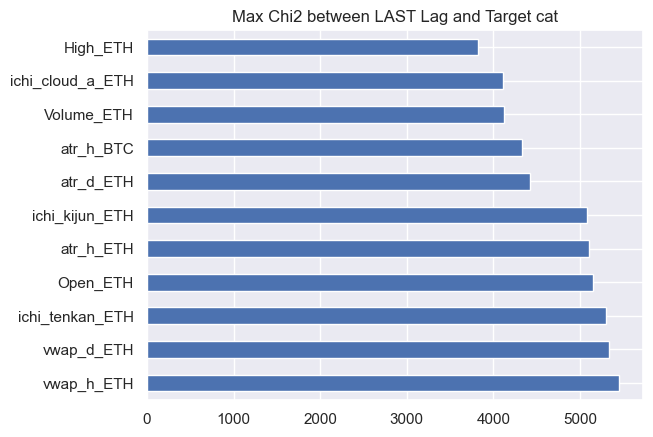

In [255]:
# find chi2_0 values in the 10% highest quantiles 
max_quantile_chi2_q90 = df_cont[chi2_name].quantile(0.90)
max_chi2_last = df_cont[chi2_name].sort_values(ascending=False)
max_chi2_last[max_chi2_last.values>max_quantile_chi2_q90].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Max Chi2 between LAST Lag and Target cat")

expected:  [[ 3760.89095582  3793.99395688  5130.1150873 ]
 [ 3760.5944725   3793.69486394  5129.71066356]
 [67689.51457168 68285.31117918 92333.17424914]]
target_cat         high      low   neutral     Total
vwap_h_ETH_cat                                      
high             2586.0   2028.0    8071.0   12685.0
low              2318.0   2750.0    7616.0   12684.0
neutral         70307.0  71095.0   86906.0  228308.0
total           75211.0  75873.0  102593.0  253677.0
xi_n =  5456.353287441722
chi2:  5456.353287441723
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


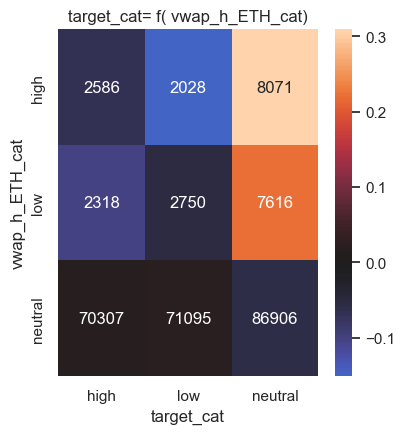

target_cat       high    low  neutral
vwap_h_ETH_cat                       
high             2586   2028     8071
low              2318   2750     7616
neutral         70307  71095    86906

In [256]:
feat_name_max = max_chi2_last.index[0]
# plot contingency table for the feature with the highest chi2
X = feat_name_max + "_cat"
Y = "target_cat"
plot_cont(X=X, Y=Y, data=df)

In [257]:
Y

'target_cat'

In [258]:
X

'vwap_h_ETH_cat'

In [259]:
max_chi2_last.index[1]

'vwap_d_ETH'

In [260]:
# create contingency dataframe
col_name_0 = f"{max_chi2_last.index[0]}_cat"
col_name_1 = f"{max_chi2_last.index[1]}_cat"
col_name_2 = f"{max_chi2_last.index[2]}_cat"
df_cross = pd.crosstab([df[col_name_0], df[col_name_1], df[col_name_2]], df[Y], margins=False, dropna=False)
# get target names
target_cat_names = df_cross.columns.to_list()
print("target_cat_names: ", target_cat_names)
# get index lengths
nb_level_0 = len(df_cross.index.levels[0])
nb_level_1 = len(df_cross.index.levels[1])
nb_level_2 = len(df_cross.index.levels[2])  
nb_targets = df_cross.shape[1]
# create array contingency
arr_cont = np.empty((nb_level_0,nb_level_1,nb_level_2,nb_targets))
for I_0, level_0 in enumerate(df_cross.index.levels[0]):
    #print("#level_0: ", I_0)
    for I_1,level_1 in enumerate(df_cross.index.levels[1]):
        #print("#level_1: ", I_1)
        arr_cont[I_0, I_1] = df_cross.loc[(level_0, level_1)].values
print("arr_cont.shape : ", arr_cont.shape)
# add probs
df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
df_cross["chi2_delta_high"] = np.sign(df_cross["high"] - df_cross["low"]) * (df_cross["high"] - df_cross["low"])**2 / ((df_cross["low"] + df_cross["high"])/2)
# calc chi2, p-value, expected frequencies
res = stats.chi2_contingency(arr_cont)
print("chi2: ", res.statistic)
print("p-value: ", res.pvalue)
# add expected frequencies to df_cross
arr_exp = res.expected_freq.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"exp_{col}"] = arr_exp[:,I]
# get sign of difference between observed and expected frequencies
arr_sign = np.sign(arr_cont - res.expected_freq)
# calc chi2 ratio and add to df_cross
arr_chi2_ratio = arr_sign*((arr_cont - res.expected_freq)**2/res.expected_freq)/res.statistic
arr_chi2_ration_reshape = arr_chi2_ratio.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"chi2_pc_{col}"] = 100*arr_chi2_ration_reshape[:,I]
df_cross

target_cat_names:  ['high', 'low', 'neutral']
arr_cont.shape :  (3, 3, 3, 3)
chi2:  4328354.998715012
p-value:  0.0


target_cat                                          high    low  neutral  \
vwap_h_ETH_cat vwap_d_ETH_cat ichi_tenkan_ETH_cat                          
high           high           high                  1377   1082     5077   
                              low                      2      3       22   
                              neutral                350    322     1034   
               low            high                     2      2        7   
                              low                      0      0        0   
                              neutral                  0      1        2   
               neutral        high                   545    385     1245   
                              low                      0      0        3   
                              neutral                310    233      681   
low            high           high                     0      0        0   
                              low                      1      0        3   
                              neutral                  0      1        3   
               low            high                     0      1        3   
                              low                   1177   1366     4549   
                              neutral                390    408     1028   
               neutral        high                     0      0        2   
                              low                    431    554     1312   
                              neutral                319    420      716   
neutral        high           high                    95     91      234   
                              low                     19     19       81   
                              neutral                637    595     1637   
               low            high                     6      9       55   
                              low                     81     87      227   
                              neutral                809    796     1678   
               neutral        high                   618    489     1360   
                              low                    610    704     1433   
                              neutral              67432  68305    80201   

target_cat                                           p_high     p_low  \
vwap_h_ETH_cat vwap_d_ETH_cat ichi_tenkan_ETH_cat                       
high           high           high                 0.182723  0.143577   
                              low                  0.074074  0.111111   
                              neutral              0.205158  0.188746   
               low            high                 0.181818  0.181818   
                              low                       NaN       NaN   
                              neutral              0.000000  0.333333   
               neutral        high                 0.250575  0.177011   
                              low                  0.000000  0.000000   
                              neutral              0.253268  0.190359   
low            high           high                      NaN       NaN   
                              low                  0.250000  0.000000   
                              neutral              0.000000  0.250000   
               low            high                 0.000000  0.250000   
                              low                  0.165962  0.192611   
                              neutral              0.213582  0.223439   
               neutral        high                 0.000000  0.000000   
                              low                  0.187636  0.241184   
                              neutral              0.219244  0.288660   
neutral        high           high                 0.226190  0.216667   
                              low                  0.159664  0.159664   
                              neutral              0.222029  0.207389   
               low            high                 0.085714  0.128571   
                              low          

In [261]:
# df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# df_cross

In [262]:
df_cross["high"] / df.shape[0]

vwap_h_ETH_cat  vwap_d_ETH_cat  ichi_tenkan_ETH_cat
high            high            high                   0.005428
                                low                    0.000008
                                neutral                0.001380
                low             high                   0.000008
                                low                    0.000000
                                neutral                0.000000
                neutral         high                   0.002148
                                low                    0.000000
                                neutral                0.001222
low             high            high                   0.000000
                                low                    0.000004
                                neutral                0.000000
                low             high                   0.000000
                                low                    0.004640
                                neutral             

In [263]:
df_cross["high"].sum() / df_cross[["high", "neutral","low"]].sum().sum()

np.float64(0.2964833232811804)

In [264]:
df_cross["low"].sum() / df_cross[["high", "neutral","low"]].sum().sum()

np.float64(0.2990929410234274)

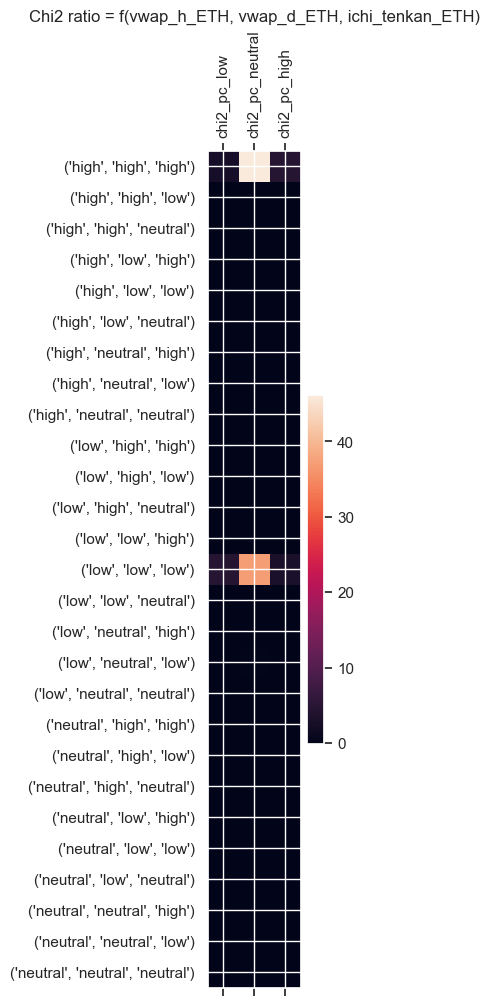

In [265]:
plot_corr(
    df_cross[["chi2_pc_low","chi2_pc_neutral","chi2_pc_high"]], 
    title = f"Chi2 ratio = f({max_chi2_last.index[0]}, {max_chi2_last.index[1]}, {max_chi2_last.index[2]})", 
    size=1.5,
)

In [266]:
list_len_levels = []
for I in range(len(df_cross.index.levels)): 
    list_len_levels.append(len(df_cross.index.levels[I]))
list_len_levels

[3, 3, 3]

In [267]:
df_cross.index.unique(level=2)

Index(['high', 'low', 'neutral'], dtype='object', name='ichi_tenkan_ETH_cat')

##### check on first LAG (oldest)
We keep the same Features to do the cross table, and apply cat using for the FIRST Lag (oldest)  
To detect if these features are still important with oldest time

In [268]:
list_past[-1]

8

In [269]:
df = list_df[-1]

In [270]:
# create contingency dataframe
col_name_0 = f"{max_chi2_last.index[0]}_cat"
col_name_1 = f"{max_chi2_last.index[1]}_cat"
col_name_2 = f"{max_chi2_last.index[2]}_cat"
df_cross = pd.crosstab([df[col_name_0], df[col_name_1], df[col_name_2]], df[Y], margins=False, dropna=False)
# get target names
target_cat_names = df_cross.columns.to_list()
print("target_cat_names: ", target_cat_names)
# get index lengths
nb_level_0 = len(df_cross.index.levels[0])
nb_level_1 = len(df_cross.index.levels[1])
nb_level_2 = len(df_cross.index.levels[2])  
nb_targets = df_cross.shape[1]
# create array contingency
arr_cont = np.empty((nb_level_0,nb_level_1,nb_level_2,nb_targets))
for I_0, level_0 in enumerate(df_cross.index.levels[0]):
    #print("#level_0: ", I_0)
    for I_1,level_1 in enumerate(df_cross.index.levels[1]):
        #print("#level_1: ", I_1)
        arr_cont[I_0, I_1] = df_cross.loc[(level_0, level_1)].values
print("arr_cont.shape : ", arr_cont.shape)
# add probs
df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
df_cross["chi2_delta_high"] = np.sign(df_cross["high"] - df_cross["low"]) * (df_cross["high"] - df_cross["low"])**2 / ((df_cross["low"] + df_cross["high"])/2)
# calc chi2, p-value, expected frequencies
res = stats.chi2_contingency(arr_cont)
print("chi2: ", res.statistic)
print("p-value: ", res.pvalue)
# add expected frequencies to df_cross
arr_exp = res.expected_freq.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"exp_{col}"] = arr_exp[:,I]
# get sign of difference between observed and expected frequencies
arr_sign = np.sign(arr_cont - res.expected_freq)
# calc chi2 ratio and add to df_cross
arr_chi2_ratio = arr_sign*((arr_cont - res.expected_freq)**2/res.expected_freq)/res.statistic
arr_chi2_ration_reshape = arr_chi2_ratio.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"chi2_pc_{col}"] = 100*arr_chi2_ration_reshape[:,I]
df_cross

target_cat_names:  ['high', 'low', 'neutral']
arr_cont.shape :  (3, 3, 3, 3)
chi2:  1484488.4843550231
p-value:  0.0


target_cat                                          high    low  neutral  \
vwap_h_ETH_cat vwap_d_ETH_cat ichi_tenkan_ETH_cat                          
high           high           high                 15826  16093    28050   
                              low                      1      1        4   
                              neutral                158    207      311   
               low            high                     3      2        2   
                              low                      0      0        0   
                              neutral                  1      0        0   
               neutral        high                  3609   3461     4398   
                              low                      2      2        0   
                              neutral                140    163      202   
low            high           high                     0      0        0   
                              low                      0      0        3   
                              neutral                  0      1        1   
               low            high                     0      0        2   
                              low                  18161  17566    27608   
                              neutral                204    218      355   
               neutral        high                     1      0        1   
                              low                   3485   3625     4124   
                              neutral                210    199      241   
neutral        high           high                   105     77      137   
                              low                     12     14       21   
                              neutral                277    307      414   
               low            high                     7      8       17   
                              low                    103    112      152   
                              neutral                389    380      576   
               neutral        high                  2389   2232     2629   
                              low                   1947   2041     2354   
                              neutral              28181  29164    30991   

target_cat                                           p_high     p_low  \
vwap_h_ETH_cat vwap_d_ETH_cat ichi_tenkan_ETH_cat                       
high           high           high                 0.263903  0.268355   
                              low                  0.166667  0.166667   
                              neutral              0.233728  0.306213   
               low            high                 0.428571  0.285714   
                              low                       NaN       NaN   
                              neutral              1.000000  0.000000   
               neutral        high                 0.314702  0.301796   
                              low                  0.500000  0.500000   
                              neutral              0.277228  0.322772   
low            high           high                      NaN       NaN   
                              low                  0.000000  0.000000   
                              neutral              0.000000  0.500000   
               low            high                 0.000000  0.000000   
                              low                  0.286745  0.277351   
                              neutral              0.262548  0.280566   
               neutral        high                 0.500000  0.000000   
                              low                  0.310219  0.322681   
                              neutral              0.323077  0.306154   
neutral        high           high                 0.329154  0.241379   
                              low                  0.255319  0.297872   
                              neutral              0.277555  0.307615   
               low            high                 0.218750  0.250000   
                              low          

Results : same rank for chi-2  as for last lag, but smaller values: time between have impact => less direct impact

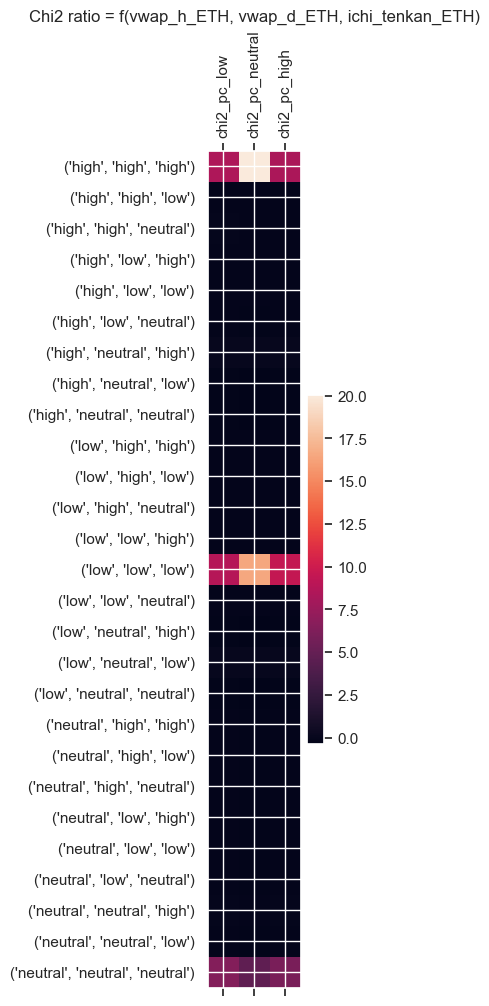

In [271]:
plot_corr(
    df_cross[["chi2_pc_low","chi2_pc_neutral","chi2_pc_high"]], 
    title = f"Chi2 ratio = f({max_chi2_last.index[0]}, {max_chi2_last.index[1]}, {max_chi2_last.index[2]})", 
    size=1.5,
)

expected:  [[21535.36266985 21724.91486418 29375.72246597]
 [22534.21498599 22732.55898249 30738.22603153]
 [31141.42234416 31415.52615334 42479.0515025 ]]
target_cat         high      low   neutral     Total
vwap_h_ETH_cat                                      
high            19740.0  19929.0   32967.0   72636.0
low             22061.0  21609.0   32335.0   76005.0
neutral         33410.0  34335.0   37291.0  105036.0
total           75211.0  75873.0  102593.0  253677.0
xi_n =  1955.7975019758496
chi2:  1955.7975019758496
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


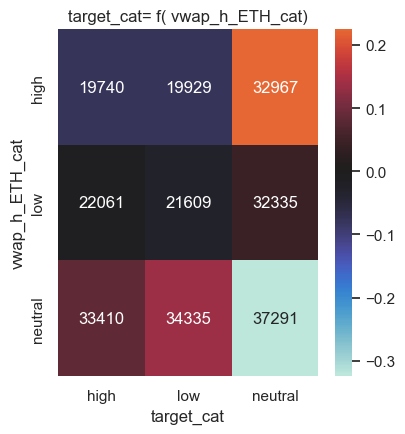

target_cat       high    low  neutral
vwap_h_ETH_cat                       
high            19740  19929    32967
low             22061  21609    32335
neutral         33410  34335    37291

In [272]:
X = feat_name_max + "_cat"
Y = "target_cat"
plot_cont(X=X, Y=Y, data=df)

### Prob study

In [273]:
list_past

[71, 70, 68, 64, 56, 40, 8]

In [274]:

def get_index_combinations(n_elements, k_selection):
    """
    Generates all combinations of indices for selecting k elements from a list of n.

    Args:
        n_elements (int): The total number of elements in the list.
        k_selection (int): The number of elements to choose in each combination.

    Returns:
        list: A list of tuples, where each tuple is a combination of indices.
    """
    # Create a list of indices from 0 to n_elements - 1
    indices = range(n_elements)

    # Generate the combinations
    combinations = list(itertools.combinations(indices, k_selection))
    
    return combinations

In [275]:
get_index_combinations(6, 3)

[(0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 3, 4),
 (0, 3, 5),
 (0, 4, 5),
 (1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 3, 4),
 (1, 3, 5),
 (1, 4, 5),
 (2, 3, 4),
 (2, 3, 5),
 (2, 4, 5),
 (3, 4, 5)]

#### On Highest delta_prob
delta prob between high and low

##### Per feature, per lag

In [276]:
df_prob.sort_values(by=["delta_prob"], ascending=False).head(7)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
658         High_ETH_cat        high  64   13732  12136  0.263388  0.232776   
656         Open_ETH_cat        high  64   13747  12179  0.269681  0.238921   
440         High_ETH_cat        high  68    9229   7964  0.244782   0.21123   
450  ichi_tenkan_ETH_cat        high  68    5735   4763  0.235427  0.195525   
232  ichi_tenkan_ETH_cat        high  70    3749   3005   0.21799   0.17473   
438         Open_ETH_cat        high  68    9165   8008  0.252862  0.220941   
470    min_low_h_ETH_cat        high  68   10016   8807   0.29451  0.258961   

     delta_prob  
658  196.939539  
656  189.664738  
440  186.148433  
450  179.993142  
232  163.913533  
438   155.90159  
470  155.307974

In [277]:
df_prob.sort_values(by=["delta_prob"], ascending=True).head(7)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
251  max_high_h_ETH_cat         low  70    6308   7711  0.260909  0.318939   
223        High_ETH_cat         low  70   19281  21631  0.281425  0.315726   
441        High_ETH_cat         low  68   24757  27170   0.28343  0.311055   
659        High_ETH_cat         low  64   28456  30960  0.286145  0.311325   
439        Open_ETH_cat         low  68    8739  10149  0.232686  0.270229   
657        Open_ETH_cat         low  64   13407  15132  0.251699  0.284084   
469  max_high_h_ETH_cat         low  68    9535  10988  0.267709  0.308504   

     delta_prob  
251 -280.820173  
223 -269.969691  
441 -224.259788  
659   -211.0548  
439 -210.514612  
657 -208.530432  
469 -205.740779

In [278]:
# check with best linear correlation features
# compare best correlation tuples (feat, lag) and the best delta_prob tuple (feat, lag)

##### Per combinaison of 3 tuples of feature/lag

In [279]:
# algo check new data : 
# - hash input of function : hash of df_prob
# - compare with input hash file on disk : path_prob_hash
# - if same, load df_prob_comb : path_df_prob_comb

# hash input
hash_df_prob_comb_inputs =(get_data_hash(df_prob) + get_data_hash(df_targets))
# load df_prob file hash
path_prob_comb_inputs_hash = os.path.join(path_data, 'df_prob_comb_inputs_hash.txt')
hash_df_prob_comb_inputs_old = load_hash(path_prob_comb_inputs_hash)

# compare hash
if hash_df_prob_comb_inputs == hash_df_prob_comb_inputs_old:
    print("hash match: mode LOAD df_prob_comb")
    # load df_prob_comb
    df_prob_comb = pd.read_csv(path_df_prob_comb)
    mode_do_comb = False
else:
    print("hash not match : mode REDO comb")
    mode_do_comb = True

hash not match : mode REDO comb


In [280]:
# Probability  of target high or low for Combination of best features (highest and lowest delta_prob) 
# Combinaison of 3 features (1 feat = 1 feature on one lag)
nb_best_feat = 30 # limited to 30th first ones
df_prob_high = df_prob.sort_values(by=["delta_prob"], ascending=False).head(nb_best_feat)
df_prob_low = df_prob.sort_values(by=["delta_prob"], ascending=True).head(nb_best_feat)
list_study_feat_high = df_prob_high["feature"].values
list_study_lag_high = df_prob_high["lag"].values
list_study_I_past_high = [np.argmax(np.array(list_past) == x) for x in list_study_lag_high]
list_study_feat_low = df_prob_low["feature"].values
list_study_lag_low = df_prob_low["lag"].values
list_study_I_past_low = [np.argmax(np.array(list_past) == x) for x in list_study_lag_low]
for I in range(len(list_study_feat_high)):
    print(list_study_feat_high[I], list_study_lag_high[I])
for I in range(len(list_study_feat_low)):
    print(list_study_feat_low[I], list_study_lag_low[I])

# Target cat = High
# get all combinaisons
list_comb_high = get_index_combinations(len(list_study_feat_high), 3)
print("Cross Table Computaton nb : len(list_comb_high) : ", len(list_comb_high))
# Target cat = Low
# get all combinaisons
list_comb_low = get_index_combinations(len(list_study_feat_low), 3)
print("Cross Table Computaton nb : len(list_comb_low) : ", len(list_comb_low))

if mode_do_comb :
    list_cross = []
    df_prob_comb = pd.DataFrame()
    # HIGH
    for comb in list_comb_high:
        col_name_0 = list_study_feat_high[comb[0]]
        col_name_1 = list_study_feat_high[comb[1]]
        col_name_2 = list_study_feat_high[comb[2]]
        I_past_0 = list_study_I_past_high[comb[0]]
        I_past_1 = list_study_I_past_high[comb[1]]
        I_past_2 = list_study_I_past_high[comb[2]]
        lag_0 = list_study_lag_high[comb[0]]
        lag_1 = list_study_lag_high[comb[1]]
        lag_2 = list_study_lag_high[comb[2]]
        df_cross_comb = pd.crosstab(
            [
                list_df[I_past_0][col_name_0],
                list_df[I_past_1][col_name_1], 
                list_df[I_past_2][col_name_2],
            ],
            df_targets["target_cat"], 
            margins=False, 
            dropna=False
        )
        # add probs
        df_cross_comb["p_high"] = df_cross_comb["high"] / (df_cross_comb["high"] + df_cross_comb["low"]+ df_cross_comb["neutral"])
        df_cross_comb["p_low"] = df_cross_comb["low"] / (df_cross_comb["high"] + df_cross_comb["low"]+ df_cross_comb["neutral"])
        # just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
        df_cross_comb["delta_prob"] = np.sign(
            df_cross_comb["high"] - df_cross_comb["low"]) * (
                df_cross_comb["high"] - df_cross_comb["low"])**2 / (
                    (df_cross_comb["low"] + df_cross_comb["high"])/2)
        list_cross.append(df_cross_comb)
        df_cross_comb = df_cross_comb.reset_index(allow_duplicates=True)
        df_cross_comb["feat_0"] = df_cross_comb.columns[0]
        df_cross_comb["feat_0_cat"] = df_cross_comb.values[:,0]
        df_cross_comb["lag_0"] = lag_0
        df_cross_comb["feat_1"] = df_cross_comb.columns[1]
        df_cross_comb["feat_1_cat"] = df_cross_comb.values[:,1]
        df_cross_comb["lag_1"] = lag_1
        df_cross_comb["feat_2"] = df_cross_comb.columns[2]
        df_cross_comb["feat_2_cat"] = df_cross_comb.values[:,2]
        df_cross_comb["lag_2"] = lag_2
        df_cross_comb.drop(columns=[col_name_0, col_name_1, col_name_2], inplace=True)
        if df_prob_comb.shape[0] == 0:
            df_prob_comb = df_cross_comb
        else:
            #pd.concat([df_prob, ser_prob_curr.to_frame().T], ignore_index=True)
            df_prob_comb = pd.concat([df_prob_comb, df_cross_comb], ignore_index=True)
    print(" ")
    print("Cross Table Computed nb : len(list_cross) : ", len(list_cross))

    # LOW
    for comb in list_comb_low:
        col_name_0 = list_study_feat_low[comb[0]]
        col_name_1 = list_study_feat_low[comb[1]]
        col_name_2 = list_study_feat_low[comb[2]]
        I_past_0 = list_study_I_past_low[comb[0]]
        I_past_1 = list_study_I_past_low[comb[1]]
        I_past_2 = list_study_I_past_low[comb[2]]
        lag_0 = list_study_lag_low[comb[0]]
        lag_1 = list_study_lag_low[comb[1]]
        lag_2 = list_study_lag_low[comb[2]]
        df_cross_comb = pd.crosstab(
            [
                list_df[I_past_0][col_name_0],
                list_df[I_past_1][col_name_1], 
                list_df[I_past_2][col_name_2]
            ],
            df_targets["target_cat"], 
            margins=False, 
            dropna=False
        )
        # add probs
        df_cross_comb["p_high"] = df_cross_comb["high"] / (df_cross_comb["high"] + df_cross_comb["low"]+ df_cross_comb["neutral"])
        df_cross_comb["p_low"] = df_cross_comb["low"] / (df_cross_comb["high"] + df_cross_comb["low"]+ df_cross_comb["neutral"])
        # just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
        df_cross_comb["delta_prob"] = np.sign(
            df_cross_comb["high"] - df_cross_comb["low"]) * (
                df_cross_comb["high"] - df_cross_comb["low"])**2 / (
                    (df_cross_comb["low"] + df_cross_comb["high"])/2)
        list_cross.append(df_cross_comb)
        df_cross_comb = df_cross_comb.reset_index(allow_duplicates=True)
        df_cross_comb["feat_0"] = df_cross_comb.columns[0]
        df_cross_comb["feat_0_cat"] = df_cross_comb.values[:,0]
        df_cross_comb["lag_0"] = lag_0
        df_cross_comb["feat_1"] = df_cross_comb.columns[1]
        df_cross_comb["feat_1_cat"] = df_cross_comb.values[:,1]
        df_cross_comb["lag_1"] = lag_1
        df_cross_comb["feat_2"] = df_cross_comb.columns[2]
        df_cross_comb["feat_2_cat"] = df_cross_comb.values[:,2]
        df_cross_comb["lag_2"] = lag_2
        df_cross_comb.drop(columns=[col_name_0, col_name_1, col_name_2], inplace=True)
        if df_prob_comb.shape[0] == 0:
            df_prob_comb = df_cross_comb
        else:
            #pd.concat([df_prob, ser_prob_curr.to_frame().T], ignore_index=True)
            df_prob_comb = pd.concat([df_prob_comb, df_cross_comb], ignore_index=True)

    # save CSV
    df_prob_comb.to_csv(path_df_prob_comb, index=False)
    # save hash inputs
    with open(path_prob_comb_inputs_hash, 'w') as file:
        file.write(hash_df_prob_comb_inputs)
df_prob_comb.sort_values(by=["delta_prob"], ascending=False)


High_ETH_cat 64
Open_ETH_cat 64
High_ETH_cat 68
ichi_tenkan_ETH_cat 68
ichi_tenkan_ETH_cat 70
Open_ETH_cat 68
min_low_h_ETH_cat 68
Low_ETH_cat 68
ichi_tenkan_ETH_cat 71
min_low_h_ETH_cat 70
ichi_tenkan_ETH_cat 64
Open_ETH_cat 70
vwap_h_ETH_cat 71
vwap_h_ETH_cat 68
min_low_h_ETH_cat 71
High_ETH_cat 70
vwap_h_ETH_cat 70
Low_ETH_cat 64
vwap_h_ETH_cat 64
Low_ETH_cat 70
High_ETH_cat 71
min_low_h_ETH_cat 64
Open_ETH_cat 71
High_ETH_cat 56
vwap_d_ETH_cat 71
ichi_tenkan_ETH_cat 56
vwap_d_ETH_cat 68
ichi_cloud_b_ETH_cat 56
ichi_cloud_b_ETH_cat 64
Low_ETH_cat 56
max_high_h_ETH_cat 70
High_ETH_cat 70
High_ETH_cat 68
High_ETH_cat 64
Open_ETH_cat 68
Open_ETH_cat 64
max_high_h_ETH_cat 68
Low_ETH_cat 64
Open_ETH_cat 70
max_high_h_ETH_cat 71
max_high_h_ETH_cat 64
Low_ETH_cat 68
ichi_tenkan_ETH_cat 68
ichi_tenkan_ETH_cat 70
Low_ETH_cat 70
vwap_h_ETH_cat 68
ichi_tenkan_ETH_cat 64
max_high_h_ETH_cat 56
vwap_h_ETH_cat 70
High_ETH_cat 56
Low_ETH_cat 56
Open_ETH_cat 56
vwap_h_ETH_cat 71
Open_ETH_cat 71
rsi_

target_cat  high   low  neutral    p_high     p_low  delta_prob  \
144857      7935  6545    14394  0.274815  0.226675  266.864641   
142290      8368  6987    15920  0.267562  0.223405  248.409118   
4374        8368  6987    15920  0.267562  0.223405  248.409118   
140888      5761  4636    12072  0.256398  0.206329  243.459652   
3213        3463  2613     7906  0.247676  0.186883  237.820935   
...          ...   ...      ...       ...       ...         ...   
218926         0     0        1  0.000000  0.000000         NaN   
219009         0     0        2  0.000000  0.000000         NaN   
219162         0     0        1  0.000000  0.000000         NaN   
219169         0     0        1  0.000000  0.000000         NaN   
219214         0     0        0       NaN       NaN         NaN   

target_cat               feat_0 feat_0_cat  lag_0               feat_1  \
144857             High_ETH_cat       high     64          Low_ETH_cat   
142290             High_ETH_cat       high     64          Low_ETH_cat   
4374               High_ETH_cat       high     64          Low_ETH_cat   
140888             High_ETH_cat       high     64         Open_ETH_cat   
3213               High_ETH_cat       high     64         Open_ETH_cat   
...                         ...        ...    ...                  ...   
218926            rsi_h_ETH_cat        low     56       vwap_h_ETH_cat   
219009           chop_d_BTC_cat        low     40  ichi_tenkan_ETH_cat   
219162      ichi_tenkan_ETH_cat       high     71       vwap_h_ETH_cat   
219169      ichi_tenkan_ETH_cat        low     71       vwap_h_ETH_cat   
219214           vwap_h_ETH_cat       high     64          Low_ETH_cat   

target_cat feat_1_cat  lag_1               feat_2 feat_2_cat  lag_2  
144857           high     68          Low_ETH_cat    neutral     71  
142290           high     64          Low_ETH_cat       high     68  
4374             high     68          Low_ETH_cat       high     64  
140888           high     68          Low_ETH_cat    neutral     71  
3213             high     68          Low_ETH_cat       high     70  
...               ...    ...                  ...        ...    ...  
218926           high     64  ichi_tenkan_ETH_cat        low     56  
219009            low     71          Low_ETH_cat       high     71  
219162            low     64  ichi_tenkan_ETH_cat       high     56  
219169           high     64  ichi_tenkan_ETH_cat        low     56  
219214           high     71  ichi_tenkan_ETH_cat        low     56  

[219240 rows x 15 columns]

In [281]:
df_prob_comb.sort_values(by=["delta_prob"], ascending=False).head(20)

target_cat   high   low  neutral    p_high     p_low  delta_prob  \
144857       7935  6545    14394  0.274815  0.226675  266.864641   
142290       8368  6987    15920  0.267562  0.223405  248.409118   
4374         8368  6987    15920  0.267562  0.223405  248.409118   
140888       5761  4636    12072  0.256398  0.206329  243.459652   
3213         3463  2613     7906  0.247676  0.186883  237.820935   
140508       3463  2613     7906  0.247676  0.186883  237.820935   
142751      11548  9952    20240  0.276665  0.238428  236.950326   
131438       5482  4412    12240  0.247673  0.199331  231.433192   
144477       4668  3689     9450  0.262144  0.207166  229.374417   
4428         4668  3689     9450  0.262144  0.207166  229.374417   
160409       7959  6669    13908  0.278911  0.233705  227.522559   
144639       6598  5433    13174  0.261773  0.215552  225.621312   
4698         6598  5433    13174  0.261773  0.215552  225.621312   
133976       6035  4924    12652  0.255601  0.208547  225.261611   
193484       4184  3269     9210  0.251095  0.196183  224.667919   
140427       5804  4720    12997  0.246758  0.200672  223.309768   
2889         5804  4720    12997  0.246758  0.200672  223.309768   
153416       3835  2965     8933  0.243755  0.188457  222.617647   
130788       5563  4507    13301  0.238030  0.192846  221.476862   
810          5563  4507    13301  0.238030  0.192846  221.476862   

target_cat        feat_0 feat_0_cat  lag_0               feat_1 feat_1_cat  \
144857      High_ETH_cat       high     64          Low_ETH_cat       high   
142290      High_ETH_cat       high     64          Low_ETH_cat       high   
4374        High_ETH_cat       high     64          Low_ETH_cat       high   
140888      High_ETH_cat       high     64         Open_ETH_cat       high   
3213        High_ETH_cat       high     64         Open_ETH_cat       high   
140508      High_ETH_cat       high     64         Open_ETH_cat       high   
142751      High_ETH_cat       high     64          Low_ETH_cat       high   
131438      High_ETH_cat       high     68         High_ETH_cat       high   
144477      High_ETH_cat       high     64          Low_ETH_cat       high   
4428        High_ETH_cat       high     64          Low_ETH_cat       high   
160409      Open_ETH_cat       high     64          Low_ETH_cat       high   
144639      High_ETH_cat       high     64          Low_ETH_cat       high   
4698        High_ETH_cat       high     64          Low_ETH_cat       high   
133976      High_ETH_cat       high     68          Low_ETH_cat       high   
193484       Low_ETH_cat       high     68  ichi_tenkan_ETH_cat       high   
140427      High_ETH_cat       high     64         Open_ETH_cat       high   
2889        High_ETH_cat       high     64         Open_ETH_cat       high   
153416      Open_ETH_cat       high     68  ichi_tenkan_ETH_cat       high   
130788      High_ETH_cat       high     68         High_ETH_cat       high   
810         High_ETH_cat       high     64         High_ETH_cat       high   

target_cat  lag_1        feat_2 feat_2_cat  lag_2  
144857         68   Low_ETH_cat    neutral     71  
142290         64   Low_ETH_cat       high     68  
4374           68   Low_ETH_cat       high     64  
140888         68   Low_ETH_cat    neutral     71  
3213           68   Low_ETH_cat       high     70  
140508         68   Low_ETH_cat       high     70  
142751         64   Low_ETH_cat    neutral     71  
131438         64   Low_ETH_cat    neutral     71  
144477         68   Low_ETH_cat       high     70  
4428           68   Low_ETH_cat       high     70  
160409         68   Low_ETH_cat    neutral     71  
144639         68   Low_ETH_cat       high     56  
4698           68   Low_ETH_cat       high     56  
133976         64   Low_ETH_cat    neutral     71  
193484         68   Low_ETH_cat    neutral     71  
140427         68   Low_ETH_cat       high     68  
2889           68   Low_ETH_cat       high     6

In [282]:
df_prob.sort_values(by=["delta_prob"], ascending=False).head(20)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
658         High_ETH_cat        high  64   13732  12136  0.263388  0.232776   
656         Open_ETH_cat        high  64   13747  12179  0.269681  0.238921   
440         High_ETH_cat        high  68    9229   7964  0.244782   0.21123   
450  ichi_tenkan_ETH_cat        high  68    5735   4763  0.235427  0.195525   
232  ichi_tenkan_ETH_cat        high  70    3749   3005   0.21799   0.17473   
438         Open_ETH_cat        high  68    9165   8008  0.252862  0.220941   
470    min_low_h_ETH_cat        high  68   10016   8807   0.29451  0.258961   
442          Low_ETH_cat        high  68   25480  23579  0.301456  0.278965   
14   ichi_tenkan_ETH_cat        high  71    2643   2059  0.208356  0.162318   
252    min_low_h_ETH_cat        high  70    6993   6033  0.299153  0.258085   
668  ichi_tenkan_ETH_cat        high  64    8674   7609  0.249612  0.218964   
220         Open_ETH_cat        high  70    5364   4540   0.23259  0.196861   
44        vwap_h_ETH_cat        high  71    2586   2028  0.203863  0.159874   
480       vwap_h_ETH_cat        high  68    4807   4036  0.225036  0.188942   
34     min_low_h_ETH_cat        high  71    4249   3528  0.334963  0.278124   
222         High_ETH_cat        high  70    5273   4480  0.216862  0.184248   
262       vwap_h_ETH_cat        high  70    3348   2736  0.210077  0.171676   
660          Low_ETH_cat        high  64   28603  26816  0.300051  0.281305   
698       vwap_h_ETH_cat        high  64    7133   6269  0.238969  0.210024   
224          Low_ETH_cat        high  70   19824  18404  0.300988  0.279429   

     delta_prob  
658  196.939539  
656  189.664738  
440  186.148433  
450  179.993142  
232  163.913533  
438   155.90159  
470  155.307974  
442  147.324691  
14   145.068481  
252  141.501612  
668  139.314008  
220   137.11147  
44   134.964889  
480  134.443288  
34   133.686769  
222  128.954988  
262   123.12426  
660  115.244555  
698  111.400686  
224  105.493356

In [283]:
df_prob_comb.sort_values(by=["delta_prob"], ascending=True).head(20)

target_cat  high   low  neutral    p_high     p_low  delta_prob        feat_0  \
22801       4308  5682     9876  0.216853  0.286016 -377.953153  High_ETH_cat   
120622      4308  5682     9876  0.216853  0.286016 -377.953153  High_ETH_cat   
48343       3449  4649     8920  0.202668  0.273181 -355.643369  Open_ETH_cat   
122188      3449  4649     8920  0.202668  0.273181 -355.643369  High_ETH_cat   
120649      4337  5667     9281  0.224890  0.293855 -353.638545  High_ETH_cat   
11299       4337  5667     9281  0.224890  0.293855 -353.638545  Open_ETH_cat   
52259       4052  5338     9272  0.217126  0.286036 -352.246219  Open_ETH_cat   
3118        3599  4810     8393  0.214201  0.286275 -348.797955  High_ETH_cat   
121324      3599  4810     8393  0.214201  0.286275 -348.797955  High_ETH_cat   
120811      3960  5209     9767  0.209125  0.275084 -340.277239  High_ETH_cat   
24016       3960  5209     9767  0.209125  0.275084 -340.277239  High_ETH_cat   
120703      4137  5404     9265  0.219983  0.287355 -336.503302  High_ETH_cat   
27850       4137  5404     9265  0.219983  0.287355 -336.503302  High_ETH_cat   
13324       2843  3900     7297  0.202493  0.277778 -331.380394  Open_ETH_cat   
122026      2843  3900     7297  0.202493  0.277778 -331.380394  High_ETH_cat   
364         5115  6494    10479  0.231574  0.294006 -327.614954  High_ETH_cat   
121351      5115  6494    10479  0.231574  0.294006 -327.614954  High_ETH_cat   
52475       3714  4900     7556  0.229685  0.303030 -326.583701  Open_ETH_cat   
122080      2915  3968     7598  0.201298  0.274014 -322.187709  High_ETH_cat   
52177       2915  3968     7598  0.201298  0.274014 -322.187709  Open_ETH_cat   

target_cat feat_0_cat  lag_0        feat_1 feat_1_cat  lag_1  \
22801             low     68  Open_ETH_cat        low     68   
120622            low     70  High_ETH_cat        low     68   
48343             low     68   Low_ETH_cat        low     68   
122188            low     70  Open_ETH_cat        low     68   
120649            low     70  High_ETH_cat        low     68   
11299             low     64  High_ETH_cat        low     68   
52259             low     68  High_ETH_cat        low     70   
3118              low     64  Open_ETH_cat        low     68   
121324            low     70  High_ETH_cat        low     64   
120811            low     70  High_ETH_cat        low     68   
24016             low     68   Low_ETH_cat        low     68   
120703            low     70  High_ETH_cat        low     68   
27850             low     68  High_ETH_cat        low     70   
13324             low     64  Open_ETH_cat        low     68   
122026            low     70  Open_ETH_cat        low     68   
364               low     64  Open_ETH_cat        low     64   
121351            low     70  High_ETH_cat        low     64   
52475             low     68  High_ETH_cat        low     70   
122080            low     70  Open_ETH_cat        low     68   
52177             low     68  High_ETH_cat        low     70   

target_cat                feat_2 feat_2_cat  lag_2  
22801               High_ETH_cat        low     70  
120622              Open_ETH_cat        low     68  
48343               High_ETH_cat        low     70  
122188               Low_ETH_cat        low     68  
120649              Open_ETH_cat        low     64  
11299               High_ETH_cat        low     70  
52259               High_ETH_cat    neutral     71  
3118                High_ETH_cat        low     70  
121324              Open_ETH_cat        low     68  
120811               Low_ETH_cat        low     68  
24016               High_ETH_cat        low     70  
120703               Low_ETH_cat        low     64  
27850                Low_ETH_cat        low     64  
13324               High_ETH_cat        low     70  
122026              Open_ETH_cat        low     64  
364                 High_ETH_cat        low     70  
121351              Open_ETH_cat        low     64  

In [284]:
df_prob.sort_values(by=["delta_prob"], ascending=True).head(20)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
251   max_high_h_ETH_cat         low  70    6308   7711  0.260909  0.318939   
223         High_ETH_cat         low  70   19281  21631  0.281425  0.315726   
441         High_ETH_cat         low  68   24757  27170   0.28343  0.311055   
659         High_ETH_cat         low  64   28456  30960  0.286145  0.311325   
439         Open_ETH_cat         low  68    8739  10149  0.232686  0.270229   
657         Open_ETH_cat         low  64   13407  15132  0.251699  0.284084   
469   max_high_h_ETH_cat         low  68    9535  10988  0.267709  0.308504   
661          Low_ETH_cat         low  64   12976  14656  0.245562  0.277355   
221         Open_ETH_cat         low  70    4842   5837  0.206976  0.249508   
33    max_high_h_ETH_cat         low  71    3587   4413  0.282775  0.347891   
687   max_high_h_ETH_cat         low  64   13326  14870  0.272979  0.304607   
443          Low_ETH_cat         low  68    8423   9648  0.222079  0.254377   
451  ichi_tenkan_ETH_cat         low  68    5105   5941  0.212673    0.2475   
233  ichi_tenkan_ETH_cat         low  70    3291   3911  0.193134  0.229519   
225          Low_ETH_cat         low  70    4704   5430  0.194164   0.22413   
481       vwap_h_ETH_cat         low  68    4476   5175  0.208302  0.240832   
669  ichi_tenkan_ETH_cat         low  64    8109   9032  0.234764  0.261486   
905   max_high_h_ETH_cat         low  56   18075  19392  0.282426  0.303005   
263       vwap_h_ETH_cat         low  70    3074   3625  0.193151  0.227773   
877         High_ETH_cat         low  56   31542  33217  0.291247  0.306713   

     delta_prob  
251 -280.820173  
223 -269.969691  
441 -224.259788  
659   -211.0548  
439 -210.514612  
657 -208.530432  
469 -205.740779  
661 -204.284887  
221 -185.415301  
33     -170.569  
687 -169.097461  
443 -166.081014  
451 -126.542821  
233 -106.748126  
225 -104.021314  
481 -101.253963  
669  -99.402485  
905  -92.587557  
263  -90.640693  
877  -86.648188

In [285]:
df_prob_comb.loc[(df_prob_comb["high"] > 1000) & (df_prob_comb["p_high"] > 0.353)].sort_values(by=["p_high"], ascending=False)

Empty DataFrame
Columns: [high, low, neutral, p_high, p_low, delta_prob, feat_0, feat_0_cat, lag_0, feat_1, feat_1_cat, lag_1, feat_2, feat_2_cat, lag_2]
Index: []

## Temporal Distribution

In [286]:
len(list_df)

7

In [287]:
PAST_HISTORY

72

In [288]:
list_past

[71, 70, 68, 64, 56, 40, 8]

In [289]:
# 1st lag : 
print(list_past[0])
start = 0
end = - list_past[0] - 1 - FUTURE_TARGET
print("first lag : ", start, end)
print(pd.to_datetime(df_feat[df_feat["train"]].iloc[start:end]["date_ETH"]))
# 2nd lag : 
start = list_past[0] - list_past[1]
end = - list_past[1] - 1 - FUTURE_TARGET
print("second lag : ", start, end)
print(pd.to_datetime(df_feat[df_feat["train"]].iloc[start:end]["date_ETH"]))
# 3nd lag : 
start = list_past[0] - list_past[2]
end = - list_past[2] - 1 - FUTURE_TARGET
print("third lag : ", start, end)
print(pd.to_datetime(df_feat[df_feat["train"]].iloc[start:end]["date_ETH"]))

71
first lag :  0 -87
0        2023-01-01 00:00:00
1        2023-01-01 00:05:00
2        2023-01-01 00:10:00
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
                 ...        
253672   2025-05-30 19:15:00
253673   2025-05-30 19:20:00
253674   2025-05-30 19:25:00
253675   2025-05-30 19:30:00
253676   2025-05-30 19:35:00
Name: date_ETH, Length: 253677, dtype: datetime64[ns]
second lag :  1 -86
1        2023-01-01 00:05:00
2        2023-01-01 00:10:00
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
5        2023-01-01 00:25:00
                 ...        
253673   2025-05-30 19:20:00
253674   2025-05-30 19:25:00
253675   2025-05-30 19:30:00
253676   2025-05-30 19:35:00
253677   2025-05-30 19:40:00
Name: date_ETH, Length: 253677, dtype: datetime64[ns]
third lag :  3 -84
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
5        2023-01-01 00:25:00
6        2023-01-01 00:30:00
7        2023-01-01 00:35:00
                 ...        
253675   2025-05-30

In [290]:
# 1st lag : 
print(list_past[0])
start = 0
end = - list_past[0] - 1 - FUTURE_TARGET
print("first lag : ", start, end)
index_first_lag = pd.to_datetime(df_feat[df_feat["train"]].iloc[start:end]["date_ETH"])
print(index_first_lag)

for I in range(len(list_df)):
    list_df[I].set_index(index_first_lag, inplace=True)

print(list_df[0].head(2))
print(list_df[-1].head(2))

71
first lag :  0 -87
0        2023-01-01 00:00:00
1        2023-01-01 00:05:00
2        2023-01-01 00:10:00
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
                 ...        
253672   2025-05-30 19:15:00
253673   2025-05-30 19:20:00
253674   2025-05-30 19:25:00
253675   2025-05-30 19:30:00
253676   2025-05-30 19:35:00
Name: date_ETH, Length: 253677, dtype: datetime64[ns]
                     Close_ETH  Open_ETH  High_ETH   Low_ETH  \
date_ETH                                                       
2023-01-01 00:00:00        1.0  0.999782  1.000109  0.999774   
2023-01-01 00:05:00        1.0  0.999548  1.000008  0.999540   

                     ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  \
date_ETH                                                                  
2023-01-01 00:00:00          0.999171          0.999736        0.998393   
2023-01-01 00:05:00          0.998785          0.999276        0.998113   

                     ichi_tenkan_ETH  ichi_clou

In [291]:
""" 
assessment of temporal homogeneity of proba for each feature in 
count the numbers of days/weeks/months with minimum one event 
use list_df and update df_prob_comb with this new insights, knowing that :
- list_df is a list of all lags timeseries dataframe
- same index == target
- an event is a 3 tuples of (features/lags) 
- each row is one event
- 1 group by days and count days with at minimum one event
- feature names are in df_prob_comb : 
- each row in df_prob_comb is an event : 
   e.g. : each line is the definition of intersection of 3 sub-events : 
     - (feat_0 ,feat_0_cat, lag_0 ) & (feat_1, feat_1_cat, lag_1) & (feat_2, feat_2_cat, lag_2)  
- You need to find the lag values in list_past 
- knowing that list_df is a list dataframe for each lag in list_past. 
- Find if an event exist in dataframe in list_df on each period (day/week/month) for each event in df_prob_comb.
 """

def assess_temporal_homogeneity(df_prob_comb, list_df, list_past):
    """
    Assesses the temporal homogeneity of events defined in df_prob_comb.

    Counts the number of unique days, weeks, and months where each event occurs.
    An event is a combination of conditions on different features at different lags.

    Args:
        df_prob_comb (pd.DataFrame): DataFrame where each row defines a complex event.
            Expected columns: 'feat_0', 'feat_0_cat', 'lag_0',
                              'feat_1', 'feat_1_cat', 'lag_1',
                              'feat_2', 'feat_2_cat', 'lag_2'.
        list_df (list of pd.DataFrame): List of timeseries DataFrames, one for each lag.
                                        All DataFrames must share the same DatetimeIndex.
        list_past (list): List of lags corresponding to the DataFrames in list_df.

    Returns:
        pd.DataFrame: The input df_prob_comb with added columns:
                      'days_with_event', 'weeks_with_event', 'months_with_event'.
    """
    # Create a mapping from lag value to its corresponding DataFrame for quick lookup
    if len(list_df) != len(list_past):
        raise ValueError("list_df and list_past must have the same length.")
    lag_to_df = {lag: df for lag, df in zip(list_past, list_df)}

    # Ensure all dataframes have a datetime index
    for lag, df in lag_to_df.items():
        if not isinstance(df.index, pd.DatetimeIndex):
            raise TypeError(f"DataFrame for lag {lag} does not have a DatetimeIndex.")

    # List to store the results for each event (row)
    temporal_counts = []
    df_combined_condition = pd.DataFrame(index=list_df[0].index)
    list_combined_condition = []
    global_combined_condition = pd.Series(False, index=list_df[0].index)
    # Iterate over each event defined in df_prob_comb
    for index, event_row in df_prob_comb.iterrows():
        # Extract the 3 sub-events
        sub_events = [
            {'feat': event_row['feat_0'], 'cat': event_row['feat_0_cat'], 'lag': event_row['lag_0']},
            {'feat': event_row['feat_1'], 'cat': event_row['feat_1_cat'], 'lag': event_row['lag_1']},
            {'feat': event_row['feat_2'], 'cat': event_row['feat_2_cat'], 'lag': event_row['lag_2']},
        ]

        # --- Build the combined boolean condition ---
        # Start with a Series of all True values, with the correct index
        # Assuming all DFs in list_df have the same index, we can pick the first one.
        combined_condition = pd.Series(
            True, 
            index=list_df[0].index,
            name=index,
        )

        for sub_event in sub_events:
            lag, feat, cat = sub_event['lag'], sub_event['feat'], sub_event['cat']

            if lag not in lag_to_df:
                raise KeyError(f"Lag '{lag}' from event {index} not found in list_past.")
            df_for_lag = lag_to_df[lag]

            if feat not in df_for_lag.columns:
                raise KeyError(f"Feature '{feat}' from event {index} not found in DataFrame for lag {lag}.")

            # Create the boolean condition for this sub-event and AND it
            combined_condition &= (df_for_lag[feat] == cat)
        #df_combined_condition[f"event_{index}"] = combined_condition
        #df_combined_condition.insert(0, f"event_{index}", combined_condition)
        list_combined_condition.append(combined_condition)
        # --- Count periods with at least one event ---
        event_timestamps = combined_condition[combined_condition].index
        
        days_count = len(event_timestamps.normalize().unique())
        weeks_count = len(event_timestamps.to_period('W').unique())
        months_count = len(event_timestamps.to_period('M').unique())

        all_days_count = len(combined_condition.index.normalize().unique()) 
        all_weeks_count = len(combined_condition.index.to_period('W').unique())
        all_months_count = len(combined_condition.index.to_period('M').unique())

        temporal_counts.append({
            'days_with_event': days_count,
            'weeks_with_event': weeks_count,
            'months_with_event': months_count,
            'ratio_days_with_event': days_count / all_days_count,
            'ratio_weeks_with_event': weeks_count / all_weeks_count,
            'ratio_months_with_event': months_count / all_months_count,
        })

        # global event 
        global_combined_condition |= combined_condition

    # concat combined conditions
    df_combined_condition = pd.concat(list_combined_condition, axis=1)
    # sum of global event for each day
    global_event_by_day = global_combined_condition.groupby(global_combined_condition.index.normalize()).sum()

    # Convert results to a DataFrame and join with the original
    counts_df = pd.DataFrame(temporal_counts, index=df_prob_comb.index)
    df_prob_comb_updated = df_prob_comb.join(counts_df)

    return df_prob_comb_updated, global_event_by_day, df_combined_condition



### Selection Comb Events 
- Strat 2 : 27000 comb , nb_event_min = 8000 , prob_min = 0.4

In [292]:
nb_event_min = 1000 #10
prob_min = 0.333 #0.34

In [293]:
df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]

target_cat   high    low  neutral    p_high     p_low  delta_prob  \
20           1598   1451     1720  0.335081  0.304257   14.174483   
132          3865   3690     3840  0.339184  0.323826    8.107214   
150          2196   2085     2283  0.334552  0.317642    5.756132   
213          3025   2906     3045  0.337010  0.323752    4.775249   
348          2459   2249     2436  0.344205  0.314810   18.734070   
...           ...    ...      ...       ...       ...         ...   
216116      12797  12526    12883  0.334947  0.327854    5.800340   
216143      12847  12557    13001  0.334514  0.326963    6.621005   
216170      11889  11546    12066  0.334892  0.325230   10.040452   
216197      12322  12049    12359  0.335475  0.328042    6.116204   
216788       1033   1003     1041  0.335717  0.325967    0.884086   

target_cat        feat_0 feat_0_cat  lag_0          feat_1 feat_1_cat  lag_1  \
20          High_ETH_cat    neutral     64    Open_ETH_cat       high     64   
132         High_ETH_cat    neutral     64    Open_ETH_cat    neutral     64   
150         High_ETH_cat        low     64    Open_ETH_cat    neutral     64   
213         High_ETH_cat    neutral     64    Open_ETH_cat    neutral     64   
348         High_ETH_cat    neutral     64    Open_ETH_cat    neutral     64   
...                  ...        ...    ...             ...        ...    ...   
216116       Low_ETH_cat       high     56    Open_ETH_cat    neutral     56   
216143       Low_ETH_cat       high     56    Open_ETH_cat    neutral     56   
216170       Low_ETH_cat       high     56    Open_ETH_cat    neutral     56   
216197       Low_ETH_cat       high     56    Open_ETH_cat    neutral     56   
216788       Low_ETH_cat       high     56  chop_d_BTC_cat        low     40   

target_cat               feat_2 feat_2_cat  lag_2  
20                 High_ETH_cat    neutral     68  
132           min_low_h_ETH_cat       high     68  
150                 Low_ETH_cat       high     68  
213           min_low_h_ETH_cat       high     70  
348           min_low_h_ETH_cat       high     71  
...                         ...        ...    ...  
216116      ichi_tenkan_ETH_cat    neutral     71  
216143           vwap_h_ETH_cat    neutral     64  
216170              Low_ETH_cat    neutral     71  
216197      ichi_tenkan_ETH_cat    neutral     56  
216788      ichi_tenkan_ETH_cat    neutral     56  

[1977 rows x 15 columns]

In [294]:
df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]["feat_0"].unique()

array(['High_ETH_cat', 'Open_ETH_cat', 'ichi_tenkan_ETH_cat',
       'min_low_h_ETH_cat', 'Low_ETH_cat', 'vwap_h_ETH_cat',
       'max_high_h_ETH_cat'], dtype=object)

In [295]:
df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]["feat_1"].unique()

array(['Open_ETH_cat', 'High_ETH_cat', 'ichi_tenkan_ETH_cat',
       'min_low_h_ETH_cat', 'Low_ETH_cat', 'vwap_h_ETH_cat',
       'vwap_d_ETH_cat', 'ichi_cloud_b_ETH_cat', 'max_high_h_ETH_cat',
       'rsi_h_ETH_cat', 'chop_d_BTC_cat'], dtype=object)

In [296]:
df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]["feat_2"].unique()

array(['High_ETH_cat', 'min_low_h_ETH_cat', 'Low_ETH_cat',
       'ichi_tenkan_ETH_cat', 'Open_ETH_cat', 'vwap_h_ETH_cat',
       'vwap_d_ETH_cat', 'ichi_cloud_b_ETH_cat', 'max_high_h_ETH_cat',
       'rsi_h_ETH_cat', 'chop_d_BTC_cat'], dtype=object)

List of best prob Feature type in events : 

In [297]:
np.unique(np.concatenate((
    df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]["feat_0"].unique(), 
    df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]["feat_1"].unique(), 
    df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)]["feat_2"].unique()
)))

array(['High_ETH_cat', 'Low_ETH_cat', 'Open_ETH_cat', 'chop_d_BTC_cat',
       'ichi_cloud_b_ETH_cat', 'ichi_tenkan_ETH_cat',
       'max_high_h_ETH_cat', 'min_low_h_ETH_cat', 'rsi_h_ETH_cat',
       'vwap_d_ETH_cat', 'vwap_h_ETH_cat'], dtype=object)

In [298]:
path_hash_temporal = os.path.join(path_data, 'temporal_inputs_hash.txt')
path_df_prob_comb_high_event = os.path.join(path_data, 'df_prob_comb_high_event.pkl')
path_global_event_by_day = os.path.join(path_data, 'global_event_by_day.pkl')
path_df_combined_condition = os.path.join(path_data, 'df_combined_condition.pkl')
mode_redo_temporal, hash_temporal = check_hash_inputs(
     (df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)], 
      list_past), 
      path_hash_temporal,
)


if mode_redo_temporal: # 20 min ?
    
    df_prob_comb_high_event, global_event_by_day, df_combined_condition = assess_temporal_homogeneity(
        df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)], 
        list_df, 
        list_past,
    )
    # save results
    df_prob_comb_high_event.to_pickle(path_df_prob_comb_high_event)
    global_event_by_day.to_pickle(path_global_event_by_day) 
    df_combined_condition.to_pickle(path_df_combined_condition)
    # save hash
    save_hash(path_hash_temporal, hash_temporal)
else:
    # load results
    df_prob_comb_high_event = pd.read_pickle(path_df_prob_comb_high_event)
    global_event_by_day = pd.read_pickle(path_global_event_by_day)
    df_combined_condition = pd.read_pickle(path_df_combined_condition)


hash not match : mode REDO


In [299]:
df_prob_comb_high_event.sort_values(by=["p_high"], ascending=False).head(20)

high   low  neutral    p_high     p_low  delta_prob             feat_0  \
96398  1034   915      994  0.351342  0.310907   14.531555  min_low_h_ETH_cat   
24163  1390  1311     1256  0.351276  0.331312    4.621251       High_ETH_cat   
77066  1165  1024     1134  0.350587  0.308155   18.164459  min_low_h_ETH_cat   
95366  2423  2126     2364  0.350499  0.307537   38.781710  min_low_h_ETH_cat   
25238  1115  1009     1062  0.349969  0.316698   10.580038       High_ETH_cat   
94697  2447  2187     2366  0.349571  0.312429   29.175658  min_low_h_ETH_cat   
18054  1935  1723     1878  0.349530  0.311236   24.572991       Open_ETH_cat   
96182  2489  2220     2414  0.349431  0.311666   30.733064  min_low_h_ETH_cat   
94533  3531  3003     3571  0.349431  0.297180   85.333333  min_low_h_ETH_cat   
9824   1005   921      951  0.349322  0.320125    7.327103       High_ETH_cat   
65018  2296  2043     2239  0.349042  0.310581   29.504033        Low_ETH_cat   
91280  3457  2999     3449  0.349016  0.302776   64.982652     vwap_h_ETH_cat   
94562  3365  2924     3357  0.348849  0.303131   61.847989  min_low_h_ETH_cat   
18000  2408  2147     2351  0.348682  0.310889   29.910428       Open_ETH_cat   
94508  3560  3080     3572  0.348609  0.301606   69.397590  min_low_h_ETH_cat   
94751  3090  2694     3080  0.348601  0.303926   54.224066  min_low_h_ETH_cat   
49565  1066   954     1038  0.348594  0.311969   12.419802       Open_ETH_cat   
27477  3103  2710     3089  0.348573  0.304426   53.139171       High_ETH_cat   
91332  3470  2972     3513  0.348569  0.298543   76.995964     vwap_h_ETH_cat   
76094  1243  1113     1212  0.348374  0.311939   14.346350  min_low_h_ETH_cat   

      feat_0_cat  lag_0             feat_1  ... lag_1               feat_2  \
96398       high     71  min_low_h_ETH_cat  ...    64         High_ETH_cat   
24163    neutral     68        Low_ETH_cat  ...    68         High_ETH_cat   
77066       high     70     vwap_h_ETH_cat  ...    64          Low_ETH_cat   
95366       high     71        Low_ETH_cat  ...    64         High_ETH_cat   
25238    neutral     68  min_low_h_ETH_cat  ...    70          Low_ETH_cat   
94697       high     71       High_ETH_cat  ...    70         High_ETH_cat   
18054    neutral     64  min_low_h_ETH_cat  ...    71          Low_ETH_cat   
96182       high     71       High_ETH_cat  ...    71         High_ETH_cat   
94533       high     71       High_ETH_cat  ...    70          Low_ETH_cat   
9824     neutral     64       High_ETH_cat  ...    71         High_ETH_cat   
65018       high     68  min_low_h_ETH_cat  ...    71         High_ETH_cat   
91280    neutral     68  min_low_h_ETH_cat  ...    71         High_ETH_cat   
94562       high     71       High_ETH_cat  ...    70       vwap_h_ETH_cat   
18000    neutral     64  min_low_h_ETH_cat  ...    71          Low_ETH_cat   
94508       high     71       High_ETH_cat  ...    70       vwap_h_ETH_cat   
94751       high     71       High_ETH_cat  ...    70  ichi_tenkan_ETH_cat   
49565    neutral     68  min_low_h_ETH_cat  ...    70          Low_ETH_cat   
27477    neutral     68  min_low_h_ETH_cat  ...    71          Low_ETH_cat   
91332    neutral     68  min_low_h_ETH_cat  ...    71          Low_ETH_cat   
76094       high     70       High_ETH_cat  ...    70          Low_ETH_cat   

      feat_2_cat lag_2  days_with_event  weeks_with_event  months_with_event  \
96398    neutral    56              739               127                 29   
24163        low    71              841               127                 29   
77066    neutral    70              677               127                 29   
95366    neutral    56              775               127                 29   
25238    neutral    70              651               122                 29   
94697    neutral    56              744               127                 29   
18054       high    70              722               126                 29   
96182    neutral    56    

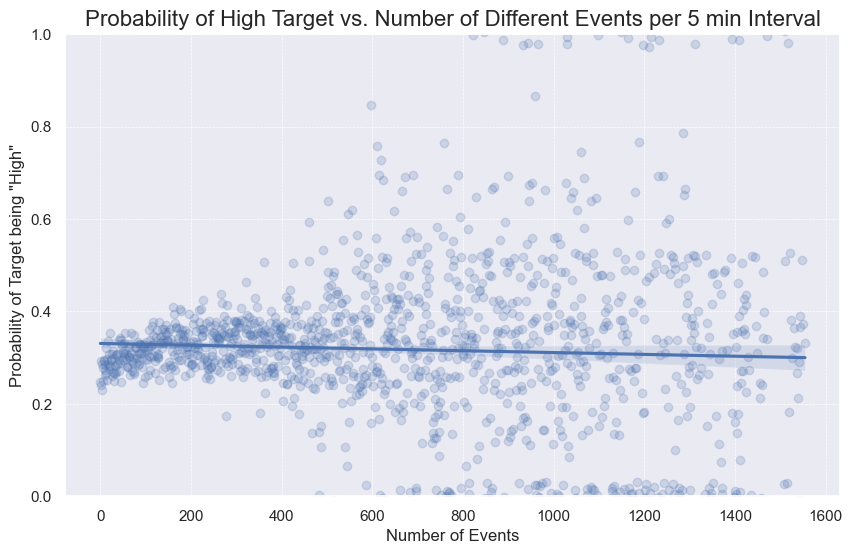

In [300]:
df_stat_nb_event = pd.concat([df_combined_condition.sum(axis=1), list_df[0]["target_cat"] == "high"], axis=1)
df_stat_nb_event.rename(columns={0: "nb_event"}, inplace=True)
# 1. Calculate the probability for each number of events
prob_df = df_stat_nb_event.groupby('nb_event')['target_cat'].mean().reset_index()
prob_df.rename(columns={'target_cat': 'probability_high'}, inplace=True)

""" # --- Seaborn Visualization ---
plt.figure(figsize=(12, 7))

# 2. Create the bar plot from the aggregated data
sns.scatterplot(x='nb_event', y='probability_high', data=prob_df, palette='viridis')

# --- Formatting the Plot ---
plt.title('Probability of High Target vs. Number of Concurrent Events', fontsize=16)
plt.xlabel('Number of Events', fontsize=12)
plt.ylabel('Probability of Target being "High"', fontsize=12)
plt.ylim(0, 1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show() """

plt.figure(figsize=(10, 6))

# Use regplot with logistic=True to fit and plot a logistic regression model.
# y_jitter adds a small amount of vertical noise to the points for better visibility.
sns.regplot(x='nb_event', y='probability_high', data=prob_df,
            ci=95, # Show 95% confidence interval
            y_jitter=.03, # Add jitter to see density of points at 0 and 1
            scatter_kws={'alpha': 0.2}) # Make scatter points transparent

# --- Formatting the Plot ---
plt.title('Probability of High Target vs. Number of Different Events per 5 min Interval', fontsize=16)
plt.xlabel('Number of Events', fontsize=12)
plt.ylabel('Probability of Target being "High"', fontsize=12)
plt.ylim(0, 1) # Give a little space around the 0 and 1 lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

=>
- Mean probability is increasing with number of different event per 5 min interval
- With a selection of Events with p_min = 0.4, we increase the mean prob by 0.03 (+3%) 

In [301]:
prob_df

nb_event  probability_high
0            0          0.218152
1            1          0.252427
2            2          0.271858
3            3          0.249904
4            4          0.288715
...        ...               ...
1379      1543          0.376694
1380      1544          0.362500
1381      1548          0.500000
1382      1549          0.354545
1383      1554          0.318182

[1384 rows x 2 columns]

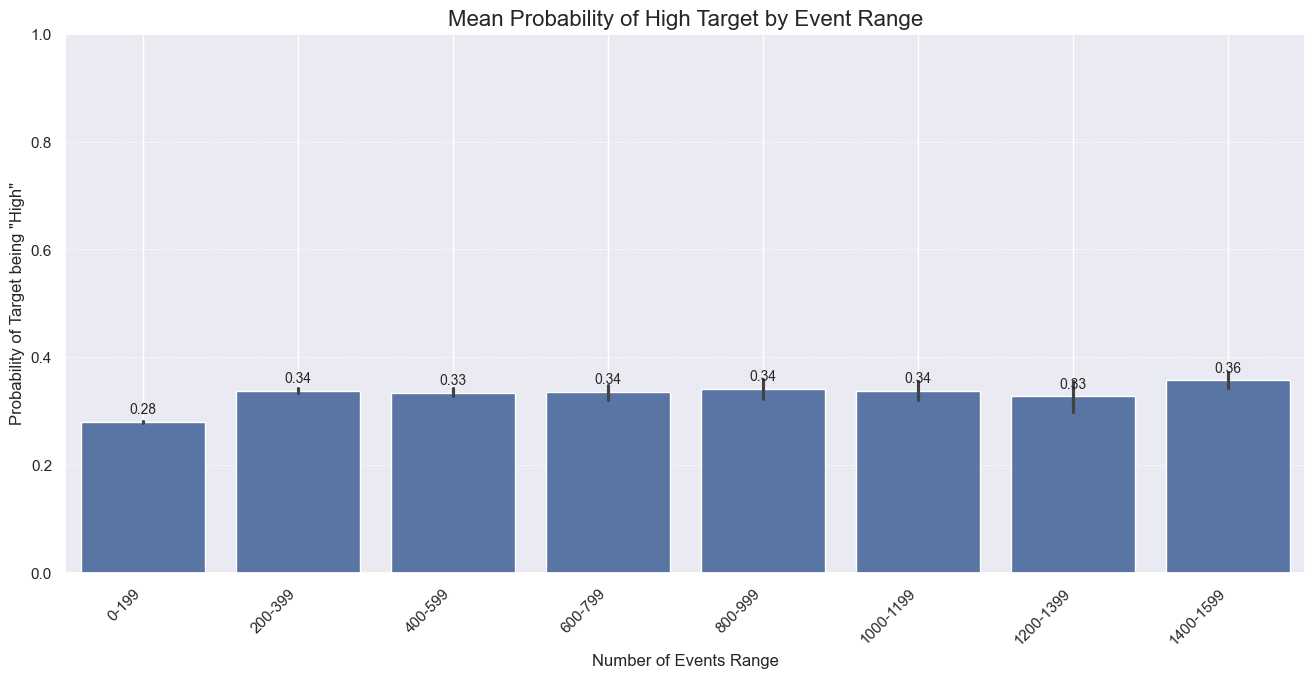

In [302]:
# 1. Define the bins for the number of events.
# We'll create bins of size 500, from 0 up to the maximum value.
max_events = df_stat_nb_event['nb_event'].max()
# Create bins like [0, 500, 1000, 1500, ...]
bins = np.arange(0, max_events + 200, 200)
# Create clear labels for the plot, like '0-499', '500-999', etc.
labels = [f'{int(bins[i])}-{int(bins[i+1]-1)}' for i in range(len(bins)-1)]


# 2. Use pandas.cut to segment the 'nb_event' column into these ranges.
df_stat_nb_event['event_range'] = pd.cut(df_stat_nb_event['nb_event'],
                                         bins=bins,
                                         labels=labels,
                                         right=False, # Makes intervals [0, 500), [500, 1000), etc.
                                         include_lowest=True) # Ensures 0 is included in the first bin

plt.figure(figsize=(16, 7))
ax = sns.barplot(data=df_stat_nb_event, y="target_cat", x="event_range")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=10,
                xytext=(0, 9),
                textcoords='offset points')
# --- Formatting the Plot ---
plt.title('Mean Probability of High Target by Event Range', fontsize=16)
plt.xlabel('Number of Events Range', fontsize=12)
plt.ylabel('Probability of Target being "High"', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
#plt.tight_layout() # Adjust plot to make sure labels don't get cut off
plt.xticks(rotation=45, ha='right')
ax = plt.gca()
ax.grid(True, 'both')
plt.show()

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_78415/2345260547.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


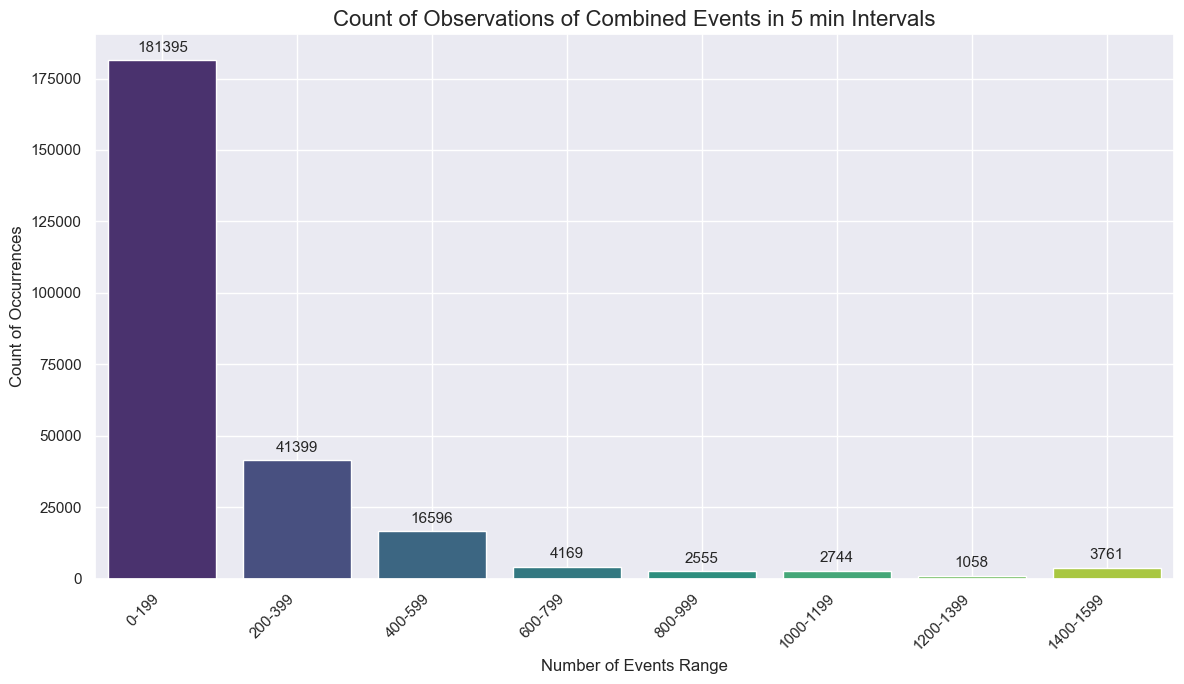

In [303]:
# --- Create the bar plot using seaborn.countplot ---
plt.figure(figsize=(12, 7))

# sns.countplot is the ideal function for this task.
# We use order to ensure the ranges are plotted in numerical order.
ax = sns.countplot(
    x='event_range',
    data=df_stat_nb_event,
    palette='viridis',
    order=labels # Use the generated labels to ensure correct sorting
)

# --- Add count labels on top of each bar for clarity ---
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=11,
                xytext=(0, 9),
                textcoords='offset points')

# --- Formatting the Plot ---
plt.title('Count of Observations of Combined Events in 5 min Intervals', fontsize=16)
plt.xlabel('Number of Events Range', fontsize=12)
plt.ylabel('Count of Occurrences', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
ax.grid(True, 'both')
plt.show()

with : nb_event_min = 8000 & prob_min = 0.4:
- Low or high number of events in time range of 5 min is very low represented so not useful : prob to happened is low
- Most represented : Around 5600-5800 events lead to 40+4% proba = 44% to be high

In [304]:
df_stat_nb_event

nb_event  target_cat event_range
date_ETH                                             
2023-01-01 00:00:00         7       False       0-199
2023-01-01 00:05:00         2       False       0-199
2023-01-01 00:10:00        20       False       0-199
2023-01-01 00:15:00       136       False       0-199
2023-01-01 00:20:00        44       False       0-199
...                       ...         ...         ...
2025-05-30 19:15:00        36        True       0-199
2025-05-30 19:20:00         4       False       0-199
2025-05-30 19:25:00         0       False       0-199
2025-05-30 19:30:00         0       False       0-199
2025-05-30 19:35:00         0        True       0-199

[253677 rows x 3 columns]

In [305]:
list_local_features = df_combined_condition.loc[
    df_stat_nb_event[
        (df_stat_nb_event["event_range"] == "800-999") &
        (df_stat_nb_event["target_cat"] == True)
    ].index.values
].sum(axis=0).sort_values(ascending=False).head(20)
print(list_local_features)
event_0 = list_local_features.index[0]

print(f"\nevent : {event_0}")
print(df_prob_comb_high_event.loc[event_0])
print('prob to appear : ', df_combined_condition[event_0].sum(axis=0) / df_combined_condition.shape[0])
print("nb events :", df_combined_condition[event_0].sum(axis=0))

event_1 = list_local_features.index[1]
print(f"\nevent : {event_1}")
print(df_prob_comb_high_event.loc[event_1])
print('prob to appear : ', df_combined_condition[event_1].sum(axis=0) / df_combined_condition.shape[0])
print("nb events :", df_combined_condition[event_1].sum(axis=0))

120986    788
59597     766
58193     764
58463     764
58409     764
40601     764
55682     764
57680     764
40250     762
58517     760
58490     759
59489     759
61136     759
57815     758
58247     758
59381     758
55817     758
60164     758
60218     758
58355     757
dtype: int64

event : 120986
high                                    26126
low                                     25376
neutral                                 26950
p_high                               0.333019
p_low                                0.323459
delta_prob                          21.843812
feat_0                           High_ETH_cat
feat_0_cat                            neutral
lag_0                                      70
feat_1                           High_ETH_cat
feat_1_cat                            neutral
lag_1                                      68
feat_2                     max_high_h_ETH_cat
feat_2_cat                            neutral
lag_2                                      56
d

In [306]:
list_local_features.index.values

array([120986,  59597,  58193,  58463,  58409,  40601,  55682,  57680,
        40250,  58517,  58490,  59489,  61136,  57815,  58247,  59381,
        55817,  60164,  60218,  58355])

In [307]:
df_prob_comb_high_event.shape

(1977, 21)

In [308]:
df_prob_comb_high_event.loc[list_local_features.index.values].T

120986             59597   \
high                                  26126               7281   
low                                   25376               6675   
neutral                               26950               7870   
p_high                             0.333019           0.333593   
p_low                              0.323459           0.305828   
delta_prob                        21.843812          52.627687   
feat_0                         High_ETH_cat  min_low_h_ETH_cat   
feat_0_cat                          neutral               high   
lag_0                                    70                 68   
feat_1                         High_ETH_cat     vwap_h_ETH_cat   
feat_1_cat                          neutral            neutral   
lag_1                                    68                 70   
feat_2                   max_high_h_ETH_cat     vwap_d_ETH_cat   
feat_2_cat                          neutral            neutral   
lag_2                                    56                 68   
days_with_event                         881                863   
weeks_with_event                        127                127   
months_with_event                        29                 29   
ratio_days_with_event                   1.0           0.979569   
ratio_weeks_with_event                  1.0                1.0   
ratio_months_with_event                 1.0                1.0   

                                    58193              58463   \
high                                  6841               6779   
low                                   6306               6243   
neutral                               7273               7169   
p_high                            0.335015           0.335744   
p_low                             0.308815           0.309197   
delta_prob                       43.542253          44.124712   
feat_0                   min_low_h_ETH_cat  min_low_h_ETH_cat   
feat_0_cat                            high               high   
lag_0                                   68                 68   
feat_1                      vwap_h_ETH_cat     vwap_h_ETH_cat   
feat_1_cat                         neutral            neutral   
lag_1                                   68                 68   
feat_2                      vwap_h_ETH_cat     vwap_d_ETH_cat   
feat_2_cat                         neutral            neutral   
lag_2                                   70                 68   
days_with_event                        855                851   
weeks_with_event                       127                127   
months_with_event                       29                 29   
ratio_days_with_event             0.970488           0.965948   
ratio_weeks_with_event                 1.0                1.0   
ratio_months_with_event                1.0                1.0   

                                    58409                40601   \
high                                  6838                 7177   
low                                   6298                 6567   
neutral                               7272                 7706   
p_high                            0.335065             0.334592   
p_low                             0.308604             0.306154   
delta_prob                       44.397077            54.147264   
feat_0                   min_low_h_ETH_cat  ichi_tenkan_ETH_cat   
feat_0_cat                            high              neutral   
lag_0                                   68                   70   
feat_1                      vwap_h_ETH_cat    min_low_h_ETH_cat   
feat_1_cat                         neutral                 high   
lag_1                                   68                   68   
feat_2                      vwap_d_ETH_cat       vwap_d_ETH_cat   
feat_2_cat                         neutral              neutral   
lag_2                                   71                   68   
days_with_event                        855                  863   
weeks_with_eve

### Per Day

In [309]:
global_event_by_day.describe()

count    881.000000
mean     233.688990
std       36.289223
min       92.000000
25%      216.000000
50%      239.000000
75%      260.000000
max      288.000000
dtype: float64

In [310]:
global_event_by_day.index.max()

Timestamp('2025-05-30 00:00:00')

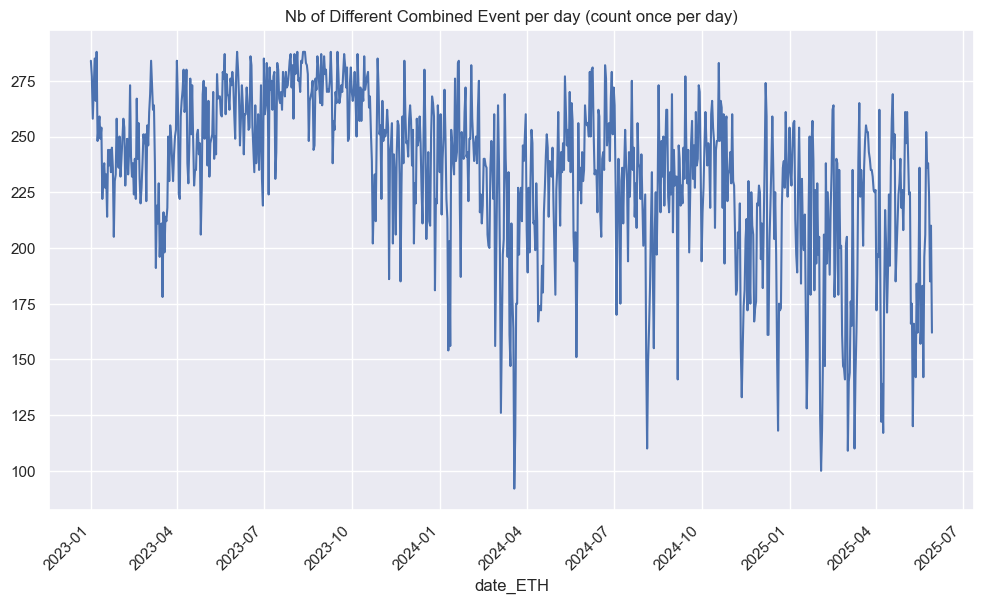

In [311]:
fig = plt.figure(figsize=(10, 6))

sns.lineplot(global_event_by_day, markers="o")
# change x axis ticker format at 45°
# Rotate the x-axis tick labels to 45 degrees.
# Using ha='right' aligns the end of the label with the tick, which often looks better.
plt.xticks(rotation=45, ha='right')

# Adjust plot to make sure labels don't get cut off
plt.tight_layout()

# title
plt.title("Nb of Different Combined Event per day (count once per day)")
# Display the plot
plt.show()

Text(0.5, 1.0, 'Distribution of Number of Events per Day')

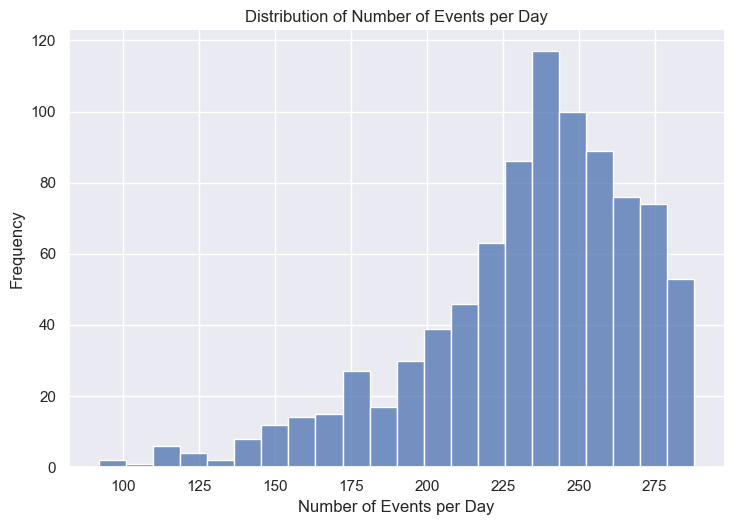

In [312]:

sns.displot(global_event_by_day, height=5, aspect=1.5)
fig = plt.gcf()
ax = fig.gca()
ax.set_xlabel("Number of Events per Day")
ax.set_ylabel("Frequency")
plt.title("Distribution of Number of Events per Day")

In [313]:
df_prob_comb_high_event

high    low  neutral    p_high     p_low  delta_prob        feat_0  \
20       1598   1451     1720  0.335081  0.304257   14.174483  High_ETH_cat   
132      3865   3690     3840  0.339184  0.323826    8.107214  High_ETH_cat   
150      2196   2085     2283  0.334552  0.317642    5.756132  High_ETH_cat   
213      3025   2906     3045  0.337010  0.323752    4.775249  High_ETH_cat   
348      2459   2249     2436  0.344205  0.314810   18.734070  High_ETH_cat   
...       ...    ...      ...       ...       ...         ...           ...   
216116  12797  12526    12883  0.334947  0.327854    5.800340   Low_ETH_cat   
216143  12847  12557    13001  0.334514  0.326963    6.621005   Low_ETH_cat   
216170  11889  11546    12066  0.334892  0.325230   10.040452   Low_ETH_cat   
216197  12322  12049    12359  0.335475  0.328042    6.116204   Low_ETH_cat   
216788   1033   1003     1041  0.335717  0.325967    0.884086   Low_ETH_cat   

       feat_0_cat  lag_0          feat_1  ... lag_1               feat_2  \
20        neutral     64    Open_ETH_cat  ...    64         High_ETH_cat   
132       neutral     64    Open_ETH_cat  ...    64    min_low_h_ETH_cat   
150           low     64    Open_ETH_cat  ...    64          Low_ETH_cat   
213       neutral     64    Open_ETH_cat  ...    64    min_low_h_ETH_cat   
348       neutral     64    Open_ETH_cat  ...    64    min_low_h_ETH_cat   
...           ...    ...             ...  ...   ...                  ...   
216116       high     56    Open_ETH_cat  ...    56  ichi_tenkan_ETH_cat   
216143       high     56    Open_ETH_cat  ...    56       vwap_h_ETH_cat   
216170       high     56    Open_ETH_cat  ...    56          Low_ETH_cat   
216197       high     56    Open_ETH_cat  ...    56  ichi_tenkan_ETH_cat   
216788       high     56  chop_d_BTC_cat  ...    40  ichi_tenkan_ETH_cat   

       feat_2_cat lag_2  days_with_event  weeks_with_event  months_with_event  \
20        neutral    68              840               127                 29   
132          high    68              783               127                 29   
150          high    68              872               127                 29   
213          high    70              773               127                 29   
348          high    71              704               126                 29   
...           ...   ...              ...               ...                ...   
216116    neutral    71              879               127                 29   
216143    neutral    64              881               127                 29   
216170    neutral    71              881               127                 29   
216197    neutral    56              880               127                 29   
216788    neutral    56              146                77                 28   

        ratio_days_with_event  ratio_weeks_with_event  ratio_months_with_event  
20                   0.953462                1.000000                 1.000000  
132                  0.888763                1.000000                 1.000000  
150                  0.989784                1.000000                 1.000000  
213                  0.877412                1.000000                 1.000000  
348                  0.799092                0.992126                 1.000000  
...                       ...                     ...                      ...  
216116               0.997730                1.000000                 1.000000  
216143               1.000000                1.000000                 1.000000  
216170               1.000000                1.000000                 1.000000  
216197               0.998865                1.000000                 1.000000  
216788               0.165721                0.606299                 0.965517  

[1977 rows x 21 columns]

In [314]:
list_df[0]

Close_ETH  Open_ETH  High_ETH   Low_ETH  \
date_ETH                                                       
2023-01-01 00:00:00        1.0  0.999782  1.000109  0.999774   
2023-01-01 00:05:00        1.0  0.999548  1.000008  0.999540   
2023-01-01 00:10:00        1.0  1.000084  1.000193  0.999841   
2023-01-01 00:15:00        1.0  1.000770  1.000770  0.999900   
2023-01-01 00:20:00        1.0  0.999330  1.000025  0.999330   
...                        ...       ...       ...       ...   
2025-05-30 19:15:00        1.0  0.998258  1.001698  0.997009   
2025-05-30 19:20:00        1.0  0.998554  1.001387  0.998451   
2025-05-30 19:25:00        1.0  1.004900  1.005056  0.999299   
2025-05-30 19:30:00        1.0  1.001168  1.001491  0.997621   
2025-05-30 19:35:00        1.0  1.012121  1.014171  0.998487   

                     ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  \
date_ETH                                                                  
2023-01-01 00:00:00          0.999171          0.999736        0.998393   
2023-01-01 00:05:00          0.998785          0.999276        0.998113   
2023-01-01 00:10:00          0.998860          0.999351        0.998243   
2023-01-01 00:15:00          0.999669          1.000113        0.999003   
2023-01-01 00:20:00          0.999178          0.999443        0.998335   
...                               ...               ...             ...   
2025-05-30 19:15:00          1.009059          1.012239        1.000323   
2025-05-30 19:20:00          1.006895          1.010775        0.998877   
2025-05-30 19:25:00          1.011829          1.015728        1.003772   
2025-05-30 19:30:00          1.011492          1.015731        1.004944   
2025-05-30 19:35:00          1.023400          1.028043        1.011526   

                     ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
date_ETH                                                     
2023-01-01 00:00:00         0.999464              2.024261   
2023-01-01 00:05:00         0.999184              2.023329   
2023-01-01 00:10:00         0.999477              2.023482   
2023-01-01 00:15:00         1.000239              2.025023   
2023-01-01 00:20:00         0.999569              2.023668   
...                              ...                   ...   
2025-05-30 19:15:00         1.000559              1.043299   
2025-05-30 19:20:00         0.999113              1.041791   
2025-05-30 19:25:00         1.004009              1.046896   
2025-05-30 19:30:00         1.003987              1.048118   
2025-05-30 19:35:00         1.009147              1.060823   

                     ichi_cloud_b_day_ETH  ...  hour_cos_cat  hour_sin_cat  \
date_ETH                                   ...                               
2023-01-01 00:00:00              2.017807  ...       neutral          high   
2023-01-01 00:05:00              2.016878  ...       neutral          high   
2023-01-01 00:10:00              2.017030  ...       neutral          high   
2023-01-01 00:15:00              2.018567  ...       neutral          high   
2023-01-01 00:20:00              2.017215  ...       neutral          high   
...                                   ...  ...           ...           ...   
2025-05-30 19:15:00              1.026564  ...          high       neutral   
2025-05-30 19:20:00              1.025079  ...          high       neutral   
2025-05-30 19:25:00              1.030103  ...          high       neutral   
2025-05-30 19:30:00              1.031306  ...          high       neutral   
2025-05-30 19:35:00              1.043807  ...          high       neutral   

                     weekday_cos_cat  weekday_sin_cat  day_in_month_cos_cat  \
date_ETH                                                                      
2023-01-01 00:00:00          neutral          neutral                  high   
2023-01-01 00:05:00          neutral          neutral                  high   
2023-01-01 00:10:00          neutral          neutral                  hig

In [315]:
df_combined_condition

20      132     150     213     348     429     537     \
date_ETH                                                                      
2023-01-01 00:00:00   False   False   False   False   False   False   False   
2023-01-01 00:05:00   False   False   False   False   False   False   False   
2023-01-01 00:10:00   False   False   False   False   False   False   False   
2023-01-01 00:15:00   False   False    True   False   False   False   False   
2023-01-01 00:20:00   False   False   False   False   False   False   False   
...                     ...     ...     ...     ...     ...     ...     ...   
2025-05-30 19:15:00   False   False   False   False   False   False   False   
2025-05-30 19:20:00   False   False   False   False   False   False   False   
2025-05-30 19:25:00   False   False   False   False   False   False   False   
2025-05-30 19:30:00   False   False   False   False   False   False   False   
2025-05-30 19:35:00   False   False   False   False   False   False   False   

                     593     843     861     ...  215021  216008  216035  \
date_ETH                                     ...                           
2023-01-01 00:00:00   False   False   False  ...   False   False   False   
2023-01-01 00:05:00   False   False   False  ...   False   False   False   
2023-01-01 00:10:00   False   False   False  ...   False   False   False   
2023-01-01 00:15:00   False   False   False  ...   False   False   False   
2023-01-01 00:20:00   False   False   False  ...   False   False   False   
...                     ...     ...     ...  ...     ...     ...     ...   
2025-05-30 19:15:00   False   False   False  ...   False   False   False   
2025-05-30 19:20:00   False   False   False  ...   False   False   False   
2025-05-30 19:25:00   False   False   False  ...   False   False   False   
2025-05-30 19:30:00   False   False   False  ...   False   False   False   
2025-05-30 19:35:00   False   False   False  ...   False   False   False   

                     216062  216089  216116  216143  216170  216197  216788  
date_ETH                                                                     
2023-01-01 00:00:00   False   False   False   False   False   False   False  
2023-01-01 00:05:00   False   False   False   False   False   False   False  
2023-01-01 00:10:00   False   False   False   False   False   False   False  
2023-01-01 00:15:00   False   False   False   False   False   False   False  
2023-01-01 00:20:00   False   False   False   False   False   False   False  
...                     ...     ...     ...     ...     ...     ...     ...  
2025-05-30 19:15:00   False   False   False   False   False   False   False  
2025-05-30 19:20:00   False   False   False   False   False   False   False  
2025-05-30 19:25:00   False   False   False   False   False   False   False  
2025-05-30 19:30:00   False   False   False   False   False   False   False  
2025-05-30 19:35:00   False   False   False   False   False   False   False  

[253677 rows x 1977 columns]

In [316]:
df_prob_comb_high_event.sort_values(by=["p_high"], ascending=False).head(20)

high   low  neutral    p_high     p_low  delta_prob             feat_0  \
96398  1034   915      994  0.351342  0.310907   14.531555  min_low_h_ETH_cat   
24163  1390  1311     1256  0.351276  0.331312    4.621251       High_ETH_cat   
77066  1165  1024     1134  0.350587  0.308155   18.164459  min_low_h_ETH_cat   
95366  2423  2126     2364  0.350499  0.307537   38.781710  min_low_h_ETH_cat   
25238  1115  1009     1062  0.349969  0.316698   10.580038       High_ETH_cat   
94697  2447  2187     2366  0.349571  0.312429   29.175658  min_low_h_ETH_cat   
18054  1935  1723     1878  0.349530  0.311236   24.572991       Open_ETH_cat   
96182  2489  2220     2414  0.349431  0.311666   30.733064  min_low_h_ETH_cat   
94533  3531  3003     3571  0.349431  0.297180   85.333333  min_low_h_ETH_cat   
9824   1005   921      951  0.349322  0.320125    7.327103       High_ETH_cat   
65018  2296  2043     2239  0.349042  0.310581   29.504033        Low_ETH_cat   
91280  3457  2999     3449  0.349016  0.302776   64.982652     vwap_h_ETH_cat   
94562  3365  2924     3357  0.348849  0.303131   61.847989  min_low_h_ETH_cat   
18000  2408  2147     2351  0.348682  0.310889   29.910428       Open_ETH_cat   
94508  3560  3080     3572  0.348609  0.301606   69.397590  min_low_h_ETH_cat   
94751  3090  2694     3080  0.348601  0.303926   54.224066  min_low_h_ETH_cat   
49565  1066   954     1038  0.348594  0.311969   12.419802       Open_ETH_cat   
27477  3103  2710     3089  0.348573  0.304426   53.139171       High_ETH_cat   
91332  3470  2972     3513  0.348569  0.298543   76.995964     vwap_h_ETH_cat   
76094  1243  1113     1212  0.348374  0.311939   14.346350  min_low_h_ETH_cat   

      feat_0_cat  lag_0             feat_1  ... lag_1               feat_2  \
96398       high     71  min_low_h_ETH_cat  ...    64         High_ETH_cat   
24163    neutral     68        Low_ETH_cat  ...    68         High_ETH_cat   
77066       high     70     vwap_h_ETH_cat  ...    64          Low_ETH_cat   
95366       high     71        Low_ETH_cat  ...    64         High_ETH_cat   
25238    neutral     68  min_low_h_ETH_cat  ...    70          Low_ETH_cat   
94697       high     71       High_ETH_cat  ...    70         High_ETH_cat   
18054    neutral     64  min_low_h_ETH_cat  ...    71          Low_ETH_cat   
96182       high     71       High_ETH_cat  ...    71         High_ETH_cat   
94533       high     71       High_ETH_cat  ...    70          Low_ETH_cat   
9824     neutral     64       High_ETH_cat  ...    71         High_ETH_cat   
65018       high     68  min_low_h_ETH_cat  ...    71         High_ETH_cat   
91280    neutral     68  min_low_h_ETH_cat  ...    71         High_ETH_cat   
94562       high     71       High_ETH_cat  ...    70       vwap_h_ETH_cat   
18000    neutral     64  min_low_h_ETH_cat  ...    71          Low_ETH_cat   
94508       high     71       High_ETH_cat  ...    70       vwap_h_ETH_cat   
94751       high     71       High_ETH_cat  ...    70  ichi_tenkan_ETH_cat   
49565    neutral     68  min_low_h_ETH_cat  ...    70          Low_ETH_cat   
27477    neutral     68  min_low_h_ETH_cat  ...    71          Low_ETH_cat   
91332    neutral     68  min_low_h_ETH_cat  ...    71          Low_ETH_cat   
76094       high     70       High_ETH_cat  ...    70          Low_ETH_cat   

      feat_2_cat lag_2  days_with_event  weeks_with_event  months_with_event  \
96398    neutral    56              739               127                 29   
24163        low    71              841               127                 29   
77066    neutral    70              677               127                 29   
95366    neutral    56              775               127                 29   
25238    neutral    70              651               122                 29   
94697    neutral    56              744               127                 29   
18054       high    70              722               126                 29   
96182    neutral    56    

In [317]:
df_prob_comb_high_event.high.describe()

count     1977.000000
mean      7294.302984
std       6368.170850
min       1003.000000
25%       3042.000000
50%       4445.000000
75%      11360.000000
max      35012.000000
Name: high, dtype: float64

## Probability Models

### Find ML model to improve prob

#### RandomForest : all data

In [318]:
df_combined_condition

20      132     150     213     348     429     537     \
date_ETH                                                                      
2023-01-01 00:00:00   False   False   False   False   False   False   False   
2023-01-01 00:05:00   False   False   False   False   False   False   False   
2023-01-01 00:10:00   False   False   False   False   False   False   False   
2023-01-01 00:15:00   False   False    True   False   False   False   False   
2023-01-01 00:20:00   False   False   False   False   False   False   False   
...                     ...     ...     ...     ...     ...     ...     ...   
2025-05-30 19:15:00   False   False   False   False   False   False   False   
2025-05-30 19:20:00   False   False   False   False   False   False   False   
2025-05-30 19:25:00   False   False   False   False   False   False   False   
2025-05-30 19:30:00   False   False   False   False   False   False   False   
2025-05-30 19:35:00   False   False   False   False   False   False   False   

                     593     843     861     ...  215021  216008  216035  \
date_ETH                                     ...                           
2023-01-01 00:00:00   False   False   False  ...   False   False   False   
2023-01-01 00:05:00   False   False   False  ...   False   False   False   
2023-01-01 00:10:00   False   False   False  ...   False   False   False   
2023-01-01 00:15:00   False   False   False  ...   False   False   False   
2023-01-01 00:20:00   False   False   False  ...   False   False   False   
...                     ...     ...     ...  ...     ...     ...     ...   
2025-05-30 19:15:00   False   False   False  ...   False   False   False   
2025-05-30 19:20:00   False   False   False  ...   False   False   False   
2025-05-30 19:25:00   False   False   False  ...   False   False   False   
2025-05-30 19:30:00   False   False   False  ...   False   False   False   
2025-05-30 19:35:00   False   False   False  ...   False   False   False   

                     216062  216089  216116  216143  216170  216197  216788  
date_ETH                                                                     
2023-01-01 00:00:00   False   False   False   False   False   False   False  
2023-01-01 00:05:00   False   False   False   False   False   False   False  
2023-01-01 00:10:00   False   False   False   False   False   False   False  
2023-01-01 00:15:00   False   False   False   False   False   False   False  
2023-01-01 00:20:00   False   False   False   False   False   False   False  
...                     ...     ...     ...     ...     ...     ...     ...  
2025-05-30 19:15:00   False   False   False   False   False   False   False  
2025-05-30 19:20:00   False   False   False   False   False   False   False  
2025-05-30 19:25:00   False   False   False   False   False   False   False  
2025-05-30 19:30:00   False   False   False   False   False   False   False  
2025-05-30 19:35:00   False   False   False   False   False   False   False  

[253677 rows x 1977 columns]

--- Finding Important Events with Random Forest ---

Saving model to data/rf_prob_model.joblib...
Model saved successfully.

Feature Importances (most predictive individual events):
8450      0.007434
136100    0.006978
8477      0.006733
191615    0.006503
121337    0.006501
            ...   
27641     0.000000
18272     0.000000
7902      0.000000
2238      0.000000
1077      0.000000
Length: 1977, dtype: float64


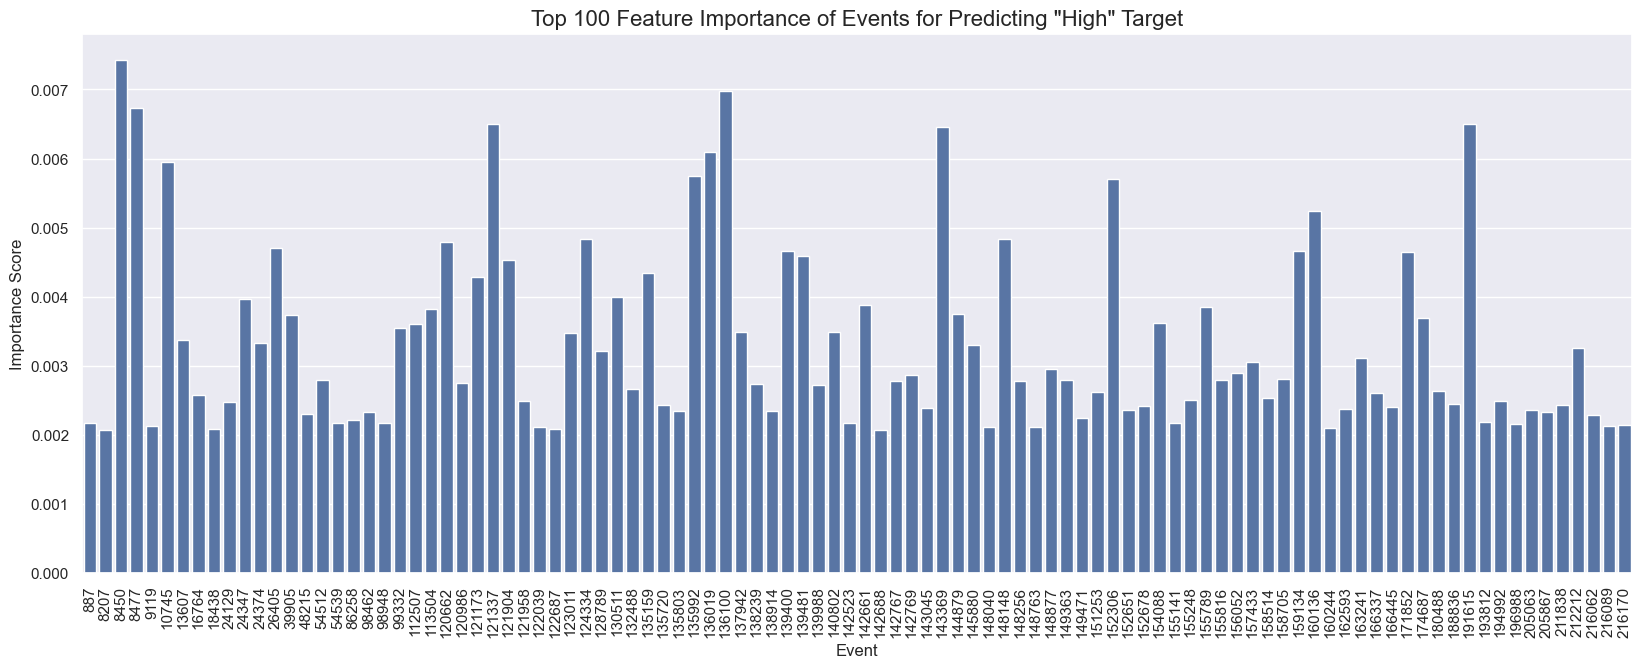

In [319]:
from sklearn.ensemble import RandomForestClassifier
model_rf_prob_filename = os.path.join(path_data, 'rf_prob_model.joblib')
mode_rf = True
y_comb = (list_df[0]["target_cat"] == "high")
if mode_rf:
    # VERY SLOW Training Time with 2 Estimators = 100 min ! 
    # 1. Prepare the data for modeling
    #X_comb = df_combined_condition
    
    # 2. Use a Random Forest to find important features
    print("--- Finding Important Events with Random Forest ---")
    # class_weight='balanced' is useful if "high" targets are rare
    rf_model = RandomForestClassifier(n_estimators=2, random_state=42, class_weight='balanced')
    rf_model.fit(df_combined_condition, y_comb)
    # 2. Save the model to a file
    
    print(f"\nSaving model to {model_rf_prob_filename}...")
    joblib.dump(rf_model, model_rf_prob_filename)
    print("Model saved successfully.")
else:
    # 3. Load the model from the file
    # This can be done in a different script or a later session.
    print(f"\nLoading model from {model_rf_prob_filename}...")
    rf_model = joblib.load(model_rf_prob_filename)
    print("Model loaded successfully.")
# Get and plot feature importances
importances = pd.Series(rf_model.feature_importances_, index=df_combined_condition.columns).sort_values(ascending=False)
print("\nFeature Importances (most predictive individual events):")
print(importances)
# Plot the importances of the top 100 features
plt.figure(figsize=(20, 7))
sns.barplot(y=importances.head(100).values, x=importances.head(100).index)
plt.title('Top 100 Feature Importance of Events for Predicting "High" Target', fontsize=16)
plt.ylabel('Importance Score', fontsize=12)
plt.xlabel('Event', fontsize=12)
plt.xticks(rotation=90, ha='center')
plt.show()

In [320]:
importances.head(10)

8450      0.007434
136100    0.006978
8477      0.006733
191615    0.006503
121337    0.006501
143369    0.006459
136019    0.006088
10745     0.005949
135992    0.005745
152306    0.005705
dtype: float64

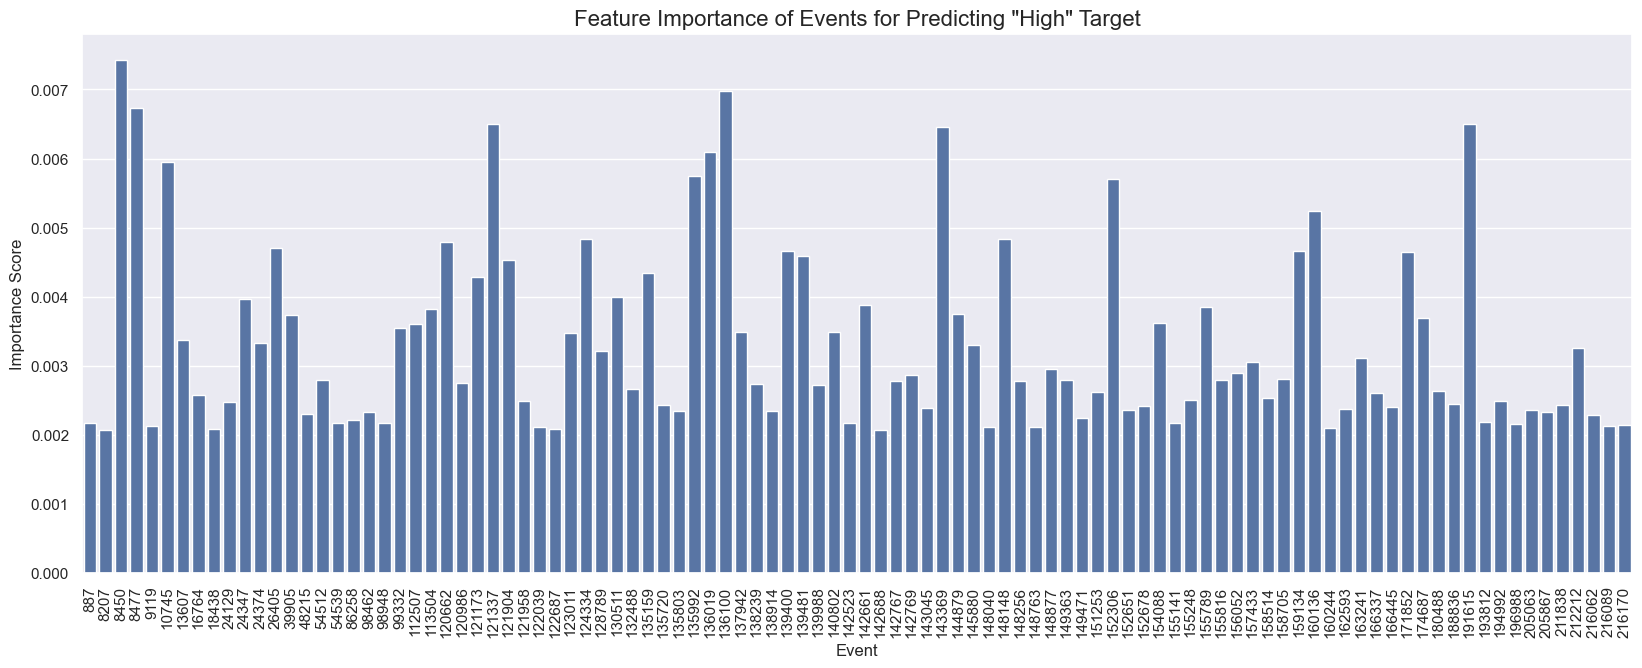

In [321]:
plt.figure(figsize=(20, 7))
sns.barplot(y=importances.head(100).values, x=importances.head(100).index)
plt.title('Feature Importance of Events for Predicting "High" Target', fontsize=16)
plt.ylabel('Importance Score', fontsize=12)
plt.xlabel('Event', fontsize=12)
plt.xticks(rotation=90, ha='center')
plt.show()

In [322]:
importances.head(100).index

Index([  8450, 136100,   8477, 191615, 121337, 143369, 136019,  10745, 135992,
       152306, 160136, 148148, 124334, 120662,  26405, 159134, 139400, 171852,
       139481, 121904, 135159, 121173, 130511,  24347, 142661, 155789, 113504,
       144879,  39905, 174687, 154088, 112507,  99332, 140802, 137942, 123011,
        13607,  24374, 145880, 212212, 128789, 163241, 157433, 148877, 156052,
       142769, 158705, 155816,  54512, 149363, 142767, 148256, 120986, 138239,
       139988, 132488, 180488, 151253, 166337,  16764, 158514, 155248, 194992,
       121958,  24129, 188836, 135720, 211838, 152678, 166445, 143045, 162593,
       152651, 205063, 138914, 135803, 205867,  98462,  48215, 216062, 149471,
        86258, 193812, 155141,  98948,    887, 142523,  54539, 196988, 216170,
       216089,   9119, 148763, 148040, 122039, 160244, 122687,  18438, 142688,
         8207],
      dtype='int64')

In [323]:
importances

8450      0.007434
136100    0.006978
8477      0.006733
191615    0.006503
121337    0.006501
            ...   
27641     0.000000
18272     0.000000
7902      0.000000
2238      0.000000
1077      0.000000
Length: 1977, dtype: float64

In [324]:
df_prob_comb_high_event.loc[importances.head(4).index.values].T

8450          136100  \
high                                    23757         15785   
low                                     23312         14981   
neutral                                 24042         16398   
p_high                               0.334083      0.334683   
p_low                                0.327826      0.317636   
delta_prob                           8.414243     42.021452   
feat_0                           High_ETH_cat  High_ETH_cat   
feat_0_cat                            neutral       neutral   
lag_0                                      64            68   
feat_1                           High_ETH_cat   Low_ETH_cat   
feat_1_cat                            neutral          high   
lag_1                                      70            68   
feat_2                   ichi_cloud_b_ETH_cat   Low_ETH_cat   
feat_2_cat                            neutral       neutral   
lag_2                                      56            71   
days_with_event                           881           879   
weeks_with_event                          127           127   
months_with_event                          29            29   
ratio_days_with_event                     1.0       0.99773   
ratio_weeks_with_event                    1.0           1.0   
ratio_months_with_event                   1.0           1.0   

                                       8477                191615  
high                                    24098                9840  
low                                     23628                9898  
neutral                                 24468                9808  
p_high                               0.333795             0.33304  
p_low                                0.327285            0.335003  
delta_prob                           9.257009           -0.340865  
feat_0                           High_ETH_cat  max_high_h_ETH_cat  
feat_0_cat                            neutral             neutral  
lag_0                                      64                  64  
feat_1                           High_ETH_cat        High_ETH_cat  
feat_1_cat                            neutral                 low  
lag_1                                      70                  56  
feat_2                   ichi_cloud_b_ETH_cat         Low_ETH_cat  
feat_2_cat                            neutral             neutral  
lag_2                                      64                  56  
days_with_event                           881                 876  
weeks_with_event                          127                 127  
months_with_event                          29                  29  
ratio_days_with_event                     1.0            0.994325  
ratio_weeks_with_event                    1.0                 1.0  
ratio_months_with_event                   1.0                 1.0

In [325]:
rf_model.score(df_combined_condition, y_comb)

0.6199931408838799

=> Probably Overfitting


--- Visualizing Event Combinations with a Decision Tree ---


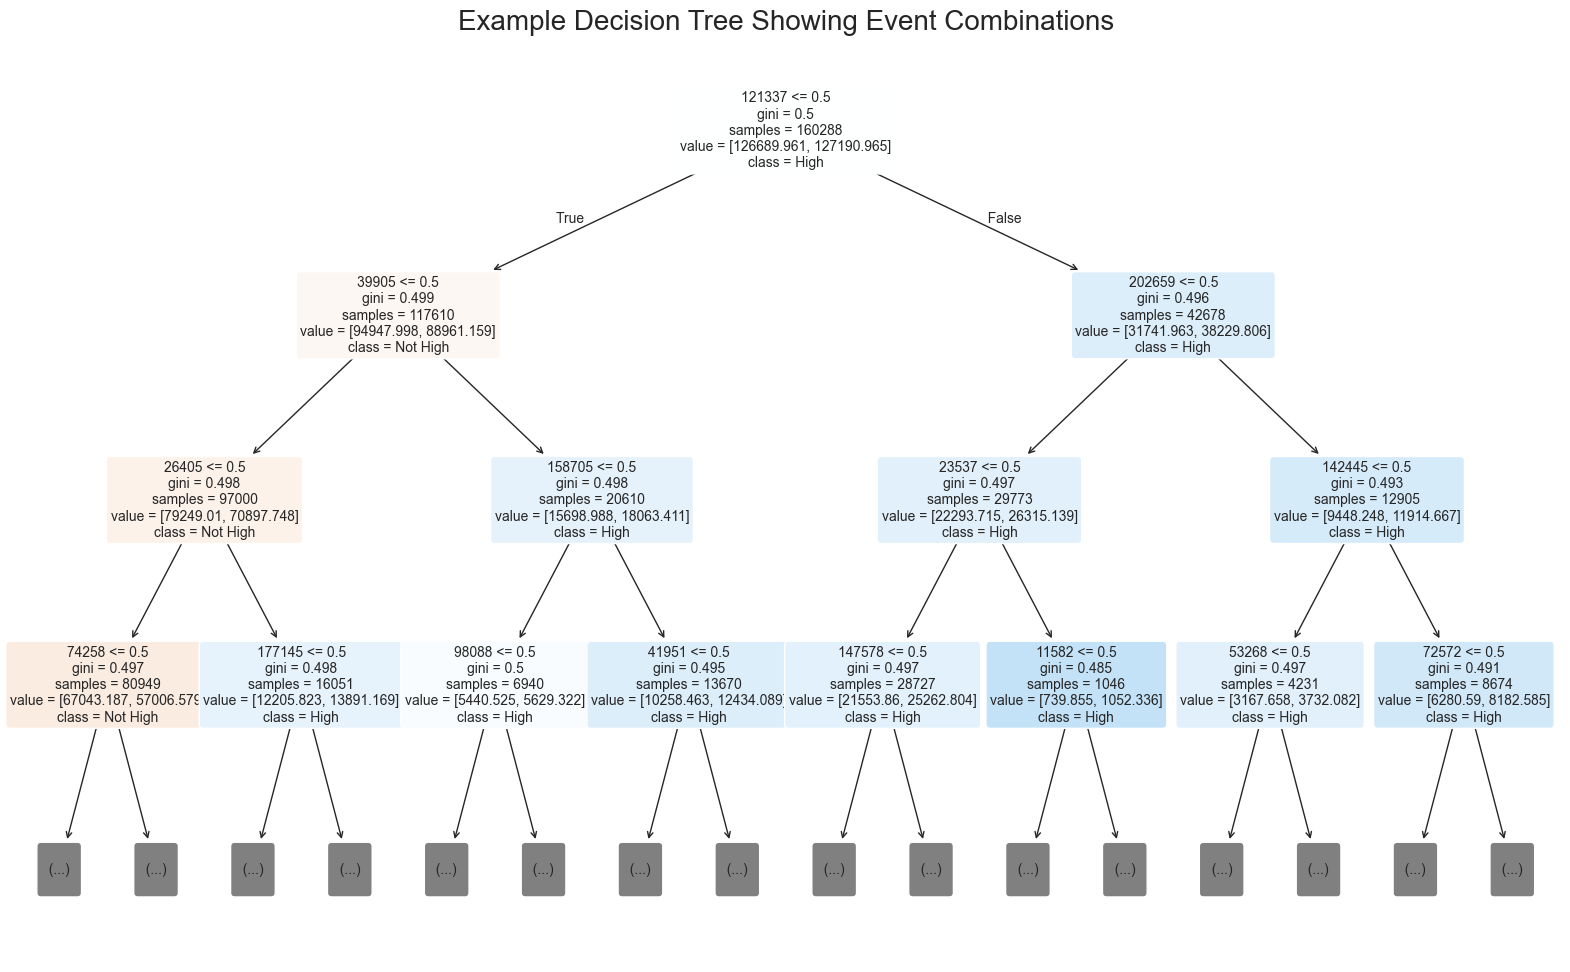

In [326]:
from sklearn.tree import plot_tree
# 3. Visualize a Decision Tree to see the combinations
print("\n--- Visualizing Event Combinations with a Decision Tree ---")
# Let's pick one tree from our trained forest (e.g., the 5th one)
single_tree = rf_model.estimators_[0]

plt.figure(figsize=(20, 12))
plot_tree(single_tree,
          feature_names=df_combined_condition.columns,
          class_names=['Not High', 'High'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3) # Limit depth for better readability
plt.title("Example Decision Tree Showing Event Combinations", fontsize=20)
plt.show()

#### RandomForest : train / test 

In [327]:
# train split 
# It's good practice to split data to evaluate the model
from sklearn.model_selection import train_test_split
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(
    df_combined_condition,
    y_comb,
    test_size=0.3,
    shuffle=False
)

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    max_features="sqrt", # "sqrt", # default
    max_samples=0.6,
    min_samples_leaf=100,
    n_estimators=10,
    max_depth=4,
)
rf.fit(X_rf_train, y_rf_train)
print("Model trained.")
print("Accuracy on training data:", rf.score(X_rf_train, y_rf_train))
print("Accuracy on test data:", rf.score(X_rf_test, y_rf_test))

# max_features="sqrt", max_samples=0.6
# accuracy Train / Test
# 58/56 : 27s : min_samples_leaf=1000,n_estimators=10 ,max_depth=2,
# 58/56 : 30s : min_samples_leaf=1000,n_estimators=100,max_depth=2,
# 58/56 : 35s : min_samples_leaf=1000,n_estimators=100,max_depth=3,
# 58/56 : 30s : min_samples_leaf=1000,n_estimators=30 ,max_depth=3,
# 58/56 : 28s : min_samples_leaf=1000,n_estimators=30 ,max_depth=3, max_samples=0.8,
# 58/56+: 29s : min_samples_leaf=100 ,n_estimators=30 ,max_depth=3, max_samples=0.6,
# 59/56+: 33s : min_samples_leaf=100 ,n_estimators=30 ,max_depth=4,
# 59/56+: 44s : min_samples_leaf=100 ,n_estimators=100,max_depth=4,
# 59/56+: 29s : min_samples_leaf=100 ,n_estimators=10 ,max_depth=4,
# 59/56-: 31s : min_samples_leaf=100 ,n_estimators=10 ,max_depth=5,
# 59/56-: 31s : min_samples_leaf=10 ,n_estimators=10  ,max_depth=5,
# 59/56:9m29s : min_samples_leaf=3  ,n_estimators=300 ,max_depth=7, max_features=300, max_samples=0.8,

Model trained.
Accuracy on training data: 0.6903527000163313
Accuracy on test data: 0.7342321034374014


In [328]:
X_rf_train.shape

(177573, 1977)


--- Visualizing Event Combinations with a Decision Tree ---


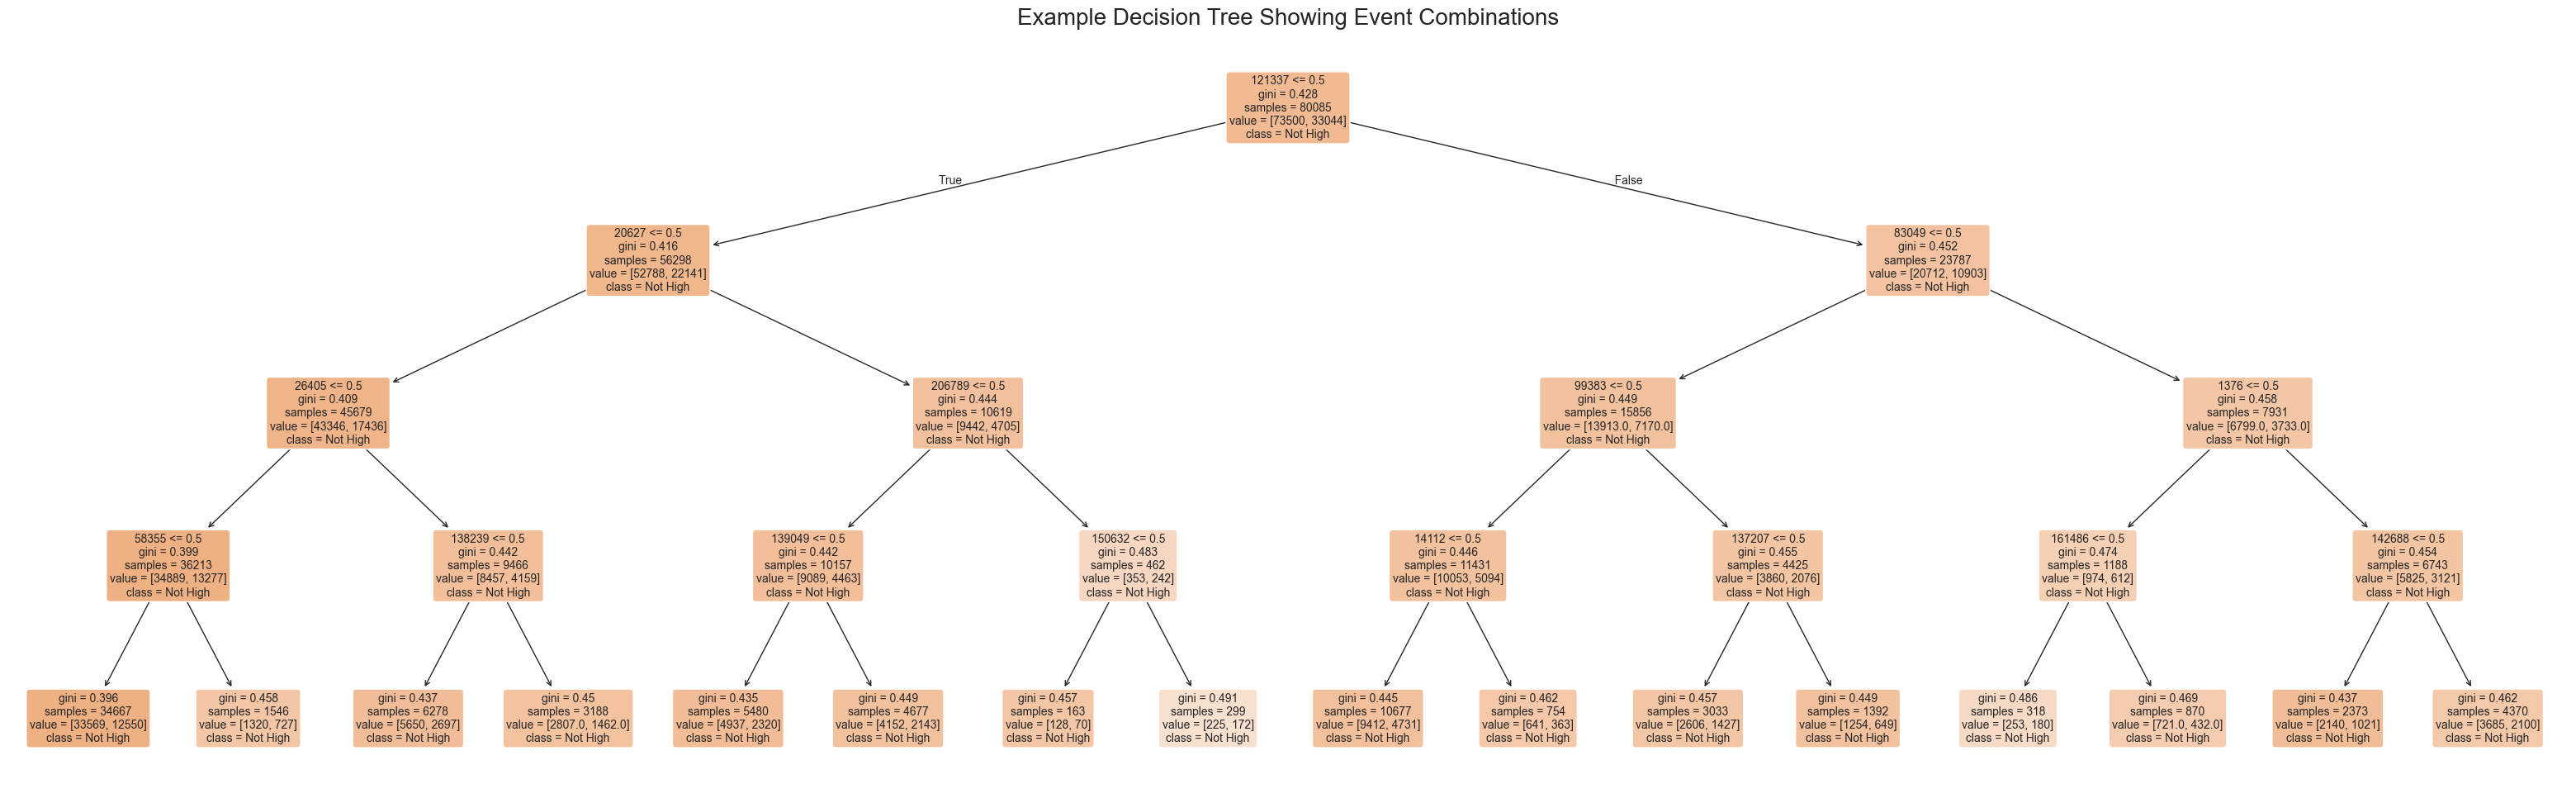

In [329]:
from sklearn.tree import plot_tree
# 3. Visualize a Decision Tree to see the combinations
print("\n--- Visualizing Event Combinations with a Decision Tree ---")
# Let's pick one tree from our trained forest (e.g., the 5th one)
single_tree = rf.estimators_[0]

plt.figure(figsize=(40, 12))
plot_tree(single_tree,
          feature_names=df_combined_condition.columns,
          class_names=['Not High', 'High'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=5) # Limit depth for better readability
plt.title("Example Decision Tree Showing Event Combinations", fontsize=20)
plt.show()

In [330]:
list_df[0]["target_cat"].value_counts()

target_cat
neutral    102593
low         75873
high        75211
Name: count, dtype: int64

In [331]:
list_df[0]["target_cat"].value_counts() / list_df[0].shape[0]

target_cat
neutral    0.404424
low        0.299093
high       0.296483
Name: count, dtype: float64

In [332]:
np.sum(y_rf_train.values) / y_rf_train.shape[0]

np.float64(0.3096472999836687)

In [333]:
np.sum(y_rf_test.values) / y_rf_test.shape[0]

np.float64(0.2657678965625985)

In [334]:
arr_mdl_prob = rf.predict_proba(X_rf_test)
arr_mdl_prob

array([[0.64878314, 0.35121686],
       [0.66005   , 0.33995   ],
       [0.64533768, 0.35466232],
       ...,
       [0.72907372, 0.27092628],
       [0.72907372, 0.27092628],
       [0.72907372, 0.27092628]], shape=(76104, 2))

In [335]:
# sort by prob 
np.sum(arr_mdl_prob[:,1]>0.5) / arr_mdl_prob.shape[0]

np.float64(0.0)

In [336]:
arr_mdl_pred = rf.predict(X_rf_test)
arr_mdl_pred

array([False, False, False, ..., False, False, False], shape=(76104,))

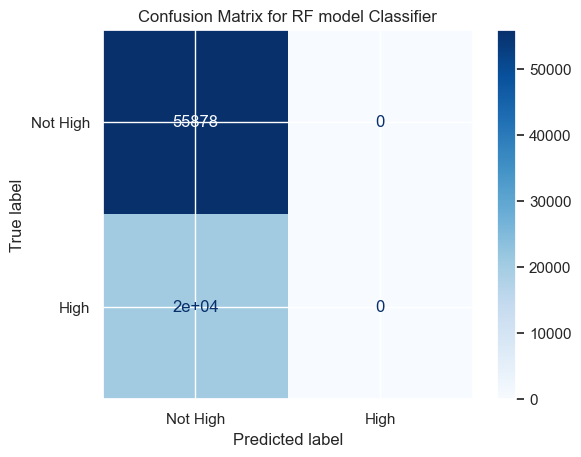

In [337]:
cm = confusion_matrix(y_rf_test, arr_mdl_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for RF model Classifier")
plt.show()

In [338]:
print("For Model RF: ")
print(f"precision: {precision_score(y_rf_test, arr_mdl_pred):.2f}")
print(f"% possible trades : {100*np.sum(arr_mdl_pred) / arr_mdl_pred.shape[0]:.2f}")
# per day 
print(f"nb trade per day : {288*arr_mdl_pred.sum() / arr_mdl_pred.shape[0]:.0f}")


For Model RF: 
precision: 0.00
% possible trades : 0.00
nb trade per day : 0


/Users/gregory/miniforge3/envs/openbb_01/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


=> predict only 11% high to be compared to true 44% high

#### SGDClassifier

In [339]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier(
    loss="log_loss",
    penalty="l1",  # ou "elasticnet" si besoin de L1+L2
    alpha=1e-3,
    max_iter=1000,
    tol=1e-3,
    early_stopping=True,
    random_state=42
)

""" sgdc = SGDClassifier(
    loss="perceptron",
    learning_rate="constant",
    eta0=0.01,
    penalty="l1",  # ou "elasticnet" si besoin de L1+L2
    alpha=1e-3,
    max_iter=1000,
    tol=1e-3,
    early_stopping=True,
    random_state=42
) """

sgdc.fit(X_rf_train, y_rf_train)
print("Model trained.")
print("Accuracy on training data:", sgdc.score(X_rf_train, y_rf_train))
print("Accuracy on test data:", sgdc.score(X_rf_test, y_rf_test))


Model trained.
Accuracy on training data: 0.6903527000163313
Accuracy on test data: 0.7342321034374014


For Model SGDC: 
precision: 0.00
% possible trades : 0.00
nb trade per day : 0


/Users/gregory/miniforge3/envs/openbb_01/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


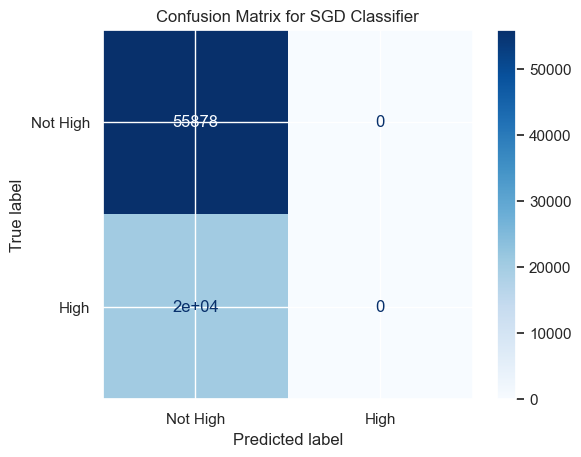

In [340]:
arr_sgdc_pred = sgdc.predict(X_rf_test)
cm = confusion_matrix(y_rf_test, arr_sgdc_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SGD Classifier")

print("For Model SGDC: ")
print(f"precision: {precision_score(y_rf_test, arr_sgdc_pred):.2f}")
print(f"% possible trades : {100*np.sum(arr_sgdc_pred) / arr_sgdc_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_sgdc_pred.sum() / arr_sgdc_pred.shape[0]:.0f}")
plt.show()

#### XGBoost

In [341]:
import xgboost as xgb

params = {
    "objective": "binary:logistic",
    "max_depth": 6,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.2,
    "reg_lambda": 1,
    "scale_pos_weight": 1,  # ajuster si classes déséquilibrées
    "early_stopping_rounds": 20,
}

xgb_mdl = xgb.XGBClassifier(
    **params,
    n_estimators=200,
    use_label_encoder=False,
    random_state=42
)

xgb_mdl.fit(X_rf_train, y_rf_train, eval_set=[(X_rf_train, y_rf_train), (X_rf_test, y_rf_test)])
print("Model trained.")
print("Accuracy on training data:", xgb_mdl.score(X_rf_train, y_rf_train))
print("Accuracy on test data:", xgb_mdl.score(X_rf_test, y_rf_test))


[0]	validation_0-logloss:0.61799	validation_1-logloss:0.58259
[1]	validation_0-logloss:0.61725	validation_1-logloss:0.58171


/Users/gregory/miniforge3/envs/openbb_01/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [19:42:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[2]	validation_0-logloss:0.61663	validation_1-logloss:0.58099
[3]	validation_0-logloss:0.61611	validation_1-logloss:0.58032
[4]	validation_0-logloss:0.61565	validation_1-logloss:0.57979
[5]	validation_0-logloss:0.61525	validation_1-logloss:0.57928
[6]	validation_0-logloss:0.61490	validation_1-logloss:0.57890
[7]	validation_0-logloss:0.61458	validation_1-logloss:0.57854
[8]	validation_0-logloss:0.61431	validation_1-logloss:0.57824
[9]	validation_0-logloss:0.61405	validation_1-logloss:0.57795
[10]	validation_0-logloss:0.61382	validation_1-logloss:0.57770
[11]	validation_0-logloss:0.61363	validation_1-logloss:0.57746
[12]	validation_0-logloss:0.61344	validation_1-logloss:0.57732
[13]	validation_0-logloss:0.61330	validation_1-logloss:0.57713
[14]	validation_0-logloss:0.61311	validation_1-logloss:0.57695
[15]	validation_0-logloss:0.61295	validation_1-logloss:0.57685
[16]	validation_0-logloss:0.61280	validation_1-logloss:0.57673
[17]	validation_0-logloss:0.61264	validation_1-logloss:0.57664


For Model XGBoost: 
precision: 0.24
% possible trades : 0.07
nb trade per day : 0


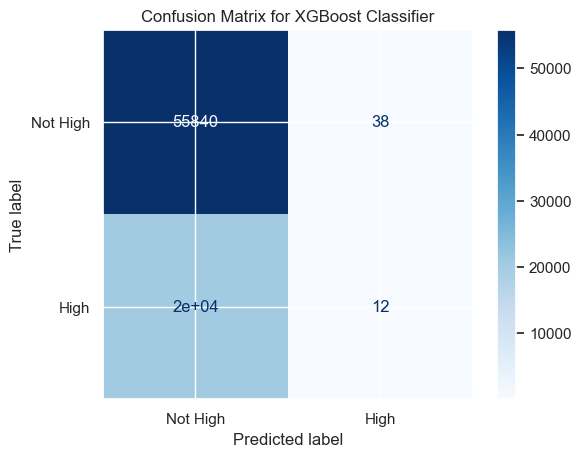

In [342]:
arr_xgb_pred = xgb_mdl.predict(X_rf_test)
cm = confusion_matrix(y_rf_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision: {precision_score(y_rf_test, arr_xgb_pred):.2f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.0f}")
plt.show()

#### Multi-class

In [535]:
y_comb_multi = list_df[0]["target_cat"].values

_, _, y_multi_rf_train, y_multi_rf_test = train_test_split(
    df_combined_condition,
    y_comb_multi,
    test_size=0.3,
    shuffle=False
)

In [544]:
y_comb_multi

array(['neutral', 'low', 'low', ..., 'low', 'neutral', 'high'],
      shape=(253677,), dtype=object)

In [563]:
# sgdc_multi = SGDClassifier(
#     loss="modified_huber",
#     class_weight={"high": 1, "low": 0, "neutral": 0},
#     penalty="l1",  # ou "elasticnet" si besoin de L1+L2
#     alpha=1e-3,
#     max_iter=1000,
#     tol=1e-3,
#     early_stopping=True,
#     random_state=42
# )

sgdc_multi = SGDClassifier(
    loss="log_loss",
    alpha=1e-4,
    max_iter=1000,
    class_weight={"high": 5, "low": 1, "neutral": 1},  # plus de poids sur 'high'
    random_state=42,
    early_stopping=True,
)

sgdc_multi.fit(X_rf_train, y_multi_rf_train)
print("Model trained.")
print("Accuracy on training data:", sgdc_multi.score(X_rf_train, y_multi_rf_train))
print("Accuracy on test data:", sgdc_multi.score(X_rf_test, y_multi_rf_test))


Model trained.
Accuracy on training data: 0.31554346663062516
Accuracy on test data: 0.2727189109639441


For Model SGDC: 
precision:
['high', 'low', 'neutral']
[0.26522556 0.31199352 0.53260303]
% possible trades : 95.86
nb trade per day : 276


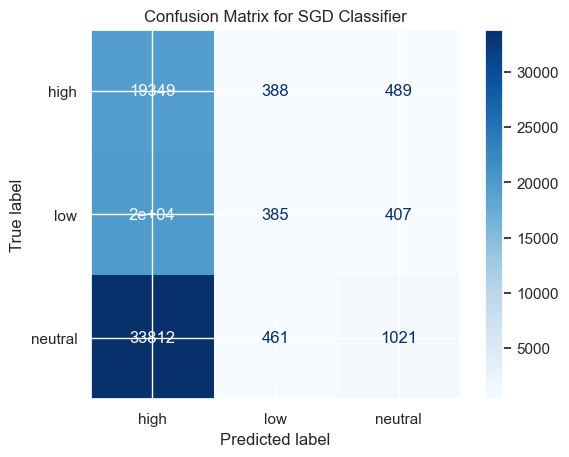

In [564]:
arr_sgdc_pred = sgdc_multi.predict(X_rf_test)
cm = confusion_matrix(y_multi_rf_test, arr_sgdc_pred, labels=target_cat_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_cat_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SGD Classifier")

print("For Model SGDC: ")
print("precision:")
print(target_cat_names)
print(precision_score(y_multi_rf_test, arr_sgdc_pred, labels=target_cat_names, average=None))
print(f"% possible trades : {100*np.sum(arr_sgdc_pred == "high") / arr_sgdc_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*np.sum(arr_sgdc_pred == "high") / arr_sgdc_pred.shape[0]:.0f}")
plt.show()

In [565]:
19000/(19000+20000+33000)

0.2638888888888889

### Comb Prob Improvement 

#### Best Comb
We use only one single best prob event to detect high trades

In [ ]:
# test add a event one by one to check if prob is better
df_prob_comb_high_event.sort_values(by="p_high", ascending=False).head(10)

high   low  neutral    p_high     p_low  delta_prob             feat_0  \
96398  1034   915      994  0.351342  0.310907   14.531555  min_low_h_ETH_cat   
24163  1390  1311     1256  0.351276  0.331312    4.621251       High_ETH_cat   
77066  1165  1024     1134  0.350587  0.308155   18.164459  min_low_h_ETH_cat   
95366  2423  2126     2364  0.350499  0.307537   38.781710  min_low_h_ETH_cat   
25238  1115  1009     1062  0.349969  0.316698   10.580038       High_ETH_cat   
94697  2447  2187     2366  0.349571  0.312429   29.175658  min_low_h_ETH_cat   
18054  1935  1723     1878  0.349530  0.311236   24.572991       Open_ETH_cat   
96182  2489  2220     2414  0.349431  0.311666   30.733064  min_low_h_ETH_cat   
94533  3531  3003     3571  0.349431  0.297180   85.333333  min_low_h_ETH_cat   
9824   1005   921      951  0.349322  0.320125    7.327103       High_ETH_cat   

      feat_0_cat  lag_0             feat_1  ... lag_1        feat_2  \
96398       high     71  min_low_h_ETH_cat  ...    64  High_ETH_cat   
24163    neutral     68        Low_ETH_cat  ...    68  High_ETH_cat   
77066       high     70     vwap_h_ETH_cat  ...    64   Low_ETH_cat   
95366       high     71        Low_ETH_cat  ...    64  High_ETH_cat   
25238    neutral     68  min_low_h_ETH_cat  ...    70   Low_ETH_cat   
94697       high     71       High_ETH_cat  ...    70  High_ETH_cat   
18054    neutral     64  min_low_h_ETH_cat  ...    71   Low_ETH_cat   
96182       high     71       High_ETH_cat  ...    71  High_ETH_cat   
94533       high     71       High_ETH_cat  ...    70   Low_ETH_cat   
9824     neutral     64       High_ETH_cat  ...    71  High_ETH_cat   

      feat_2_cat lag_2  days_with_event  weeks_with_event  months_with_event  \
96398    neutral    56              739               127                 29   
24163        low    71              841               127                 29   
77066    neutral    70              677               127                 29   
95366    neutral    56              775               127                 29   
25238    neutral    70              651               122                 29   
94697    neutral    56              744               127                 29   
18054       high    70              722               126                 29   
96182    neutral    56              770               127                 29   
94533       high    64              832               127                 29   
9824     neutral    56              702               127                 29   

       ratio_days_with_event  ratio_weeks_with_event  ratio_months_with_event  
96398               0.838820                1.000000                      1.0  
24163               0.954597                1.000000                      1.0  
77066               0.768445                1.000000                      1.0  
95366               0.879682                1.000000                      1.0  
25238               0.738933                0.960630                      1.0  
94697               0.844495                1.000000                      1.0  
18054               0.819523                0.992126                      1.0  
96182               0.874007                1.000000                      1.0  
94533               0.944381                1.000000                      1.0  
9824                0.796822                1.000000                      1.0  

[10 rows x 21 columns]

In [ ]:
idx_best_event = df_prob_comb_high_event.sort_values(by="p_high", ascending=False).index[0]
print(idx_best_event)

96398


In [ ]:
df_prob_comb_high_event.loc[idx_best_event]

high                                    1034
low                                      915
neutral                                  994
p_high                              0.351342
p_low                               0.310907
delta_prob                         14.531555
feat_0                     min_low_h_ETH_cat
feat_0_cat                              high
lag_0                                     71
feat_1                     min_low_h_ETH_cat
feat_1_cat                           neutral
lag_1                                     64
feat_2                          High_ETH_cat
feat_2_cat                           neutral
lag_2                                     56
days_with_event                          739
weeks_with_event                         127
months_with_event                         29
ratio_days_with_event                0.83882
ratio_weeks_with_event                   1.0
ratio_months_with_event                  1.0
Name: 96398, dtype: object

In [ ]:
# MDL prob
y_pred_best_prob_test = X_rf_test[idx_best_event]
y_pred_best_prob_test

date_ETH
2024-09-08 13:45:00    False
2024-09-08 13:50:00    False
2024-09-08 13:55:00    False
2024-09-08 14:00:00    False
2024-09-08 14:05:00    False
                       ...  
2025-05-30 19:15:00    False
2025-05-30 19:20:00    False
2025-05-30 19:25:00    False
2025-05-30 19:30:00    False
2025-05-30 19:35:00    False
Name: 96398, Length: 76104, dtype: bool

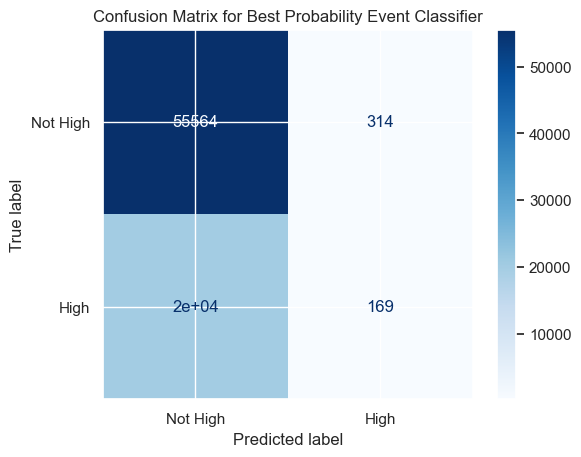

In [ ]:

cm = confusion_matrix(y_rf_test, y_pred_best_prob_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best Probability Event Classifier")
plt.show()

In [ ]:
print(f"precision: {precision_score(y_rf_test, y_pred_best_prob_test):.2f}")
print(f"% possible trades : {100*y_pred_best_prob_test.sum() / y_pred_best_prob_test.shape[0]:.2f}%")
# per day 
print(f"nb trade per day : {288*y_pred_best_prob_test.sum() / y_pred_best_prob_test.shape[0]:.0f}")



precision: 0.35
% possible trades : 0.63%
nb trade per day : 2


Good results with only the first best event

#### Best Comb + single event
We add a event one by one to check if model is better

In [572]:
# --- Optimized Code ---

# 1. Find the best single event and its probability more directly
# .idxmax() is more efficient than sorting the entire DataFrame.
best_event_name = df_prob_comb_high_event['p_high'].idxmax()
best_prob_0 = df_prob_comb_high_event['p_high'].max()

# Store the best combination found so far. Start with the best single event.
best_combination = (best_event_name,)

print(f"Initial best event: '{best_event_name}' with probability: {best_prob_0:.4f}")

# 2. Pre-calculate the boolean mask for "high" targets for efficiency
# This avoids recalculating it on each iteration of the loop.
is_high_target = (list_df[0]["target_cat"] == "high")
min_support = 1000
list_second_event_name = []
# 3. Iterate through all events to find a better PAIR
print("\nSearching for a better two-event combination...")
for second_event_name in df_combined_condition.columns:
    # Don't combine an event with itself
    if second_event_name == best_event_name:
        continue

    # 4. Create a boolean mask for the event combination
    # This correctly uses the event names (strings) to index the DataFrame columns.
    combination_mask = df_combined_condition[best_event_name] & df_combined_condition[second_event_name]

    # 5. Check if the combination has enough data points (support)
    support = combination_mask.sum()
    if support < min_support:
        continue

    # 6. Calculate the probability for this new combination
    # Slicing the pre-calculated 'is_high_target' series is much faster.
    high_targets_in_combination = is_high_target[combination_mask].sum()
    current_prob = high_targets_in_combination / support

    # 7. If the new combination is better, update the tracking variables
    if current_prob > best_prob_0:
        best_prob_0 = current_prob
        best_combination = (best_event_name, second_event_name)
        list_second_event_name.append(second_event_name)
        print("\n--- New Best Combination Found ---")
        print(f"Combination: {best_combination}")
        print(f"New best probability: {best_prob_0:.4f}")
        print(f"Support (Highs / Total): {high_targets_in_combination} / {support}")

print("\n--- Search Complete ---")
print(f"The best combination found is: {best_combination}")
print(f"With a probability of: {best_prob_0:.4f}")


Initial best event: '96398' with probability: 0.3513

Searching for a better two-event combination...

--- New Best Combination Found ---
Combination: (np.int64(96398), 861)
New best probability: 0.3555
Support (Highs / Total): 391 / 1100

--- New Best Combination Found ---
Combination: (np.int64(96398), 888)
New best probability: 0.3555
Support (Highs / Total): 685 / 1927

--- New Best Combination Found ---
Combination: (np.int64(96398), 1158)
New best probability: 0.3559
Support (Highs / Total): 705 / 1981

--- New Best Combination Found ---
Combination: (np.int64(96398), 3528)
New best probability: 0.3595
Support (Highs / Total): 371 / 1032

--- New Best Combination Found ---
Combination: (np.int64(96398), 9171)
New best probability: 0.3610
Support (Highs / Total): 435 / 1205

--- New Best Combination Found ---
Combination: (np.int64(96398), 23211)
New best probability: 0.3673
Support (Highs / Total): 422 / 1149

--- New Best Combination Found ---
Combination: (np.int64(96398), 4753

- What is the combined events exactly ?


In [573]:
list_second_event_name

[861, 888, 1158, 3528, 9171, 23211, 47538, 216062]

In [574]:
df_prob_comb_high_event.loc[[best_combination[0], best_combination[1]]].T

96398          216062
high                                  1034          12163
low                                    915          11896
neutral                                994          12286
p_high                            0.351342       0.334654
p_low                             0.310907       0.327308
delta_prob                       14.531555       5.926181
feat_0                   min_low_h_ETH_cat    Low_ETH_cat
feat_0_cat                            high           high
lag_0                                   71             56
feat_1                   min_low_h_ETH_cat   Open_ETH_cat
feat_1_cat                         neutral        neutral
lag_1                                   64             56
feat_2                        High_ETH_cat  rsi_h_ETH_cat
feat_2_cat                         neutral        neutral
lag_2                                   56             56
days_with_event                        739            881
weeks_with_event                       127            127
months_with_event                       29             29
ratio_days_with_event              0.83882            1.0
ratio_weeks_with_event                 1.0            1.0
ratio_months_with_event                1.0            1.0

In [575]:
# MDL prob
y_pred_best_1_prob_test = X_rf_test[best_combination[0]] & X_rf_test[best_combination[1]]
y_pred_best_1_prob_test

date_ETH
2024-09-08 13:45:00    False
2024-09-08 13:50:00    False
2024-09-08 13:55:00    False
2024-09-08 14:00:00    False
2024-09-08 14:05:00    False
                       ...  
2025-05-30 19:15:00    False
2025-05-30 19:20:00    False
2025-05-30 19:25:00    False
2025-05-30 19:30:00    False
2025-05-30 19:35:00    False
Length: 76104, dtype: bool

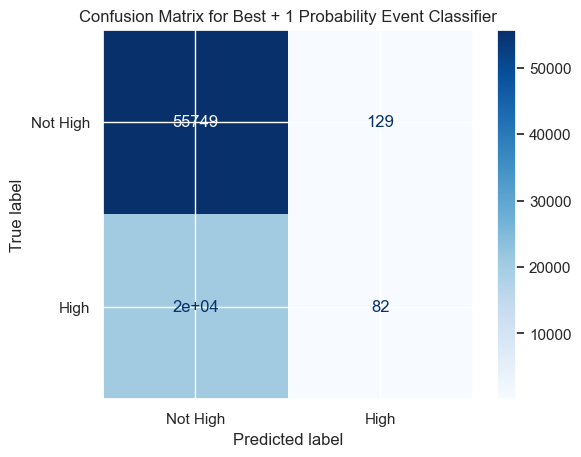

In [576]:

cm = confusion_matrix(y_rf_test, y_pred_best_1_prob_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best + 1 Probability Event Classifier")
plt.show()

In [577]:
print(f"precision: {precision_score(y_rf_test, y_pred_best_1_prob_test):.2f}")
print(f"% possible trades : {100*y_pred_best_1_prob_test.sum() / y_pred_best_1_prob_test.shape[0]:.2f}%")
# per day 
print(f"nb trade per day : {288*y_pred_best_1_prob_test.sum() / y_pred_best_1_prob_test.shape[0]:.0f}")


precision: 0.39
% possible trades : 0.28%
nb trade per day : 1


Ok but not enough trades possible per day : try to have min 10

##### Best prob + OR best multi single event
- Best event with at least one another best event

In [578]:
list_second_event_name

[861, 888, 1158, 3528, 9171, 23211, 47538, 216062]

In [579]:
# MDL prob
y_pred_best_multi_prob_test = X_rf_test[best_combination[0]] & (
    (X_rf_test[best_combination[1]]) | 
    (X_rf_test[list_second_event_name[-2]] | 
     X_rf_test[list_second_event_name[-3]] | 
     X_rf_test[list_second_event_name[-4]] | 
     X_rf_test[list_second_event_name[-5]] |
     X_rf_test[list_second_event_name[-6]] 
     )
)
y_pred_best_multi_prob_test

date_ETH
2024-09-08 13:45:00    False
2024-09-08 13:50:00    False
2024-09-08 13:55:00    False
2024-09-08 14:00:00    False
2024-09-08 14:05:00    False
                       ...  
2025-05-30 19:15:00    False
2025-05-30 19:20:00    False
2025-05-30 19:25:00    False
2025-05-30 19:30:00    False
2025-05-30 19:35:00    False
Length: 76104, dtype: bool

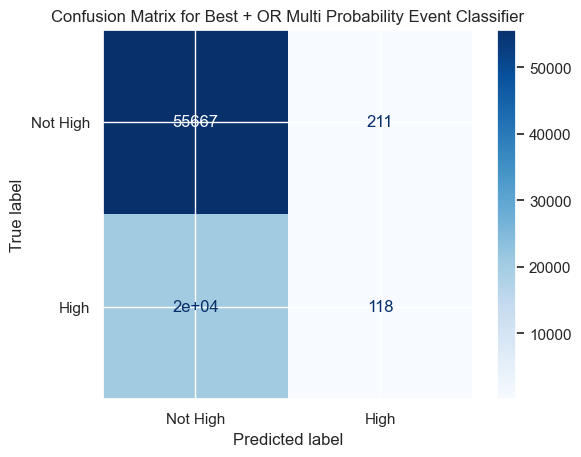

In [580]:

cm = confusion_matrix(y_rf_test, y_pred_best_multi_prob_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best + OR Multi Probability Event Classifier")
plt.show()

In [581]:
print(f"precision: {precision_score(y_rf_test, y_pred_best_multi_prob_test):.2f}")
print(f"% possible trades : {100*y_pred_best_multi_prob_test.sum() / y_pred_best_multi_prob_test.shape[0]:.2f}%")
# per day 
print(f"nb trade per day : {288*y_pred_best_multi_prob_test.sum() / y_pred_best_multi_prob_test.shape[0]:.0f}")


precision: 0.36
% possible trades : 0.43%
nb trade per day : 1


Better results than only the best (precison = 0.52) but with less trades per day (/2)

#### All high prob event + 1 event
To test if adding an event (from 27000 events) to 57 best events, can improve high probability ? 

In [582]:
min_support = 200 # min number of occurrences of this new combination
p_min = 0.33 # min prob for events

# check hash
path_hash_comb_improvement = os.path.join(path_data, 'comb_improvement_inputs_hash.txt')
path_df_probability_filtered = os.path.join(path_data, 'df_probability_filtered.pkl')
mode_redo_comb, hash_comb = check_hash_inputs(
     (df_combined_condition, 
      min_support, 
      p_min,
     ),
     path_hash_comb_improvement,
)

hash match: mode LOAD


In [583]:
# compute time : 15 min : for 57 best events * 27000 events

if mode_redo_comb:
    # --- Setup: Assuming these DataFrames are pre-loaded ---
    # df_combined_condition: (n_samples, n_events) boolean DataFrame
    # list_df: A list containing the DataFrame with the target
    # df_prob_comb_high_event: (n_events, 1) DataFrame with single-event probabilities ('p_high')

    # --- Optimized Code using Targeted Matrix Multiplication ---

    # 1. Prepare the data
    # Using boolean arrays is memory-efficient. We'll convert to int just before matmul.
    X = df_combined_condition.values
    is_high_target = (list_df[0]["target_cat"] == "high").values
    event_names = df_combined_condition.columns
    n_events = len(event_names)
    print("--- Starting targeted search for best event combination ---")

    # 2. Find the best single event from the pre-calculated DataFrame
    # This is fast and doesn't require a large matrix operation.
    best_single_prob = df_prob_comb_high_event['p_high'].max()
    best_single_name = df_prob_comb_high_event['p_high'].idxmax()

    # Initialize the best result with the best single event
    best_prob = best_single_prob
    best_combination = (best_single_name,)
    print(f"Initial best single event: '{best_single_name}' with probability: {best_prob:.4f}")

    # 3. Identify the high-probability events to form pairs with
    high_prob_event_names = df_prob_comb_high_event[df_prob_comb_high_event["p_high"] > p_min].index

    if high_prob_event_names.empty:
        print(f"\nNo single events with p_high > {p_min}. The best combination is the single event found above.")
    else:
        print(f"\nFound {len(high_prob_event_names)} events with p_high > {p_min} to form pairs with.")
        
        # Get the integer indices for these high-probability events
        name_to_idx = {name: i for i, name in enumerate(event_names)}
        high_prob_indices = [name_to_idx[name] for name in high_prob_event_names]

        # 4. Create the sub-matrix for high-prob events (k columns)
        X_h = X[:, high_prob_indices].astype(np.int32)

        # 5. Calculate support and high-counts for the targeted pairs ONLY
        # This creates a (k, N) matrix, which is much smaller than (N, N)
        print("5.Calculating support and high-counts for the targeted pairs...")
        support_filtered = X_h.T @ X.astype(np.int32)
        
        # Create a version of X where rows are zeroed out if the target was not "high"
        X_high = X * is_high_target[:, np.newaxis]
        X_h_high = X_high[:, high_prob_indices].astype(np.int32)
        print("Create a version of X where rows are zeroed out if the target was not 'high'.")
        high_count_filtered = X_h_high.T @ X.astype(np.int32)

        # 6. Calculate the probability matrix for the targeted pairs
        print("6.Calculating the probability matrix for the targeted pairs...")
        with np.errstate(divide='ignore', invalid='ignore'):
            probability_filtered = high_count_filtered / support_filtered
        probability_filtered = np.nan_to_num(probability_filtered)

        # 7. Apply filters to the (k, N) matrix
        # Minimum support filter
        print("7.Apply filters to the (k, N) matrix...")
        probability_filtered[support_filtered < min_support] = 0
        
        # Filter out pairs of an event with itself
        for i, original_idx in enumerate(high_prob_indices):
            if original_idx < n_events:
                probability_filtered[i, original_idx] = 0
        
        # Create a DataFrame with the filtered probabilities
        df_probability_filtered = pd.DataFrame(
        probability_filtered, 
        columns=event_names, 
        index=high_prob_event_names,
        )
        # save
        df_probability_filtered.to_pickle(path_df_probability_filtered)
        # hash
        save_hash(path_hash_comb_improvement, hash_comb)

        # 8. Find the best PAIR from the filtered results
        print("8.Find the best PAIR from the filtered results...")
        best_pair_prob = probability_filtered.max()
        
        if best_pair_prob > best_prob:
            # Find the row/col index in the (k, N) matrix
            idx_flat = np.argmax(probability_filtered)
            idx_pair_filtered = np.unravel_index(idx_flat, probability_filtered.shape)
            
            # Map indices back to original event names
            event1_name = high_prob_event_names[idx_pair_filtered[0]]
            event2_name = event_names[idx_pair_filtered[1]]
            
            best_prob = best_pair_prob
            best_combination = (event1_name, event2_name)

    # 9. Display the final result
    print("\n--- Search Complete ---")
    print(f"The best combination found is: {best_combination}")
    print(f"With a probability of: {best_prob:.4f}")

    # Retrieve support and high count for the final best combination for reporting
    if len(best_combination) == 1:
        event_mask = df_combined_condition[best_combination[0]]
        support = event_mask.sum()
        high_count = (event_mask & is_high_target).sum()
    else:
        # For a pair, we can retrieve the values we already calculated
        e1, e2 = best_combination
        if e1 in high_prob_event_names:
            idx_h = high_prob_event_names.get_loc(e1)
            idx_a = event_names.get_loc(e2)
            support = support_filtered[idx_h, idx_a]
            high_count = high_count_filtered[idx_h, idx_a]
        else: # The other event must be the high-probability one
            idx_h = high_prob_event_names.get_loc(e2)
            idx_a = event_names.get_loc(e1)
            support = support_filtered[idx_h, idx_a]
            high_count = high_count_filtered[idx_h, idx_a]

    print(f"Support (Highs / Total): {high_count} / {support}")
else:
    df_probability_filtered = pd.read_pickle(path_df_probability_filtered)
    best_prob = df_probability_filtered.max().max()
    print(f"The best probability found is: {best_prob:.4f}")
    
    #best_combination = df_probability_filtered.idxmax().values

# get 100 best comb : 

df_probability_filtered


The best probability found is: 0.4537


20        132       150       213       348       429       537     \
20      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
132     0.000000  0.000000  0.000000  0.336795  0.344168  0.342697  0.342306   
150     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
213     0.000000  0.336795  0.000000  0.000000  0.345113  0.338898  0.339751   
348     0.000000  0.344168  0.000000  0.345113  0.000000  0.347747  0.347807   
...          ...       ...       ...       ...       ...       ...       ...   
216116  0.329779  0.344288  0.335068  0.341061  0.343750  0.345263  0.339454   
216143  0.330528  0.344419  0.334372  0.341242  0.344056  0.345056  0.339333   
216170  0.327855  0.345534  0.343750  0.340255  0.343843  0.345254  0.340219   
216197  0.327434  0.344305  0.334066  0.341020  0.343904  0.345046  0.339521   
216788  0.000000  0.343228  0.000000  0.335065  0.307432  0.338002  0.353116   

          593       843       861     ...    215021    216008    216035  \
20      0.000000  0.000000  0.342691  ...  0.328402  0.329519  0.331779   
132     0.344419  0.000000  0.340881  ...  0.345179  0.344468  0.344877   
150     0.000000  0.000000  0.000000  ...  0.345355  0.334372  0.336161   
213     0.342689  0.000000  0.337689  ...  0.343506  0.341179  0.341441   
348     0.345822  0.000000  0.344783  ...  0.346145  0.344056  0.343801   
...          ...       ...       ...  ...       ...       ...       ...   
216116  0.342245  0.353758  0.343792  ...  0.339427  0.335358  0.336262   
216143  0.342111  0.354462  0.343970  ...  0.339008  0.335002  0.336041   
216170  0.343057  0.360963  0.345138  ...  0.340015  0.335931  0.336091   
216197  0.342670  0.361627  0.343425  ...  0.338920  0.336418  0.336964   
216788  0.334556  0.000000  0.340171  ...  0.337851  0.341463  0.340360   

          216062    216089    216116    216143    216170    216197    216788  
20      0.330599  0.328218  0.329779  0.330528  0.327855  0.327434  0.000000  
132     0.346399  0.349266  0.344288  0.344419  0.345534  0.344305  0.343228  
150     0.338600  0.336416  0.335068  0.334372  0.343750  0.334066  0.000000  
213     0.344111  0.347692  0.341061  0.341242  0.340255  0.341020  0.335065  
348     0.348545  0.351785  0.343750  0.344056  0.343843  0.343904  0.307432  
...          ...       ...       ...       ...       ...       ...       ...  
216116  0.336137  0.336728  0.000000  0.335656  0.336193  0.336506  0.338784  
216143  0.335648  0.336214  0.335656  0.000000  0.335779  0.336155  0.341105  
216170  0.335688  0.336105  0.336193  0.335779  0.000000  0.336661  0.345375  
216197  0.336320  0.337129  0.336506  0.336155  0.336661  0.000000  0.340361  
216788  0.341102  0.000000  0.338784  0.341105  0.345375  0.340361  0.000000  

[1977 rows x 1977 columns]

In [584]:
ind_sort = np.unravel_index(
    np.argsort(
        df_probability_filtered.values, 
        axis=None,
    ), 
    df_probability_filtered.shape,
)
# create a dataframe with the best 100 combinations
df_best_comb = pd.DataFrame(
    df_probability_filtered.values[(ind_sort[0][-100:], ind_sort[1][-100:])],
    columns=["prob"])

df_best_comb["event_p_high"] = df_probability_filtered.index[ind_sort[0][-100:]]
df_best_comb["event_1"] = df_probability_filtered.columns[ind_sort[1][-100:]]
#df_probability_filtered.columns[ind_sort[1][-100:]]

df_best_comb.sort_values(by="prob", ascending=False, inplace=True)
df_best_comb.head(30)

prob  event_p_high  event_1
99  0.453744         77066   130839
98  0.453744         77066       20
97  0.453744        130839    77066
96  0.453744            20    77066
95  0.452000          1313   173419
94  0.452000        173419   131216
93  0.452000        173419     1313
92  0.452000        131216   173419
91  0.451493         60461    18011
90  0.451493         18011    60461
89  0.451327        157433   177467
88  0.451327        177467   157433
87  0.449367         77498    18011
86  0.449367         18011    77498
85  0.448980        131216   160351
84  0.448980        160351   131216
83  0.448980        160351     1313
82  0.448980          1313   160351
81  0.447273         17957    60461
80  0.447273         60461    17957
79  0.444840         15072    60461
78  0.444840         60461    15072
75  0.443983         67064   133751
74  0.443983        133751    67064
76  0.443983         28694    67064
77  0.443983         67064    28694
73  0.443396         17957    77498
72  0.443396         77498    17957
71  0.442907         60461    17930
70  0.442907         17930    60461

In [585]:
best_comb_1 = (df_best_comb["event_p_high"].iloc[0], df_best_comb["event_1"].iloc[0])

df_prob_comb_high_event.loc[[best_comb_1[0], best_comb_1[1]]].T

77066         130839
high                                  1165          1598
low                                   1024          1451
neutral                               1134          1720
p_high                            0.350587      0.335081
p_low                             0.308155      0.304257
delta_prob                       18.164459     14.174483
feat_0                   min_low_h_ETH_cat  High_ETH_cat
feat_0_cat                            high       neutral
lag_0                                   70            68
feat_1                      vwap_h_ETH_cat  High_ETH_cat
feat_1_cat                         neutral       neutral
lag_1                                   64            64
feat_2                         Low_ETH_cat  Open_ETH_cat
feat_2_cat                         neutral          high
lag_2                                   70            64
days_with_event                        677           840
weeks_with_event                       127           127
months_with_event                       29            29
ratio_days_with_event             0.768445      0.953462
ratio_weeks_with_event                 1.0           1.0
ratio_months_with_event                1.0           1.0

In [586]:
nb_occ_best_comb_1 = (df_combined_condition[best_comb_1[0]] & df_combined_condition[best_comb_1[1]]).sum()
print("On Train : ")
print(f"nb occurrences : {nb_occ_best_comb_1}")
print(f"{100 * nb_occ_best_comb_1 / df_combined_condition.shape[0]:.2f}% of the data matches this combination of events.")
print(f"to be compared to one day = {100*288/ df_combined_condition.shape[0]:.2f} % of the data")

On Train : 
nb occurrences : 227
0.09% of the data matches this combination of events.
to be compared to one day = 0.11 % of the data


In [587]:
# MDL prob
y_pred_best_comb_prob_test = X_rf_test[best_comb_1[0]] & X_rf_test[best_comb_1[1]]
y_pred_best_comb_prob_test

date_ETH
2024-09-08 13:45:00    False
2024-09-08 13:50:00    False
2024-09-08 13:55:00    False
2024-09-08 14:00:00    False
2024-09-08 14:05:00    False
                       ...  
2025-05-30 19:15:00    False
2025-05-30 19:20:00    False
2025-05-30 19:25:00    False
2025-05-30 19:30:00    False
2025-05-30 19:35:00    False
Length: 76104, dtype: bool

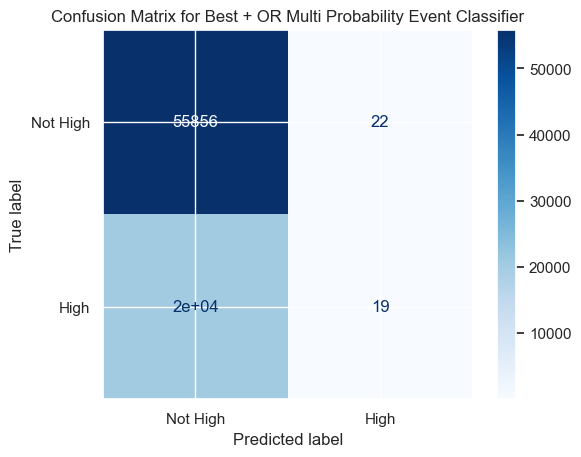

In [588]:
cm = confusion_matrix(y_rf_test, y_pred_best_comb_prob_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best + OR Multi Probability Event Classifier")
plt.show()

In [589]:
print(f"precision: {precision_score(y_rf_test, y_pred_best_comb_prob_test):.3f}")
print(f"% possible trades : {100*y_pred_best_comb_prob_test.sum() / y_pred_best_comb_prob_test.shape[0]:.2f}%")
# per day 
print(f"nb trade per day : {288*y_pred_best_comb_prob_test.sum() / y_pred_best_comb_prob_test.shape[0]:.2f}")


precision: 0.463
% possible trades : 0.05%
nb trade per day : 0.16


- these 2 Combined events gives a good precision = 0.57 (2 trades/day)
- compared best comb precsion = 0.55 (2 trades/day)  
- ML Model precision on Test data : 0.51 (33 trades/day)

CONCLUSION : 
- ML model can be enough for global prediction but maybe too low win rate ?
- These best 2 combined event give a very good precision but not enough possible trades ?

##### Best comb2 + OR multi comb2

In [590]:
# MDL prob
# MDL prob
best_comb_1 = (df_best_comb["event_p_high"].iloc[0], df_best_comb["event_1"].iloc[0])

y_pred_best_comb_or_prob_test = (
    X_rf_test[df_best_comb["event_p_high"].iloc[0]] & X_rf_test[df_best_comb["event_1"].iloc[0]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[1]] & X_rf_test[df_best_comb["event_1"].iloc[1]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[2]] & X_rf_test[df_best_comb["event_1"].iloc[2]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[3]] & X_rf_test[df_best_comb["event_1"].iloc[3]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[4]] & X_rf_test[df_best_comb["event_1"].iloc[4]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[5]] & X_rf_test[df_best_comb["event_1"].iloc[5]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[6]] & X_rf_test[df_best_comb["event_1"].iloc[6]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[7]] & X_rf_test[df_best_comb["event_1"].iloc[7]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[8]] & X_rf_test[df_best_comb["event_1"].iloc[8]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[9]] & X_rf_test[df_best_comb["event_1"].iloc[9]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[10]] & X_rf_test[df_best_comb["event_1"].iloc[10]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[11]] & X_rf_test[df_best_comb["event_1"].iloc[11]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[12]] & X_rf_test[df_best_comb["event_1"].iloc[12]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[13]] & X_rf_test[df_best_comb["event_1"].iloc[13]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[14]] & X_rf_test[df_best_comb["event_1"].iloc[14]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[15]] & X_rf_test[df_best_comb["event_1"].iloc[15]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[16]] & X_rf_test[df_best_comb["event_1"].iloc[16]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[17]] & X_rf_test[df_best_comb["event_1"].iloc[17]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[18]] & X_rf_test[df_best_comb["event_1"].iloc[18]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[19]] & X_rf_test[df_best_comb["event_1"].iloc[19]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[20]] & X_rf_test[df_best_comb["event_1"].iloc[20]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[21]] & X_rf_test[df_best_comb["event_1"].iloc[21]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[22]] & X_rf_test[df_best_comb["event_1"].iloc[22]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[23]] & X_rf_test[df_best_comb["event_1"].iloc[23]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[24]] & X_rf_test[df_best_comb["event_1"].iloc[24]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[25]] & X_rf_test[df_best_comb["event_1"].iloc[25]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[26]] & X_rf_test[df_best_comb["event_1"].iloc[26]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[27]] & X_rf_test[df_best_comb["event_1"].iloc[27]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[28]] & X_rf_test[df_best_comb["event_1"].iloc[28]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[29]] & X_rf_test[df_best_comb["event_1"].iloc[29]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[30]] & X_rf_test[df_best_comb["event_1"].iloc[30]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[31]] & X_rf_test[df_best_comb["event_1"].iloc[31]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[32]] & X_rf_test[df_best_comb["event_1"].iloc[32]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[33]] & X_rf_test[df_best_comb["event_1"].iloc[33]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[34]] & X_rf_test[df_best_comb["event_1"].iloc[34]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[35]] & X_rf_test[df_best_comb["event_1"].iloc[35]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[36]] & X_rf_test[df_best_comb["event_1"].iloc[36]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[37]] & X_rf_test[df_best_comb["event_1"].iloc[37]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[38]] & X_rf_test[df_best_comb["event_1"].iloc[38]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[39]] & X_rf_test[df_best_comb["event_1"].iloc[39]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[40]] & X_rf_test[df_best_comb["event_1"].iloc[40]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[41]] & X_rf_test[df_best_comb["event_1"].iloc[41]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[42]] & X_rf_test[df_best_comb["event_1"].iloc[42]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[43]] & X_rf_test[df_best_comb["event_1"].iloc[43]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[44]] & X_rf_test[df_best_comb["event_1"].iloc[44]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[45]] & X_rf_test[df_best_comb["event_1"].iloc[45]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[46]] & X_rf_test[df_best_comb["event_1"].iloc[46]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[47]] & X_rf_test[df_best_comb["event_1"].iloc[47]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[48]] & X_rf_test[df_best_comb["event_1"].iloc[48]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[49]] & X_rf_test[df_best_comb["event_1"].iloc[49]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[50]] & X_rf_test[df_best_comb["event_1"].iloc[50]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[51]] & X_rf_test[df_best_comb["event_1"].iloc[51]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[52]] & X_rf_test[df_best_comb["event_1"].iloc[52]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[53]] & X_rf_test[df_best_comb["event_1"].iloc[53]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[54]] & X_rf_test[df_best_comb["event_1"].iloc[54]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[55]] & X_rf_test[df_best_comb["event_1"].iloc[55]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[56]] & X_rf_test[df_best_comb["event_1"].iloc[56]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[57]] & X_rf_test[df_best_comb["event_1"].iloc[57]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[58]] & X_rf_test[df_best_comb["event_1"].iloc[58]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[59]] & X_rf_test[df_best_comb["event_1"].iloc[59]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[60]] & X_rf_test[df_best_comb["event_1"].iloc[60]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[61]] & X_rf_test[df_best_comb["event_1"].iloc[61]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[62]] & X_rf_test[df_best_comb["event_1"].iloc[62]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[63]] & X_rf_test[df_best_comb["event_1"].iloc[63]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[64]] & X_rf_test[df_best_comb["event_1"].iloc[64]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[65]] & X_rf_test[df_best_comb["event_1"].iloc[65]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[66]] & X_rf_test[df_best_comb["event_1"].iloc[66]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[67]] & X_rf_test[df_best_comb["event_1"].iloc[67]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[68]] & X_rf_test[df_best_comb["event_1"].iloc[68]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[69]] & X_rf_test[df_best_comb["event_1"].iloc[69]] |
    X_rf_test[df_best_comb["event_p_high"].iloc[70]] & X_rf_test[df_best_comb["event_1"].iloc[70]] 
)
y_pred_best_comb_or_prob_test


date_ETH
2024-09-08 13:45:00    False
2024-09-08 13:50:00    False
2024-09-08 13:55:00    False
2024-09-08 14:00:00    False
2024-09-08 14:05:00    False
                       ...  
2025-05-30 19:15:00    False
2025-05-30 19:20:00    False
2025-05-30 19:25:00    False
2025-05-30 19:30:00    False
2025-05-30 19:35:00    False
Length: 76104, dtype: bool

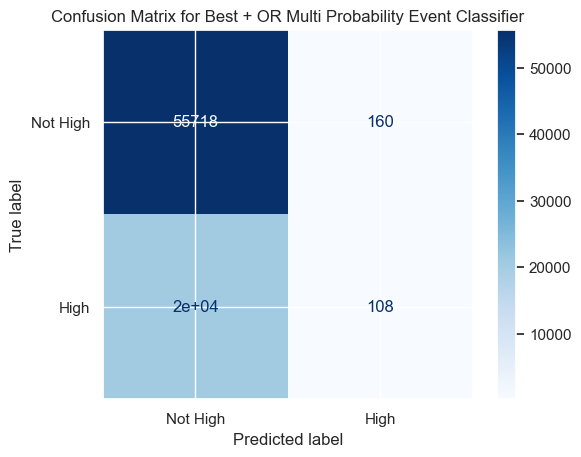

In [591]:
cm = confusion_matrix(y_rf_test, y_pred_best_comb_or_prob_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best + OR Multi Probability Event Classifier")
plt.show()


In [592]:
print(f"precision: {precision_score(y_rf_test, y_pred_best_comb_or_prob_test):.3f}")
print(f"% possible trades : {100*y_pred_best_comb_or_prob_test.sum() / y_pred_best_comb_or_prob_test.shape[0]:.3f}%")
# per day
print(f"nb trade per day : {288*y_pred_best_comb_or_prob_test.sum() / y_pred_best_comb_or_prob_test.shape[0]:.0f}")


precision: 0.403
% possible trades : 0.352%
nb trade per day : 1


- Low trades possible
- precision OK

##### All Best comb2 Max

In [593]:

df_best_comb

prob  event_p_high  event_1
99  0.453744         77066   130839
98  0.453744         77066       20
97  0.453744        130839    77066
96  0.453744            20    77066
95  0.452000          1313   173419
..       ...           ...      ...
16  0.435644        157433   141371
17  0.435644        157433   147041
18  0.435644        157433   146366
19  0.435644        157433   147338
0   0.435644        148229   157433

[100 rows x 3 columns]

In [594]:
X_rf_test

20      132     150     213     348     429     537     \
date_ETH                                                                      
2024-09-08 13:45:00   False   False   False   False   False    True   False   
2024-09-08 13:50:00   False   False   False   False   False    True   False   
2024-09-08 13:55:00   False   False   False   False   False    True   False   
2024-09-08 14:00:00   False   False   False   False   False   False   False   
2024-09-08 14:05:00   False   False   False   False   False   False   False   
...                     ...     ...     ...     ...     ...     ...     ...   
2025-05-30 19:15:00   False   False   False   False   False   False   False   
2025-05-30 19:20:00   False   False   False   False   False   False   False   
2025-05-30 19:25:00   False   False   False   False   False   False   False   
2025-05-30 19:30:00   False   False   False   False   False   False   False   
2025-05-30 19:35:00   False   False   False   False   False   False   False   

                     593     843     861     ...  215021  216008  216035  \
date_ETH                                     ...                           
2024-09-08 13:45:00    True   False   False  ...    True    True    True   
2024-09-08 13:50:00    True   False   False  ...   False   False   False   
2024-09-08 13:55:00    True   False   False  ...    True    True    True   
2024-09-08 14:00:00   False   False   False  ...   False    True    True   
2024-09-08 14:05:00    True   False   False  ...    True   False   False   
...                     ...     ...     ...  ...     ...     ...     ...   
2025-05-30 19:15:00   False   False   False  ...   False   False   False   
2025-05-30 19:20:00   False   False   False  ...   False   False   False   
2025-05-30 19:25:00   False   False   False  ...   False   False   False   
2025-05-30 19:30:00   False   False   False  ...   False   False   False   
2025-05-30 19:35:00   False   False   False  ...   False   False   False   

                     216062  216089  216116  216143  216170  216197  216788  
date_ETH                                                                     
2024-09-08 13:45:00    True    True    True    True    True    True   False  
2024-09-08 13:50:00   False   False   False   False   False   False   False  
2024-09-08 13:55:00    True    True    True    True    True    True   False  
2024-09-08 14:00:00    True    True    True    True    True    True   False  
2024-09-08 14:05:00   False   False   False   False   False   False   False  
...                     ...     ...     ...     ...     ...     ...     ...  
2025-05-30 19:15:00   False   False   False   False   False   False   False  
2025-05-30 19:20:00   False   False   False   False   False   False   False  
2025-05-30 19:25:00   False   False   False   False   False   False   False  
2025-05-30 19:30:00   False   False   False   False   False   False   False  
2025-05-30 19:35:00   False   False   False   False   False   False   False  

[76104 rows x 1977 columns]

precision: 0.390
% possible trades : 0.407%
nb trade per day : 1


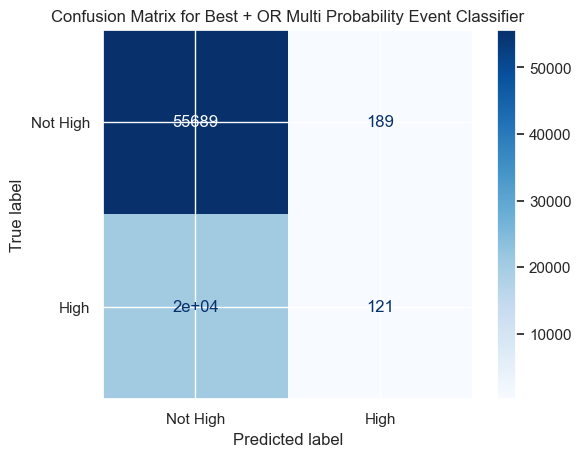

In [595]:
# create a new dataframe to have each double event
# for each double event (event_p_high and event_1), check if double event in df_best_comb is in X_rf_test
# instead of have true or false, give the value of df_best_comb.prob
df_best_comb_events_in_test = pd.DataFrame(index=X_rf_test.index)
for i, row in df_best_comb.iterrows():
    event_p_high = row["event_p_high"]
    event_1 = row["event_1"]
    df_best_comb_events_in_test[f"comb_{i}"] = (X_rf_test[event_p_high] & X_rf_test[event_1]) * row["prob"]
y_pred_max_comb2_test = df_best_comb_events_in_test.max(axis=1) > 0.4

cm = confusion_matrix(y_rf_test, y_pred_max_comb2_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best + OR Multi Probability Event Classifier")

print(f"precision: {precision_score(y_rf_test, y_pred_max_comb2_test):.3f}")
print(f"% possible trades : {100*y_pred_max_comb2_test.sum() / y_pred_max_comb2_test.shape[0]:.3f}%")
# per day
print(f"nb trade per day : {288*y_pred_max_comb2_test.sum() / y_pred_max_comb2_test.shape[0]:.0f}")

plt.show()

=> Not better than "Best comb2 + OR multi comb2"

##### All Best comb2 Mean

In [596]:
(df_best_comb_events_in_test > 0).sum(axis=1)

date_ETH
2024-09-08 13:45:00    0
2024-09-08 13:50:00    0
2024-09-08 13:55:00    0
2024-09-08 14:00:00    0
2024-09-08 14:05:00    0
                      ..
2025-05-30 19:15:00    0
2025-05-30 19:20:00    0
2025-05-30 19:25:00    0
2025-05-30 19:30:00    0
2025-05-30 19:35:00    0
Length: 76104, dtype: int64

precision: 0.390
% possible trades : 0.407%
nb trade per day : 1


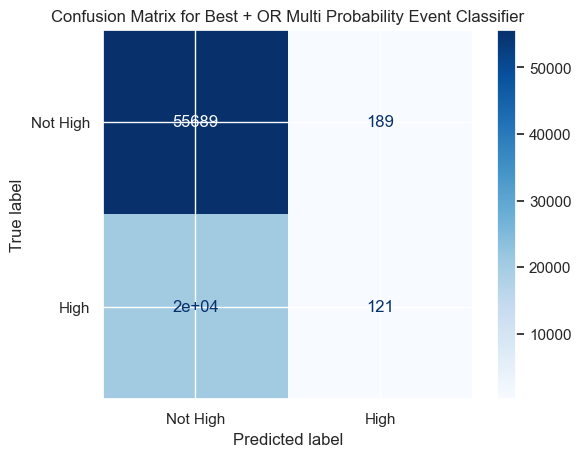

In [597]:

y_pred_mean_comb2_test = df_best_comb_events_in_test.sum(axis=1) / (df_best_comb_events_in_test > 0).sum(axis=1) > 0.4

cm = confusion_matrix(y_rf_test, y_pred_mean_comb2_test, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best + OR Multi Probability Event Classifier")

print(f"precision: {precision_score(y_rf_test, y_pred_mean_comb2_test):.3f}")
print(f"% possible trades : {100*y_pred_mean_comb2_test.sum() / y_pred_mean_comb2_test.shape[0]:.3f}%")
# per day
print(f"nb trade per day : {288*y_pred_mean_comb2_test.sum() / y_pred_mean_comb2_test.shape[0]:.0f}")

plt.show()

=> Same as multi comb2 OR  == BEST RESULT

### Max Prob Model
We take the max prob of all 27000 events  (nb occ>8000 and p_high > 0.4)


In [598]:
df_prob_comb_high_event

high    low  neutral    p_high     p_low  delta_prob        feat_0  \
20       1598   1451     1720  0.335081  0.304257   14.174483  High_ETH_cat   
132      3865   3690     3840  0.339184  0.323826    8.107214  High_ETH_cat   
150      2196   2085     2283  0.334552  0.317642    5.756132  High_ETH_cat   
213      3025   2906     3045  0.337010  0.323752    4.775249  High_ETH_cat   
348      2459   2249     2436  0.344205  0.314810   18.734070  High_ETH_cat   
...       ...    ...      ...       ...       ...         ...           ...   
216116  12797  12526    12883  0.334947  0.327854    5.800340   Low_ETH_cat   
216143  12847  12557    13001  0.334514  0.326963    6.621005   Low_ETH_cat   
216170  11889  11546    12066  0.334892  0.325230   10.040452   Low_ETH_cat   
216197  12322  12049    12359  0.335475  0.328042    6.116204   Low_ETH_cat   
216788   1033   1003     1041  0.335717  0.325967    0.884086   Low_ETH_cat   

       feat_0_cat  lag_0          feat_1  ... lag_1               feat_2  \
20        neutral     64    Open_ETH_cat  ...    64         High_ETH_cat   
132       neutral     64    Open_ETH_cat  ...    64    min_low_h_ETH_cat   
150           low     64    Open_ETH_cat  ...    64          Low_ETH_cat   
213       neutral     64    Open_ETH_cat  ...    64    min_low_h_ETH_cat   
348       neutral     64    Open_ETH_cat  ...    64    min_low_h_ETH_cat   
...           ...    ...             ...  ...   ...                  ...   
216116       high     56    Open_ETH_cat  ...    56  ichi_tenkan_ETH_cat   
216143       high     56    Open_ETH_cat  ...    56       vwap_h_ETH_cat   
216170       high     56    Open_ETH_cat  ...    56          Low_ETH_cat   
216197       high     56    Open_ETH_cat  ...    56  ichi_tenkan_ETH_cat   
216788       high     56  chop_d_BTC_cat  ...    40  ichi_tenkan_ETH_cat   

       feat_2_cat lag_2  days_with_event  weeks_with_event  months_with_event  \
20        neutral    68              840               127                 29   
132          high    68              783               127                 29   
150          high    68              872               127                 29   
213          high    70              773               127                 29   
348          high    71              704               126                 29   
...           ...   ...              ...               ...                ...   
216116    neutral    71              879               127                 29   
216143    neutral    64              881               127                 29   
216170    neutral    71              881               127                 29   
216197    neutral    56              880               127                 29   
216788    neutral    56              146                77                 28   

        ratio_days_with_event  ratio_weeks_with_event  ratio_months_with_event  
20                   0.953462                1.000000                 1.000000  
132                  0.888763                1.000000                 1.000000  
150                  0.989784                1.000000                 1.000000  
213                  0.877412                1.000000                 1.000000  
348                  0.799092                0.992126                 1.000000  
...                       ...                     ...                      ...  
216116               0.997730                1.000000                 1.000000  
216143               1.000000                1.000000                 1.000000  
216170               1.000000                1.000000                 1.000000  
216197               0.998865                1.000000                 1.000000  
216788               0.165721                0.606299                 0.965517  

[1977 rows x 21 columns]

In [599]:
X_rf_test

20      132     150     213     348     429     537     \
date_ETH                                                                      
2024-09-08 13:45:00   False   False   False   False   False    True   False   
2024-09-08 13:50:00   False   False   False   False   False    True   False   
2024-09-08 13:55:00   False   False   False   False   False    True   False   
2024-09-08 14:00:00   False   False   False   False   False   False   False   
2024-09-08 14:05:00   False   False   False   False   False   False   False   
...                     ...     ...     ...     ...     ...     ...     ...   
2025-05-30 19:15:00   False   False   False   False   False   False   False   
2025-05-30 19:20:00   False   False   False   False   False   False   False   
2025-05-30 19:25:00   False   False   False   False   False   False   False   
2025-05-30 19:30:00   False   False   False   False   False   False   False   
2025-05-30 19:35:00   False   False   False   False   False   False   False   

                     593     843     861     ...  215021  216008  216035  \
date_ETH                                     ...                           
2024-09-08 13:45:00    True   False   False  ...    True    True    True   
2024-09-08 13:50:00    True   False   False  ...   False   False   False   
2024-09-08 13:55:00    True   False   False  ...    True    True    True   
2024-09-08 14:00:00   False   False   False  ...   False    True    True   
2024-09-08 14:05:00    True   False   False  ...    True   False   False   
...                     ...     ...     ...  ...     ...     ...     ...   
2025-05-30 19:15:00   False   False   False  ...   False   False   False   
2025-05-30 19:20:00   False   False   False  ...   False   False   False   
2025-05-30 19:25:00   False   False   False  ...   False   False   False   
2025-05-30 19:30:00   False   False   False  ...   False   False   False   
2025-05-30 19:35:00   False   False   False  ...   False   False   False   

                     216062  216089  216116  216143  216170  216197  216788  
date_ETH                                                                     
2024-09-08 13:45:00    True    True    True    True    True    True   False  
2024-09-08 13:50:00   False   False   False   False   False   False   False  
2024-09-08 13:55:00    True    True    True    True    True    True   False  
2024-09-08 14:00:00    True    True    True    True    True    True   False  
2024-09-08 14:05:00   False   False   False   False   False   False   False  
...                     ...     ...     ...     ...     ...     ...     ...  
2025-05-30 19:15:00   False   False   False   False   False   False   False  
2025-05-30 19:20:00   False   False   False   False   False   False   False  
2025-05-30 19:25:00   False   False   False   False   False   False   False  
2025-05-30 19:30:00   False   False   False   False   False   False   False  
2025-05-30 19:35:00   False   False   False   False   False   False   False  

[76104 rows x 1977 columns]

In [600]:
# For each rows == dates in df_combined_condition index, get the max prob of events occuring using df_prob_comb_high_event.p_high probability
# knowing that : df_prob_comb_high_event have as rows the event indexes == columns of df_combined_condition

df_event_probs = X_rf_test.multiply(df_prob_comb_high_event['p_high'], axis='columns')
max_prob_test = df_event_probs.max(axis=1)
max_prob_test


date_ETH
2024-09-08 13:45:00    0.340581
2024-09-08 13:50:00    0.338590
2024-09-08 13:55:00    0.340581
2024-09-08 14:00:00    0.338850
2024-09-08 14:05:00    0.340581
                         ...   
2025-05-30 19:15:00    0.336143
2025-05-30 19:20:00    0.333644
2025-05-30 19:25:00    0.000000
2025-05-30 19:30:00    0.000000
2025-05-30 19:35:00    0.000000
Length: 76104, dtype: float64

In [601]:
max_prob_test.describe()

count    76104.000000
mean         0.249117
std          0.149543
min          0.000000
25%          0.000000
50%          0.336316
75%          0.339733
max          0.351342
dtype: float64

In [602]:
df_event_probs = 0

precision: 0.350
% possible trades : 0.63%
nb trade per day : 2


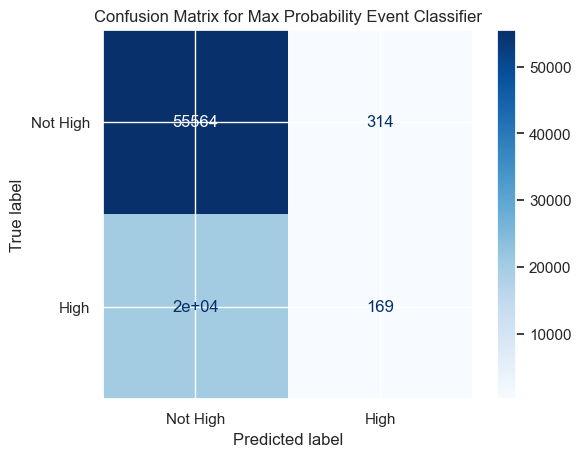

In [603]:
y_pred_max_prob = max_prob_test > 0.351342

cm = confusion_matrix(y_rf_test, y_pred_max_prob, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Max Probability Event Classifier")

print(f"precision: {precision_score(y_rf_test, y_pred_max_prob):.3f}")
print(f"% possible trades : {100*y_pred_max_prob.sum() / y_pred_max_prob.shape[0]:.2f}%")
# per day 
print(f"nb trade per day : {288*y_pred_max_prob.sum() / y_pred_max_prob.shape[0]:.0f}")


plt.show()


#### On 100 best prob

In [604]:
idx_best = df_prob_comb_high_event["p_high"].sort_values(ascending=False).head(100).index.values
idx_best

array([96398, 24163, 77066, 95366, 25238, 94697, 18054, 96182, 94533,
        9824, 65018, 91280, 94562, 18000, 94508, 94751, 49565, 27477,
       91332, 76094, 80289, 64374, 17502, 64802, 95231, 12642, 51752,
       84368, 80237, 94884, 94778, 94857, 84530, 91415, 94670, 94643,
       44300, 84420, 94616, 64829, 44352, 14517, 27425, 95588, 84449,
       63483, 94967, 51804, 27560, 23994, 75311, 44435, 94832, 84503,
       95021, 84584, 94724, 91469, 40869, 18011, 17948, 64883, 51887,
       62997, 80372, 18108, 95285, 91656, 88040, 70490,  7742, 78918,
       48321, 95420, 83940, 96263, 42113, 42981, 95642, 17957,  7877,
       96236, 96587, 44489, 44676, 94805, 84395, 27801,  1240, 80613,
       95048, 80343, 84638, 18083, 95339, 22785,  7794, 64991, 95933,
       84665])

In [605]:
df_prob_comb_high_event.loc[idx_best]

high   low  neutral    p_high     p_low  delta_prob             feat_0  \
96398  1034   915      994  0.351342  0.310907   14.531555  min_low_h_ETH_cat   
24163  1390  1311     1256  0.351276  0.331312    4.621251       High_ETH_cat   
77066  1165  1024     1134  0.350587  0.308155   18.164459  min_low_h_ETH_cat   
95366  2423  2126     2364  0.350499  0.307537   38.781710  min_low_h_ETH_cat   
25238  1115  1009     1062  0.349969  0.316698   10.580038       High_ETH_cat   
...     ...   ...      ...       ...       ...         ...                ...   
22785  2986  2641     2987  0.346645  0.306594   42.304958       High_ETH_cat   
7794   2608  2344     2572  0.346624  0.311536   28.148627       High_ETH_cat   
64991  3578  3025     3722  0.346538  0.292978   92.627291        Low_ETH_cat   
95933  1925  1706     1924  0.346535  0.307111   26.417516  min_low_h_ETH_cat   
84665  3467  3029     3510  0.346492  0.302718   59.065271       Open_ETH_cat   

      feat_0_cat  lag_0             feat_1  ... lag_1             feat_2  \
96398       high     71  min_low_h_ETH_cat  ...    64       High_ETH_cat   
24163    neutral     68        Low_ETH_cat  ...    68       High_ETH_cat   
77066       high     70     vwap_h_ETH_cat  ...    64        Low_ETH_cat   
95366       high     71        Low_ETH_cat  ...    64       High_ETH_cat   
25238    neutral     68  min_low_h_ETH_cat  ...    70        Low_ETH_cat   
...          ...    ...                ...  ...   ...                ...   
22785    neutral     68       Open_ETH_cat  ...    68  min_low_h_ETH_cat   
7794     neutral     64  min_low_h_ETH_cat  ...    71        Low_ETH_cat   
64991       high     68  min_low_h_ETH_cat  ...    71       Open_ETH_cat   
95933       high     71        Low_ETH_cat  ...    70       High_ETH_cat   
84665    neutral     70  min_low_h_ETH_cat  ...    71     vwap_d_ETH_cat   

      feat_2_cat lag_2  days_with_event  weeks_with_event  months_with_event  \
96398    neutral    56              739               127                 29   
24163        low    71              841               127                 29   
77066    neutral    70              677               127                 29   
95366    neutral    56              775               127                 29   
25238    neutral    70              651               122                 29   
...          ...   ...              ...               ...                ...   
22785       high    71              758               127                 29   
7794        high    64              731               126                 29   
64991    neutral    71              855               127                 29   
95933    neutral    56              772               127                 29   
84665    neutral    68              815               127                 29   

       ratio_days_with_event  ratio_weeks_with_event  ratio_months_with_event  
96398               0.838820                1.000000                      1.0  
24163               0.954597                1.000000                      1.0  
77066               0.768445                1.000000                      1.0  
95366               0.879682                1.000000                      1.0  
25238               0.738933                0.960630                      1.0  
...                      ...                     ...                      ...  
22785               0.860386                1.000000                      1.0  
7794                0.829739                0.992126                      1.0  
64991               0.970488                1.000000                      1.0  
95933               0.876277                1.000000                      1.0  
84665               0.925085                1.000000                      1.0  

[100 rows x 21 columns]

In [606]:
X_rf_test[idx_best]

96398  24163  77066  95366  25238  94697  18054  96182  \
date_ETH                                                                      
2024-09-08 13:45:00  False  False  False  False  False  False  False  False   
2024-09-08 13:50:00  False  False  False  False  False  False  False  False   
2024-09-08 13:55:00  False  False  False  False  False  False  False  False   
2024-09-08 14:00:00  False  False  False  False  False  False  False  False   
2024-09-08 14:05:00  False  False  False  False  False  False  False  False   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
2025-05-30 19:15:00  False  False  False  False  False  False  False  False   
2025-05-30 19:20:00  False  False  False  False  False  False  False  False   
2025-05-30 19:25:00  False  False  False  False  False  False  False  False   
2025-05-30 19:30:00  False  False  False  False  False  False  False  False   
2025-05-30 19:35:00  False  False  False  False  False  False  False  False   

                     94533  9824   ...  95048  80343  84638  18083  95339  \
date_ETH                           ...                                      
2024-09-08 13:45:00  False  False  ...  False  False  False  False  False   
2024-09-08 13:50:00  False  False  ...  False  False  False  False  False   
2024-09-08 13:55:00  False  False  ...  False  False  False  False  False   
2024-09-08 14:00:00  False  False  ...  False  False  False  False  False   
2024-09-08 14:05:00  False  False  ...  False  False  False  False  False   
...                    ...    ...  ...    ...    ...    ...    ...    ...   
2025-05-30 19:15:00  False  False  ...  False  False  False  False  False   
2025-05-30 19:20:00  False  False  ...  False  False  False  False  False   
2025-05-30 19:25:00  False  False  ...  False  False  False  False  False   
2025-05-30 19:30:00  False  False  ...  False  False  False  False  False   
2025-05-30 19:35:00  False  False  ...  False  False  False  False  False   

                     22785  7794   64991  95933  84665  
date_ETH                                                
2024-09-08 13:45:00  False  False  False  False  False  
2024-09-08 13:50:00  False  False  False  False  False  
2024-09-08 13:55:00  False  False  False  False  False  
2024-09-08 14:00:00  False  False  False  False  False  
2024-09-08 14:05:00  False  False  False  False  False  
...                    ...    ...    ...    ...    ...  
2025-05-30 19:15:00  False  False  False  False  False  
2025-05-30 19:20:00  False  False  False  False  False  
2025-05-30 19:25:00  False  False  False  False  False  
2025-05-30 19:30:00  False  False  False  False  False  
2025-05-30 19:35:00  False  False  False  False  False  

[76104 rows x 100 columns]

In [607]:
df_event_best_probs = X_rf_test[idx_best].multiply(df_prob_comb_high_event.loc[idx_best]['p_high'], axis='columns')
df_event_best_probs

96398  24163  77066  95366  25238  94697  18054  96182  \
date_ETH                                                                      
2024-09-08 13:45:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-09-08 13:50:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-09-08 13:55:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-09-08 14:00:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-09-08 14:05:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
2025-05-30 19:15:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2025-05-30 19:20:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2025-05-30 19:25:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2025-05-30 19:30:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2025-05-30 19:35:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                     94533  9824   ...  95048  80343  84638  18083  95339  \
date_ETH                           ...                                      
2024-09-08 13:45:00    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0   
2024-09-08 13:50:00    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0   
2024-09-08 13:55:00    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0   
2024-09-08 14:00:00    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0   
2024-09-08 14:05:00    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0   
...                    ...    ...  ...    ...    ...    ...    ...    ...   
2025-05-30 19:15:00    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0   
2025-05-30 19:20:00    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0   
2025-05-30 19:25:00    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0   
2025-05-30 19:30:00    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0   
2025-05-30 19:35:00    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0   

                     22785  7794   64991  95933  84665  
date_ETH                                                
2024-09-08 13:45:00    0.0    0.0    0.0    0.0    0.0  
2024-09-08 13:50:00    0.0    0.0    0.0    0.0    0.0  
2024-09-08 13:55:00    0.0    0.0    0.0    0.0    0.0  
2024-09-08 14:00:00    0.0    0.0    0.0    0.0    0.0  
2024-09-08 14:05:00    0.0    0.0    0.0    0.0    0.0  
...                    ...    ...    ...    ...    ...  
2025-05-30 19:15:00    0.0    0.0    0.0    0.0    0.0  
2025-05-30 19:20:00    0.0    0.0    0.0    0.0    0.0  
2025-05-30 19:25:00    0.0    0.0    0.0    0.0    0.0  
2025-05-30 19:30:00    0.0    0.0    0.0    0.0    0.0  
2025-05-30 19:35:00    0.0    0.0    0.0    0.0    0.0  

[76104 rows x 100 columns]

In [608]:
max_best_prob_test = df_event_best_probs.max(axis=1)
max_best_prob_test

date_ETH
2024-09-08 13:45:00    0.0
2024-09-08 13:50:00    0.0
2024-09-08 13:55:00    0.0
2024-09-08 14:00:00    0.0
2024-09-08 14:05:00    0.0
                      ... 
2025-05-30 19:15:00    0.0
2025-05-30 19:20:00    0.0
2025-05-30 19:25:00    0.0
2025-05-30 19:30:00    0.0
2025-05-30 19:35:00    0.0
Length: 76104, dtype: float64

precision: 0.350
% possible trades : 0.63%
nb trade per day : 1.83


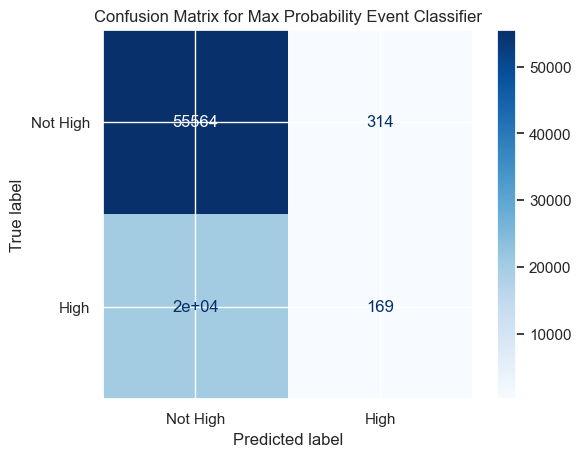

In [609]:
y_pred_max_best_prob = max_best_prob_test > 0.35134

cm = confusion_matrix(y_rf_test, y_pred_max_best_prob, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Max Probability Event Classifier")

print(f"precision: {precision_score(y_rf_test, y_pred_max_best_prob):.3f}")
print(f"% possible trades : {100*y_pred_max_best_prob.sum() / y_pred_max_best_prob.shape[0]:.2f}%")
# per day 
print(f"nb trade per day : {288*y_pred_max_best_prob.sum() / y_pred_max_best_prob.shape[0]:.2f}")

plt.show()

Exact same than All max prob : logical

### Mean Prob Model

In [610]:
df_event_probs = X_rf_test.multiply(df_prob_comb_high_event['p_high'], axis='columns')

df_prob_comb_high_event["p_high"]

20        0.335081
132       0.339184
150       0.334552
213       0.337010
348       0.344205
            ...   
216116    0.334947
216143    0.334514
216170    0.334892
216197    0.335475
216788    0.335717
Name: p_high, Length: 1977, dtype: float64

In [611]:
X_rf_test.shape

(76104, 1977)

In [612]:
arr_sum = (X_rf_test.values) @ (df_prob_comb_high_event["p_high"].values)


In [613]:
nb_true = X_rf_test.sum(axis=1).values


In [614]:
arr_mean_prob = arr_sum / nb_true

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_78415/1357966142.py:1: RuntimeWarning: invalid value encountered in divide
  arr_mean_prob = arr_sum / nb_true


precision: 0.335
% possible trades : 0.35%
nb trade per day : 1.00


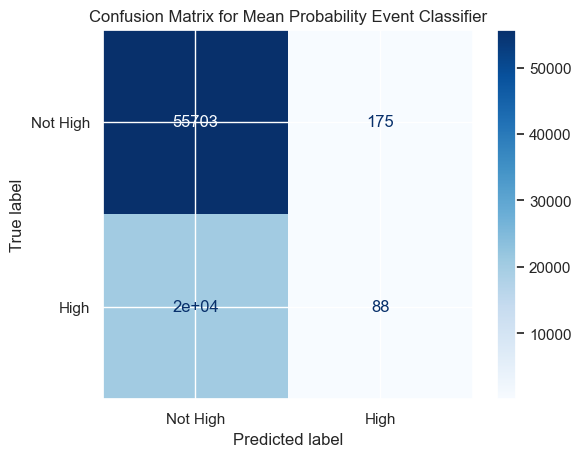

In [615]:
y_pred_mean_prob = arr_mean_prob > 0.3413

cm = confusion_matrix(y_rf_test, y_pred_mean_prob, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Mean Probability Event Classifier")

print(f"precision: {precision_score(y_rf_test, y_pred_mean_prob):.3f}")
print(f"% possible trades : {100*y_pred_mean_prob.sum() / y_pred_mean_prob.shape[0]:.2f}%")
# per day
print(f"nb trade per day : {288*y_pred_mean_prob.sum() / y_pred_mean_prob.shape[0]:.2f}")

plt.show()

Better precision with mean prob model
- close to Best event : precision = 0.518

#### On 100 best prob

In [616]:
arr_best_sum = (X_rf_test[idx_best].values) @ (df_prob_comb_high_event.loc[idx_best]["p_high"].values)

In [617]:
nb_best_true = X_rf_test[idx_best].sum(axis=1).values

In [618]:
arr_mean_best_prob = arr_best_sum / nb_best_true

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_78415/2913283874.py:1: RuntimeWarning: invalid value encountered in divide
  arr_mean_best_prob = arr_best_sum / nb_best_true


In [619]:
arr_mean_best_prob

array([nan, nan, nan, ..., nan, nan, nan], shape=(76104,))

precision: 0.319
% possible trades : 0.58%
nb trade per day : 1.68


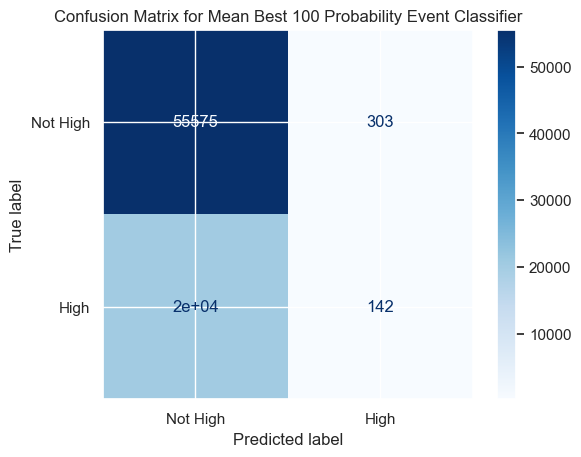

In [620]:
y_pred_mean_best_prob = arr_mean_best_prob > 0.35127

cm = confusion_matrix(y_rf_test, y_pred_mean_best_prob, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Mean Best 100 Probability Event Classifier")

print(f"precision: {precision_score(y_rf_test, y_pred_mean_best_prob):.3f}")
print(f"% possible trades : {100*y_pred_mean_best_prob.sum() / y_pred_mean_best_prob.shape[0]:.2f}%")
# per day
print(f"nb trade per day : {288*y_pred_mean_best_prob.sum() / y_pred_mean_best_prob.shape[0]:.2f}")


plt.show()

Not better than all mean prob

## ML Simple features

### Last 5 min features

In [621]:
df = list_df[0]

In [622]:
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  \
date_ETH                                                       
2023-01-01 00:00:00        1.0  0.999782  1.000109  0.999774   
2023-01-01 00:05:00        1.0  0.999548  1.000008  0.999540   
2023-01-01 00:10:00        1.0  1.000084  1.000193  0.999841   
2023-01-01 00:15:00        1.0  1.000770  1.000770  0.999900   
2023-01-01 00:20:00        1.0  0.999330  1.000025  0.999330   
...                        ...       ...       ...       ...   
2025-05-30 19:15:00        1.0  0.998258  1.001698  0.997009   
2025-05-30 19:20:00        1.0  0.998554  1.001387  0.998451   
2025-05-30 19:25:00        1.0  1.004900  1.005056  0.999299   
2025-05-30 19:30:00        1.0  1.001168  1.001491  0.997621   
2025-05-30 19:35:00        1.0  1.012121  1.014171  0.998487   

                     ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  \
date_ETH                                                                  
2023-01-01 00:00:00          0.999171          0.999736        0.998393   
2023-01-01 00:05:00          0.998785          0.999276        0.998113   
2023-01-01 00:10:00          0.998860          0.999351        0.998243   
2023-01-01 00:15:00          0.999669          1.000113        0.999003   
2023-01-01 00:20:00          0.999178          0.999443        0.998335   
...                               ...               ...             ...   
2025-05-30 19:15:00          1.009059          1.012239        1.000323   
2025-05-30 19:20:00          1.006895          1.010775        0.998877   
2025-05-30 19:25:00          1.011829          1.015728        1.003772   
2025-05-30 19:30:00          1.011492          1.015731        1.004944   
2025-05-30 19:35:00          1.023400          1.028043        1.011526   

                     ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
date_ETH                                                     
2023-01-01 00:00:00         0.999464              2.024261   
2023-01-01 00:05:00         0.999184              2.023329   
2023-01-01 00:10:00         0.999477              2.023482   
2023-01-01 00:15:00         1.000239              2.025023   
2023-01-01 00:20:00         0.999569              2.023668   
...                              ...                   ...   
2025-05-30 19:15:00         1.000559              1.043299   
2025-05-30 19:20:00         0.999113              1.041791   
2025-05-30 19:25:00         1.004009              1.046896   
2025-05-30 19:30:00         1.003987              1.048118   
2025-05-30 19:35:00         1.009147              1.060823   

                     ichi_cloud_b_day_ETH  ...  hour_cos_cat  hour_sin_cat  \
date_ETH                                   ...                               
2023-01-01 00:00:00              2.017807  ...       neutral          high   
2023-01-01 00:05:00              2.016878  ...       neutral          high   
2023-01-01 00:10:00              2.017030  ...       neutral          high   
2023-01-01 00:15:00              2.018567  ...       neutral          high   
2023-01-01 00:20:00              2.017215  ...       neutral          high   
...                                   ...  ...           ...           ...   
2025-05-30 19:15:00              1.026564  ...          high       neutral   
2025-05-30 19:20:00              1.025079  ...          high       neutral   
2025-05-30 19:25:00              1.030103  ...          high       neutral   
2025-05-30 19:30:00              1.031306  ...          high       neutral   
2025-05-30 19:35:00              1.043807  ...          high       neutral   

                     weekday_cos_cat  weekday_sin_cat  day_in_month_cos_cat  \
date_ETH                                                                      
2023-01-01 00:00:00          neutral          neutral                  high   
2023-01-01 00:05:00          neutral          neutral                  high   
2023-01-01 00:10:00          neutral          neutral                  hig

In [623]:
df["target_cat"]

date_ETH
2023-01-01 00:00:00    neutral
2023-01-01 00:05:00        low
2023-01-01 00:10:00        low
2023-01-01 00:15:00    neutral
2023-01-01 00:20:00        low
                        ...   
2025-05-30 19:15:00       high
2025-05-30 19:20:00        low
2025-05-30 19:25:00        low
2025-05-30 19:30:00    neutral
2025-05-30 19:35:00       high
Name: target_cat, Length: 253677, dtype: object

In [624]:
y_target = (df["target_cat"] == "high")

In [625]:
X_train_sca_dat[:,-1,:].shape

(253677, 109)

In [626]:
X_simple_train, X_simple_test, y_simple_train, y_simple_test = train_test_split(
    X_train_sca_dat[:,-1,:],
    y_target,
    test_size=0.3,
    shuffle=False
)

In [627]:
sgdc_1 = SGDClassifier(
    loss="log_loss",
    penalty="elasticnet",  # ou "elasticnet" si besoin de L1+L2
    alpha=5e-2,
    max_iter=1000,
    tol=1e-3,
    early_stopping=True,
    random_state=42
)

sgdc_1.fit(X_simple_train, y_simple_train)
print("Model trained.")
print("Accuracy on training data:", sgdc_1.score(X_simple_train, y_simple_train))
print("Accuracy on test data:", sgdc_1.score(X_simple_test, y_simple_test))


Model trained.
Accuracy on training data: 0.6903527000163313
Accuracy on test data: 0.7342321034374014


For Model SGDC: 
precision: 0.00
% possible trades : 0.00
nb trade per day : 0


/Users/gregory/miniforge3/envs/openbb_01/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


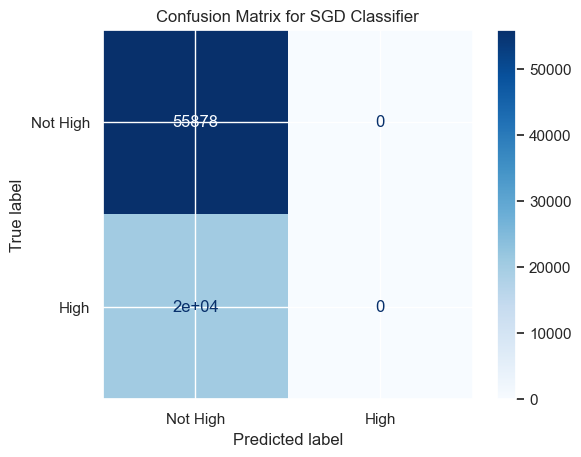

In [628]:
arr_sgdc_1_pred = sgdc_1.predict(X_simple_test)
cm = confusion_matrix(y_simple_test, arr_sgdc_1_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SGD Classifier")

print("For Model SGDC: ")
print(f"precision: {precision_score(y_simple_test, arr_sgdc_1_pred):.2f}")
print(f"% possible trades : {100*np.sum(arr_sgdc_1_pred) / arr_sgdc_1_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_sgdc_1_pred.sum() / arr_sgdc_1_pred.shape[0]:.0f}")
plt.show()

Conclusion : With only the last 5 min as features and the normal feature, the result is not better than with event cat

## Clustering

In [629]:
n_components = 666 # 666 comp => 110 Go Memory !!!!
random_state=42


In [630]:
# check hash pca
# check hash
#path_df_probability_filtered = os.path.join(path_data, 'df_probability_filtered.pkl')
mode_redo_pca, hash_pca = check_hash_inputs(
     (X_rf_train, 
      n_components, 
      random_state,
     ),
     path_hash_pca,
)

hash not match : mode REDO


In [631]:
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
if mode_redo_pca:
    print("PCA fitting...")
    pca = PCA(n_components=n_components, random_state=random_state)
    # X_rf_train, X_rf_test, y_rf_train, y_rf_test
    pca.fit(X_rf_train)
    save_hash(path_hash_pca, hash_pca)
    joblib.dump(pca, path_pca)
    print("PCA saved.")
else:
    # load PCA
    print("Load PCA")
    pca = joblib.load(path_pca)


PCA fitting...
PCA saved.


In [632]:
pca

PCA(n_components=666, random_state=42)

Variance cumulée par nombre de composantes :


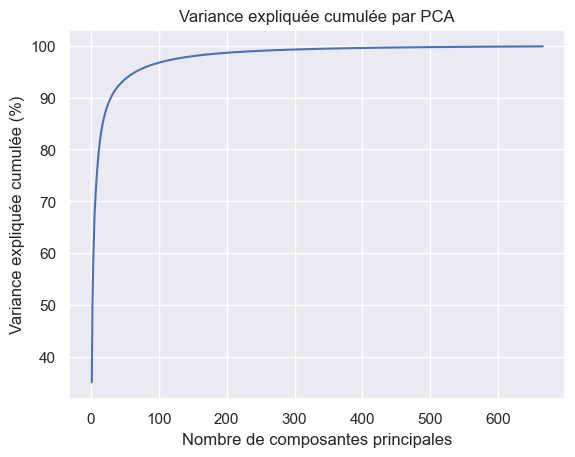

In [633]:

# Affichage de la variance cumulée en pourcentage
cum_var = np.cumsum(pca.explained_variance_ratio_) * 100
print("Variance cumulée par nombre de composantes :")

# Graphique optionnel de la variance expliquée
plt.plot(range(1, len(cum_var)+1), cum_var)
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée cumulée (%)")
plt.title("Variance expliquée cumulée par PCA")
plt.grid(True)
plt.show()

In [634]:
cum_var

array([35.07904916, 50.46228114, 57.38182938, 62.60419278, 67.15848474,
       69.84791295, 72.23498993, 74.23644923, 76.05857634, 77.71737232,
       79.25623453, 80.46973969, 81.61937315, 82.63673197, 83.52562154,
       84.25650446, 84.93896104, 85.55545039, 86.13853415, 86.65565202,
       87.15570158, 87.60394916, 87.99857227, 88.36436932, 88.71346908,
       89.05569471, 89.38270493, 89.67200915, 89.94338386, 90.21331653,
       90.47127115, 90.71339013, 90.94083155, 91.14601377, 91.34334001,
       91.53468495, 91.72377904, 91.89316743, 92.05715694, 92.21311124,
       92.36364936, 92.50747389, 92.64899427, 92.78508444, 92.91962944,
       93.0492649 , 93.17536959, 93.29748612, 93.41552209, 93.5293543 ,
       93.63797322, 93.7439502 , 93.84737549, 93.94757981, 94.0468871 ,
       94.14341146, 94.23650599, 94.32718527, 94.41654958, 94.50134519,
       94.58457577, 94.66599169, 94.74713272, 94.82427547, 94.9001483 ,
       94.97536975, 95.04852273, 95.11799465, 95.18614642, 95.25

In [635]:
# 3. Choix du nombre de composantes correspondant à x% de variance expliquée
print(f"Choix de {n_components} composantes permet d atteindre {cum_var[n_components-1]}% de variance expliquée.")

X_pca = pca.transform(X_rf_train)

Choix de 666 composantes permet d atteindre 99.86370042333795% de variance expliquée.


In [636]:

#kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)

from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=5, random_state=42)

kmeans.fit(X_pca)

KMeans(n_clusters=5, random_state=42)

In [637]:
arr_labels = kmeans.labels_
X_pca_test = pca.transform(X_rf_test)
arr_labels_test = kmeans.predict(X_pca_test)
df_combined_condition["cluster"] = np.concatenate([arr_labels, arr_labels_test])
# add train columns
df_combined_condition["Train"] = [True]*X_rf_train.shape[0] + [False]*X_rf_test.shape[0]
df_combined_condition

20    132    150    213    348    429    537    593  \
date_ETH                                                                      
2023-01-01 00:00:00  False  False  False  False  False  False  False  False   
2023-01-01 00:05:00  False  False  False  False  False  False  False  False   
2023-01-01 00:10:00  False  False  False  False  False  False  False  False   
2023-01-01 00:15:00  False  False   True  False  False  False  False  False   
2023-01-01 00:20:00  False  False  False  False  False  False  False  False   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
2025-05-30 19:15:00  False  False  False  False  False  False  False  False   
2025-05-30 19:20:00  False  False  False  False  False  False  False  False   
2025-05-30 19:25:00  False  False  False  False  False  False  False  False   
2025-05-30 19:30:00  False  False  False  False  False  False  False  False   
2025-05-30 19:35:00  False  False  False  False  False  False  False  False   

                       843    861  ...  216035  216062  216089  216116  \
date_ETH                           ...                                   
2023-01-01 00:00:00  False  False  ...   False   False   False   False   
2023-01-01 00:05:00  False  False  ...   False   False   False   False   
2023-01-01 00:10:00  False  False  ...   False   False   False   False   
2023-01-01 00:15:00  False  False  ...   False   False   False   False   
2023-01-01 00:20:00  False  False  ...   False   False   False   False   
...                    ...    ...  ...     ...     ...     ...     ...   
2025-05-30 19:15:00  False  False  ...   False   False   False   False   
2025-05-30 19:20:00  False  False  ...   False   False   False   False   
2025-05-30 19:25:00  False  False  ...   False   False   False   False   
2025-05-30 19:30:00  False  False  ...   False   False   False   False   
2025-05-30 19:35:00  False  False  ...   False   False   False   False   

                     216143  216170  216197  216788  cluster  Train  
date_ETH                                                             
2023-01-01 00:00:00   False   False   False   False        1   True  
2023-01-01 00:05:00   False   False   False   False        1   True  
2023-01-01 00:10:00   False   False   False   False        1   True  
2023-01-01 00:15:00   False   False   False   False        1   True  
2023-01-01 00:20:00   False   False   False   False        1   True  
...                     ...     ...     ...     ...      ...    ...  
2025-05-30 19:15:00   False   False   False   False        1  False  
2025-05-30 19:20:00   False   False   False   False        1  False  
2025-05-30 19:25:00   False   False   False   False        1  False  
2025-05-30 19:30:00   False   False   False   False        1  False  
2025-05-30 19:35:00   False   False   False   False        1  False  

[253677 rows x 1979 columns]

In [638]:
# Calculate prob of target "high" for each cluster on Train
nb_train = df_combined_condition[df_combined_condition["Train"]].shape[0]
df_cluster_prob = df_combined_condition[df_combined_condition["Train"]].groupby("cluster").apply(
    lambda g: pd.Series({
        "p_high": ((list_df[0]["target_cat"] == "high")[g.index]).mean(),
        "count": g.shape[0],
        "percentage": 100 * g.shape[0] / nb_train,
    })
).reset_index()
df_cluster_prob

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_78415/2810247255.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cluster_prob = df_combined_condition[df_combined_condition["Train"]].groupby("cluster").apply(


cluster    p_high     count  percentage
0        0  0.337172   18409.0   10.367004
1        1  0.296316  123672.0   69.645723
2        2  0.342353   21472.0   12.091928
3        3  0.338442    6329.0    3.564168
4        4  0.343128    7691.0    4.331176

n_comp = 264, n_clusters = 20, p_high = 0.518, occ = 11806, percent occ = 6.64 %  
n_comp = 200, n_clusters = 20, p_high = 0.517, occ = 12900, percent occ = 7.26 %


In [639]:
# same for Test
nb_test = df_combined_condition[~df_combined_condition["Train"]].shape[0]
df_cluster_prob_test = df_combined_condition[~df_combined_condition["Train"]].groupby("cluster").apply(
    lambda g: pd.Series({
        "p_high": ((list_df[0]["target_cat"] == "high")[g.index]).mean(),
        "count": g.shape[0],
        "percentage": 100 * g.shape[0] / nb_test,
    })
).reset_index()
df_cluster_prob_test

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_78415/2789464816.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cluster_prob_test = df_combined_condition[~df_combined_condition["Train"]].groupby("cluster").apply(


cluster    p_high    count  percentage
0        0  0.314605   6087.0    7.998266
1        1  0.254545  62930.0   82.689478
2        2  0.319049   4877.0    6.408336
3        3  0.316361   1198.0    1.574162
4        4  0.353755   1012.0    1.329759

In [640]:
b_test = ~df_combined_condition["Train"]
ser_high_test = list_df[0].loc[b_test, "target_cat"] == "high"

In [648]:
# find best nb cluster with p_high > p_high_min & count > nb_count_min:
# redo kmeans with n clusters and find the best n_clusters
nb_clusters_min = 5
nb_clusters_max = 350
nb_cluster_step = 10
p_high_min = 0.34
nb_count_min = 5
best_cluster_tot = None
list_ser_cluster = []
for n_clusters in range(nb_clusters_min, nb_clusters_max, nb_cluster_step):
    print("k means on n_clusters = ", n_clusters)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_pca)
    arr_labels = kmeans.labels_
    arr_labels_test = kmeans.predict(X_pca_test)
    list_ser_cluster.append(
        pd.Series(
            np.concatenate([arr_labels, arr_labels_test]), 
            index=df_combined_condition.index,
            name=f"cluster_{n_clusters}",
        )
    )

print("Adding clusters to df_combined_condition")
#  concat only on columns not in list_ser_cluster
columns_to_keep = df_combined_condition.columns.difference(
    [ser.name for ser in list_ser_cluster]
)
df_combined_condition = pd.concat(
    [df_combined_condition.filter(columns_to_keep,axis=1)] + list_ser_cluster, axis=1)

for n_clusters in range(nb_clusters_min, nb_clusters_max, nb_cluster_step):
    #df_combined_condition[f"cluster_{n_clusters}"] = np.concatenate([arr_labels, arr_labels_test])
    # Calculate prob of target "high" for each cluster on Train
    df_cluster_prob_test = df_combined_condition.copy().loc[b_test].groupby(f"cluster_{n_clusters}").apply(
        lambda g: pd.Series({
            "p_high": ((ser_high_test)[g.index]).mean(),
            "count": g.shape[0],
            "percentage": 100 * g.shape[0] / nb_test,
        })
    , include_groups=False).reset_index()
    # filter even rare trades: if p_high > p_high_min and count > nb_clusters_min
    best_cluster = df_cluster_prob_test.copy()[(df_cluster_prob_test["p_high"] > p_high_min) & (df_cluster_prob_test["count"] > nb_count_min)]
    if best_cluster.shape[0] > 0:
        best_cluster.loc[:, "nb_clusters"] = n_clusters * np.ones(best_cluster.shape[0], dtype=int)
        # rename col
        best_cluster.rename(
            columns={
                "nb_clusters":"nb_clusters",
                "cluster_"+str(n_clusters): "cluster", 
                "p_high": "p_high", 
                "count": "count", 
                "percentage": "percentage"
            }, inplace=True
        )
        # append to a dataframe
        if best_cluster_tot is None:
            best_cluster_tot = best_cluster.copy()
        else:
            best_cluster_tot = pd.concat([best_cluster_tot, best_cluster.copy()], axis=0)
        print(f"n_clusters: {n_clusters} : \n {best_cluster}")
best_cluster_tot

k means on n_clusters =  5
k means on n_clusters =  15
k means on n_clusters =  25
k means on n_clusters =  35
k means on n_clusters =  45
k means on n_clusters =  55
k means on n_clusters =  65
k means on n_clusters =  75
k means on n_clusters =  85
k means on n_clusters =  95
k means on n_clusters =  105
k means on n_clusters =  115
k means on n_clusters =  125
k means on n_clusters =  135
k means on n_clusters =  145
k means on n_clusters =  155
k means on n_clusters =  165
k means on n_clusters =  175
k means on n_clusters =  185
k means on n_clusters =  195
k means on n_clusters =  205
k means on n_clusters =  215
k means on n_clusters =  225
k means on n_clusters =  235
k means on n_clusters =  245
k means on n_clusters =  255
k means on n_clusters =  265
k means on n_clusters =  275
k means on n_clusters =  285
k means on n_clusters =  295
k means on n_clusters =  305
k means on n_clusters =  315
k means on n_clusters =  325
k means on n_clusters =  335
k means on n_clusters =  

cluster    p_high   count  percentage  nb_clusters
4          4  0.353755  1012.0    1.329759            5
4          4  0.392749   331.0    0.434931           15
3          3  0.378788   132.0    0.173447           25
4          4  0.484848    66.0    0.086723           25
9          9  0.369963   273.0    0.358720           25
..       ...       ...     ...         ...          ...
316      317  0.461538    13.0    0.017082          345
325      326  0.378378    37.0    0.048618          345
329      330  0.358491    53.0    0.069642          345
331      332  0.400000    25.0    0.032850          345
332      333  0.388889    18.0    0.023652          345

[1479 rows x 5 columns]

### Model from clustering

- Select only best clusters with a minimum prob p_high_cluster_best
- Calculate the mean prob per group "nb_clusters"
- Calculate count for "high" target per group "nb_clusters"
- Select only group with count  > ratio_trades_cluster_best * nb_test

In [653]:
p_high_cluster_best = 0.34 # min prob high for each cluster to filter best clusters
ratio_trades_cluster_best = 1/288 # 8 trades per day per group "nb_clusters" of best prob cluters

In [654]:
best_cluster_tot["prod_prob"] = best_cluster_tot["p_high"] * best_cluster_tot["count"]


In [655]:
nb_test*ratio_trades_cluster_best

264.25

In [656]:
# sumup count & prod_prob in cluster with prob > p_high_cluster_best group by nb_clusters :
best_count = best_cluster_tot[best_cluster_tot["p_high"] > p_high_cluster_best].filter(
    ["nb_clusters", "count", "prod_prob"]
    ).groupby("nb_clusters").sum()
best_count["prob"] = best_count["prod_prob"] / best_count["count"]
# select only count > ratio_trades_cluster_best trades per days
best_count_final = best_count[best_count["count"] > nb_test*ratio_trades_cluster_best].sort_values(by="prob", ascending=False)
best_count_final


count  prod_prob      prob
nb_clusters                             
15            331.0      130.0  0.392749
25            471.0      183.0  0.388535
35            733.0      270.0  0.368349
115          2482.0      910.0  0.366640
135          3203.0     1174.0  0.366531
335          6947.0     2537.0  0.365194
345          7072.0     2580.0  0.364819
245          5330.0     1943.0  0.364540
325          6690.0     2438.0  0.364425
255          5590.0     2037.0  0.364401
305          6796.0     2476.0  0.364332
295          6603.0     2405.0  0.364228
315          6610.0     2407.0  0.364145
125          3051.0     1111.0  0.364143
275          6639.0     2414.0  0.363609
265          6116.0     2223.0  0.363473
285          6686.0     2427.0  0.362997
145          3775.0     1369.0  0.362649
235          5341.0     1935.0  0.362292
225          5229.0     1890.0  0.361446
45           1984.0      717.0  0.361391
215          4861.0     1756.0  0.361243
105          2713.0      979.0  0.360855
175          4271.0     1539.0  0.360337
205          5287.0     1905.0  0.360318
195          4880.0     1758.0  0.360246
75           2604.0      938.0  0.360215
185          4676.0     1683.0  0.359923
155          4326.0     1553.0  0.358992
165          4396.0     1578.0  0.358963
95           3233.0     1160.0  0.358800
85           2930.0     1051.0  0.358703
65           3194.0     1135.0  0.355354
5            1012.0      358.0  0.353755
55           3152.0     1113.0  0.353109

In [657]:
nb_cluster_best = best_count_final.index[0]
nb_cluster_best

np.int64(15)

In [658]:
# select only the best clusters with p_high > p_high_cluster_best 
# and in group "nb_clusters" with count > nb_test*ratio_trades_cluster_best trades per day
best_cluster_select = best_cluster_tot[
    (best_cluster_tot["p_high"] > p_high_cluster_best) & 
    (best_cluster_tot["nb_clusters"].isin(
        best_count[best_count["count"] > nb_test*ratio_trades_cluster_best].index.tolist()))
]
best_cluster_select

cluster    p_high   count  percentage  nb_clusters  prod_prob
4          4  0.353755  1012.0    1.329759            5      358.0
4          4  0.392749   331.0    0.434931           15      130.0
3          3  0.378788   132.0    0.173447           25       50.0
4          4  0.484848    66.0    0.086723           25       32.0
9          9  0.369963   273.0    0.358720           25      101.0
..       ...       ...     ...         ...          ...        ...
316      317  0.461538    13.0    0.017082          345        6.0
325      326  0.378378    37.0    0.048618          345       14.0
329      330  0.358491    53.0    0.069642          345       19.0
331      332  0.400000    25.0    0.032850          345       10.0
332      333  0.388889    18.0    0.023652          345        7.0

[1479 rows x 6 columns]

In [659]:
best_cluster_final = best_cluster_select.copy()[(best_cluster_select["nb_clusters"] == nb_cluster_best)].sort_values(by="p_high", ascending=False)
best_cluster_final

cluster    p_high  count  percentage  nb_clusters  prod_prob
4        4  0.392749  331.0    0.434931           15      130.0

In [660]:
best_cluster_final["cluster"].iloc[0]

np.int32(4)

In [661]:
ser_comb_best = df_combined_condition.loc[df_combined_condition[f"cluster_{nb_cluster_best}"] == best_cluster_final["cluster"].iloc[0]].filter([I for I in range(df_probability_filtered.shape[1])]
).mean(axis=0).sort_values(ascending=False).head(20)
ser_comb_best

1644    0.984744
1779    0.984744
1563    0.984744
942     0.960740
1322    0.960740
861     0.960740
1077    0.960740
1376    0.945484
1106    0.938365
1860    0.919447
593     0.916802
348     0.916802
213     0.916802
132     0.916802
1158    0.898495
429     0.851505
888     0.846827
1968    0.787836
1266    0.768104
537     0.733320
dtype: float64

In [662]:
df_prob_comb.loc[ser_comb_best.index]

target_cat   high    low  neutral    p_high     p_low  delta_prob  \
1644         3487   3317     3514  0.337953  0.321477    8.495003   
1779         2740   2507     2744  0.342886  0.313728   20.693349   
1563         4519   4317     4506  0.338705  0.323565    9.235853   
942          3277   3108     3227  0.340928  0.323346    8.946280   
1322        11930  11888    11713  0.335763  0.334581    0.148123   
861          4275   4080     4176  0.341154  0.325593    9.102334   
1077         2619   2382     2577  0.345606  0.314331   22.463107   
1376        19005  19004    18736  0.334919  0.334902    0.000053   
1106        19926  19655    20069  0.334049  0.329505    3.710922   
1860        15779  15577    15864  0.334159  0.329881    2.602628   
593         14936  14849    14864  0.334520  0.332572    0.508242   
348          2459   2249     2436  0.344205  0.314810   18.734070   
213          3025   2906     3045  0.337010  0.323752    4.775249   
132          3865   3690     3840  0.339184  0.323826    8.107214   
1158        12967  12761    12719  0.337269  0.331911    3.298818   
429         14123  14003    14083  0.334597  0.331754    1.023964   
888         11837  11615    11982  0.334058  0.327793    4.202968   
1968         6161   6070     6179  0.334655  0.329712    1.354100   
1266         5260   5091     5180  0.338677  0.327796    5.518501   
537          5255   5175     5222  0.335740  0.330629    1.227229   

target_cat        feat_0 feat_0_cat  lag_0               feat_1 feat_1_cat  \
1644        High_ETH_cat    neutral     64  ichi_tenkan_ETH_cat    neutral   
1779        High_ETH_cat    neutral     64  ichi_tenkan_ETH_cat    neutral   
1563        High_ETH_cat    neutral     64  ichi_tenkan_ETH_cat    neutral   
942         High_ETH_cat    neutral     64         High_ETH_cat    neutral   
1322        High_ETH_cat    neutral     64         High_ETH_cat    neutral   
861         High_ETH_cat    neutral     64         High_ETH_cat    neutral   
1077        High_ETH_cat    neutral     64         High_ETH_cat    neutral   
1376        High_ETH_cat    neutral     64         High_ETH_cat    neutral   
1106        High_ETH_cat    neutral     64         High_ETH_cat    neutral   
1860        High_ETH_cat    neutral     64  ichi_tenkan_ETH_cat    neutral   
593         High_ETH_cat    neutral     64         Open_ETH_cat    neutral   
348         High_ETH_cat    neutral     64         Open_ETH_cat    neutral   
213         High_ETH_cat    neutral     64         Open_ETH_cat    neutral   
132         High_ETH_cat    neutral     64         Open_ETH_cat    neutral   
1158        High_ETH_cat    neutral     64         High_ETH_cat    neutral   
429         High_ETH_cat    neutral     64         Open_ETH_cat    neutral   
888         High_ETH_cat    neutral     64         High_ETH_cat    neutral   
1968        High_ETH_cat    neutral     64  ichi_tenkan_ETH_cat    neutral   
1266        High_ETH_cat    neutral     64         High_ETH_cat    neutral   
537         High_ETH_cat    neutral     64         Open_ETH_cat    neutral   

target_cat  lag_1               feat_2 feat_2_cat  lag_2  
1644           68    min_low_h_ETH_cat       high     70  
1779           68    min_low_h_ETH_cat       high     71  
1563           68    min_low_h_ETH_cat       high     68  
942            68    min_low_h_ETH_cat       high     70  
1322           68         High_ETH_cat    neutral     56  
861            68    min_low_h_ETH_cat       high     68  
1077           68    min_low_h_ETH_cat       high     71  
1376           68  ichi_tenkan_ETH_cat    neutral     56  
1106           68         High_ETH_cat    neutral     70  
1860           68          Low_ETH_cat       high     64  
593            64         High_ETH_cat    neutral     56  
348            64    min_low_h_ETH_cat       high     71  
213            64    min_low_h_ETH_cat       high     70  
132            64    min_low_h_ETH_cat       high     68  
1158           68         

In [663]:
clusters_best = best_cluster_select[(best_cluster_select["nb_clusters"] == nb_cluster_best)]["cluster"].tolist()
clusters_best

[4]

In [664]:
df_combined_condition["in_cluster_best"] = df_combined_condition[f"cluster_{nb_cluster_best}"].isin(clusters_best)

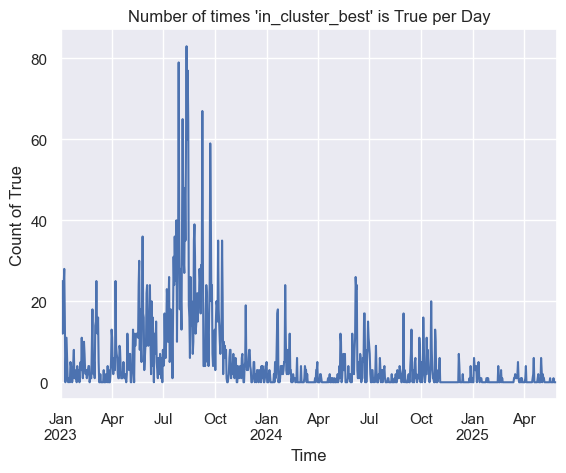

In [665]:
# by group sum every hour
df_combined_condition["in_cluster_best"].resample("D").sum().plot()
plt.title("Number of times 'in_cluster_best' is True per Day")
plt.xlabel("Time")
plt.ylabel("Count of True")
plt.grid(True)

In [666]:
df_combined_condition["in_cluster_best"].resample("D").sum().describe()


count    881.000000
mean       5.580023
std       10.086028
min        0.000000
25%        0.000000
50%        2.000000
75%        6.000000
max       83.000000
Name: in_cluster_best, dtype: float64

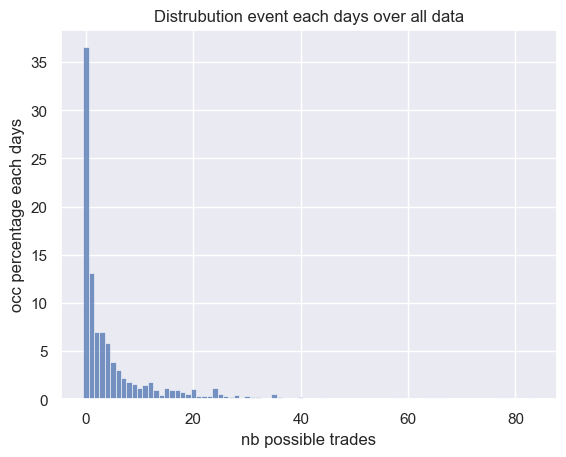

In [667]:
#df_combined_condition["in_cluster_best"].resample("D").sum()#.hist()#value_counts(ascending=True)

sns.histplot(df_combined_condition["in_cluster_best"].resample("D").sum(), 
             discrete=True,
             stat="percent")#.hist()#value_counts(ascending=True)
# rename xlabel
ax = plt.gca()
ax.set_xlabel("nb possible trades")
ax.set_ylabel("occ percentage each days")
plt.title("Distrubution event each days over all data")
plt.show()

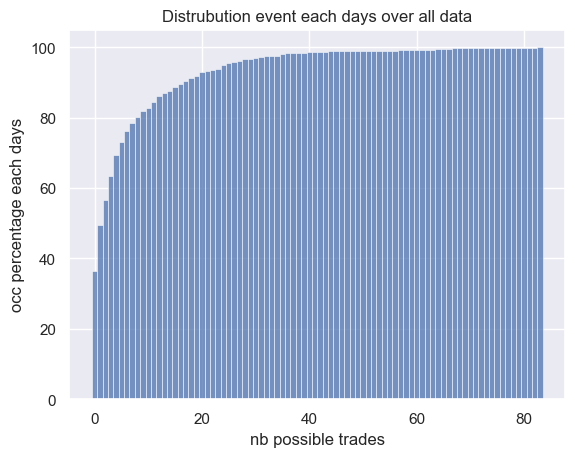

In [668]:

sns.histplot(df_combined_condition["in_cluster_best"].resample("D").sum(), 
             discrete=True,
             cumulative=True,
             stat="percent",
)#.hist()#value_counts(ascending=True)
# rename xlabel
ax = plt.gca()
ax.set_xlabel("nb possible trades")
ax.set_ylabel("occ percentage each days")
plt.title("Distrubution event each days over all data")
plt.show()

In [669]:
df_combined_condition[~df_combined_condition["Train"]]["in_cluster_best"].resample("D").sum().describe()


count    265.000000
mean       1.249057
std        2.723051
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       20.000000
Name: in_cluster_best, dtype: float64

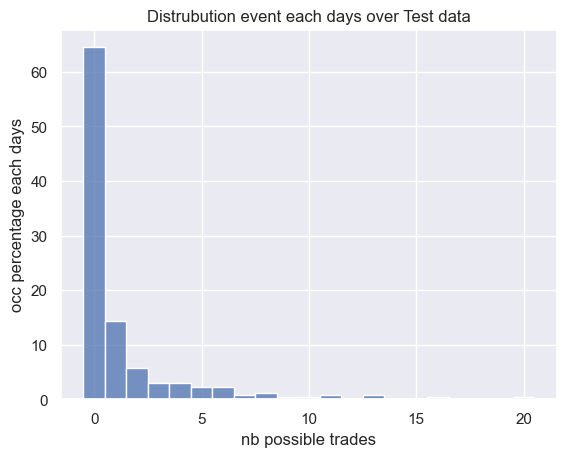

In [670]:
sns.histplot(df_combined_condition[~df_combined_condition["Train"]]["in_cluster_best"].resample("D").sum(), 
             discrete=True,
             stat="percent",
)#.hist()#value_counts(ascending=True)
# rename xlabel
ax = plt.gca()
ax.set_xlabel("nb possible trades")
ax.set_ylabel("occ percentage each days")
plt.title("Distrubution event each days over Test data")
plt.show()
plt.show()

In [ ]:
# plot clusters in 2D using first two PCA components

## Backtest

### Baseline

In [ ]:
list_df[0]["Close_ETH_raw"]

date_ETH
2023-01-01 00:00:00    1194.540039
2023-01-01 00:05:00    1195.089966
2023-01-01 00:10:00    1195.000000
2023-01-01 00:15:00    1194.089966
2023-01-01 00:20:00    1194.890015
                          ...     
2025-05-30 19:15:00    2520.719971
2025-05-30 19:20:00    2524.370117
2025-05-30 19:25:00    2512.060059
2025-05-30 19:30:00    2509.129883
2025-05-30 19:35:00    2479.080078
Name: Close_ETH_raw, Length: 253677, dtype: float32

- BE CAREFUL : Hyperliquid for example can take 25% of trade if 0.1% is a trigger : 
  - maker fees : 0.015% (if trade out of orderbook (usually when limit order)
  - or taker fees : 0.038% (if market order)
  - funding 1h : 0.0014% ( funding rate will be positive, and the long position will pay the short position.)
  - TOTAL max 2 takers trades (open/close) + funding 1h max :  0.0774% => 77% of 0.1% !

- in 5 min candle : Close value at 8:00 ⇒ real value at 08:04:59.999

(TP*0.23) / (SL * 1.77) = Req == 2: 
- R = TP/SL
- R * 0.23 / 1.77 = Req
- R = 1.77/0.23 * Req

In [ ]:
target_level

0.001

In [ ]:
(0.45/100 - 0.0774 / 100 ) * 10000 * 10 


372.6

In [ ]:
(-0.45/2/100 - 0.0774 / 100 ) * 10000 * 10


-302.40000000000003

In [ ]:
(0.45/100 - 0.0774 / 100 ) / (0.45/2/100 + 0.0774 / 100 )


1.2321428571428572

In [ ]:
#list_df[0]["Close_ETH_raw"]
tp_ratio = 0.1/100 #0.45/100 #0.1 / 100 #0.33/100
print("target level for TP [-]: ", tp_ratio)
R = 2 #2 #2.5 
print("R TP/SL [-]: ", R)
ratio_fees = 0.0774 / 100 # hyperliquid
print("r_fees %fees/%TP [-]: ", ratio_fees / tp_ratio)
R_eq = (tp_ratio - ratio_fees) / ((tp_ratio / R) + ratio_fees)
print("R_eq [-]: ", R_eq)
capital_init = 10000
leverage = 10
buy = list_df[0]["Close_ETH_raw"].values[0]
tp = False
nb_tp = 0
capital_tp = 0
sl = False
nb_sl = 0
capital_sl = 0
neutral = False
nb_neutral = 0
capital_neutral = 0
capital = capital_init
step_max = 60/5
step = 0
list_trade_gain = []
list_trade_date = []
list_trade_type = []
list_trade_fees = []
list_capital = []
for close, high, low, date_trade in zip(
        list_df[0]["Close_ETH_raw"], 
        list_df[0]["Close_ETH_raw"] * list_df[0]["High_ETH"], 
        list_df[0]["Close_ETH_raw"] * list_df[0]["Low_ETH"],
        list_df[0]["Close_ETH_raw"].index
    ):
    # neutral : if elasted time to take a trade is over (more than 1 hour) : we close the position
    if step >= step_max:
        nb_neutral += 1
        fees =  ( (buy + close) / 2 ) / buy * leverage * capital_init * ratio_fees
        gain = ((close - buy) / buy) * leverage * capital_init - fees
        list_trade_fees.append(fees)
        list_trade_gain.append(gain)
        list_trade_date.append(date_trade)
        list_trade_type.append("Neutral")
        capital += gain
        list_capital.append(capital)
        capital_neutral += gain
        neutral = True
        step = 0
        continue
    # if last time, we have close a position, we open a new one immediatly (5 min after)
    if tp or sl or neutral:
        buy = close
        step = 0
        tp = False
        sl = False
        neutral = False
        continue # trade done at close
    # if max price is higher than TP, we take the trade and close position
    if high >= (1+tp_ratio) * buy:
        fees = ((1+tp_ratio) + 1) / 2 * leverage * capital_init * ratio_fees
        gain = tp_ratio * leverage * capital_init - fees
        list_trade_fees.append(fees)
        list_trade_gain.append(gain)
        list_trade_date.append(date_trade)
        list_trade_type.append("TP")
        capital += gain
        list_capital.append(capital)
        capital_tp += gain
        tp = True
        nb_tp += 1
        continue
    # if min price is lower than SL, we take the trade and close position
    elif low <= (1-1/R*tp_ratio) * buy: 
        fees = (1 + 1-1/R*tp_ratio) / 2 * leverage * capital_init * ratio_fees
        gain = -1/R*tp_ratio * leverage * capital_init - fees
        list_trade_fees.append(fees)
        list_trade_gain.append(gain)
        list_trade_date.append(date_trade)
        list_trade_type.append("SL")
        capital +=  gain
        list_capital.append(capital)
        capital_sl +=  gain
        sl = True
        nb_sl += 1
        continue
    else:
        step += 1
print("Capital init [$]", capital_init)
print('final capital [$]:', capital)
print("ratio gain final [-]: ", (capital - capital_init)/capital_init)
print("Winrate [-] : ", nb_tp / (nb_tp + nb_sl))
print("nb_tp: ", nb_tp)
print('capital_tp [$]: ', capital_tp)
print("nb_sl: ", nb_sl)
print('capital_sl [$]: ', capital_sl)
print('nb_neutral: ', nb_neutral)
print('capital_neutral [$]', capital_neutral)
df_trades = pd.concat([
    pd.Series(list_trade_type, index=list_trade_date, name="type"),
    pd.Series(list_trade_gain, index=list_trade_date, name="gain"),
    pd.Series(list_trade_fees, index=list_trade_date, name="fees"),
    pd.Series(list_capital, index=list_trade_date, name="capital"),
    ],
    axis=1,
)
# 1342565
df_trades

target level for TP [-]:  0.001
R TP/SL [-]:  2
r_fees %fees/%TP [-]:  0.7739999999999999
R_eq [-]:  0.17739403453689173
Capital init [$] 10000
final capital [$]: -5973392.587631497
ratio gain final [-]:  -598.3392587631497
Winrate [-] :  0.4836274122585445
nb_tp:  52653
capital_tp [$]:  1187920.1288983505
nb_sl:  56218
capital_sl [$]:  -7161085.381695735
nb_neutral:  172
capital_neutral [$] -10227.334839711984


type       gain      fees       capital
2023-01-01 00:35:00   SL -127.38065  77.38065  9.872619e+03
2023-01-01 01:05:00   TP   22.56130  77.43870  9.895181e+03
2023-01-01 01:15:00   SL -127.38065  77.38065  9.767800e+03
2023-01-01 01:45:00   TP   22.56130  77.43870  9.790361e+03
2023-01-01 02:15:00   SL -127.38065  77.38065  9.662981e+03
...                  ...        ...       ...           ...
2025-05-30 18:55:00   SL -127.38065  77.38065 -5.973333e+06
2025-05-30 19:05:00   TP   22.56130  77.43870 -5.973310e+06
2025-05-30 19:15:00   TP   22.56130  77.43870 -5.973288e+06
2025-05-30 19:25:00   SL -127.38065  77.38065 -5.973415e+06
2025-05-30 19:35:00   TP   22.56130  77.43870 -5.973393e+06

[109043 rows x 4 columns]

In [ ]:
(0.0033  -  0.0774 /100)*3000

7.578

In [ ]:
2571 + 7888

10459

In [ ]:
100*(-1763044 - 10000)/10000


-17730.44

In [ ]:
10000 * (1-17730/100)

-1763000.0

In [ ]:
2571 +list_df[0].shape[0]

253677

In [ ]:
100000 * 0.077 / 100

77.0

<Axes: >

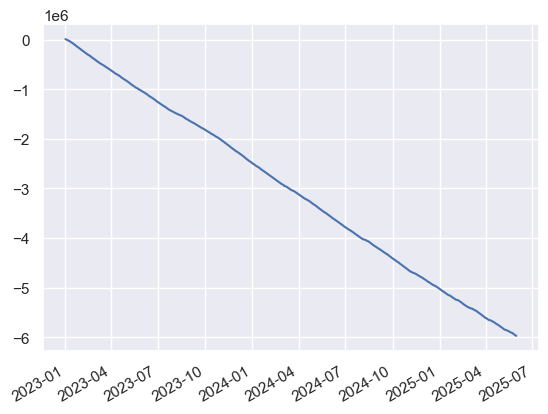

In [ ]:
df_trades.capital.plot()

In [ ]:
nb_tp

52653

In [ ]:
nb_sl

56218

In [ ]:
nb_neutral

172

# TODO

In [ ]:
# DONE : optimize corr calculation
# DONE : evaluate value of target_14 in term of real variation % between high and low 
# DONE : cross : find cat combinaison with most prob diff between high and low (linked to chi2 not always but a little)
# DONE : change algo for target cat : buy/sell with TP/SL = 2 (if +0.1% TP => -0.05% SL)
# DONE : past history: select the lags exponentially on the past history (not linear: example 5 min ago, 10 min, 20 min, 40 min, 1h20, 2h40, 5h20 ago)
# DONE : cross best over all lags : find cat combinaison with most prob diff between high and low (linked to chi2 ?)
# DONE : check temporal repartition of interesting events
# DONE : maybe have a threshold on target instead of quantiles?
# DONE : test another target : maybe the max/min value on all targets to have ony 2 targets
# DONE : cross prob with selected features with best corr with targets
# DONE : cross prob with selected features with best chi2 with targets
# DONE : machine learning classification with selected features with RandomForest 
# DONE : Take best cross prob (3 feat) and check when several occurs on same time to see if prob increase
# DONE : change prob model (particularly threshold) to have same 10 trades per day minimum and best precision
# DONE : Check Max prob Model limited to 100 best probs : why same results compared to without limit mode? 
# DONE : Add check comb2 model with Max prob or mean prob mdl (using 6 events (2*3 comb event))
# DONE : Change to price dependant features for ATR indices and z-score ETH
# DONE : Redo study by limited cat features (27000 max) with TRAIN/TEST split ? 
# DONE : ML study on precision on all limited cat features (max 27000 comb event cat) with best ML model : RF, XGBoost, KNN ...
# DONE : Same ML Study on all features (not comb event cat features) with best ML model : RF, XGBoost, KNN ...
# DONE : Clustering on train data with normal features (no feat categories) to find clusters with high/low/neutral targets ?
# DONE : Backstest : baseline : check fees impact
# DONE : Fix target TP / SL with High / Low : the intersection between low/high not empty !
# TODO : new realistic target on 1 hour ? new tp ratio = 0.45% and R=2
# TODO : new realistic target on 1 hour ? new tp ratio = 0.33% and R=2.5
# TODO : backtest strat on df_train / df_test data with model RF
# TODO : backtest strat on df_train / df_test data with model High Prob Event ? data leak of test data ? redo on TRAIN only ?

# TODO : test with a 20/20/60 for feature cat : H/L/N instead of 10/10/80

# TODO : create a new exploration notebook for a target of daily trading : (currently : 6 hours history to predict next 1h)
#        - find good time frame / PAST_HISTORY / FUTURE_TARGET
#        - find good target level (0.1% ?)

In [ ]:
len(list_col_select)

109

In [ ]:
list_past

[71, 70, 68, 64, 56, 40, 8]

In [ ]:
# how many combinaison of 3 elements in len(list_col_select) * nb lags
nb_elements = len(list_col_select) * len(list_past)
nb_comb = nb_elements * (nb_elements-1) * (nb_elements-2)
nb_comb


442449966

It s too much

In [ ]:
# how many combinaison of 3 elements in 40 selected comb (feat / lag) 
# (20 high target /20 low target and with max or min delta_prob)
nb_elements = 40
print(nb_elements, " elements")
nb_comb = nb_elements * (nb_elements-1) * (nb_elements-2)
nb_comb

40  elements


59280

Ok 